# MNIST

### MNIST 데이터 받기

In [1]:
import os
import sys
from six.moves import urllib
import gzip
import pickle
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt


SOURCE_URL = 'http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz'
FILENAME = SOURCE_URL.split('/')[-1]
DATA_DIR = './datasets'

def maybe_download(data_dir):
    filepath = os.path.join(data_dir, FILENAME)
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
    if not os.path.isfile(filepath):
        def _progress(count, block_size, total_size):
            sys.stdout.write('\r>> Downloading {} {:.1f} %'.format(
                FILENAME, float(count * block_size) / float(total_size) * 100.0))
            sys.stdout.flush()
        filepath, _ = urllib.request.urlretrieve(SOURCE_URL, filepath, _progress)
        print()
        statinfo = os.stat(filepath)
        print('Successfully donloaded', FILENAME, statinfo.st_size, 'bytes.')

def load(data_dir, subset='train'):
    maybe_download(data_dir)
    filepath = os.path.join(data_dir, FILENAME)
    
    f = gzip.open(filepath, 'rb')
    u = pickle._Unpickler(f)
    u.encoding = 'latin1'
    train_set, valid_set, test_set = u.load()
    f.close()
    
    if subset == 'train':
        trainx, trainy = train_set
        trainx = trainx.astype(np.float32).reshape(trainx.shape[0], 28, 28)
        trainy = trainy.astype(np.uint8)
        return trainx, trainy
    elif subset == 'test':
        testx, testy = test_set
        testx = testx.astype(np.float32).reshape(testx.shape[0], 28, 28)
        testy = testy.astype(np.uint8)
        return testx, testy
    elif subset== 'valid':
        validx, validy = valid_set
        validx = validx.astype(np.float32).reshape(validx.shape[0], 28, 28)
        validy = validy.astype(np.uint8)
        return validx, validy
    else:
        raise NotImplementedError('subset should be train or valid or test')

# Load data
train_data, train_label = load(DATA_DIR, 'train')
valid_data, valid_label = load(DATA_DIR, 'valid')
test_data, test_label = load(DATA_DIR, 'test')

# concatenate train and valid data as train data
train_data = np.concatenate((train_data, valid_data))
train_label = np.concatenate((train_label, valid_label))

### MNIST 데이터 확인 하기

In [2]:
# size of MNIST
print(train_data.shape)
print(train_label.shape)
print(test_data.shape)
print(test_label.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


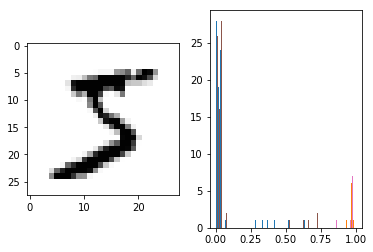

In [3]:
# show data
_, (ax1, ax2) = plt.subplots(1, 2)
sample_data = train_data[0]
ax1.imshow(sample_data, cmap=plt.cm.Greys);
ax2.hist(sample_data, bins=20, range=[0, 1]);

In [4]:
import tensorflow as tf


In [5]:
learning_rate = 1e-3
num_epochs = 100
batch_size = 100
num_display = 100
data = 60000
#기존에는 suffling을 한 후에 batch_size만큼 랜덤 샘플링을 하고 1 epoch를 돌고 다시 반복.


def get_model(X, by):
    X = tf.expand_dims(X, axis = 3) # (None, 28, 28, 1)
    

    with tf.variable_scope('first'):
    #find tensorflow conv2d doc
    #padding => valid : zero padding적용안함 same : 적용
        outs = tf.layers.conv2d(X, 128, 3, padding='same')
        outs = tf.nn.relu(outs)
        outs = tf.layers.max_pooling2d(outs, 2, 2) #(None, 14, 14, 128)
    with tf.variable_scope('second'):
        outs  = tf.layers.conv2d(X, 256, 3, padding='same')
        outs = tf.nn.relu(outs)
        outs = tf.layers.max_pooling2d(outs, 2, 2) #(None, 7, 7, 256)
    with tf.variable_scope('third'):
        outs = tf.layers.conv2d(outs, 64, 3, padding='same')
        outs = tf.nn.relu(outs)
        outs = tf.layers.max_pooling2d(outs, 2, 2) #(None, 3, 3, 64)
    print(outs)
    outs = tf.reshape(outs, (-1, outs.shape[1]*outs.shape[2]*outs.shape[3]))
    outs = tf.layers.dense(outs, 128)
    outs = tf.nn.relu(outs)
    outs = tf.layers.dense(outs, 10)
    one_hot = tf.one_hot(by, 10)
    
    loss = tf.nn.softmax_cross_entropy_with_logits_v2(logits = outs, labels = one_hot)
    
    loss = tf.reduce_mean(loss)
    opt = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(loss)
    
    preds = tf.cast(tf.argmax(tf.nn.softmax(outs), axis = 1), tf.int32)
#    acc = tf.metrics.accuracy(labels = by, predictions=preds)
    acc = tf.reduce_mean(tf.cast(tf.equal(by, preds), tf.float32))
    init = tf.global_variables_initializer()
    
    return{
        'loss': loss,
        'opt' : opt,
        'preds' : preds,
        'acc' : acc,
        'init' : init,
    }
    

In [6]:
X = tf.placeholder(tf.float32, shape=(None, 28, 28))
by = tf.placeholder(tf.int32)

model = get_model(X, by)


Tensor("third/max_pooling2d/MaxPool:0", shape=(?, 7, 7, 64), dtype=float32)


In [ ]:
with tf.Session() as sess:
    sess.run(model['init'])
    for ind_epoch in range(0, num_epochs):
        print('Current iteration {}'.format(ind_epoch + 1))
        
        for ind_ in range(0, int(data / batch_size)):
            batch_X = train_data[ind_*batch_size:(ind_+1) * batch_size]
            batch_by = train_label[ind_*batch_size:(ind_+1) * batch_size]
            _, cur_loss, cur_acc = sess.run([model['opt'], model['loss'], model['acc']],
                     feed_dict={X: batch_X, by : batch_by})
            if ind_ % num_display == 0:
                print('loss {0:.4f} acc {1:.4f}'.format(cur_loss, cur_acc))
            cur_acc_all = 0.0
            cur_loss_all = 0.0
            for ind_ in range(0, 10):
                cur_loss, cur_acc = sess.run([model['loss'], model['acc']],
                         feed_dict={X: test_data[ind_*1000:(ind_+1)*1000], by : \
                                    test_label[ind_*1000:(ind_+1)*1000]})
                cur_loss_all += cur_loss
                cur_acc_all += cur_acc
#            if ind_ % num_display == 0:
                print('TEST {0:.4f} acc {1:.4f}'.format(cur_loss_all / 10.0, cur_acc_all / 10.0))

Current iteration 1
loss 2.3167 acc 0.0800
TEST 0.2272 acc 0.0193
TEST 0.4543 acc 0.0394
TEST 0.6815 acc 0.0598
TEST 0.9085 acc 0.0802
TEST 1.1359 acc 0.1003
TEST 1.3620 acc 0.1193
TEST 1.5883 acc 0.1399
TEST 1.8146 acc 0.1552
TEST 2.0405 acc 0.1727
TEST 2.2664 acc 0.1902
TEST 0.2221 acc 0.0349
TEST 0.4447 acc 0.0690
TEST 0.6674 acc 0.1039
TEST 0.8896 acc 0.1376
TEST 1.1119 acc 0.1729
TEST 1.3322 acc 0.2080
TEST 1.5527 acc 0.2437
TEST 1.7731 acc 0.2766
TEST 1.9926 acc 0.3075
TEST 2.2127 acc 0.3398
TEST 0.2141 acc 0.0449
TEST 0.4292 acc 0.0893
TEST 0.6445 acc 0.1337
TEST 0.8590 acc 0.1781
TEST 1.0736 acc 0.2234
TEST 1.2842 acc 0.2708
TEST 1.4952 acc 0.3162
TEST 1.7063 acc 0.3616
TEST 1.9156 acc 0.4063
TEST 2.1265 acc 0.4511
TEST 0.2030 acc 0.0482
TEST 0.4079 acc 0.0943
TEST 0.6135 acc 0.1401
TEST 0.8177 acc 0.1872
TEST 1.0211 acc 0.2368
TEST 1.2189 acc 0.2887
TEST 1.4176 acc 0.3389
TEST 1.6161 acc 0.3924
TEST 1.8121 acc 0.4451
TEST 2.0110 acc 0.4955
TEST 0.1892 acc 0.0492
TEST 0.3811 ac

TEST 0.0863 acc 0.1749
TEST 0.1296 acc 0.2626
TEST 0.1753 acc 0.3495
TEST 0.2180 acc 0.4371
TEST 0.2457 acc 0.5277
TEST 0.2788 acc 0.6184
TEST 0.3074 acc 0.7098
TEST 0.3262 acc 0.8043
TEST 0.3663 acc 0.8931
TEST 0.0389 acc 0.0890
TEST 0.0865 acc 0.1756
TEST 0.1301 acc 0.2635
TEST 0.1754 acc 0.3505
TEST 0.2176 acc 0.4384
TEST 0.2464 acc 0.5289
TEST 0.2797 acc 0.6190
TEST 0.3097 acc 0.7099
TEST 0.3291 acc 0.8040
TEST 0.3702 acc 0.8927
TEST 0.0379 acc 0.0892
TEST 0.0840 acc 0.1767
TEST 0.1268 acc 0.2647
TEST 0.1706 acc 0.3529
TEST 0.2113 acc 0.4419
TEST 0.2396 acc 0.5335
TEST 0.2722 acc 0.6240
TEST 0.3020 acc 0.7148
TEST 0.3210 acc 0.8092
TEST 0.3613 acc 0.8981
TEST 0.0354 acc 0.0897
TEST 0.0784 acc 0.1785
TEST 0.1188 acc 0.2676
TEST 0.1605 acc 0.3560
TEST 0.1984 acc 0.4466
TEST 0.2241 acc 0.5389
TEST 0.2546 acc 0.6297
TEST 0.2825 acc 0.7209
TEST 0.2998 acc 0.8162
TEST 0.3376 acc 0.9058
TEST 0.0336 acc 0.0902
TEST 0.0744 acc 0.1791
TEST 0.1130 acc 0.2689
TEST 0.1530 acc 0.3570
TEST 0.1891

TEST 0.0228 acc 0.0925
TEST 0.0519 acc 0.1836
TEST 0.0780 acc 0.2755
TEST 0.1056 acc 0.3669
TEST 0.1300 acc 0.4587
TEST 0.1476 acc 0.5526
TEST 0.1634 acc 0.6480
TEST 0.1727 acc 0.7456
TEST 0.1784 acc 0.8440
TEST 0.1993 acc 0.9379
TEST 0.0228 acc 0.0923
TEST 0.0521 acc 0.1828
TEST 0.0777 acc 0.2744
TEST 0.1051 acc 0.3656
TEST 0.1292 acc 0.4574
TEST 0.1476 acc 0.5510
TEST 0.1630 acc 0.6463
TEST 0.1722 acc 0.7437
TEST 0.1780 acc 0.8421
TEST 0.1981 acc 0.9361
TEST 0.0217 acc 0.0930
TEST 0.0500 acc 0.1835
TEST 0.0745 acc 0.2755
TEST 0.1007 acc 0.3670
TEST 0.1239 acc 0.4590
TEST 0.1415 acc 0.5527
TEST 0.1564 acc 0.6483
TEST 0.1652 acc 0.7458
TEST 0.1708 acc 0.8443
TEST 0.1903 acc 0.9386
TEST 0.0204 acc 0.0933
TEST 0.0475 acc 0.1845
TEST 0.0713 acc 0.2774
TEST 0.0961 acc 0.3692
TEST 0.1187 acc 0.4621
TEST 0.1345 acc 0.5564
TEST 0.1493 acc 0.6521
TEST 0.1576 acc 0.7496
TEST 0.1630 acc 0.8483
TEST 0.1822 acc 0.9425
TEST 0.0199 acc 0.0932
TEST 0.0463 acc 0.1854
TEST 0.0703 acc 0.2784
TEST 0.0943

TEST 0.0211 acc 0.0930
TEST 0.0507 acc 0.1844
TEST 0.0779 acc 0.2760
TEST 0.1033 acc 0.3679
TEST 0.1309 acc 0.4596
TEST 0.1453 acc 0.5547
TEST 0.1620 acc 0.6491
TEST 0.1758 acc 0.7451
TEST 0.1852 acc 0.8420
TEST 0.2054 acc 0.9352
TEST 0.0191 acc 0.0935
TEST 0.0466 acc 0.1854
TEST 0.0714 acc 0.2780
TEST 0.0951 acc 0.3706
TEST 0.1201 acc 0.4630
TEST 0.1326 acc 0.5589
TEST 0.1478 acc 0.6542
TEST 0.1597 acc 0.7514
TEST 0.1680 acc 0.8488
TEST 0.1865 acc 0.9425
TEST 0.0174 acc 0.0949
TEST 0.0430 acc 0.1873
TEST 0.0657 acc 0.2802
TEST 0.0877 acc 0.3732
TEST 0.1105 acc 0.4664
TEST 0.1214 acc 0.5625
TEST 0.1352 acc 0.6582
TEST 0.1455 acc 0.7556
TEST 0.1530 acc 0.8532
TEST 0.1698 acc 0.9478
TEST 0.0155 acc 0.0956
TEST 0.0388 acc 0.1886
TEST 0.0595 acc 0.2822
TEST 0.0795 acc 0.3758
TEST 0.0998 acc 0.4696
TEST 0.1090 acc 0.5665
TEST 0.1211 acc 0.6629
TEST 0.1297 acc 0.7608
TEST 0.1360 acc 0.8587
TEST 0.1509 acc 0.9540
TEST 0.0139 acc 0.0962
TEST 0.0347 acc 0.1898
TEST 0.0537 acc 0.2840
TEST 0.0719

TEST 0.0769 acc 0.4758
TEST 0.0835 acc 0.5740
TEST 0.0907 acc 0.6725
TEST 0.0949 acc 0.7715
TEST 0.0987 acc 0.8706
TEST 0.1088 acc 0.9671
TEST 0.0116 acc 0.0961
TEST 0.0286 acc 0.1913
TEST 0.0467 acc 0.2854
TEST 0.0632 acc 0.3803
TEST 0.0772 acc 0.4755
TEST 0.0840 acc 0.5737
TEST 0.0909 acc 0.6720
TEST 0.0952 acc 0.7709
TEST 0.0989 acc 0.8700
TEST 0.1087 acc 0.9668
TEST 0.0114 acc 0.0964
TEST 0.0283 acc 0.1917
TEST 0.0463 acc 0.2860
TEST 0.0633 acc 0.3811
TEST 0.0773 acc 0.4766
TEST 0.0843 acc 0.5748
TEST 0.0911 acc 0.6732
TEST 0.0956 acc 0.7720
TEST 0.0991 acc 0.8710
TEST 0.1089 acc 0.9681
TEST 0.0106 acc 0.0966
TEST 0.0269 acc 0.1926
TEST 0.0443 acc 0.2872
TEST 0.0607 acc 0.3823
TEST 0.0744 acc 0.4776
TEST 0.0813 acc 0.5760
TEST 0.0880 acc 0.6743
TEST 0.0925 acc 0.7728
TEST 0.0958 acc 0.8719
TEST 0.1057 acc 0.9692
TEST 0.0102 acc 0.0967
TEST 0.0260 acc 0.1925
TEST 0.0430 acc 0.2871
TEST 0.0592 acc 0.3821
TEST 0.0726 acc 0.4775
TEST 0.0796 acc 0.5756
TEST 0.0862 acc 0.6738
TEST 0.0909

TEST 0.0622 acc 0.4805
TEST 0.0687 acc 0.5782
TEST 0.0757 acc 0.6764
TEST 0.0801 acc 0.7754
TEST 0.0833 acc 0.8743
TEST 0.0947 acc 0.9712
TEST 0.0091 acc 0.0978
TEST 0.0246 acc 0.1930
TEST 0.0378 acc 0.2888
TEST 0.0507 acc 0.3847
TEST 0.0633 acc 0.4801
TEST 0.0698 acc 0.5778
TEST 0.0770 acc 0.6758
TEST 0.0815 acc 0.7748
TEST 0.0848 acc 0.8735
TEST 0.0960 acc 0.9707
TEST 0.0093 acc 0.0978
TEST 0.0249 acc 0.1932
TEST 0.0384 acc 0.2886
TEST 0.0515 acc 0.3846
TEST 0.0643 acc 0.4801
TEST 0.0707 acc 0.5781
TEST 0.0782 acc 0.6759
TEST 0.0828 acc 0.7749
TEST 0.0860 acc 0.8736
TEST 0.0971 acc 0.9707
TEST 0.0093 acc 0.0981
TEST 0.0248 acc 0.1937
TEST 0.0386 acc 0.2887
TEST 0.0515 acc 0.3850
TEST 0.0643 acc 0.4808
TEST 0.0703 acc 0.5787
TEST 0.0781 acc 0.6767
TEST 0.0827 acc 0.7757
TEST 0.0859 acc 0.8745
TEST 0.0969 acc 0.9718
TEST 0.0092 acc 0.0977
TEST 0.0247 acc 0.1931
TEST 0.0388 acc 0.2881
TEST 0.0515 acc 0.3845
TEST 0.0643 acc 0.4799
TEST 0.0701 acc 0.5785
TEST 0.0784 acc 0.6763
TEST 0.0831

TEST 0.0434 acc 0.3863
TEST 0.0536 acc 0.4828
TEST 0.0580 acc 0.5819
TEST 0.0641 acc 0.6799
TEST 0.0676 acc 0.7792
TEST 0.0707 acc 0.8783
TEST 0.0793 acc 0.9756
TEST 0.0093 acc 0.0970
TEST 0.0233 acc 0.1926
TEST 0.0342 acc 0.2891
TEST 0.0466 acc 0.3856
TEST 0.0578 acc 0.4818
TEST 0.0623 acc 0.5807
TEST 0.0690 acc 0.6788
TEST 0.0725 acc 0.7780
TEST 0.0758 acc 0.8769
TEST 0.0849 acc 0.9741
TEST 0.0091 acc 0.0969
TEST 0.0229 acc 0.1925
TEST 0.0341 acc 0.2890
TEST 0.0463 acc 0.3855
TEST 0.0574 acc 0.4823
TEST 0.0618 acc 0.5812
TEST 0.0685 acc 0.6791
TEST 0.0716 acc 0.7783
TEST 0.0746 acc 0.8773
TEST 0.0834 acc 0.9746
TEST 0.0090 acc 0.0971
TEST 0.0229 acc 0.1927
TEST 0.0345 acc 0.2891
TEST 0.0467 acc 0.3854
TEST 0.0579 acc 0.4819
TEST 0.0624 acc 0.5807
TEST 0.0692 acc 0.6786
TEST 0.0720 acc 0.7780
TEST 0.0746 acc 0.8771
TEST 0.0833 acc 0.9746
TEST 0.0090 acc 0.0972
TEST 0.0230 acc 0.1928
TEST 0.0353 acc 0.2892
TEST 0.0475 acc 0.3851
TEST 0.0589 acc 0.4812
TEST 0.0635 acc 0.5801
TEST 0.0705

TEST 0.0573 acc 0.7809
TEST 0.0600 acc 0.8800
TEST 0.0684 acc 0.9772
TEST 0.0059 acc 0.0977
TEST 0.0172 acc 0.1941
TEST 0.0272 acc 0.2907
TEST 0.0370 acc 0.3877
TEST 0.0454 acc 0.4845
TEST 0.0488 acc 0.5835
TEST 0.0538 acc 0.6822
TEST 0.0572 acc 0.7809
TEST 0.0596 acc 0.8802
TEST 0.0681 acc 0.9773
TEST 0.0059 acc 0.0976
TEST 0.0172 acc 0.1942
TEST 0.0275 acc 0.2910
TEST 0.0372 acc 0.3881
TEST 0.0455 acc 0.4850
TEST 0.0491 acc 0.5841
TEST 0.0541 acc 0.6828
TEST 0.0578 acc 0.7814
TEST 0.0601 acc 0.8808
TEST 0.0687 acc 0.9781
TEST 0.0063 acc 0.0978
TEST 0.0179 acc 0.1944
TEST 0.0285 acc 0.2910
TEST 0.0383 acc 0.3881
TEST 0.0468 acc 0.4849
TEST 0.0506 acc 0.5839
TEST 0.0560 acc 0.6826
TEST 0.0601 acc 0.7810
TEST 0.0625 acc 0.8804
TEST 0.0713 acc 0.9773
TEST 0.0070 acc 0.0978
TEST 0.0192 acc 0.1939
TEST 0.0306 acc 0.2901
TEST 0.0406 acc 0.3871
TEST 0.0495 acc 0.4837
TEST 0.0538 acc 0.5825
TEST 0.0596 acc 0.6811
TEST 0.0645 acc 0.7793
TEST 0.0671 acc 0.8786
TEST 0.0766 acc 0.9754
TEST 0.0076

TEST 0.0076 acc 0.0980
TEST 0.0196 acc 0.1948
TEST 0.0311 acc 0.2908
TEST 0.0405 acc 0.3880
TEST 0.0510 acc 0.4846
TEST 0.0550 acc 0.5838
TEST 0.0611 acc 0.6820
TEST 0.0650 acc 0.7809
TEST 0.0678 acc 0.8800
TEST 0.0738 acc 0.9782
TEST 0.0075 acc 0.0976
TEST 0.0197 acc 0.1940
TEST 0.0316 acc 0.2901
TEST 0.0410 acc 0.3869
TEST 0.0519 acc 0.4834
TEST 0.0558 acc 0.5826
TEST 0.0623 acc 0.6807
TEST 0.0659 acc 0.7798
TEST 0.0687 acc 0.8789
TEST 0.0750 acc 0.9767
TEST 0.0076 acc 0.0976
TEST 0.0199 acc 0.1940
TEST 0.0322 acc 0.2900
TEST 0.0417 acc 0.3872
TEST 0.0532 acc 0.4836
TEST 0.0570 acc 0.5828
TEST 0.0638 acc 0.6807
TEST 0.0672 acc 0.7797
TEST 0.0702 acc 0.8787
TEST 0.0769 acc 0.9769
TEST 0.0079 acc 0.0975
TEST 0.0205 acc 0.1940
TEST 0.0334 acc 0.2902
TEST 0.0431 acc 0.3871
TEST 0.0553 acc 0.4833
TEST 0.0591 acc 0.5826
TEST 0.0665 acc 0.6802
TEST 0.0698 acc 0.7792
TEST 0.0729 acc 0.8783
TEST 0.0803 acc 0.9763
TEST 0.0085 acc 0.0971
TEST 0.0215 acc 0.1936
TEST 0.0353 acc 0.2896
TEST 0.0453

TEST 0.0366 acc 0.3879
TEST 0.0449 acc 0.4848
TEST 0.0494 acc 0.5833
TEST 0.0546 acc 0.6818
TEST 0.0569 acc 0.7811
TEST 0.0595 acc 0.8803
TEST 0.0650 acc 0.9785
TEST 0.0067 acc 0.0975
TEST 0.0184 acc 0.1941
TEST 0.0307 acc 0.2903
TEST 0.0384 acc 0.3878
TEST 0.0472 acc 0.4844
TEST 0.0522 acc 0.5829
TEST 0.0575 acc 0.6814
TEST 0.0600 acc 0.7803
TEST 0.0626 acc 0.8793
TEST 0.0685 acc 0.9772
TEST 0.0075 acc 0.0974
TEST 0.0199 acc 0.1939
TEST 0.0332 acc 0.2896
TEST 0.0416 acc 0.3868
TEST 0.0512 acc 0.4834
TEST 0.0566 acc 0.5818
TEST 0.0622 acc 0.6802
TEST 0.0652 acc 0.7792
TEST 0.0682 acc 0.8781
TEST 0.0747 acc 0.9756
TEST 0.0085 acc 0.0972
TEST 0.0221 acc 0.1935
TEST 0.0366 acc 0.2887
TEST 0.0459 acc 0.3854
TEST 0.0566 acc 0.4810
TEST 0.0627 acc 0.5793
TEST 0.0689 acc 0.6777
TEST 0.0725 acc 0.7763
TEST 0.0759 acc 0.8750
TEST 0.0832 acc 0.9720
TEST 0.0096 acc 0.0964
TEST 0.0244 acc 0.1919
TEST 0.0402 acc 0.2865
TEST 0.0505 acc 0.3828
TEST 0.0624 acc 0.4784
TEST 0.0692 acc 0.5765
TEST 0.0760

TEST 0.0549 acc 0.7828
TEST 0.0563 acc 0.8826
TEST 0.0630 acc 0.9806
TEST 0.0057 acc 0.0980
TEST 0.0153 acc 0.1950
TEST 0.0265 acc 0.2913
TEST 0.0342 acc 0.3892
TEST 0.0424 acc 0.4863
TEST 0.0469 acc 0.5849
TEST 0.0518 acc 0.6833
TEST 0.0542 acc 0.7826
TEST 0.0556 acc 0.8824
TEST 0.0623 acc 0.9806
TEST 0.0055 acc 0.0982
TEST 0.0151 acc 0.1952
TEST 0.0260 acc 0.2915
TEST 0.0336 acc 0.3894
TEST 0.0417 acc 0.4865
TEST 0.0461 acc 0.5851
TEST 0.0510 acc 0.6835
TEST 0.0534 acc 0.7827
TEST 0.0548 acc 0.8825
TEST 0.0614 acc 0.9807
TEST 0.0054 acc 0.0983
TEST 0.0149 acc 0.1952
TEST 0.0254 acc 0.2916
TEST 0.0330 acc 0.3892
TEST 0.0410 acc 0.4864
TEST 0.0453 acc 0.5849
TEST 0.0501 acc 0.6833
TEST 0.0525 acc 0.7824
TEST 0.0539 acc 0.8822
TEST 0.0604 acc 0.9804
TEST 0.0053 acc 0.0982
TEST 0.0149 acc 0.1951
TEST 0.0251 acc 0.2914
TEST 0.0327 acc 0.3889
TEST 0.0407 acc 0.4861
TEST 0.0449 acc 0.5846
TEST 0.0496 acc 0.6830
TEST 0.0521 acc 0.7822
TEST 0.0535 acc 0.8817
TEST 0.0598 acc 0.9799
TEST 0.0054

TEST 0.0079 acc 0.0973
TEST 0.0200 acc 0.1933
TEST 0.0339 acc 0.2886
TEST 0.0436 acc 0.3853
TEST 0.0534 acc 0.4816
TEST 0.0591 acc 0.5794
TEST 0.0650 acc 0.6779
TEST 0.0675 acc 0.7773
TEST 0.0705 acc 0.8762
TEST 0.0782 acc 0.9736
TEST 0.0072 acc 0.0978
TEST 0.0184 acc 0.1944
TEST 0.0319 acc 0.2900
TEST 0.0410 acc 0.3870
TEST 0.0500 acc 0.4835
TEST 0.0557 acc 0.5814
TEST 0.0612 acc 0.6799
TEST 0.0633 acc 0.7793
TEST 0.0660 acc 0.8783
TEST 0.0733 acc 0.9761
loss 0.0393 acc 0.9900
TEST 0.0069 acc 0.0979
TEST 0.0175 acc 0.1944
TEST 0.0308 acc 0.2902
TEST 0.0396 acc 0.3874
TEST 0.0482 acc 0.4843
TEST 0.0538 acc 0.5822
TEST 0.0591 acc 0.6807
TEST 0.0612 acc 0.7803
TEST 0.0636 acc 0.8794
TEST 0.0709 acc 0.9772
TEST 0.0063 acc 0.0981
TEST 0.0160 acc 0.1951
TEST 0.0286 acc 0.2911
TEST 0.0368 acc 0.3885
TEST 0.0447 acc 0.4860
TEST 0.0500 acc 0.5839
TEST 0.0549 acc 0.6824
TEST 0.0568 acc 0.7820
TEST 0.0590 acc 0.8814
TEST 0.0659 acc 0.9793
TEST 0.0058 acc 0.0980
TEST 0.0148 acc 0.1953
TEST 0.0265

TEST 0.0694 acc 0.7784
TEST 0.0751 acc 0.8764
TEST 0.0836 acc 0.9735
TEST 0.0084 acc 0.0971
TEST 0.0206 acc 0.1939
TEST 0.0330 acc 0.2894
TEST 0.0430 acc 0.3869
TEST 0.0523 acc 0.4839
TEST 0.0584 acc 0.5817
TEST 0.0655 acc 0.6793
TEST 0.0717 acc 0.7772
TEST 0.0778 acc 0.8747
TEST 0.0864 acc 0.9714
TEST 0.0089 acc 0.0970
TEST 0.0213 acc 0.1935
TEST 0.0342 acc 0.2889
TEST 0.0443 acc 0.3862
TEST 0.0538 acc 0.4833
TEST 0.0603 acc 0.5811
TEST 0.0675 acc 0.6788
TEST 0.0741 acc 0.7767
TEST 0.0804 acc 0.8742
TEST 0.0892 acc 0.9710
TEST 0.0092 acc 0.0967
TEST 0.0218 acc 0.1929
TEST 0.0349 acc 0.2884
TEST 0.0451 acc 0.3856
TEST 0.0548 acc 0.4828
TEST 0.0615 acc 0.5805
TEST 0.0690 acc 0.6779
TEST 0.0760 acc 0.7758
TEST 0.0828 acc 0.8728
TEST 0.0919 acc 0.9694
TEST 0.0091 acc 0.0968
TEST 0.0213 acc 0.1931
TEST 0.0339 acc 0.2887
TEST 0.0437 acc 0.3857
TEST 0.0531 acc 0.4829
TEST 0.0597 acc 0.5808
TEST 0.0671 acc 0.6783
TEST 0.0742 acc 0.7762
TEST 0.0809 acc 0.8734
TEST 0.0902 acc 0.9699
TEST 0.0081

TEST 0.0178 acc 0.1931
TEST 0.0296 acc 0.2887
TEST 0.0387 acc 0.3852
TEST 0.0482 acc 0.4815
TEST 0.0528 acc 0.5803
TEST 0.0573 acc 0.6790
TEST 0.0599 acc 0.7781
TEST 0.0617 acc 0.8775
TEST 0.0705 acc 0.9744
TEST 0.0065 acc 0.0973
TEST 0.0188 acc 0.1929
TEST 0.0309 acc 0.2885
TEST 0.0406 acc 0.3851
TEST 0.0505 acc 0.4813
TEST 0.0553 acc 0.5800
TEST 0.0601 acc 0.6785
TEST 0.0630 acc 0.7776
TEST 0.0650 acc 0.8769
TEST 0.0740 acc 0.9738
TEST 0.0064 acc 0.0975
TEST 0.0188 acc 0.1934
TEST 0.0308 acc 0.2890
TEST 0.0408 acc 0.3854
TEST 0.0506 acc 0.4815
TEST 0.0552 acc 0.5803
TEST 0.0602 acc 0.6788
TEST 0.0632 acc 0.7779
TEST 0.0652 acc 0.8771
TEST 0.0740 acc 0.9740
TEST 0.0063 acc 0.0974
TEST 0.0185 acc 0.1934
TEST 0.0305 acc 0.2892
TEST 0.0404 acc 0.3858
TEST 0.0500 acc 0.4820
TEST 0.0544 acc 0.5808
TEST 0.0594 acc 0.6794
TEST 0.0625 acc 0.7785
TEST 0.0646 acc 0.8779
TEST 0.0731 acc 0.9750
TEST 0.0059 acc 0.0977
TEST 0.0171 acc 0.1941
TEST 0.0284 acc 0.2902
TEST 0.0377 acc 0.3870
TEST 0.0463

TEST 0.0600 acc 0.7813
TEST 0.0632 acc 0.8805
TEST 0.0718 acc 0.9771
TEST 0.0075 acc 0.0982
TEST 0.0187 acc 0.1946
TEST 0.0282 acc 0.2915
TEST 0.0356 acc 0.3893
TEST 0.0437 acc 0.4864
TEST 0.0474 acc 0.5853
TEST 0.0522 acc 0.6838
TEST 0.0577 acc 0.7819
TEST 0.0607 acc 0.8810
TEST 0.0686 acc 0.9778
TEST 0.0065 acc 0.0985
TEST 0.0164 acc 0.1953
TEST 0.0248 acc 0.2926
TEST 0.0310 acc 0.3906
TEST 0.0383 acc 0.4880
TEST 0.0414 acc 0.5869
TEST 0.0456 acc 0.6855
TEST 0.0500 acc 0.7835
TEST 0.0525 acc 0.8825
TEST 0.0590 acc 0.9802
TEST 0.0055 acc 0.0985
TEST 0.0142 acc 0.1953
TEST 0.0218 acc 0.2927
TEST 0.0270 acc 0.3911
TEST 0.0337 acc 0.4889
TEST 0.0363 acc 0.5876
TEST 0.0401 acc 0.6863
TEST 0.0435 acc 0.7850
TEST 0.0455 acc 0.8844
TEST 0.0510 acc 0.9826
TEST 0.0054 acc 0.0984
TEST 0.0139 acc 0.1949
TEST 0.0219 acc 0.2920
TEST 0.0270 acc 0.3905
TEST 0.0340 acc 0.4882
TEST 0.0367 acc 0.5871
TEST 0.0403 acc 0.6860
TEST 0.0433 acc 0.7851
TEST 0.0451 acc 0.8845
TEST 0.0506 acc 0.9829
TEST 0.0058

TEST 0.0062 acc 0.0978
TEST 0.0127 acc 0.1958
TEST 0.0207 acc 0.2931
TEST 0.0255 acc 0.3918
TEST 0.0311 acc 0.4900
TEST 0.0334 acc 0.5894
TEST 0.0370 acc 0.6885
TEST 0.0396 acc 0.7876
TEST 0.0417 acc 0.8868
TEST 0.0478 acc 0.9845
TEST 0.0060 acc 0.0979
TEST 0.0125 acc 0.1959
TEST 0.0204 acc 0.2932
TEST 0.0250 acc 0.3920
TEST 0.0304 acc 0.4901
TEST 0.0327 acc 0.5895
TEST 0.0362 acc 0.6886
TEST 0.0388 acc 0.7878
TEST 0.0409 acc 0.8871
TEST 0.0467 acc 0.9848
TEST 0.0059 acc 0.0978
TEST 0.0123 acc 0.1959
TEST 0.0202 acc 0.2932
TEST 0.0248 acc 0.3920
TEST 0.0301 acc 0.4902
TEST 0.0323 acc 0.5895
TEST 0.0358 acc 0.6886
TEST 0.0385 acc 0.7878
TEST 0.0404 acc 0.8872
TEST 0.0463 acc 0.9851
TEST 0.0058 acc 0.0976
TEST 0.0122 acc 0.1956
TEST 0.0201 acc 0.2929
TEST 0.0246 acc 0.3918
TEST 0.0298 acc 0.4899
TEST 0.0320 acc 0.5892
TEST 0.0355 acc 0.6883
TEST 0.0383 acc 0.7875
TEST 0.0403 acc 0.8869
TEST 0.0461 acc 0.9848
TEST 0.0056 acc 0.0977
TEST 0.0120 acc 0.1957
TEST 0.0199 acc 0.2928
TEST 0.0244

TEST 0.0269 acc 0.3914
TEST 0.0328 acc 0.4892
TEST 0.0357 acc 0.5881
TEST 0.0385 acc 0.6871
TEST 0.0396 acc 0.7869
TEST 0.0413 acc 0.8861
TEST 0.0456 acc 0.9844
TEST 0.0047 acc 0.0980
TEST 0.0115 acc 0.1958
TEST 0.0217 acc 0.2932
TEST 0.0270 acc 0.3912
TEST 0.0329 acc 0.4890
TEST 0.0358 acc 0.5880
TEST 0.0386 acc 0.6870
TEST 0.0397 acc 0.7868
TEST 0.0415 acc 0.8860
TEST 0.0458 acc 0.9843
TEST 0.0046 acc 0.0980
TEST 0.0115 acc 0.1957
TEST 0.0219 acc 0.2931
TEST 0.0272 acc 0.3911
TEST 0.0332 acc 0.4888
TEST 0.0361 acc 0.5878
TEST 0.0389 acc 0.6868
TEST 0.0401 acc 0.7866
TEST 0.0418 acc 0.8858
TEST 0.0461 acc 0.9842
TEST 0.0046 acc 0.0980
TEST 0.0116 acc 0.1959
TEST 0.0221 acc 0.2933
TEST 0.0275 acc 0.3910
TEST 0.0336 acc 0.4885
TEST 0.0366 acc 0.5875
TEST 0.0394 acc 0.6865
TEST 0.0405 acc 0.7863
TEST 0.0423 acc 0.8855
TEST 0.0466 acc 0.9838
TEST 0.0046 acc 0.0981
TEST 0.0117 acc 0.1960
TEST 0.0224 acc 0.2933
TEST 0.0279 acc 0.3910
TEST 0.0341 acc 0.4886
TEST 0.0371 acc 0.5876
TEST 0.0400

TEST 0.0054 acc 0.0985
TEST 0.0141 acc 0.1955
TEST 0.0233 acc 0.2925
TEST 0.0292 acc 0.3905
TEST 0.0364 acc 0.4881
TEST 0.0394 acc 0.5868
TEST 0.0435 acc 0.6856
TEST 0.0454 acc 0.7851
TEST 0.0470 acc 0.8847
TEST 0.0520 acc 0.9829
TEST 0.0055 acc 0.0984
TEST 0.0143 acc 0.1952
TEST 0.0240 acc 0.2921
TEST 0.0300 acc 0.3899
TEST 0.0374 acc 0.4876
TEST 0.0405 acc 0.5864
TEST 0.0447 acc 0.6851
TEST 0.0467 acc 0.7845
TEST 0.0482 acc 0.8841
TEST 0.0536 acc 0.9822
TEST 0.0055 acc 0.0984
TEST 0.0146 acc 0.1955
TEST 0.0246 acc 0.2924
TEST 0.0308 acc 0.3899
TEST 0.0386 acc 0.4873
TEST 0.0416 acc 0.5860
TEST 0.0459 acc 0.6847
TEST 0.0480 acc 0.7841
TEST 0.0494 acc 0.8839
TEST 0.0554 acc 0.9819
TEST 0.0055 acc 0.0983
TEST 0.0147 acc 0.1954
TEST 0.0251 acc 0.2922
TEST 0.0313 acc 0.3898
TEST 0.0393 acc 0.4873
TEST 0.0423 acc 0.5861
TEST 0.0467 acc 0.6848
TEST 0.0488 acc 0.7843
TEST 0.0501 acc 0.8840
TEST 0.0565 acc 0.9820
TEST 0.0054 acc 0.0980
TEST 0.0147 acc 0.1951
TEST 0.0252 acc 0.2919
TEST 0.0315

TEST 0.0247 acc 0.3920
TEST 0.0306 acc 0.4901
TEST 0.0328 acc 0.5895
TEST 0.0362 acc 0.6886
TEST 0.0377 acc 0.7883
TEST 0.0389 acc 0.8879
TEST 0.0439 acc 0.9865
TEST 0.0042 acc 0.0992
TEST 0.0117 acc 0.1966
TEST 0.0204 acc 0.2935
TEST 0.0269 acc 0.3916
TEST 0.0334 acc 0.4895
TEST 0.0358 acc 0.5887
TEST 0.0395 acc 0.6876
TEST 0.0412 acc 0.7870
TEST 0.0426 acc 0.8867
TEST 0.0480 acc 0.9851
TEST 0.0047 acc 0.0991
TEST 0.0128 acc 0.1961
TEST 0.0225 acc 0.2925
TEST 0.0297 acc 0.3906
TEST 0.0370 acc 0.4884
TEST 0.0397 acc 0.5875
TEST 0.0437 acc 0.6862
TEST 0.0458 acc 0.7856
TEST 0.0473 acc 0.8853
TEST 0.0533 acc 0.9837
TEST 0.0050 acc 0.0989
TEST 0.0134 acc 0.1959
TEST 0.0238 acc 0.2920
TEST 0.0314 acc 0.3898
TEST 0.0392 acc 0.4875
TEST 0.0421 acc 0.5864
TEST 0.0464 acc 0.6851
TEST 0.0486 acc 0.7844
TEST 0.0503 acc 0.8841
TEST 0.0566 acc 0.9825
TEST 0.0049 acc 0.0989
TEST 0.0133 acc 0.1958
TEST 0.0237 acc 0.2921
TEST 0.0315 acc 0.3899
TEST 0.0392 acc 0.4876
TEST 0.0421 acc 0.5865
TEST 0.0465

TEST 0.0127 acc 0.1957
TEST 0.0219 acc 0.2925
TEST 0.0283 acc 0.3906
TEST 0.0345 acc 0.4883
TEST 0.0369 acc 0.5874
TEST 0.0422 acc 0.6857
TEST 0.0436 acc 0.7854
TEST 0.0451 acc 0.8850
TEST 0.0502 acc 0.9833
TEST 0.0044 acc 0.0987
TEST 0.0129 acc 0.1960
TEST 0.0220 acc 0.2930
TEST 0.0284 acc 0.3912
TEST 0.0345 acc 0.4891
TEST 0.0371 acc 0.5882
TEST 0.0421 acc 0.6866
TEST 0.0436 acc 0.7863
TEST 0.0452 acc 0.8857
TEST 0.0503 acc 0.9839
TEST 0.0044 acc 0.0987
TEST 0.0127 acc 0.1959
TEST 0.0216 acc 0.2930
TEST 0.0278 acc 0.3913
TEST 0.0338 acc 0.4890
TEST 0.0365 acc 0.5881
TEST 0.0411 acc 0.6867
TEST 0.0426 acc 0.7864
TEST 0.0441 acc 0.8859
TEST 0.0492 acc 0.9843
TEST 0.0046 acc 0.0986
TEST 0.0128 acc 0.1959
TEST 0.0217 acc 0.2931
TEST 0.0278 acc 0.3914
TEST 0.0338 acc 0.4891
TEST 0.0365 acc 0.5881
TEST 0.0410 acc 0.6868
TEST 0.0425 acc 0.7864
TEST 0.0440 acc 0.8858
TEST 0.0492 acc 0.9842
TEST 0.0048 acc 0.0985
TEST 0.0129 acc 0.1957
TEST 0.0218 acc 0.2930
TEST 0.0279 acc 0.3912
TEST 0.0340

TEST 0.0448 acc 0.7866
TEST 0.0465 acc 0.8860
TEST 0.0525 acc 0.9838
TEST 0.0053 acc 0.0982
TEST 0.0132 acc 0.1960
TEST 0.0226 acc 0.2931
TEST 0.0298 acc 0.3909
TEST 0.0358 acc 0.4890
TEST 0.0380 acc 0.5884
TEST 0.0419 acc 0.6874
TEST 0.0439 acc 0.7871
TEST 0.0454 acc 0.8865
TEST 0.0514 acc 0.9844
TEST 0.0050 acc 0.0984
TEST 0.0123 acc 0.1962
TEST 0.0215 acc 0.2936
TEST 0.0282 acc 0.3915
TEST 0.0338 acc 0.4895
TEST 0.0359 acc 0.5888
TEST 0.0394 acc 0.6879
TEST 0.0410 acc 0.7876
TEST 0.0422 acc 0.8873
TEST 0.0478 acc 0.9855
TEST 0.0046 acc 0.0982
TEST 0.0116 acc 0.1958
TEST 0.0205 acc 0.2935
TEST 0.0268 acc 0.3916
TEST 0.0321 acc 0.4898
TEST 0.0342 acc 0.5891
TEST 0.0373 acc 0.6882
TEST 0.0387 acc 0.7880
TEST 0.0396 acc 0.8877
TEST 0.0449 acc 0.9860
TEST 0.0042 acc 0.0985
TEST 0.0108 acc 0.1961
TEST 0.0195 acc 0.2937
TEST 0.0255 acc 0.3920
TEST 0.0305 acc 0.4902
TEST 0.0324 acc 0.5895
TEST 0.0353 acc 0.6887
TEST 0.0364 acc 0.7885
TEST 0.0371 acc 0.8882
TEST 0.0419 acc 0.9864
TEST 0.0039

TEST 0.0283 acc 0.5901
TEST 0.0313 acc 0.6891
TEST 0.0318 acc 0.7890
TEST 0.0329 acc 0.8885
TEST 0.0372 acc 0.9870
TEST 0.0037 acc 0.0987
TEST 0.0106 acc 0.1964
TEST 0.0172 acc 0.2940
TEST 0.0216 acc 0.3924
TEST 0.0270 acc 0.4904
TEST 0.0281 acc 0.5901
TEST 0.0312 acc 0.6891
TEST 0.0317 acc 0.7889
TEST 0.0328 acc 0.8885
TEST 0.0372 acc 0.9871
TEST 0.0037 acc 0.0987
TEST 0.0107 acc 0.1961
TEST 0.0169 acc 0.2935
TEST 0.0213 acc 0.3921
TEST 0.0265 acc 0.4902
TEST 0.0277 acc 0.5899
TEST 0.0308 acc 0.6889
TEST 0.0313 acc 0.7887
TEST 0.0325 acc 0.8883
TEST 0.0369 acc 0.9869
TEST 0.0037 acc 0.0988
TEST 0.0106 acc 0.1962
TEST 0.0167 acc 0.2939
TEST 0.0209 acc 0.3924
TEST 0.0260 acc 0.4905
TEST 0.0272 acc 0.5902
TEST 0.0303 acc 0.6895
TEST 0.0309 acc 0.7894
TEST 0.0321 acc 0.8889
TEST 0.0365 acc 0.9876
TEST 0.0036 acc 0.0988
TEST 0.0105 acc 0.1961
TEST 0.0164 acc 0.2938
TEST 0.0206 acc 0.3924
TEST 0.0255 acc 0.4904
TEST 0.0268 acc 0.5901
TEST 0.0299 acc 0.6894
TEST 0.0306 acc 0.7893
TEST 0.0318

TEST 0.0048 acc 0.0982
TEST 0.0120 acc 0.1959
TEST 0.0205 acc 0.2932
TEST 0.0262 acc 0.3914
TEST 0.0332 acc 0.4892
TEST 0.0359 acc 0.5880
TEST 0.0393 acc 0.6871
TEST 0.0407 acc 0.7867
TEST 0.0416 acc 0.8863
TEST 0.0466 acc 0.9847
TEST 0.0048 acc 0.0979
TEST 0.0119 acc 0.1956
TEST 0.0205 acc 0.2928
TEST 0.0263 acc 0.3909
TEST 0.0334 acc 0.4885
TEST 0.0361 acc 0.5872
TEST 0.0395 acc 0.6861
TEST 0.0409 acc 0.7857
TEST 0.0417 acc 0.8853
TEST 0.0470 acc 0.9837
TEST 0.0048 acc 0.0980
TEST 0.0119 acc 0.1955
TEST 0.0207 acc 0.2927
TEST 0.0266 acc 0.3908
TEST 0.0338 acc 0.4885
TEST 0.0366 acc 0.5872
TEST 0.0400 acc 0.6862
TEST 0.0414 acc 0.7858
TEST 0.0423 acc 0.8855
TEST 0.0478 acc 0.9836
TEST 0.0049 acc 0.0979
TEST 0.0121 acc 0.1954
TEST 0.0211 acc 0.2925
TEST 0.0272 acc 0.3907
TEST 0.0345 acc 0.4885
TEST 0.0374 acc 0.5871
TEST 0.0408 acc 0.6861
TEST 0.0422 acc 0.7857
TEST 0.0430 acc 0.8854
TEST 0.0488 acc 0.9835
TEST 0.0048 acc 0.0979
TEST 0.0118 acc 0.1953
TEST 0.0207 acc 0.2926
TEST 0.0267

TEST 0.0117 acc 0.1964
TEST 0.0203 acc 0.2937
TEST 0.0262 acc 0.3921
TEST 0.0320 acc 0.4901
TEST 0.0337 acc 0.5897
TEST 0.0369 acc 0.6886
TEST 0.0379 acc 0.7884
TEST 0.0393 acc 0.8881
TEST 0.0438 acc 0.9865
TEST 0.0043 acc 0.0985
TEST 0.0119 acc 0.1964
TEST 0.0206 acc 0.2939
TEST 0.0267 acc 0.3923
TEST 0.0326 acc 0.4900
TEST 0.0343 acc 0.5896
TEST 0.0376 acc 0.6885
TEST 0.0387 acc 0.7883
TEST 0.0402 acc 0.8880
TEST 0.0448 acc 0.9865
TEST 0.0044 acc 0.0983
TEST 0.0119 acc 0.1963
TEST 0.0209 acc 0.2937
TEST 0.0271 acc 0.3920
TEST 0.0331 acc 0.4897
TEST 0.0349 acc 0.5893
TEST 0.0382 acc 0.6882
TEST 0.0394 acc 0.7879
TEST 0.0409 acc 0.8874
TEST 0.0456 acc 0.9858
TEST 0.0046 acc 0.0983
TEST 0.0120 acc 0.1963
TEST 0.0211 acc 0.2938
TEST 0.0275 acc 0.3921
TEST 0.0335 acc 0.4900
TEST 0.0354 acc 0.5895
TEST 0.0387 acc 0.6884
TEST 0.0399 acc 0.7881
TEST 0.0414 acc 0.8876
TEST 0.0462 acc 0.9860
TEST 0.0044 acc 0.0985
TEST 0.0116 acc 0.1964
TEST 0.0206 acc 0.2940
TEST 0.0268 acc 0.3922
TEST 0.0327

TEST 0.0036 acc 0.0990
TEST 0.0099 acc 0.1967
TEST 0.0179 acc 0.2941
TEST 0.0228 acc 0.3926
TEST 0.0274 acc 0.4911
TEST 0.0290 acc 0.5904
TEST 0.0317 acc 0.6898
TEST 0.0347 acc 0.7887
TEST 0.0361 acc 0.8882
TEST 0.0411 acc 0.9864
TEST 0.0036 acc 0.0989
TEST 0.0100 acc 0.1967
TEST 0.0179 acc 0.2944
TEST 0.0228 acc 0.3929
TEST 0.0273 acc 0.4913
TEST 0.0289 acc 0.5908
TEST 0.0315 acc 0.6901
TEST 0.0340 acc 0.7891
TEST 0.0354 acc 0.8886
TEST 0.0403 acc 0.9869
TEST 0.0037 acc 0.0990
TEST 0.0103 acc 0.1967
TEST 0.0182 acc 0.2943
TEST 0.0230 acc 0.3928
TEST 0.0276 acc 0.4911
TEST 0.0291 acc 0.5907
TEST 0.0318 acc 0.6899
TEST 0.0342 acc 0.7889
TEST 0.0356 acc 0.8883
TEST 0.0407 acc 0.9865
TEST 0.0038 acc 0.0990
TEST 0.0109 acc 0.1967
TEST 0.0187 acc 0.2943
TEST 0.0237 acc 0.3927
TEST 0.0286 acc 0.4911
TEST 0.0300 acc 0.5907
TEST 0.0328 acc 0.6898
TEST 0.0350 acc 0.7891
TEST 0.0366 acc 0.8886
TEST 0.0417 acc 0.9870
TEST 0.0040 acc 0.0990
TEST 0.0112 acc 0.1962
TEST 0.0191 acc 0.2936
TEST 0.0241

TEST 0.0367 acc 0.6884
TEST 0.0377 acc 0.7883
TEST 0.0384 acc 0.8881
TEST 0.0426 acc 0.9867
TEST 0.0049 acc 0.0983
TEST 0.0120 acc 0.1958
TEST 0.0213 acc 0.2932
TEST 0.0264 acc 0.3917
TEST 0.0332 acc 0.4893
TEST 0.0351 acc 0.5887
TEST 0.0375 acc 0.6877
TEST 0.0385 acc 0.7875
TEST 0.0393 acc 0.8872
TEST 0.0437 acc 0.9858
TEST 0.0051 acc 0.0982
TEST 0.0124 acc 0.1957
TEST 0.0217 acc 0.2931
TEST 0.0269 acc 0.3914
TEST 0.0339 acc 0.4890
TEST 0.0359 acc 0.5884
TEST 0.0384 acc 0.6874
TEST 0.0396 acc 0.7871
TEST 0.0404 acc 0.8868
TEST 0.0449 acc 0.9854
TEST 0.0052 acc 0.0983
TEST 0.0125 acc 0.1957
TEST 0.0219 acc 0.2931
TEST 0.0272 acc 0.3913
TEST 0.0343 acc 0.4887
TEST 0.0363 acc 0.5879
TEST 0.0389 acc 0.6871
TEST 0.0402 acc 0.7867
TEST 0.0411 acc 0.8864
TEST 0.0457 acc 0.9851
TEST 0.0053 acc 0.0984
TEST 0.0122 acc 0.1960
TEST 0.0215 acc 0.2935
TEST 0.0267 acc 0.3916
TEST 0.0335 acc 0.4892
TEST 0.0356 acc 0.5883
TEST 0.0382 acc 0.6875
TEST 0.0395 acc 0.7872
TEST 0.0404 acc 0.8869
TEST 0.0450

TEST 0.0042 acc 0.0986
TEST 0.0117 acc 0.1959
TEST 0.0196 acc 0.2938
TEST 0.0242 acc 0.3920
TEST 0.0299 acc 0.4899
TEST 0.0328 acc 0.5890
TEST 0.0355 acc 0.6882
TEST 0.0367 acc 0.7878
TEST 0.0379 acc 0.8874
TEST 0.0416 acc 0.9861
TEST 0.0043 acc 0.0986
TEST 0.0119 acc 0.1959
TEST 0.0197 acc 0.2939
TEST 0.0244 acc 0.3923
TEST 0.0303 acc 0.4902
TEST 0.0332 acc 0.5893
TEST 0.0360 acc 0.6884
TEST 0.0373 acc 0.7880
TEST 0.0385 acc 0.8876
TEST 0.0422 acc 0.9862
TEST 0.0044 acc 0.0987
TEST 0.0119 acc 0.1961
TEST 0.0198 acc 0.2939
TEST 0.0245 acc 0.3924
TEST 0.0304 acc 0.4904
TEST 0.0334 acc 0.5895
TEST 0.0362 acc 0.6886
TEST 0.0376 acc 0.7882
TEST 0.0388 acc 0.8877
TEST 0.0426 acc 0.9864
TEST 0.0045 acc 0.0986
TEST 0.0121 acc 0.1960
TEST 0.0199 acc 0.2937
TEST 0.0248 acc 0.3922
TEST 0.0307 acc 0.4901
TEST 0.0337 acc 0.5892
TEST 0.0365 acc 0.6883
TEST 0.0380 acc 0.7879
TEST 0.0393 acc 0.8873
TEST 0.0431 acc 0.9860
TEST 0.0046 acc 0.0987
TEST 0.0120 acc 0.1960
TEST 0.0198 acc 0.2937
TEST 0.0247

TEST 0.0304 acc 0.4893
TEST 0.0328 acc 0.5884
TEST 0.0358 acc 0.6874
TEST 0.0374 acc 0.7868
TEST 0.0393 acc 0.8864
TEST 0.0456 acc 0.9847
TEST 0.0049 acc 0.0983
TEST 0.0120 acc 0.1956
TEST 0.0194 acc 0.2932
TEST 0.0236 acc 0.3914
TEST 0.0292 acc 0.4897
TEST 0.0314 acc 0.5888
TEST 0.0343 acc 0.6879
TEST 0.0360 acc 0.7873
TEST 0.0377 acc 0.8869
TEST 0.0440 acc 0.9853
TEST 0.0046 acc 0.0983
TEST 0.0111 acc 0.1957
TEST 0.0181 acc 0.2936
TEST 0.0220 acc 0.3920
TEST 0.0271 acc 0.4905
TEST 0.0291 acc 0.5897
TEST 0.0320 acc 0.6888
TEST 0.0335 acc 0.7883
TEST 0.0352 acc 0.8879
TEST 0.0411 acc 0.9863
TEST 0.0041 acc 0.0986
TEST 0.0102 acc 0.1966
TEST 0.0168 acc 0.2947
TEST 0.0205 acc 0.3933
TEST 0.0250 acc 0.4916
TEST 0.0268 acc 0.5910
TEST 0.0296 acc 0.6901
TEST 0.0311 acc 0.7895
TEST 0.0326 acc 0.8890
TEST 0.0379 acc 0.9875
TEST 0.0038 acc 0.0988
TEST 0.0095 acc 0.1972
TEST 0.0160 acc 0.2950
TEST 0.0196 acc 0.3938
TEST 0.0237 acc 0.4920
TEST 0.0254 acc 0.5916
TEST 0.0282 acc 0.6908
TEST 0.0297

TEST 0.0096 acc 0.1967
TEST 0.0177 acc 0.2940
TEST 0.0219 acc 0.3926
TEST 0.0272 acc 0.4907
TEST 0.0289 acc 0.5904
TEST 0.0311 acc 0.6895
TEST 0.0319 acc 0.7894
TEST 0.0325 acc 0.8892
TEST 0.0361 acc 0.9881
TEST 0.0038 acc 0.0984
TEST 0.0096 acc 0.1966
TEST 0.0176 acc 0.2939
TEST 0.0217 acc 0.3925
TEST 0.0270 acc 0.4906
TEST 0.0287 acc 0.5902
TEST 0.0309 acc 0.6893
TEST 0.0316 acc 0.7892
TEST 0.0322 acc 0.8890
TEST 0.0359 acc 0.9879
TEST 0.0036 acc 0.0985
TEST 0.0094 acc 0.1967
TEST 0.0171 acc 0.2941
TEST 0.0212 acc 0.3927
TEST 0.0262 acc 0.4908
TEST 0.0279 acc 0.5904
TEST 0.0300 acc 0.6895
TEST 0.0308 acc 0.7894
TEST 0.0314 acc 0.8892
TEST 0.0348 acc 0.9882
TEST 0.0035 acc 0.0986
TEST 0.0090 acc 0.1967
TEST 0.0165 acc 0.2942
TEST 0.0205 acc 0.3928
TEST 0.0252 acc 0.4909
TEST 0.0270 acc 0.5904
TEST 0.0290 acc 0.6895
TEST 0.0298 acc 0.7894
TEST 0.0305 acc 0.8891
TEST 0.0338 acc 0.9882
TEST 0.0035 acc 0.0986
TEST 0.0088 acc 0.1968
TEST 0.0161 acc 0.2944
TEST 0.0202 acc 0.3928
TEST 0.0247

TEST 0.0051 acc 0.0981
TEST 0.0114 acc 0.1956
TEST 0.0194 acc 0.2927
TEST 0.0239 acc 0.3910
TEST 0.0292 acc 0.4892
TEST 0.0317 acc 0.5885
TEST 0.0347 acc 0.6874
TEST 0.0357 acc 0.7871
TEST 0.0371 acc 0.8866
TEST 0.0422 acc 0.9850
TEST 0.0051 acc 0.0980
TEST 0.0116 acc 0.1955
TEST 0.0198 acc 0.2926
TEST 0.0244 acc 0.3908
TEST 0.0298 acc 0.4889
TEST 0.0325 acc 0.5880
TEST 0.0354 acc 0.6870
TEST 0.0364 acc 0.7867
TEST 0.0379 acc 0.8862
TEST 0.0432 acc 0.9846
TEST 0.0053 acc 0.0980
TEST 0.0119 acc 0.1958
TEST 0.0205 acc 0.2929
TEST 0.0252 acc 0.3914
TEST 0.0309 acc 0.4895
TEST 0.0337 acc 0.5886
TEST 0.0368 acc 0.6877
TEST 0.0378 acc 0.7874
TEST 0.0393 acc 0.8869
TEST 0.0449 acc 0.9853
TEST 0.0053 acc 0.0981
TEST 0.0121 acc 0.1958
TEST 0.0208 acc 0.2930
TEST 0.0256 acc 0.3914
TEST 0.0315 acc 0.4891
TEST 0.0344 acc 0.5882
TEST 0.0375 acc 0.6871
TEST 0.0385 acc 0.7867
TEST 0.0401 acc 0.8862
TEST 0.0458 acc 0.9845
TEST 0.0051 acc 0.0983
TEST 0.0118 acc 0.1961
TEST 0.0204 acc 0.2931
TEST 0.0251

TEST 0.0276 acc 0.3911
TEST 0.0322 acc 0.4895
TEST 0.0342 acc 0.5888
TEST 0.0381 acc 0.6879
TEST 0.0401 acc 0.7872
TEST 0.0414 acc 0.8868
TEST 0.0462 acc 0.9850
TEST 0.0050 acc 0.0981
TEST 0.0113 acc 0.1957
TEST 0.0210 acc 0.2928
TEST 0.0267 acc 0.3911
TEST 0.0312 acc 0.4896
TEST 0.0330 acc 0.5892
TEST 0.0366 acc 0.6882
TEST 0.0382 acc 0.7877
TEST 0.0393 acc 0.8873
TEST 0.0442 acc 0.9855
TEST 0.0049 acc 0.0983
TEST 0.0111 acc 0.1961
TEST 0.0206 acc 0.2931
TEST 0.0262 acc 0.3913
TEST 0.0307 acc 0.4898
TEST 0.0324 acc 0.5894
TEST 0.0357 acc 0.6884
TEST 0.0370 acc 0.7879
TEST 0.0380 acc 0.8876
TEST 0.0430 acc 0.9858
TEST 0.0047 acc 0.0983
TEST 0.0109 acc 0.1961
TEST 0.0201 acc 0.2932
TEST 0.0255 acc 0.3915
TEST 0.0300 acc 0.4902
TEST 0.0315 acc 0.5899
TEST 0.0347 acc 0.6889
TEST 0.0358 acc 0.7885
TEST 0.0368 acc 0.8881
TEST 0.0418 acc 0.9864
TEST 0.0047 acc 0.0982
TEST 0.0109 acc 0.1960
TEST 0.0201 acc 0.2932
TEST 0.0254 acc 0.3914
TEST 0.0301 acc 0.4900
TEST 0.0315 acc 0.5897
TEST 0.0346

TEST 0.0099 acc 0.1964
TEST 0.0177 acc 0.2940
TEST 0.0218 acc 0.3927
TEST 0.0267 acc 0.4910
TEST 0.0275 acc 0.5908
TEST 0.0297 acc 0.6900
TEST 0.0304 acc 0.7899
TEST 0.0311 acc 0.8896
TEST 0.0353 acc 0.9885
TEST 0.0048 acc 0.0983
TEST 0.0100 acc 0.1966
TEST 0.0179 acc 0.2944
TEST 0.0222 acc 0.3931
TEST 0.0271 acc 0.4914
TEST 0.0278 acc 0.5912
TEST 0.0301 acc 0.6905
TEST 0.0308 acc 0.7904
TEST 0.0314 acc 0.8901
TEST 0.0357 acc 0.9887
TEST 0.0049 acc 0.0983
TEST 0.0102 acc 0.1965
TEST 0.0184 acc 0.2944
TEST 0.0229 acc 0.3929
TEST 0.0279 acc 0.4913
TEST 0.0286 acc 0.5911
TEST 0.0310 acc 0.6904
TEST 0.0317 acc 0.7903
TEST 0.0323 acc 0.8900
TEST 0.0366 acc 0.9888
TEST 0.0049 acc 0.0983
TEST 0.0105 acc 0.1967
TEST 0.0189 acc 0.2944
TEST 0.0235 acc 0.3930
TEST 0.0287 acc 0.4915
TEST 0.0294 acc 0.5913
TEST 0.0319 acc 0.6905
TEST 0.0326 acc 0.7904
TEST 0.0333 acc 0.8902
TEST 0.0376 acc 0.9889
TEST 0.0050 acc 0.0982
TEST 0.0107 acc 0.1966
TEST 0.0194 acc 0.2941
TEST 0.0243 acc 0.3926
TEST 0.0295

TEST 0.0394 acc 0.9867
TEST 0.0051 acc 0.0980
TEST 0.0103 acc 0.1960
TEST 0.0183 acc 0.2935
TEST 0.0214 acc 0.3926
TEST 0.0253 acc 0.4912
TEST 0.0268 acc 0.5907
TEST 0.0302 acc 0.6899
TEST 0.0322 acc 0.7892
TEST 0.0336 acc 0.8886
TEST 0.0394 acc 0.9868
TEST 0.0051 acc 0.0981
TEST 0.0104 acc 0.1960
TEST 0.0183 acc 0.2936
TEST 0.0214 acc 0.3927
TEST 0.0254 acc 0.4913
TEST 0.0269 acc 0.5908
TEST 0.0303 acc 0.6900
TEST 0.0319 acc 0.7895
TEST 0.0332 acc 0.8889
TEST 0.0388 acc 0.9871
TEST 0.0051 acc 0.0982
TEST 0.0107 acc 0.1962
TEST 0.0186 acc 0.2938
TEST 0.0217 acc 0.3927
TEST 0.0259 acc 0.4912
TEST 0.0273 acc 0.5907
TEST 0.0307 acc 0.6898
TEST 0.0321 acc 0.7893
TEST 0.0333 acc 0.8888
TEST 0.0388 acc 0.9869
TEST 0.0052 acc 0.0983
TEST 0.0111 acc 0.1961
TEST 0.0191 acc 0.2937
TEST 0.0222 acc 0.3925
TEST 0.0266 acc 0.4910
TEST 0.0281 acc 0.5905
TEST 0.0315 acc 0.6895
TEST 0.0328 acc 0.7891
TEST 0.0339 acc 0.8887
TEST 0.0393 acc 0.9870
TEST 0.0053 acc 0.0983
TEST 0.0115 acc 0.1962
TEST 0.0196

TEST 0.0463 acc 0.9852
TEST 0.0044 acc 0.0984
TEST 0.0120 acc 0.1961
TEST 0.0239 acc 0.2929
TEST 0.0295 acc 0.3910
TEST 0.0353 acc 0.4890
TEST 0.0379 acc 0.5882
TEST 0.0402 acc 0.6874
TEST 0.0408 acc 0.7873
TEST 0.0420 acc 0.8869
TEST 0.0457 acc 0.9856
TEST 0.0043 acc 0.0984
TEST 0.0119 acc 0.1961
TEST 0.0237 acc 0.2930
TEST 0.0292 acc 0.3911
TEST 0.0349 acc 0.4892
TEST 0.0375 acc 0.5886
TEST 0.0398 acc 0.6878
TEST 0.0404 acc 0.7877
TEST 0.0415 acc 0.8873
TEST 0.0453 acc 0.9860
TEST 0.0043 acc 0.0985
TEST 0.0117 acc 0.1964
TEST 0.0234 acc 0.2934
TEST 0.0289 acc 0.3915
TEST 0.0345 acc 0.4896
TEST 0.0370 acc 0.5890
TEST 0.0393 acc 0.6883
TEST 0.0399 acc 0.7882
TEST 0.0410 acc 0.8878
TEST 0.0448 acc 0.9865
TEST 0.0042 acc 0.0984
TEST 0.0111 acc 0.1963
TEST 0.0224 acc 0.2936
TEST 0.0276 acc 0.3916
TEST 0.0329 acc 0.4897
TEST 0.0354 acc 0.5891
TEST 0.0375 acc 0.6883
TEST 0.0381 acc 0.7882
TEST 0.0391 acc 0.8878
TEST 0.0430 acc 0.9865
TEST 0.0041 acc 0.0981
TEST 0.0107 acc 0.1961
TEST 0.0215

TEST 0.0035 acc 0.0988
TEST 0.0097 acc 0.1965
TEST 0.0174 acc 0.2945
TEST 0.0213 acc 0.3931
TEST 0.0256 acc 0.4912
TEST 0.0272 acc 0.5907
TEST 0.0292 acc 0.6901
TEST 0.0298 acc 0.7901
TEST 0.0303 acc 0.8900
TEST 0.0349 acc 0.9888
TEST 0.0034 acc 0.0988
TEST 0.0095 acc 0.1966
TEST 0.0172 acc 0.2944
TEST 0.0211 acc 0.3930
TEST 0.0254 acc 0.4911
TEST 0.0269 acc 0.5906
TEST 0.0288 acc 0.6899
TEST 0.0295 acc 0.7899
TEST 0.0299 acc 0.8898
TEST 0.0341 acc 0.9886
TEST 0.0034 acc 0.0988
TEST 0.0095 acc 0.1965
TEST 0.0172 acc 0.2943
TEST 0.0213 acc 0.3928
TEST 0.0255 acc 0.4909
TEST 0.0271 acc 0.5904
TEST 0.0290 acc 0.6897
TEST 0.0296 acc 0.7896
TEST 0.0301 acc 0.8895
TEST 0.0340 acc 0.9883
TEST 0.0034 acc 0.0988
TEST 0.0095 acc 0.1964
TEST 0.0172 acc 0.2940
TEST 0.0215 acc 0.3926
TEST 0.0258 acc 0.4907
TEST 0.0274 acc 0.5901
TEST 0.0292 acc 0.6894
TEST 0.0299 acc 0.7892
TEST 0.0304 acc 0.8891
TEST 0.0341 acc 0.9878
TEST 0.0034 acc 0.0986
TEST 0.0096 acc 0.1962
TEST 0.0175 acc 0.2937
TEST 0.0219

TEST 0.0337 acc 0.7887
TEST 0.0345 acc 0.8884
TEST 0.0394 acc 0.9871
TEST 0.0045 acc 0.0989
TEST 0.0104 acc 0.1966
TEST 0.0200 acc 0.2938
TEST 0.0254 acc 0.3917
TEST 0.0310 acc 0.4895
TEST 0.0334 acc 0.5886
TEST 0.0358 acc 0.6879
TEST 0.0365 acc 0.7878
TEST 0.0377 acc 0.8873
TEST 0.0426 acc 0.9857
TEST 0.0052 acc 0.0986
TEST 0.0117 acc 0.1962
TEST 0.0222 acc 0.2932
TEST 0.0281 acc 0.3910
TEST 0.0345 acc 0.4885
TEST 0.0374 acc 0.5873
TEST 0.0401 acc 0.6866
TEST 0.0409 acc 0.7865
TEST 0.0425 acc 0.8859
TEST 0.0476 acc 0.9841
TEST 0.0061 acc 0.0984
TEST 0.0132 acc 0.1957
TEST 0.0247 acc 0.2923
TEST 0.0314 acc 0.3897
TEST 0.0386 acc 0.4871
TEST 0.0421 acc 0.5858
TEST 0.0450 acc 0.6850
TEST 0.0461 acc 0.7847
TEST 0.0481 acc 0.8841
TEST 0.0535 acc 0.9823
TEST 0.0067 acc 0.0980
TEST 0.0145 acc 0.1951
TEST 0.0266 acc 0.2914
TEST 0.0337 acc 0.3887
TEST 0.0417 acc 0.4859
TEST 0.0454 acc 0.5847
TEST 0.0485 acc 0.6838
TEST 0.0497 acc 0.7833
TEST 0.0521 acc 0.8827
TEST 0.0578 acc 0.9811
TEST 0.0069

TEST 0.0097 acc 0.1970
TEST 0.0179 acc 0.2947
TEST 0.0225 acc 0.3931
TEST 0.0275 acc 0.4912
TEST 0.0294 acc 0.5903
TEST 0.0317 acc 0.6895
TEST 0.0326 acc 0.7893
TEST 0.0335 acc 0.8889
TEST 0.0374 acc 0.9876
TEST 0.0047 acc 0.0984
TEST 0.0101 acc 0.1966
TEST 0.0187 acc 0.2942
TEST 0.0236 acc 0.3926
TEST 0.0289 acc 0.4907
TEST 0.0308 acc 0.5898
TEST 0.0331 acc 0.6890
TEST 0.0340 acc 0.7888
TEST 0.0350 acc 0.8883
TEST 0.0389 acc 0.9869
loss 0.0282 acc 0.9900
TEST 0.0052 acc 0.0983
TEST 0.0108 acc 0.1963
TEST 0.0198 acc 0.2937
TEST 0.0249 acc 0.3919
TEST 0.0306 acc 0.4902
TEST 0.0327 acc 0.5893
TEST 0.0349 acc 0.6887
TEST 0.0358 acc 0.7885
TEST 0.0369 acc 0.8880
TEST 0.0409 acc 0.9865
TEST 0.0056 acc 0.0982
TEST 0.0114 acc 0.1961
TEST 0.0208 acc 0.2935
TEST 0.0263 acc 0.3917
TEST 0.0324 acc 0.4899
TEST 0.0345 acc 0.5890
TEST 0.0367 acc 0.6884
TEST 0.0376 acc 0.7882
TEST 0.0388 acc 0.8877
TEST 0.0429 acc 0.9862
TEST 0.0058 acc 0.0980
TEST 0.0121 acc 0.1960
TEST 0.0217 acc 0.2931
TEST 0.0271

TEST 0.0304 acc 0.7898
TEST 0.0310 acc 0.8896
TEST 0.0352 acc 0.9885
TEST 0.0026 acc 0.0991
TEST 0.0092 acc 0.1971
TEST 0.0169 acc 0.2946
TEST 0.0219 acc 0.3930
TEST 0.0266 acc 0.4911
TEST 0.0280 acc 0.5906
TEST 0.0305 acc 0.6899
TEST 0.0313 acc 0.7896
TEST 0.0319 acc 0.8894
TEST 0.0363 acc 0.9883
TEST 0.0027 acc 0.0988
TEST 0.0095 acc 0.1967
TEST 0.0174 acc 0.2939
TEST 0.0227 acc 0.3922
TEST 0.0276 acc 0.4901
TEST 0.0290 acc 0.5896
TEST 0.0316 acc 0.6889
TEST 0.0325 acc 0.7886
TEST 0.0330 acc 0.8884
TEST 0.0377 acc 0.9873
TEST 0.0029 acc 0.0990
TEST 0.0096 acc 0.1968
TEST 0.0177 acc 0.2939
TEST 0.0229 acc 0.3921
TEST 0.0278 acc 0.4900
TEST 0.0293 acc 0.5895
TEST 0.0319 acc 0.6887
TEST 0.0328 acc 0.7884
TEST 0.0333 acc 0.8882
TEST 0.0381 acc 0.9871
TEST 0.0030 acc 0.0990
TEST 0.0097 acc 0.1968
TEST 0.0180 acc 0.2938
TEST 0.0233 acc 0.3920
TEST 0.0283 acc 0.4900
TEST 0.0298 acc 0.5895
TEST 0.0323 acc 0.6887
TEST 0.0333 acc 0.7884
TEST 0.0337 acc 0.8882
TEST 0.0387 acc 0.9871
TEST 0.0032

TEST 0.0288 acc 0.5903
TEST 0.0323 acc 0.6895
TEST 0.0328 acc 0.7895
TEST 0.0341 acc 0.8889
TEST 0.0380 acc 0.9879
TEST 0.0035 acc 0.0989
TEST 0.0115 acc 0.1965
TEST 0.0177 acc 0.2946
TEST 0.0224 acc 0.3927
TEST 0.0280 acc 0.4907
TEST 0.0297 acc 0.5900
TEST 0.0332 acc 0.6891
TEST 0.0337 acc 0.7891
TEST 0.0351 acc 0.8885
TEST 0.0391 acc 0.9876
TEST 0.0035 acc 0.0989
TEST 0.0116 acc 0.1964
TEST 0.0180 acc 0.2943
TEST 0.0227 acc 0.3925
TEST 0.0284 acc 0.4905
TEST 0.0301 acc 0.5898
TEST 0.0335 acc 0.6890
TEST 0.0341 acc 0.7890
TEST 0.0354 acc 0.8884
TEST 0.0395 acc 0.9874
TEST 0.0033 acc 0.0989
TEST 0.0111 acc 0.1965
TEST 0.0176 acc 0.2947
TEST 0.0221 acc 0.3929
TEST 0.0276 acc 0.4909
TEST 0.0293 acc 0.5902
TEST 0.0325 acc 0.6894
TEST 0.0329 acc 0.7894
TEST 0.0342 acc 0.8888
TEST 0.0383 acc 0.9876
TEST 0.0032 acc 0.0989
TEST 0.0108 acc 0.1964
TEST 0.0174 acc 0.2946
TEST 0.0219 acc 0.3930
TEST 0.0273 acc 0.4910
TEST 0.0289 acc 0.5902
TEST 0.0320 acc 0.6894
TEST 0.0324 acc 0.7894
TEST 0.0336

TEST 0.0080 acc 0.1974
TEST 0.0155 acc 0.2953
TEST 0.0199 acc 0.3938
TEST 0.0242 acc 0.4923
TEST 0.0258 acc 0.5915
TEST 0.0284 acc 0.6908
TEST 0.0289 acc 0.7905
TEST 0.0293 acc 0.8904
TEST 0.0340 acc 0.9892
TEST 0.0028 acc 0.0988
TEST 0.0080 acc 0.1972
TEST 0.0154 acc 0.2952
TEST 0.0197 acc 0.3936
TEST 0.0239 acc 0.4920
TEST 0.0255 acc 0.5912
TEST 0.0281 acc 0.6905
TEST 0.0285 acc 0.7904
TEST 0.0290 acc 0.8903
TEST 0.0335 acc 0.9891
TEST 0.0027 acc 0.0988
TEST 0.0079 acc 0.1969
TEST 0.0152 acc 0.2949
TEST 0.0195 acc 0.3932
TEST 0.0234 acc 0.4918
TEST 0.0252 acc 0.5910
TEST 0.0278 acc 0.6903
TEST 0.0282 acc 0.7903
TEST 0.0287 acc 0.8902
TEST 0.0329 acc 0.9889
TEST 0.0028 acc 0.0987
TEST 0.0081 acc 0.1968
TEST 0.0152 acc 0.2949
TEST 0.0196 acc 0.3930
TEST 0.0235 acc 0.4915
TEST 0.0253 acc 0.5907
TEST 0.0280 acc 0.6901
TEST 0.0284 acc 0.7901
TEST 0.0290 acc 0.8898
TEST 0.0331 acc 0.9885
TEST 0.0028 acc 0.0988
TEST 0.0082 acc 0.1967
TEST 0.0151 acc 0.2948
TEST 0.0196 acc 0.3930
TEST 0.0234

TEST 0.0366 acc 0.9886
TEST 0.0025 acc 0.0992
TEST 0.0094 acc 0.1971
TEST 0.0167 acc 0.2948
TEST 0.0216 acc 0.3932
TEST 0.0259 acc 0.4919
TEST 0.0271 acc 0.5916
TEST 0.0299 acc 0.6905
TEST 0.0306 acc 0.7904
TEST 0.0318 acc 0.8902
TEST 0.0360 acc 0.9888
TEST 0.0024 acc 0.0992
TEST 0.0092 acc 0.1971
TEST 0.0165 acc 0.2949
TEST 0.0213 acc 0.3932
TEST 0.0256 acc 0.4918
TEST 0.0267 acc 0.5915
TEST 0.0293 acc 0.6906
TEST 0.0299 acc 0.7905
TEST 0.0310 acc 0.8903
TEST 0.0351 acc 0.9889
TEST 0.0024 acc 0.0993
TEST 0.0092 acc 0.1972
TEST 0.0165 acc 0.2948
TEST 0.0212 acc 0.3930
TEST 0.0255 acc 0.4915
TEST 0.0265 acc 0.5912
TEST 0.0290 acc 0.6903
TEST 0.0295 acc 0.7902
TEST 0.0307 acc 0.8899
TEST 0.0346 acc 0.9888
TEST 0.0024 acc 0.0992
TEST 0.0092 acc 0.1971
TEST 0.0166 acc 0.2948
TEST 0.0213 acc 0.3930
TEST 0.0257 acc 0.4915
TEST 0.0267 acc 0.5912
TEST 0.0291 acc 0.6903
TEST 0.0296 acc 0.7902
TEST 0.0307 acc 0.8899
TEST 0.0346 acc 0.9888
TEST 0.0024 acc 0.0990
TEST 0.0089 acc 0.1968
TEST 0.0162

TEST 0.0190 acc 0.3934
TEST 0.0232 acc 0.4918
TEST 0.0248 acc 0.5913
TEST 0.0277 acc 0.6905
TEST 0.0294 acc 0.7900
TEST 0.0308 acc 0.8896
TEST 0.0355 acc 0.9881
TEST 0.0031 acc 0.0986
TEST 0.0082 acc 0.1967
TEST 0.0151 acc 0.2945
TEST 0.0190 acc 0.3932
TEST 0.0233 acc 0.4914
TEST 0.0248 acc 0.5909
TEST 0.0276 acc 0.6901
TEST 0.0292 acc 0.7895
TEST 0.0306 acc 0.8891
TEST 0.0351 acc 0.9875
TEST 0.0032 acc 0.0987
TEST 0.0083 acc 0.1966
TEST 0.0153 acc 0.2946
TEST 0.0192 acc 0.3935
TEST 0.0235 acc 0.4917
TEST 0.0251 acc 0.5912
TEST 0.0277 acc 0.6904
TEST 0.0293 acc 0.7898
TEST 0.0306 acc 0.8893
TEST 0.0350 acc 0.9879
TEST 0.0033 acc 0.0986
TEST 0.0085 acc 0.1965
TEST 0.0155 acc 0.2945
TEST 0.0194 acc 0.3933
TEST 0.0239 acc 0.4915
TEST 0.0255 acc 0.5908
TEST 0.0280 acc 0.6902
TEST 0.0295 acc 0.7896
TEST 0.0309 acc 0.8891
TEST 0.0352 acc 0.9877
TEST 0.0034 acc 0.0984
TEST 0.0087 acc 0.1960
TEST 0.0158 acc 0.2941
TEST 0.0198 acc 0.3928
TEST 0.0244 acc 0.4913
TEST 0.0260 acc 0.5905
TEST 0.0285

TEST 0.0250 acc 0.5910
TEST 0.0268 acc 0.6902
TEST 0.0272 acc 0.7901
TEST 0.0279 acc 0.8899
TEST 0.0304 acc 0.9889
TEST 0.0025 acc 0.0989
TEST 0.0089 acc 0.1967
TEST 0.0153 acc 0.2944
TEST 0.0189 acc 0.3932
TEST 0.0233 acc 0.4915
TEST 0.0248 acc 0.5910
TEST 0.0267 acc 0.6902
TEST 0.0271 acc 0.7901
TEST 0.0279 acc 0.8899
TEST 0.0303 acc 0.9890
TEST 0.0025 acc 0.0990
TEST 0.0095 acc 0.1967
TEST 0.0159 acc 0.2943
TEST 0.0195 acc 0.3930
TEST 0.0241 acc 0.4911
TEST 0.0256 acc 0.5907
TEST 0.0276 acc 0.6899
TEST 0.0280 acc 0.7899
TEST 0.0289 acc 0.8897
TEST 0.0314 acc 0.9889
TEST 0.0026 acc 0.0991
TEST 0.0101 acc 0.1965
TEST 0.0167 acc 0.2941
TEST 0.0204 acc 0.3930
TEST 0.0253 acc 0.4910
TEST 0.0267 acc 0.5906
TEST 0.0289 acc 0.6898
TEST 0.0293 acc 0.7898
TEST 0.0303 acc 0.8895
TEST 0.0329 acc 0.9885
TEST 0.0025 acc 0.0991
TEST 0.0100 acc 0.1965
TEST 0.0167 acc 0.2938
TEST 0.0204 acc 0.3927
TEST 0.0252 acc 0.4910
TEST 0.0267 acc 0.5906
TEST 0.0289 acc 0.6897
TEST 0.0293 acc 0.7897
TEST 0.0303

TEST 0.0236 acc 0.3923
TEST 0.0285 acc 0.4903
TEST 0.0306 acc 0.5895
TEST 0.0325 acc 0.6888
TEST 0.0333 acc 0.7885
TEST 0.0341 acc 0.8881
TEST 0.0379 acc 0.9870
TEST 0.0044 acc 0.0985
TEST 0.0115 acc 0.1963
TEST 0.0190 acc 0.2941
TEST 0.0241 acc 0.3924
TEST 0.0290 acc 0.4903
TEST 0.0312 acc 0.5897
TEST 0.0332 acc 0.6889
TEST 0.0340 acc 0.7888
TEST 0.0348 acc 0.8884
TEST 0.0389 acc 0.9872
TEST 0.0045 acc 0.0985
TEST 0.0118 acc 0.1961
TEST 0.0198 acc 0.2937
TEST 0.0252 acc 0.3919
TEST 0.0302 acc 0.4900
TEST 0.0325 acc 0.5893
TEST 0.0347 acc 0.6884
TEST 0.0356 acc 0.7882
TEST 0.0363 acc 0.8878
TEST 0.0408 acc 0.9864
TEST 0.0048 acc 0.0981
TEST 0.0125 acc 0.1957
TEST 0.0210 acc 0.2928
TEST 0.0268 acc 0.3906
TEST 0.0321 acc 0.4886
TEST 0.0345 acc 0.5879
TEST 0.0372 acc 0.6867
TEST 0.0382 acc 0.7863
TEST 0.0391 acc 0.8860
TEST 0.0439 acc 0.9845
TEST 0.0050 acc 0.0981
TEST 0.0131 acc 0.1957
TEST 0.0221 acc 0.2926
TEST 0.0283 acc 0.3903
TEST 0.0338 acc 0.4884
TEST 0.0363 acc 0.5877
TEST 0.0394

TEST 0.0191 acc 0.3936
TEST 0.0226 acc 0.4924
TEST 0.0239 acc 0.5920
TEST 0.0266 acc 0.6912
TEST 0.0274 acc 0.7909
TEST 0.0284 acc 0.8907
TEST 0.0319 acc 0.9897
TEST 0.0037 acc 0.0988
TEST 0.0093 acc 0.1971
TEST 0.0155 acc 0.2950
TEST 0.0196 acc 0.3937
TEST 0.0233 acc 0.4924
TEST 0.0246 acc 0.5919
TEST 0.0275 acc 0.6909
TEST 0.0284 acc 0.7906
TEST 0.0294 acc 0.8903
TEST 0.0329 acc 0.9892
TEST 0.0038 acc 0.0987
TEST 0.0095 acc 0.1971
TEST 0.0159 acc 0.2950
TEST 0.0201 acc 0.3936
TEST 0.0239 acc 0.4925
TEST 0.0252 acc 0.5920
TEST 0.0284 acc 0.6909
TEST 0.0292 acc 0.7907
TEST 0.0303 acc 0.8904
TEST 0.0337 acc 0.9894
TEST 0.0039 acc 0.0985
TEST 0.0098 acc 0.1970
TEST 0.0164 acc 0.2948
TEST 0.0207 acc 0.3934
TEST 0.0246 acc 0.4924
TEST 0.0260 acc 0.5920
TEST 0.0294 acc 0.6906
TEST 0.0303 acc 0.7904
TEST 0.0314 acc 0.8901
TEST 0.0348 acc 0.9892
TEST 0.0040 acc 0.0983
TEST 0.0101 acc 0.1967
TEST 0.0168 acc 0.2947
TEST 0.0212 acc 0.3932
TEST 0.0253 acc 0.4920
TEST 0.0266 acc 0.5916
TEST 0.0303

TEST 0.0025 acc 0.0987
TEST 0.0073 acc 0.1971
TEST 0.0132 acc 0.2953
TEST 0.0170 acc 0.3939
TEST 0.0202 acc 0.4928
TEST 0.0214 acc 0.5924
TEST 0.0230 acc 0.6916
TEST 0.0233 acc 0.7916
TEST 0.0240 acc 0.8912
TEST 0.0270 acc 0.9904
TEST 0.0025 acc 0.0987
TEST 0.0075 acc 0.1970
TEST 0.0133 acc 0.2949
TEST 0.0172 acc 0.3937
TEST 0.0204 acc 0.4924
TEST 0.0216 acc 0.5920
TEST 0.0232 acc 0.6912
TEST 0.0235 acc 0.7912
TEST 0.0242 acc 0.8909
TEST 0.0272 acc 0.9901
TEST 0.0025 acc 0.0990
TEST 0.0077 acc 0.1971
TEST 0.0136 acc 0.2950
TEST 0.0175 acc 0.3938
TEST 0.0208 acc 0.4925
TEST 0.0219 acc 0.5921
TEST 0.0236 acc 0.6914
TEST 0.0239 acc 0.7914
TEST 0.0246 acc 0.8911
TEST 0.0276 acc 0.9903
TEST 0.0026 acc 0.0990
TEST 0.0078 acc 0.1970
TEST 0.0136 acc 0.2949
TEST 0.0175 acc 0.3937
TEST 0.0209 acc 0.4925
TEST 0.0220 acc 0.5921
TEST 0.0237 acc 0.6914
TEST 0.0240 acc 0.7914
TEST 0.0247 acc 0.8911
TEST 0.0276 acc 0.9903
TEST 0.0027 acc 0.0988
TEST 0.0078 acc 0.1971
TEST 0.0135 acc 0.2952
TEST 0.0175

TEST 0.0186 acc 0.3943
TEST 0.0229 acc 0.4932
TEST 0.0250 acc 0.5924
TEST 0.0273 acc 0.6915
TEST 0.0277 acc 0.7915
TEST 0.0288 acc 0.8910
TEST 0.0328 acc 0.9898
TEST 0.0035 acc 0.0987
TEST 0.0087 acc 0.1968
TEST 0.0144 acc 0.2951
TEST 0.0180 acc 0.3943
TEST 0.0221 acc 0.4930
TEST 0.0242 acc 0.5922
TEST 0.0265 acc 0.6914
TEST 0.0269 acc 0.7914
TEST 0.0280 acc 0.8909
TEST 0.0317 acc 0.9897
TEST 0.0035 acc 0.0988
TEST 0.0085 acc 0.1969
TEST 0.0142 acc 0.2951
TEST 0.0178 acc 0.3943
TEST 0.0219 acc 0.4930
TEST 0.0241 acc 0.5921
TEST 0.0263 acc 0.6913
TEST 0.0268 acc 0.7912
TEST 0.0279 acc 0.8907
TEST 0.0314 acc 0.9897
TEST 0.0037 acc 0.0988
TEST 0.0086 acc 0.1970
TEST 0.0143 acc 0.2951
TEST 0.0179 acc 0.3943
TEST 0.0220 acc 0.4930
TEST 0.0243 acc 0.5921
TEST 0.0266 acc 0.6912
TEST 0.0272 acc 0.7911
TEST 0.0284 acc 0.8906
TEST 0.0317 acc 0.9896
TEST 0.0038 acc 0.0987
TEST 0.0087 acc 0.1968
TEST 0.0143 acc 0.2949
TEST 0.0180 acc 0.3940
TEST 0.0222 acc 0.4925
TEST 0.0246 acc 0.5915
TEST 0.0269

TEST 0.0036 acc 0.0987
TEST 0.0098 acc 0.1964
TEST 0.0181 acc 0.2942
TEST 0.0226 acc 0.3930
TEST 0.0275 acc 0.4911
TEST 0.0285 acc 0.5909
TEST 0.0307 acc 0.6900
TEST 0.0312 acc 0.7899
TEST 0.0318 acc 0.8897
TEST 0.0349 acc 0.9889
TEST 0.0037 acc 0.0988
TEST 0.0102 acc 0.1965
TEST 0.0186 acc 0.2943
TEST 0.0232 acc 0.3931
TEST 0.0284 acc 0.4911
TEST 0.0292 acc 0.5909
TEST 0.0314 acc 0.6898
TEST 0.0320 acc 0.7896
TEST 0.0326 acc 0.8893
TEST 0.0357 acc 0.9885
TEST 0.0038 acc 0.0988
TEST 0.0098 acc 0.1967
TEST 0.0178 acc 0.2944
TEST 0.0220 acc 0.3931
TEST 0.0270 acc 0.4911
TEST 0.0278 acc 0.5909
TEST 0.0299 acc 0.6900
TEST 0.0305 acc 0.7898
TEST 0.0311 acc 0.8895
TEST 0.0339 acc 0.9889
TEST 0.0039 acc 0.0986
TEST 0.0097 acc 0.1966
TEST 0.0173 acc 0.2945
TEST 0.0214 acc 0.3936
TEST 0.0262 acc 0.4918
TEST 0.0271 acc 0.5915
TEST 0.0292 acc 0.6907
TEST 0.0298 acc 0.7904
TEST 0.0305 acc 0.8900
TEST 0.0331 acc 0.9894
TEST 0.0041 acc 0.0986
TEST 0.0096 acc 0.1965
TEST 0.0171 acc 0.2944
TEST 0.0211

TEST 0.0516 acc 0.9838
TEST 0.0068 acc 0.0977
TEST 0.0145 acc 0.1956
TEST 0.0253 acc 0.2928
TEST 0.0318 acc 0.3908
TEST 0.0365 acc 0.4892
TEST 0.0380 acc 0.5887
TEST 0.0428 acc 0.6871
TEST 0.0438 acc 0.7867
TEST 0.0447 acc 0.8864
TEST 0.0498 acc 0.9851
TEST 0.0068 acc 0.0976
TEST 0.0146 acc 0.1954
TEST 0.0253 acc 0.2925
TEST 0.0317 acc 0.3905
TEST 0.0364 acc 0.4890
TEST 0.0378 acc 0.5885
TEST 0.0432 acc 0.6868
TEST 0.0442 acc 0.7863
TEST 0.0452 acc 0.8860
TEST 0.0499 acc 0.9845
TEST 0.0071 acc 0.0976
TEST 0.0152 acc 0.1951
TEST 0.0259 acc 0.2921
TEST 0.0326 acc 0.3899
TEST 0.0375 acc 0.4885
TEST 0.0388 acc 0.5880
TEST 0.0449 acc 0.6863
TEST 0.0460 acc 0.7859
TEST 0.0471 acc 0.8856
TEST 0.0517 acc 0.9840
TEST 0.0073 acc 0.0978
TEST 0.0157 acc 0.1953
TEST 0.0263 acc 0.2923
TEST 0.0332 acc 0.3901
TEST 0.0383 acc 0.4887
TEST 0.0397 acc 0.5882
TEST 0.0460 acc 0.6865
TEST 0.0471 acc 0.7862
TEST 0.0484 acc 0.8858
TEST 0.0529 acc 0.9841
TEST 0.0078 acc 0.0974
TEST 0.0165 acc 0.1947
TEST 0.0273

TEST 0.0115 acc 0.1960
TEST 0.0194 acc 0.2937
TEST 0.0229 acc 0.3927
TEST 0.0273 acc 0.4910
TEST 0.0285 acc 0.5906
TEST 0.0320 acc 0.6897
TEST 0.0325 acc 0.7896
TEST 0.0338 acc 0.8891
TEST 0.0379 acc 0.9878
TEST 0.0046 acc 0.0981
TEST 0.0117 acc 0.1960
TEST 0.0197 acc 0.2937
TEST 0.0233 acc 0.3927
TEST 0.0279 acc 0.4909
TEST 0.0290 acc 0.5905
TEST 0.0325 acc 0.6896
TEST 0.0329 acc 0.7895
TEST 0.0342 acc 0.8890
TEST 0.0382 acc 0.9876
TEST 0.0046 acc 0.0981
TEST 0.0117 acc 0.1959
TEST 0.0198 acc 0.2935
TEST 0.0234 acc 0.3924
TEST 0.0281 acc 0.4907
TEST 0.0292 acc 0.5903
TEST 0.0326 acc 0.6894
TEST 0.0331 acc 0.7893
TEST 0.0344 acc 0.8889
TEST 0.0383 acc 0.9876
TEST 0.0045 acc 0.0983
TEST 0.0116 acc 0.1961
TEST 0.0197 acc 0.2936
TEST 0.0233 acc 0.3926
TEST 0.0281 acc 0.4908
TEST 0.0292 acc 0.5904
TEST 0.0325 acc 0.6894
TEST 0.0329 acc 0.7893
TEST 0.0342 acc 0.8889
TEST 0.0380 acc 0.9875
TEST 0.0045 acc 0.0983
TEST 0.0115 acc 0.1961
TEST 0.0196 acc 0.2937
TEST 0.0232 acc 0.3926
TEST 0.0281

TEST 0.0217 acc 0.3932
TEST 0.0262 acc 0.4912
TEST 0.0274 acc 0.5906
TEST 0.0295 acc 0.6900
TEST 0.0299 acc 0.7900
TEST 0.0309 acc 0.8897
TEST 0.0346 acc 0.9882
TEST 0.0036 acc 0.0986
TEST 0.0086 acc 0.1970
TEST 0.0176 acc 0.2949
TEST 0.0214 acc 0.3935
TEST 0.0258 acc 0.4915
TEST 0.0270 acc 0.5911
TEST 0.0292 acc 0.6905
TEST 0.0296 acc 0.7905
TEST 0.0306 acc 0.8901
TEST 0.0345 acc 0.9886
TEST 0.0036 acc 0.0986
TEST 0.0086 acc 0.1969
TEST 0.0177 acc 0.2947
TEST 0.0215 acc 0.3933
TEST 0.0260 acc 0.4914
TEST 0.0271 acc 0.5910
TEST 0.0295 acc 0.6903
TEST 0.0298 acc 0.7903
TEST 0.0310 acc 0.8900
TEST 0.0351 acc 0.9885
TEST 0.0037 acc 0.0989
TEST 0.0086 acc 0.1972
TEST 0.0176 acc 0.2950
TEST 0.0215 acc 0.3939
TEST 0.0258 acc 0.4921
TEST 0.0268 acc 0.5917
TEST 0.0295 acc 0.6910
TEST 0.0299 acc 0.7910
TEST 0.0311 acc 0.8907
TEST 0.0355 acc 0.9892
TEST 0.0037 acc 0.0990
TEST 0.0087 acc 0.1972
TEST 0.0175 acc 0.2950
TEST 0.0212 acc 0.3939
TEST 0.0255 acc 0.4921
TEST 0.0264 acc 0.5917
TEST 0.0292

TEST 0.0306 acc 0.7895
TEST 0.0312 acc 0.8893
TEST 0.0346 acc 0.9884
TEST 0.0036 acc 0.0985
TEST 0.0103 acc 0.1958
TEST 0.0183 acc 0.2934
TEST 0.0222 acc 0.3922
TEST 0.0265 acc 0.4903
TEST 0.0277 acc 0.5898
TEST 0.0299 acc 0.6892
TEST 0.0303 acc 0.7892
TEST 0.0309 acc 0.8890
TEST 0.0343 acc 0.9881
TEST 0.0036 acc 0.0985
TEST 0.0104 acc 0.1957
TEST 0.0182 acc 0.2933
TEST 0.0222 acc 0.3922
TEST 0.0264 acc 0.4903
TEST 0.0276 acc 0.5899
TEST 0.0299 acc 0.6891
TEST 0.0302 acc 0.7891
TEST 0.0308 acc 0.8889
TEST 0.0344 acc 0.9878
TEST 0.0037 acc 0.0984
TEST 0.0105 acc 0.1956
TEST 0.0183 acc 0.2932
TEST 0.0222 acc 0.3920
TEST 0.0265 acc 0.4902
TEST 0.0278 acc 0.5898
TEST 0.0301 acc 0.6889
TEST 0.0305 acc 0.7889
TEST 0.0311 acc 0.8887
TEST 0.0348 acc 0.9874
TEST 0.0038 acc 0.0983
TEST 0.0107 acc 0.1956
TEST 0.0185 acc 0.2930
TEST 0.0225 acc 0.3917
TEST 0.0269 acc 0.4898
TEST 0.0281 acc 0.5894
TEST 0.0306 acc 0.6885
TEST 0.0310 acc 0.7885
TEST 0.0316 acc 0.8883
TEST 0.0356 acc 0.9869
TEST 0.0038

TEST 0.0079 acc 0.1972
TEST 0.0157 acc 0.2950
TEST 0.0193 acc 0.3939
TEST 0.0235 acc 0.4922
TEST 0.0250 acc 0.5918
TEST 0.0273 acc 0.6911
TEST 0.0279 acc 0.7909
TEST 0.0284 acc 0.8906
TEST 0.0330 acc 0.9892
TEST 0.0025 acc 0.0989
TEST 0.0076 acc 0.1970
TEST 0.0149 acc 0.2952
TEST 0.0182 acc 0.3942
TEST 0.0222 acc 0.4924
TEST 0.0235 acc 0.5920
TEST 0.0258 acc 0.6914
TEST 0.0263 acc 0.7912
TEST 0.0268 acc 0.8910
TEST 0.0309 acc 0.9896
TEST 0.0024 acc 0.0989
TEST 0.0074 acc 0.1970
TEST 0.0144 acc 0.2952
TEST 0.0177 acc 0.3941
TEST 0.0214 acc 0.4923
TEST 0.0227 acc 0.5919
TEST 0.0250 acc 0.6913
TEST 0.0254 acc 0.7912
TEST 0.0259 acc 0.8910
TEST 0.0296 acc 0.9898
TEST 0.0023 acc 0.0990
TEST 0.0073 acc 0.1973
TEST 0.0141 acc 0.2954
TEST 0.0175 acc 0.3940
TEST 0.0211 acc 0.4922
TEST 0.0225 acc 0.5918
TEST 0.0248 acc 0.6912
TEST 0.0251 acc 0.7912
TEST 0.0256 acc 0.8910
TEST 0.0291 acc 0.9899
TEST 0.0023 acc 0.0992
TEST 0.0072 acc 0.1975
TEST 0.0140 acc 0.2956
TEST 0.0174 acc 0.3941
TEST 0.0210

TEST 0.0662 acc 0.9824
TEST 0.0067 acc 0.0981
TEST 0.0180 acc 0.1957
TEST 0.0309 acc 0.2925
TEST 0.0389 acc 0.3904
TEST 0.0483 acc 0.4875
TEST 0.0500 acc 0.5869
TEST 0.0539 acc 0.6857
TEST 0.0553 acc 0.7852
TEST 0.0565 acc 0.8849
TEST 0.0634 acc 0.9830
TEST 0.0065 acc 0.0979
TEST 0.0174 acc 0.1955
TEST 0.0299 acc 0.2925
TEST 0.0375 acc 0.3906
TEST 0.0465 acc 0.4878
TEST 0.0482 acc 0.5872
TEST 0.0520 acc 0.6861
TEST 0.0533 acc 0.7856
TEST 0.0544 acc 0.8853
TEST 0.0611 acc 0.9835
TEST 0.0061 acc 0.0980
TEST 0.0165 acc 0.1957
TEST 0.0287 acc 0.2927
TEST 0.0359 acc 0.3907
TEST 0.0443 acc 0.4881
TEST 0.0459 acc 0.5876
TEST 0.0495 acc 0.6865
TEST 0.0507 acc 0.7860
TEST 0.0517 acc 0.8857
TEST 0.0582 acc 0.9839
TEST 0.0056 acc 0.0981
TEST 0.0155 acc 0.1960
TEST 0.0272 acc 0.2930
TEST 0.0338 acc 0.3911
TEST 0.0416 acc 0.4888
TEST 0.0431 acc 0.5884
TEST 0.0465 acc 0.6873
TEST 0.0474 acc 0.7869
TEST 0.0483 acc 0.8866
TEST 0.0543 acc 0.9849
TEST 0.0051 acc 0.0983
TEST 0.0142 acc 0.1962
TEST 0.0253

TEST 0.0235 acc 0.3937
TEST 0.0277 acc 0.4924
TEST 0.0292 acc 0.5919
TEST 0.0315 acc 0.6912
TEST 0.0323 acc 0.7909
TEST 0.0328 acc 0.8908
TEST 0.0379 acc 0.9896
TEST 0.0043 acc 0.0987
TEST 0.0094 acc 0.1972
TEST 0.0184 acc 0.2946
TEST 0.0235 acc 0.3933
TEST 0.0278 acc 0.4918
TEST 0.0293 acc 0.5913
TEST 0.0316 acc 0.6907
TEST 0.0325 acc 0.7903
TEST 0.0329 acc 0.8902
TEST 0.0381 acc 0.9889
TEST 0.0044 acc 0.0988
TEST 0.0096 acc 0.1972
TEST 0.0186 acc 0.2948
TEST 0.0238 acc 0.3935
TEST 0.0280 acc 0.4921
TEST 0.0296 acc 0.5916
TEST 0.0319 acc 0.6910
TEST 0.0329 acc 0.7906
TEST 0.0333 acc 0.8905
TEST 0.0385 acc 0.9893
TEST 0.0045 acc 0.0985
TEST 0.0097 acc 0.1969
TEST 0.0188 acc 0.2945
TEST 0.0241 acc 0.3931
TEST 0.0283 acc 0.4916
TEST 0.0299 acc 0.5911
TEST 0.0322 acc 0.6904
TEST 0.0333 acc 0.7900
TEST 0.0337 acc 0.8899
TEST 0.0389 acc 0.9886
TEST 0.0046 acc 0.0985
TEST 0.0099 acc 0.1969
TEST 0.0191 acc 0.2944
TEST 0.0244 acc 0.3929
TEST 0.0286 acc 0.4914
TEST 0.0304 acc 0.5909
TEST 0.0327

TEST 0.0197 acc 0.3938
TEST 0.0241 acc 0.4926
TEST 0.0260 acc 0.5919
TEST 0.0291 acc 0.6910
TEST 0.0295 acc 0.7909
TEST 0.0308 acc 0.8904
TEST 0.0342 acc 0.9893
TEST 0.0033 acc 0.0992
TEST 0.0094 acc 0.1973
TEST 0.0154 acc 0.2949
TEST 0.0194 acc 0.3936
TEST 0.0238 acc 0.4922
TEST 0.0256 acc 0.5915
TEST 0.0286 acc 0.6907
TEST 0.0291 acc 0.7906
TEST 0.0303 acc 0.8901
TEST 0.0338 acc 0.9890
TEST 0.0034 acc 0.0992
TEST 0.0093 acc 0.1974
TEST 0.0152 acc 0.2954
TEST 0.0192 acc 0.3942
TEST 0.0236 acc 0.4929
TEST 0.0254 acc 0.5922
TEST 0.0284 acc 0.6913
TEST 0.0289 acc 0.7912
TEST 0.0301 acc 0.8907
TEST 0.0336 acc 0.9895
TEST 0.0037 acc 0.0988
TEST 0.0095 acc 0.1972
TEST 0.0155 acc 0.2952
TEST 0.0197 acc 0.3942
TEST 0.0242 acc 0.4927
TEST 0.0260 acc 0.5920
TEST 0.0291 acc 0.6909
TEST 0.0296 acc 0.7908
TEST 0.0309 acc 0.8903
TEST 0.0344 acc 0.9891
TEST 0.0041 acc 0.0985
TEST 0.0099 acc 0.1967
TEST 0.0161 acc 0.2944
TEST 0.0206 acc 0.3934
TEST 0.0253 acc 0.4918
TEST 0.0271 acc 0.5911
TEST 0.0304

TEST 0.0201 acc 0.3939
TEST 0.0247 acc 0.4926
TEST 0.0267 acc 0.5916
TEST 0.0302 acc 0.6907
TEST 0.0311 acc 0.7902
TEST 0.0324 acc 0.8895
TEST 0.0363 acc 0.9884
TEST 0.0037 acc 0.0989
TEST 0.0088 acc 0.1976
TEST 0.0154 acc 0.2957
TEST 0.0203 acc 0.3938
TEST 0.0250 acc 0.4925
TEST 0.0270 acc 0.5915
TEST 0.0305 acc 0.6906
TEST 0.0314 acc 0.7902
TEST 0.0326 acc 0.8895
TEST 0.0366 acc 0.9884
TEST 0.0037 acc 0.0989
TEST 0.0089 acc 0.1976
TEST 0.0156 acc 0.2957
TEST 0.0206 acc 0.3940
TEST 0.0254 acc 0.4926
TEST 0.0274 acc 0.5916
TEST 0.0308 acc 0.6907
TEST 0.0317 acc 0.7904
TEST 0.0330 acc 0.8897
TEST 0.0370 acc 0.9886
TEST 0.0037 acc 0.0988
TEST 0.0090 acc 0.1975
TEST 0.0158 acc 0.2955
TEST 0.0209 acc 0.3938
TEST 0.0258 acc 0.4922
TEST 0.0278 acc 0.5912
TEST 0.0312 acc 0.6903
TEST 0.0321 acc 0.7900
TEST 0.0334 acc 0.8893
TEST 0.0374 acc 0.9882
TEST 0.0036 acc 0.0988
TEST 0.0090 acc 0.1975
TEST 0.0158 acc 0.2956
TEST 0.0208 acc 0.3940
TEST 0.0257 acc 0.4924
TEST 0.0277 acc 0.5914
TEST 0.0310

TEST 0.0295 acc 0.7908
TEST 0.0304 acc 0.8905
TEST 0.0340 acc 0.9895
TEST 0.0023 acc 0.0992
TEST 0.0079 acc 0.1973
TEST 0.0158 acc 0.2954
TEST 0.0204 acc 0.3943
TEST 0.0243 acc 0.4929
TEST 0.0261 acc 0.5923
TEST 0.0283 acc 0.6915
TEST 0.0290 acc 0.7912
TEST 0.0300 acc 0.8909
TEST 0.0333 acc 0.9899
TEST 0.0025 acc 0.0992
TEST 0.0078 acc 0.1975
TEST 0.0159 acc 0.2956
TEST 0.0206 acc 0.3943
TEST 0.0244 acc 0.4931
TEST 0.0265 acc 0.5925
TEST 0.0287 acc 0.6917
TEST 0.0294 acc 0.7914
TEST 0.0303 acc 0.8911
TEST 0.0334 acc 0.9900
TEST 0.0028 acc 0.0990
TEST 0.0082 acc 0.1972
TEST 0.0167 acc 0.2953
TEST 0.0218 acc 0.3936
TEST 0.0258 acc 0.4923
TEST 0.0282 acc 0.5915
TEST 0.0305 acc 0.6906
TEST 0.0312 acc 0.7903
TEST 0.0320 acc 0.8900
TEST 0.0351 acc 0.9891
TEST 0.0031 acc 0.0988
TEST 0.0086 acc 0.1970
TEST 0.0174 acc 0.2947
TEST 0.0229 acc 0.3929
TEST 0.0272 acc 0.4916
TEST 0.0298 acc 0.5908
TEST 0.0321 acc 0.6899
TEST 0.0328 acc 0.7896
TEST 0.0337 acc 0.8893
TEST 0.0368 acc 0.9882
TEST 0.0033

TEST 0.0030 acc 0.0985
TEST 0.0074 acc 0.1967
TEST 0.0141 acc 0.2944
TEST 0.0173 acc 0.3933
TEST 0.0209 acc 0.4917
TEST 0.0221 acc 0.5915
TEST 0.0240 acc 0.6907
TEST 0.0243 acc 0.7907
TEST 0.0247 acc 0.8905
TEST 0.0284 acc 0.9896
TEST 0.0031 acc 0.0984
TEST 0.0075 acc 0.1966
TEST 0.0143 acc 0.2943
TEST 0.0175 acc 0.3930
TEST 0.0211 acc 0.4914
TEST 0.0223 acc 0.5911
TEST 0.0242 acc 0.6903
TEST 0.0245 acc 0.7903
TEST 0.0249 acc 0.8902
TEST 0.0285 acc 0.9892
TEST 0.0031 acc 0.0984
TEST 0.0077 acc 0.1964
TEST 0.0146 acc 0.2940
TEST 0.0180 acc 0.3929
TEST 0.0217 acc 0.4914
TEST 0.0230 acc 0.5911
TEST 0.0248 acc 0.6904
TEST 0.0250 acc 0.7904
TEST 0.0253 acc 0.8903
TEST 0.0291 acc 0.9893
TEST 0.0032 acc 0.0984
TEST 0.0079 acc 0.1968
TEST 0.0150 acc 0.2943
TEST 0.0186 acc 0.3932
TEST 0.0223 acc 0.4918
TEST 0.0236 acc 0.5915
TEST 0.0254 acc 0.6908
TEST 0.0256 acc 0.7908
TEST 0.0259 acc 0.8908
TEST 0.0298 acc 0.9898
TEST 0.0033 acc 0.0984
TEST 0.0081 acc 0.1968
TEST 0.0155 acc 0.2943
TEST 0.0193

TEST 0.0258 acc 0.7917
TEST 0.0268 acc 0.8914
TEST 0.0294 acc 0.9905
TEST 0.0026 acc 0.0994
TEST 0.0082 acc 0.1977
TEST 0.0135 acc 0.2956
TEST 0.0181 acc 0.3940
TEST 0.0217 acc 0.4930
TEST 0.0235 acc 0.5926
TEST 0.0264 acc 0.6917
TEST 0.0267 acc 0.7917
TEST 0.0277 acc 0.8913
TEST 0.0305 acc 0.9904
TEST 0.0027 acc 0.0990
TEST 0.0083 acc 0.1973
TEST 0.0139 acc 0.2952
TEST 0.0186 acc 0.3936
TEST 0.0224 acc 0.4924
TEST 0.0244 acc 0.5919
TEST 0.0275 acc 0.6910
TEST 0.0277 acc 0.7910
TEST 0.0288 acc 0.8906
TEST 0.0319 acc 0.9895
TEST 0.0029 acc 0.0989
TEST 0.0086 acc 0.1973
TEST 0.0144 acc 0.2952
TEST 0.0194 acc 0.3937
TEST 0.0235 acc 0.4923
TEST 0.0257 acc 0.5918
TEST 0.0289 acc 0.6908
TEST 0.0292 acc 0.7908
TEST 0.0304 acc 0.8904
TEST 0.0337 acc 0.9895
TEST 0.0031 acc 0.0989
TEST 0.0089 acc 0.1972
TEST 0.0150 acc 0.2949
TEST 0.0201 acc 0.3935
TEST 0.0245 acc 0.4921
TEST 0.0268 acc 0.5915
TEST 0.0302 acc 0.6904
TEST 0.0305 acc 0.7904
TEST 0.0318 acc 0.8900
TEST 0.0352 acc 0.9890
TEST 0.0033

TEST 0.0138 acc 0.1957
TEST 0.0230 acc 0.2925
TEST 0.0293 acc 0.3903
TEST 0.0349 acc 0.4889
TEST 0.0372 acc 0.5881
TEST 0.0428 acc 0.6861
TEST 0.0449 acc 0.7853
TEST 0.0461 acc 0.8851
TEST 0.0505 acc 0.9836
TEST 0.0046 acc 0.0983
TEST 0.0130 acc 0.1961
TEST 0.0215 acc 0.2933
TEST 0.0273 acc 0.3912
TEST 0.0327 acc 0.4897
TEST 0.0348 acc 0.5890
TEST 0.0403 acc 0.6871
TEST 0.0420 acc 0.7865
TEST 0.0434 acc 0.8861
TEST 0.0475 acc 0.9847
TEST 0.0043 acc 0.0985
TEST 0.0124 acc 0.1961
TEST 0.0204 acc 0.2935
TEST 0.0260 acc 0.3915
TEST 0.0312 acc 0.4899
TEST 0.0331 acc 0.5892
TEST 0.0385 acc 0.6874
TEST 0.0399 acc 0.7870
TEST 0.0413 acc 0.8866
TEST 0.0453 acc 0.9852
TEST 0.0039 acc 0.0985
TEST 0.0119 acc 0.1961
TEST 0.0196 acc 0.2935
TEST 0.0249 acc 0.3918
TEST 0.0300 acc 0.4900
TEST 0.0319 acc 0.5893
TEST 0.0367 acc 0.6876
TEST 0.0376 acc 0.7873
TEST 0.0390 acc 0.8869
TEST 0.0429 acc 0.9858
TEST 0.0038 acc 0.0985
TEST 0.0117 acc 0.1957
TEST 0.0192 acc 0.2933
TEST 0.0243 acc 0.3917
TEST 0.0295

TEST 0.0331 acc 0.9901
TEST 0.0032 acc 0.0990
TEST 0.0086 acc 0.1974
TEST 0.0168 acc 0.2953
TEST 0.0207 acc 0.3944
TEST 0.0246 acc 0.4931
TEST 0.0266 acc 0.5928
TEST 0.0288 acc 0.6919
TEST 0.0295 acc 0.7916
TEST 0.0300 acc 0.8915
TEST 0.0337 acc 0.9903
loss 0.0114 acc 1.0000
TEST 0.0032 acc 0.0989
TEST 0.0087 acc 0.1973
TEST 0.0170 acc 0.2953
TEST 0.0209 acc 0.3944
TEST 0.0248 acc 0.4931
TEST 0.0268 acc 0.5928
TEST 0.0288 acc 0.6919
TEST 0.0296 acc 0.7916
TEST 0.0301 acc 0.8915
TEST 0.0340 acc 0.9904
TEST 0.0032 acc 0.0989
TEST 0.0087 acc 0.1971
TEST 0.0169 acc 0.2951
TEST 0.0208 acc 0.3942
TEST 0.0247 acc 0.4930
TEST 0.0266 acc 0.5926
TEST 0.0286 acc 0.6919
TEST 0.0293 acc 0.7916
TEST 0.0297 acc 0.8915
TEST 0.0337 acc 0.9904
TEST 0.0032 acc 0.0988
TEST 0.0087 acc 0.1970
TEST 0.0168 acc 0.2949
TEST 0.0207 acc 0.3940
TEST 0.0245 acc 0.4927
TEST 0.0263 acc 0.5922
TEST 0.0283 acc 0.6914
TEST 0.0289 acc 0.7912
TEST 0.0293 acc 0.8911
TEST 0.0332 acc 0.9900
TEST 0.0032 acc 0.0987
TEST 0.0086

TEST 0.0305 acc 0.7910
TEST 0.0319 acc 0.8905
TEST 0.0338 acc 0.9899
TEST 0.0036 acc 0.0989
TEST 0.0115 acc 0.1965
TEST 0.0186 acc 0.2945
TEST 0.0236 acc 0.3937
TEST 0.0279 acc 0.4925
TEST 0.0291 acc 0.5920
TEST 0.0316 acc 0.6911
TEST 0.0321 acc 0.7908
TEST 0.0336 acc 0.8901
TEST 0.0356 acc 0.9893
TEST 0.0041 acc 0.0989
TEST 0.0126 acc 0.1963
TEST 0.0201 acc 0.2941
TEST 0.0253 acc 0.3933
TEST 0.0299 acc 0.4917
TEST 0.0312 acc 0.5912
TEST 0.0343 acc 0.6901
TEST 0.0348 acc 0.7898
TEST 0.0365 acc 0.8891
TEST 0.0387 acc 0.9882
TEST 0.0046 acc 0.0988
TEST 0.0139 acc 0.1961
TEST 0.0220 acc 0.2936
TEST 0.0275 acc 0.3925
TEST 0.0325 acc 0.4909
TEST 0.0340 acc 0.5903
TEST 0.0377 acc 0.6890
TEST 0.0383 acc 0.7887
TEST 0.0401 acc 0.8880
TEST 0.0426 acc 0.9870
TEST 0.0051 acc 0.0988
TEST 0.0152 acc 0.1961
TEST 0.0241 acc 0.2934
TEST 0.0300 acc 0.3920
TEST 0.0355 acc 0.4905
TEST 0.0372 acc 0.5895
TEST 0.0416 acc 0.6878
TEST 0.0423 acc 0.7876
TEST 0.0443 acc 0.8868
TEST 0.0471 acc 0.9856
TEST 0.0055

TEST 0.0136 acc 0.1963
TEST 0.0210 acc 0.2941
TEST 0.0260 acc 0.3930
TEST 0.0322 acc 0.4912
TEST 0.0344 acc 0.5903
TEST 0.0371 acc 0.6894
TEST 0.0375 acc 0.7894
TEST 0.0390 acc 0.8890
TEST 0.0425 acc 0.9880
TEST 0.0048 acc 0.0985
TEST 0.0139 acc 0.1961
TEST 0.0215 acc 0.2938
TEST 0.0267 acc 0.3926
TEST 0.0332 acc 0.4909
TEST 0.0354 acc 0.5901
TEST 0.0382 acc 0.6891
TEST 0.0386 acc 0.7891
TEST 0.0401 acc 0.8887
TEST 0.0435 acc 0.9877
TEST 0.0047 acc 0.0985
TEST 0.0141 acc 0.1961
TEST 0.0222 acc 0.2937
TEST 0.0276 acc 0.3925
TEST 0.0343 acc 0.4907
TEST 0.0366 acc 0.5898
TEST 0.0395 acc 0.6888
TEST 0.0398 acc 0.7888
TEST 0.0414 acc 0.8883
TEST 0.0447 acc 0.9873
TEST 0.0045 acc 0.0985
TEST 0.0141 acc 0.1962
TEST 0.0227 acc 0.2938
TEST 0.0282 acc 0.3925
TEST 0.0353 acc 0.4905
TEST 0.0375 acc 0.5896
TEST 0.0402 acc 0.6887
TEST 0.0404 acc 0.7887
TEST 0.0417 acc 0.8883
TEST 0.0451 acc 0.9875
TEST 0.0043 acc 0.0986
TEST 0.0138 acc 0.1962
TEST 0.0230 acc 0.2939
TEST 0.0284 acc 0.3926
TEST 0.0358

TEST 0.0388 acc 0.9885
TEST 0.0057 acc 0.0985
TEST 0.0122 acc 0.1964
TEST 0.0190 acc 0.2946
TEST 0.0242 acc 0.3934
TEST 0.0295 acc 0.4912
TEST 0.0308 acc 0.5910
TEST 0.0347 acc 0.6899
TEST 0.0358 acc 0.7896
TEST 0.0384 acc 0.8889
TEST 0.0413 acc 0.9880
TEST 0.0060 acc 0.0985
TEST 0.0127 acc 0.1962
TEST 0.0197 acc 0.2946
TEST 0.0252 acc 0.3933
TEST 0.0309 acc 0.4910
TEST 0.0323 acc 0.5908
TEST 0.0365 acc 0.6897
TEST 0.0377 acc 0.7894
TEST 0.0406 acc 0.8886
TEST 0.0438 acc 0.9876
TEST 0.0062 acc 0.0985
TEST 0.0133 acc 0.1962
TEST 0.0204 acc 0.2943
TEST 0.0262 acc 0.3930
TEST 0.0324 acc 0.4903
TEST 0.0340 acc 0.5899
TEST 0.0383 acc 0.6888
TEST 0.0397 acc 0.7883
TEST 0.0429 acc 0.8874
TEST 0.0463 acc 0.9863
TEST 0.0065 acc 0.0984
TEST 0.0137 acc 0.1961
TEST 0.0210 acc 0.2941
TEST 0.0271 acc 0.3928
TEST 0.0335 acc 0.4901
TEST 0.0353 acc 0.5895
TEST 0.0396 acc 0.6884
TEST 0.0412 acc 0.7879
TEST 0.0446 acc 0.8869
TEST 0.0482 acc 0.9857
TEST 0.0066 acc 0.0984
TEST 0.0140 acc 0.1962
TEST 0.0214

TEST 0.0092 acc 0.1973
TEST 0.0175 acc 0.2951
TEST 0.0226 acc 0.3940
TEST 0.0265 acc 0.4923
TEST 0.0273 acc 0.5919
TEST 0.0299 acc 0.6915
TEST 0.0303 acc 0.7915
TEST 0.0312 acc 0.8911
TEST 0.0351 acc 0.9900
TEST 0.0045 acc 0.0986
TEST 0.0089 acc 0.1973
TEST 0.0168 acc 0.2951
TEST 0.0216 acc 0.3940
TEST 0.0253 acc 0.4927
TEST 0.0259 acc 0.5924
TEST 0.0285 acc 0.6920
TEST 0.0288 acc 0.7920
TEST 0.0297 acc 0.8916
TEST 0.0335 acc 0.9905
TEST 0.0044 acc 0.0986
TEST 0.0089 acc 0.1973
TEST 0.0166 acc 0.2952
TEST 0.0211 acc 0.3942
TEST 0.0247 acc 0.4929
TEST 0.0254 acc 0.5926
TEST 0.0278 acc 0.6921
TEST 0.0281 acc 0.7921
TEST 0.0291 acc 0.8917
TEST 0.0328 acc 0.9906
TEST 0.0044 acc 0.0987
TEST 0.0090 acc 0.1972
TEST 0.0166 acc 0.2949
TEST 0.0209 acc 0.3940
TEST 0.0245 acc 0.4927
TEST 0.0252 acc 0.5925
TEST 0.0277 acc 0.6918
TEST 0.0280 acc 0.7918
TEST 0.0290 acc 0.8914
TEST 0.0327 acc 0.9904
TEST 0.0043 acc 0.0987
TEST 0.0091 acc 0.1970
TEST 0.0165 acc 0.2949
TEST 0.0208 acc 0.3940
TEST 0.0243

TEST 0.0057 acc 0.0984
TEST 0.0133 acc 0.1963
TEST 0.0242 acc 0.2934
TEST 0.0289 acc 0.3919
TEST 0.0348 acc 0.4897
TEST 0.0357 acc 0.5894
TEST 0.0380 acc 0.6887
TEST 0.0386 acc 0.7885
TEST 0.0395 acc 0.8882
TEST 0.0426 acc 0.9868
TEST 0.0056 acc 0.0985
TEST 0.0134 acc 0.1964
TEST 0.0246 acc 0.2935
TEST 0.0295 acc 0.3920
TEST 0.0356 acc 0.4897
TEST 0.0366 acc 0.5893
TEST 0.0387 acc 0.6887
TEST 0.0392 acc 0.7885
TEST 0.0401 acc 0.8883
TEST 0.0430 acc 0.9870
TEST 0.0057 acc 0.0983
TEST 0.0139 acc 0.1963
TEST 0.0256 acc 0.2935
TEST 0.0308 acc 0.3920
TEST 0.0373 acc 0.4897
TEST 0.0384 acc 0.5891
TEST 0.0405 acc 0.6885
TEST 0.0410 acc 0.7884
TEST 0.0418 acc 0.8882
TEST 0.0447 acc 0.9871
TEST 0.0060 acc 0.0980
TEST 0.0146 acc 0.1960
TEST 0.0268 acc 0.2933
TEST 0.0325 acc 0.3918
TEST 0.0394 acc 0.4895
TEST 0.0407 acc 0.5889
TEST 0.0429 acc 0.6883
TEST 0.0434 acc 0.7882
TEST 0.0442 acc 0.8881
TEST 0.0471 acc 0.9870
TEST 0.0063 acc 0.0980
TEST 0.0155 acc 0.1957
TEST 0.0283 acc 0.2930
TEST 0.0343

TEST 0.0370 acc 0.9875
TEST 0.0040 acc 0.0987
TEST 0.0098 acc 0.1965
TEST 0.0185 acc 0.2940
TEST 0.0217 acc 0.3928
TEST 0.0259 acc 0.4913
TEST 0.0270 acc 0.5910
TEST 0.0301 acc 0.6899
TEST 0.0309 acc 0.7894
TEST 0.0320 acc 0.8890
TEST 0.0378 acc 0.9873
TEST 0.0040 acc 0.0987
TEST 0.0098 acc 0.1966
TEST 0.0185 acc 0.2940
TEST 0.0218 acc 0.3926
TEST 0.0259 acc 0.4911
TEST 0.0270 acc 0.5908
TEST 0.0302 acc 0.6897
TEST 0.0310 acc 0.7892
TEST 0.0321 acc 0.8888
TEST 0.0381 acc 0.9870
TEST 0.0039 acc 0.0987
TEST 0.0098 acc 0.1966
TEST 0.0185 acc 0.2940
TEST 0.0218 acc 0.3927
TEST 0.0259 acc 0.4913
TEST 0.0271 acc 0.5910
TEST 0.0302 acc 0.6899
TEST 0.0311 acc 0.7895
TEST 0.0322 acc 0.8891
TEST 0.0382 acc 0.9873
TEST 0.0039 acc 0.0985
TEST 0.0098 acc 0.1965
TEST 0.0184 acc 0.2939
TEST 0.0218 acc 0.3925
TEST 0.0258 acc 0.4911
TEST 0.0270 acc 0.5908
TEST 0.0302 acc 0.6897
TEST 0.0310 acc 0.7893
TEST 0.0322 acc 0.8889
TEST 0.0381 acc 0.9872
TEST 0.0038 acc 0.0986
TEST 0.0096 acc 0.1966
TEST 0.0183

TEST 0.0099 acc 0.1960
TEST 0.0188 acc 0.2934
TEST 0.0229 acc 0.3924
TEST 0.0261 acc 0.4912
TEST 0.0275 acc 0.5904
TEST 0.0318 acc 0.6890
TEST 0.0327 acc 0.7889
TEST 0.0334 acc 0.8887
TEST 0.0382 acc 0.9871
TEST 0.0038 acc 0.0984
TEST 0.0101 acc 0.1962
TEST 0.0192 acc 0.2937
TEST 0.0233 acc 0.3925
TEST 0.0267 acc 0.4912
TEST 0.0281 acc 0.5904
TEST 0.0327 acc 0.6889
TEST 0.0337 acc 0.7888
TEST 0.0344 acc 0.8886
TEST 0.0393 acc 0.9869
TEST 0.0039 acc 0.0984
TEST 0.0104 acc 0.1962
TEST 0.0197 acc 0.2937
TEST 0.0240 acc 0.3926
TEST 0.0275 acc 0.4912
TEST 0.0289 acc 0.5904
TEST 0.0339 acc 0.6888
TEST 0.0349 acc 0.7886
TEST 0.0357 acc 0.8884
TEST 0.0407 acc 0.9866
TEST 0.0040 acc 0.0983
TEST 0.0106 acc 0.1962
TEST 0.0202 acc 0.2936
TEST 0.0246 acc 0.3923
TEST 0.0283 acc 0.4910
TEST 0.0297 acc 0.5902
TEST 0.0350 acc 0.6886
TEST 0.0361 acc 0.7884
TEST 0.0369 acc 0.8882
TEST 0.0420 acc 0.9865
TEST 0.0038 acc 0.0986
TEST 0.0102 acc 0.1965
TEST 0.0195 acc 0.2940
TEST 0.0237 acc 0.3926
TEST 0.0273

TEST 0.0300 acc 0.5908
TEST 0.0338 acc 0.6898
TEST 0.0344 acc 0.7895
TEST 0.0348 acc 0.8894
TEST 0.0393 acc 0.9880
TEST 0.0027 acc 0.0992
TEST 0.0092 acc 0.1973
TEST 0.0202 acc 0.2943
TEST 0.0241 acc 0.3931
TEST 0.0290 acc 0.4914
TEST 0.0307 acc 0.5908
TEST 0.0346 acc 0.6897
TEST 0.0353 acc 0.7895
TEST 0.0357 acc 0.8893
TEST 0.0403 acc 0.9878
TEST 0.0029 acc 0.0992
TEST 0.0095 acc 0.1973
TEST 0.0207 acc 0.2940
TEST 0.0249 acc 0.3925
TEST 0.0299 acc 0.4908
TEST 0.0317 acc 0.5901
TEST 0.0359 acc 0.6889
TEST 0.0367 acc 0.7887
TEST 0.0371 acc 0.8885
TEST 0.0420 acc 0.9869
TEST 0.0031 acc 0.0992
TEST 0.0099 acc 0.1970
TEST 0.0213 acc 0.2937
TEST 0.0259 acc 0.3923
TEST 0.0310 acc 0.4905
TEST 0.0330 acc 0.5898
TEST 0.0374 acc 0.6886
TEST 0.0384 acc 0.7884
TEST 0.0389 acc 0.8882
TEST 0.0441 acc 0.9866
TEST 0.0034 acc 0.0989
TEST 0.0104 acc 0.1965
TEST 0.0221 acc 0.2932
TEST 0.0270 acc 0.3919
TEST 0.0324 acc 0.4900
TEST 0.0346 acc 0.5891
TEST 0.0392 acc 0.6877
TEST 0.0404 acc 0.7874
TEST 0.0410

TEST 0.0471 acc 0.9842
TEST 0.0049 acc 0.0985
TEST 0.0122 acc 0.1961
TEST 0.0201 acc 0.2936
TEST 0.0265 acc 0.3913
TEST 0.0317 acc 0.4893
TEST 0.0338 acc 0.5885
TEST 0.0376 acc 0.6876
TEST 0.0389 acc 0.7871
TEST 0.0399 acc 0.8866
TEST 0.0449 acc 0.9846
TEST 0.0046 acc 0.0984
TEST 0.0119 acc 0.1959
TEST 0.0198 acc 0.2934
TEST 0.0261 acc 0.3913
TEST 0.0310 acc 0.4895
TEST 0.0328 acc 0.5889
TEST 0.0365 acc 0.6880
TEST 0.0377 acc 0.7875
TEST 0.0386 acc 0.8871
TEST 0.0434 acc 0.9853
TEST 0.0045 acc 0.0985
TEST 0.0117 acc 0.1961
TEST 0.0197 acc 0.2938
TEST 0.0260 acc 0.3918
TEST 0.0307 acc 0.4901
TEST 0.0324 acc 0.5895
TEST 0.0359 acc 0.6886
TEST 0.0369 acc 0.7883
TEST 0.0377 acc 0.8879
TEST 0.0425 acc 0.9862
TEST 0.0044 acc 0.0985
TEST 0.0116 acc 0.1962
TEST 0.0198 acc 0.2938
TEST 0.0261 acc 0.3919
TEST 0.0307 acc 0.4902
TEST 0.0322 acc 0.5897
TEST 0.0355 acc 0.6887
TEST 0.0364 acc 0.7884
TEST 0.0371 acc 0.8880
TEST 0.0418 acc 0.9863
TEST 0.0043 acc 0.0987
TEST 0.0116 acc 0.1967
TEST 0.0198

TEST 0.0214 acc 0.3937
TEST 0.0241 acc 0.4925
TEST 0.0250 acc 0.5921
TEST 0.0275 acc 0.6914
TEST 0.0278 acc 0.7913
TEST 0.0282 acc 0.8911
TEST 0.0311 acc 0.9902
TEST 0.0032 acc 0.0993
TEST 0.0101 acc 0.1973
TEST 0.0167 acc 0.2951
TEST 0.0215 acc 0.3939
TEST 0.0242 acc 0.4928
TEST 0.0251 acc 0.5924
TEST 0.0277 acc 0.6917
TEST 0.0280 acc 0.7916
TEST 0.0284 acc 0.8914
TEST 0.0311 acc 0.9903
TEST 0.0032 acc 0.0992
TEST 0.0101 acc 0.1971
TEST 0.0168 acc 0.2948
TEST 0.0217 acc 0.3935
TEST 0.0246 acc 0.4923
TEST 0.0255 acc 0.5920
TEST 0.0281 acc 0.6913
TEST 0.0284 acc 0.7912
TEST 0.0289 acc 0.8910
TEST 0.0314 acc 0.9899
TEST 0.0032 acc 0.0993
TEST 0.0102 acc 0.1974
TEST 0.0170 acc 0.2951
TEST 0.0220 acc 0.3937
TEST 0.0250 acc 0.4924
TEST 0.0259 acc 0.5920
TEST 0.0287 acc 0.6913
TEST 0.0290 acc 0.7912
TEST 0.0294 acc 0.8910
TEST 0.0319 acc 0.9900
TEST 0.0033 acc 0.0992
TEST 0.0104 acc 0.1973
TEST 0.0173 acc 0.2950
TEST 0.0225 acc 0.3936
TEST 0.0256 acc 0.4923
TEST 0.0265 acc 0.5919
TEST 0.0294

TEST 0.0374 acc 0.7894
TEST 0.0377 acc 0.8892
TEST 0.0418 acc 0.9880
TEST 0.0059 acc 0.0981
TEST 0.0137 acc 0.1960
TEST 0.0219 acc 0.2939
TEST 0.0276 acc 0.3925
TEST 0.0333 acc 0.4908
TEST 0.0347 acc 0.5903
TEST 0.0380 acc 0.6892
TEST 0.0392 acc 0.7888
TEST 0.0395 acc 0.8886
TEST 0.0440 acc 0.9874
TEST 0.0061 acc 0.0980
TEST 0.0141 acc 0.1959
TEST 0.0225 acc 0.2938
TEST 0.0284 acc 0.3922
TEST 0.0344 acc 0.4905
TEST 0.0358 acc 0.5900
TEST 0.0391 acc 0.6889
TEST 0.0404 acc 0.7885
TEST 0.0408 acc 0.8883
TEST 0.0456 acc 0.9870
TEST 0.0063 acc 0.0981
TEST 0.0144 acc 0.1959
TEST 0.0231 acc 0.2937
TEST 0.0292 acc 0.3921
TEST 0.0354 acc 0.4903
TEST 0.0369 acc 0.5897
TEST 0.0402 acc 0.6886
TEST 0.0416 acc 0.7881
TEST 0.0420 acc 0.8879
TEST 0.0472 acc 0.9866
loss 0.0066 acc 1.0000
TEST 0.0065 acc 0.0981
TEST 0.0147 acc 0.1958
TEST 0.0234 acc 0.2937
TEST 0.0298 acc 0.3920
TEST 0.0361 acc 0.4902
TEST 0.0377 acc 0.5894
TEST 0.0410 acc 0.6884
TEST 0.0425 acc 0.7879
TEST 0.0430 acc 0.8877
TEST 0.0485

TEST 0.0399 acc 0.9887
TEST 0.0033 acc 0.0987
TEST 0.0104 acc 0.1971
TEST 0.0191 acc 0.2953
TEST 0.0248 acc 0.3939
TEST 0.0296 acc 0.4919
TEST 0.0312 acc 0.5913
TEST 0.0342 acc 0.6907
TEST 0.0349 acc 0.7905
TEST 0.0357 acc 0.8902
TEST 0.0393 acc 0.9892
TEST 0.0032 acc 0.0987
TEST 0.0102 acc 0.1972
TEST 0.0188 acc 0.2954
TEST 0.0245 acc 0.3941
TEST 0.0292 acc 0.4922
TEST 0.0308 acc 0.5916
TEST 0.0337 acc 0.6910
TEST 0.0344 acc 0.7908
TEST 0.0352 acc 0.8905
TEST 0.0389 acc 0.9895
TEST 0.0030 acc 0.0989
TEST 0.0098 acc 0.1974
TEST 0.0183 acc 0.2956
TEST 0.0238 acc 0.3943
TEST 0.0282 acc 0.4924
TEST 0.0297 acc 0.5919
TEST 0.0326 acc 0.6913
TEST 0.0334 acc 0.7910
TEST 0.0341 acc 0.8906
TEST 0.0378 acc 0.9896
TEST 0.0029 acc 0.0989
TEST 0.0095 acc 0.1974
TEST 0.0180 acc 0.2956
TEST 0.0234 acc 0.3943
TEST 0.0276 acc 0.4923
TEST 0.0291 acc 0.5918
TEST 0.0319 acc 0.6912
TEST 0.0326 acc 0.7909
TEST 0.0334 acc 0.8905
TEST 0.0370 acc 0.9894
TEST 0.0027 acc 0.0991
TEST 0.0091 acc 0.1976
TEST 0.0174

TEST 0.0442 acc 0.7874
TEST 0.0462 acc 0.8868
TEST 0.0494 acc 0.9854
TEST 0.0050 acc 0.0985
TEST 0.0126 acc 0.1962
TEST 0.0239 acc 0.2930
TEST 0.0303 acc 0.3915
TEST 0.0351 acc 0.4897
TEST 0.0373 acc 0.5893
TEST 0.0415 acc 0.6881
TEST 0.0447 acc 0.7869
TEST 0.0471 acc 0.8861
TEST 0.0505 acc 0.9845
TEST 0.0051 acc 0.0983
TEST 0.0134 acc 0.1958
TEST 0.0248 acc 0.2924
TEST 0.0312 acc 0.3907
TEST 0.0362 acc 0.4888
TEST 0.0383 acc 0.5884
TEST 0.0431 acc 0.6871
TEST 0.0464 acc 0.7858
TEST 0.0490 acc 0.8850
TEST 0.0528 acc 0.9834
TEST 0.0053 acc 0.0981
TEST 0.0141 acc 0.1956
TEST 0.0256 acc 0.2920
TEST 0.0320 acc 0.3900
TEST 0.0372 acc 0.4882
TEST 0.0392 acc 0.5879
TEST 0.0446 acc 0.6864
TEST 0.0481 acc 0.7851
TEST 0.0509 acc 0.8843
TEST 0.0549 acc 0.9825
TEST 0.0051 acc 0.0978
TEST 0.0141 acc 0.1953
TEST 0.0250 acc 0.2919
TEST 0.0313 acc 0.3902
TEST 0.0365 acc 0.4881
TEST 0.0383 acc 0.5877
TEST 0.0441 acc 0.6862
TEST 0.0473 acc 0.7849
TEST 0.0501 acc 0.8842
TEST 0.0544 acc 0.9823
TEST 0.0048

TEST 0.0300 acc 0.4908
TEST 0.0316 acc 0.5903
TEST 0.0329 acc 0.6900
TEST 0.0333 acc 0.7899
TEST 0.0334 acc 0.8899
TEST 0.0369 acc 0.9891
TEST 0.0030 acc 0.0987
TEST 0.0091 acc 0.1969
TEST 0.0195 acc 0.2942
TEST 0.0248 acc 0.3927
TEST 0.0295 acc 0.4910
TEST 0.0310 acc 0.5905
TEST 0.0323 acc 0.6901
TEST 0.0326 acc 0.7900
TEST 0.0327 acc 0.8900
TEST 0.0361 acc 0.9892
TEST 0.0029 acc 0.0988
TEST 0.0090 acc 0.1968
TEST 0.0192 acc 0.2942
TEST 0.0243 acc 0.3927
TEST 0.0289 acc 0.4911
TEST 0.0304 acc 0.5907
TEST 0.0317 acc 0.6903
TEST 0.0319 acc 0.7903
TEST 0.0321 acc 0.8903
TEST 0.0353 acc 0.9895
TEST 0.0029 acc 0.0988
TEST 0.0090 acc 0.1967
TEST 0.0192 acc 0.2941
TEST 0.0241 acc 0.3927
TEST 0.0288 acc 0.4912
TEST 0.0302 acc 0.5909
TEST 0.0315 acc 0.6905
TEST 0.0317 acc 0.7905
TEST 0.0318 acc 0.8905
TEST 0.0352 acc 0.9897
TEST 0.0029 acc 0.0988
TEST 0.0091 acc 0.1967
TEST 0.0193 acc 0.2940
TEST 0.0242 acc 0.3926
TEST 0.0288 acc 0.4909
TEST 0.0302 acc 0.5906
TEST 0.0315 acc 0.6902
TEST 0.0317

TEST 0.0306 acc 0.7920
TEST 0.0315 acc 0.8915
TEST 0.0358 acc 0.9904
TEST 0.0029 acc 0.0992
TEST 0.0080 acc 0.1980
TEST 0.0168 acc 0.2961
TEST 0.0214 acc 0.3950
TEST 0.0258 acc 0.4936
TEST 0.0273 acc 0.5931
TEST 0.0296 acc 0.6923
TEST 0.0300 acc 0.7921
TEST 0.0308 acc 0.8917
TEST 0.0351 acc 0.9905
TEST 0.0029 acc 0.0991
TEST 0.0081 acc 0.1979
TEST 0.0168 acc 0.2960
TEST 0.0213 acc 0.3948
TEST 0.0257 acc 0.4933
TEST 0.0272 acc 0.5928
TEST 0.0294 acc 0.6919
TEST 0.0299 acc 0.7917
TEST 0.0306 acc 0.8913
TEST 0.0349 acc 0.9901
TEST 0.0030 acc 0.0991
TEST 0.0083 acc 0.1976
TEST 0.0169 acc 0.2957
TEST 0.0215 acc 0.3945
TEST 0.0258 acc 0.4930
TEST 0.0273 acc 0.5925
TEST 0.0295 acc 0.6916
TEST 0.0300 acc 0.7914
TEST 0.0308 acc 0.8910
TEST 0.0351 acc 0.9899
TEST 0.0031 acc 0.0992
TEST 0.0085 acc 0.1977
TEST 0.0170 acc 0.2960
TEST 0.0215 acc 0.3948
TEST 0.0259 acc 0.4934
TEST 0.0273 acc 0.5929
TEST 0.0295 acc 0.6921
TEST 0.0300 acc 0.7919
TEST 0.0307 acc 0.8916
TEST 0.0349 acc 0.9905
TEST 0.0032

TEST 0.0230 acc 0.5934
TEST 0.0254 acc 0.6925
TEST 0.0262 acc 0.7922
TEST 0.0274 acc 0.8921
TEST 0.0310 acc 0.9910
TEST 0.0031 acc 0.0991
TEST 0.0096 acc 0.1976
TEST 0.0161 acc 0.2957
TEST 0.0190 acc 0.3950
TEST 0.0225 acc 0.4936
TEST 0.0235 acc 0.5933
TEST 0.0259 acc 0.6925
TEST 0.0266 acc 0.7922
TEST 0.0277 acc 0.8920
TEST 0.0313 acc 0.9909
TEST 0.0032 acc 0.0991
TEST 0.0099 acc 0.1975
TEST 0.0165 acc 0.2956
TEST 0.0196 acc 0.3948
TEST 0.0232 acc 0.4935
TEST 0.0242 acc 0.5932
TEST 0.0265 acc 0.6925
TEST 0.0272 acc 0.7922
TEST 0.0283 acc 0.8920
TEST 0.0318 acc 0.9908
TEST 0.0033 acc 0.0990
TEST 0.0101 acc 0.1975
TEST 0.0170 acc 0.2953
TEST 0.0203 acc 0.3943
TEST 0.0240 acc 0.4930
TEST 0.0251 acc 0.5927
TEST 0.0274 acc 0.6920
TEST 0.0281 acc 0.7918
TEST 0.0291 acc 0.8916
TEST 0.0326 acc 0.9905
TEST 0.0034 acc 0.0990
TEST 0.0105 acc 0.1974
TEST 0.0176 acc 0.2951
TEST 0.0212 acc 0.3940
TEST 0.0250 acc 0.4926
TEST 0.0261 acc 0.5923
TEST 0.0285 acc 0.6917
TEST 0.0291 acc 0.7915
TEST 0.0302

TEST 0.0117 acc 0.1966
TEST 0.0215 acc 0.2940
TEST 0.0266 acc 0.3929
TEST 0.0316 acc 0.4910
TEST 0.0331 acc 0.5906
TEST 0.0358 acc 0.6898
TEST 0.0372 acc 0.7893
TEST 0.0377 acc 0.8890
TEST 0.0423 acc 0.9877
TEST 0.0043 acc 0.0986
TEST 0.0113 acc 0.1967
TEST 0.0209 acc 0.2942
TEST 0.0260 acc 0.3931
TEST 0.0308 acc 0.4913
TEST 0.0322 acc 0.5909
TEST 0.0347 acc 0.6901
TEST 0.0361 acc 0.7896
TEST 0.0366 acc 0.8895
TEST 0.0411 acc 0.9882
TEST 0.0042 acc 0.0988
TEST 0.0110 acc 0.1970
TEST 0.0204 acc 0.2946
TEST 0.0256 acc 0.3936
TEST 0.0302 acc 0.4917
TEST 0.0317 acc 0.5912
TEST 0.0340 acc 0.6904
TEST 0.0353 acc 0.7900
TEST 0.0357 acc 0.8900
TEST 0.0401 acc 0.9887
TEST 0.0040 acc 0.0987
TEST 0.0108 acc 0.1970
TEST 0.0200 acc 0.2947
TEST 0.0252 acc 0.3937
TEST 0.0297 acc 0.4918
TEST 0.0313 acc 0.5913
TEST 0.0335 acc 0.6907
TEST 0.0347 acc 0.7903
TEST 0.0351 acc 0.8902
TEST 0.0393 acc 0.9890
TEST 0.0040 acc 0.0989
TEST 0.0107 acc 0.1973
TEST 0.0199 acc 0.2950
TEST 0.0251 acc 0.3940
TEST 0.0296

TEST 0.0070 acc 0.0978
TEST 0.0177 acc 0.1951
TEST 0.0303 acc 0.2921
TEST 0.0374 acc 0.3899
TEST 0.0455 acc 0.4875
TEST 0.0477 acc 0.5867
TEST 0.0527 acc 0.6850
TEST 0.0536 acc 0.7846
TEST 0.0562 acc 0.8836
TEST 0.0617 acc 0.9821
TEST 0.0062 acc 0.0980
TEST 0.0161 acc 0.1955
TEST 0.0281 acc 0.2926
TEST 0.0347 acc 0.3905
TEST 0.0423 acc 0.4881
TEST 0.0444 acc 0.5874
TEST 0.0487 acc 0.6860
TEST 0.0493 acc 0.7858
TEST 0.0516 acc 0.8851
TEST 0.0569 acc 0.9835
TEST 0.0055 acc 0.0981
TEST 0.0149 acc 0.1957
TEST 0.0265 acc 0.2928
TEST 0.0327 acc 0.3907
TEST 0.0398 acc 0.4885
TEST 0.0419 acc 0.5880
TEST 0.0457 acc 0.6867
TEST 0.0463 acc 0.7865
TEST 0.0483 acc 0.8858
TEST 0.0535 acc 0.9846
TEST 0.0051 acc 0.0982
TEST 0.0139 acc 0.1958
TEST 0.0251 acc 0.2930
TEST 0.0309 acc 0.3910
TEST 0.0377 acc 0.4889
TEST 0.0397 acc 0.5884
TEST 0.0432 acc 0.6872
TEST 0.0438 acc 0.7870
TEST 0.0456 acc 0.8864
TEST 0.0506 acc 0.9853
TEST 0.0048 acc 0.0984
TEST 0.0131 acc 0.1960
TEST 0.0241 acc 0.2930
TEST 0.0297

TEST 0.0364 acc 0.7887
TEST 0.0379 acc 0.8884
TEST 0.0421 acc 0.9874
TEST 0.0031 acc 0.0988
TEST 0.0104 acc 0.1968
TEST 0.0193 acc 0.2942
TEST 0.0241 acc 0.3924
TEST 0.0293 acc 0.4906
TEST 0.0307 acc 0.5901
TEST 0.0342 acc 0.6891
TEST 0.0350 acc 0.7888
TEST 0.0364 acc 0.8885
TEST 0.0405 acc 0.9875
TEST 0.0030 acc 0.0988
TEST 0.0101 acc 0.1969
TEST 0.0188 acc 0.2944
TEST 0.0233 acc 0.3928
TEST 0.0283 acc 0.4911
TEST 0.0298 acc 0.5906
TEST 0.0331 acc 0.6896
TEST 0.0339 acc 0.7893
TEST 0.0352 acc 0.8890
TEST 0.0393 acc 0.9880
TEST 0.0029 acc 0.0988
TEST 0.0098 acc 0.1970
TEST 0.0184 acc 0.2946
TEST 0.0227 acc 0.3933
TEST 0.0276 acc 0.4917
TEST 0.0290 acc 0.5912
TEST 0.0322 acc 0.6902
TEST 0.0331 acc 0.7898
TEST 0.0344 acc 0.8895
TEST 0.0384 acc 0.9886
TEST 0.0028 acc 0.0990
TEST 0.0096 acc 0.1973
TEST 0.0179 acc 0.2949
TEST 0.0221 acc 0.3936
TEST 0.0267 acc 0.4921
TEST 0.0281 acc 0.5916
TEST 0.0312 acc 0.6908
TEST 0.0322 acc 0.7904
TEST 0.0334 acc 0.8901
TEST 0.0373 acc 0.9893
TEST 0.0028

TEST 0.0059 acc 0.0984
TEST 0.0127 acc 0.1965
TEST 0.0209 acc 0.2943
TEST 0.0264 acc 0.3929
TEST 0.0315 acc 0.4910
TEST 0.0327 acc 0.5906
TEST 0.0359 acc 0.6898
TEST 0.0378 acc 0.7891
TEST 0.0391 acc 0.8886
TEST 0.0449 acc 0.9871
TEST 0.0056 acc 0.0985
TEST 0.0123 acc 0.1965
TEST 0.0200 acc 0.2944
TEST 0.0251 acc 0.3932
TEST 0.0297 acc 0.4913
TEST 0.0308 acc 0.5909
TEST 0.0339 acc 0.6900
TEST 0.0355 acc 0.7893
TEST 0.0367 acc 0.8889
TEST 0.0422 acc 0.9873
TEST 0.0054 acc 0.0985
TEST 0.0120 acc 0.1963
TEST 0.0193 acc 0.2944
TEST 0.0242 acc 0.3932
TEST 0.0285 acc 0.4915
TEST 0.0294 acc 0.5910
TEST 0.0325 acc 0.6901
TEST 0.0340 acc 0.7895
TEST 0.0350 acc 0.8891
TEST 0.0403 acc 0.9878
TEST 0.0054 acc 0.0984
TEST 0.0119 acc 0.1964
TEST 0.0192 acc 0.2945
TEST 0.0239 acc 0.3933
TEST 0.0281 acc 0.4917
TEST 0.0289 acc 0.5912
TEST 0.0320 acc 0.6903
TEST 0.0334 acc 0.7896
TEST 0.0344 acc 0.8891
TEST 0.0396 acc 0.9877
TEST 0.0055 acc 0.0984
TEST 0.0119 acc 0.1966
TEST 0.0193 acc 0.2946
TEST 0.0241

TEST 0.0109 acc 0.1967
TEST 0.0192 acc 0.2941
TEST 0.0226 acc 0.3930
TEST 0.0261 acc 0.4914
TEST 0.0269 acc 0.5912
TEST 0.0304 acc 0.6902
TEST 0.0310 acc 0.7899
TEST 0.0318 acc 0.8897
TEST 0.0357 acc 0.9884
TEST 0.0042 acc 0.0987
TEST 0.0111 acc 0.1968
TEST 0.0194 acc 0.2944
TEST 0.0227 acc 0.3933
TEST 0.0262 acc 0.4916
TEST 0.0270 acc 0.5914
TEST 0.0303 acc 0.6903
TEST 0.0308 acc 0.7901
TEST 0.0317 acc 0.8899
TEST 0.0356 acc 0.9887
TEST 0.0043 acc 0.0986
TEST 0.0112 acc 0.1966
TEST 0.0193 acc 0.2942
TEST 0.0225 acc 0.3932
TEST 0.0261 acc 0.4918
TEST 0.0267 acc 0.5916
TEST 0.0293 acc 0.6908
TEST 0.0298 acc 0.7906
TEST 0.0306 acc 0.8904
TEST 0.0344 acc 0.9895
TEST 0.0044 acc 0.0987
TEST 0.0114 acc 0.1966
TEST 0.0196 acc 0.2942
TEST 0.0227 acc 0.3934
TEST 0.0265 acc 0.4920
TEST 0.0271 acc 0.5918
TEST 0.0294 acc 0.6911
TEST 0.0298 acc 0.7909
TEST 0.0307 acc 0.8907
TEST 0.0345 acc 0.9897
TEST 0.0045 acc 0.0983
TEST 0.0118 acc 0.1963
TEST 0.0200 acc 0.2940
TEST 0.0234 acc 0.3929
TEST 0.0275

TEST 0.0505 acc 0.9873
TEST 0.0064 acc 0.0983
TEST 0.0165 acc 0.1957
TEST 0.0291 acc 0.2932
TEST 0.0349 acc 0.3918
TEST 0.0405 acc 0.4903
TEST 0.0411 acc 0.5901
TEST 0.0436 acc 0.6894
TEST 0.0444 acc 0.7889
TEST 0.0449 acc 0.8888
TEST 0.0503 acc 0.9874
TEST 0.0062 acc 0.0984
TEST 0.0161 acc 0.1960
TEST 0.0285 acc 0.2936
TEST 0.0340 acc 0.3922
TEST 0.0394 acc 0.4906
TEST 0.0400 acc 0.5904
TEST 0.0426 acc 0.6897
TEST 0.0433 acc 0.7893
TEST 0.0439 acc 0.8892
TEST 0.0489 acc 0.9878
TEST 0.0060 acc 0.0984
TEST 0.0158 acc 0.1960
TEST 0.0279 acc 0.2937
TEST 0.0333 acc 0.3923
TEST 0.0385 acc 0.4906
TEST 0.0391 acc 0.5904
TEST 0.0418 acc 0.6896
TEST 0.0425 acc 0.7892
TEST 0.0430 acc 0.8891
TEST 0.0479 acc 0.9877
TEST 0.0059 acc 0.0984
TEST 0.0156 acc 0.1960
TEST 0.0275 acc 0.2937
TEST 0.0327 acc 0.3923
TEST 0.0377 acc 0.4907
TEST 0.0383 acc 0.5905
TEST 0.0411 acc 0.6896
TEST 0.0418 acc 0.7892
TEST 0.0424 acc 0.8891
TEST 0.0471 acc 0.9878
TEST 0.0057 acc 0.0984
TEST 0.0153 acc 0.1960
TEST 0.0271

TEST 0.0288 acc 0.7912
TEST 0.0295 acc 0.8910
TEST 0.0342 acc 0.9897
TEST 0.0032 acc 0.0986
TEST 0.0091 acc 0.1969
TEST 0.0180 acc 0.2946
TEST 0.0221 acc 0.3936
TEST 0.0259 acc 0.4920
TEST 0.0265 acc 0.5918
TEST 0.0288 acc 0.6912
TEST 0.0293 acc 0.7910
TEST 0.0300 acc 0.8908
TEST 0.0348 acc 0.9895
TEST 0.0032 acc 0.0986
TEST 0.0092 acc 0.1968
TEST 0.0182 acc 0.2945
TEST 0.0225 acc 0.3933
TEST 0.0264 acc 0.4917
TEST 0.0270 acc 0.5915
TEST 0.0293 acc 0.6909
TEST 0.0299 acc 0.7907
TEST 0.0306 acc 0.8905
TEST 0.0354 acc 0.9892
TEST 0.0032 acc 0.0986
TEST 0.0093 acc 0.1967
TEST 0.0184 acc 0.2946
TEST 0.0229 acc 0.3934
TEST 0.0268 acc 0.4918
TEST 0.0275 acc 0.5916
TEST 0.0299 acc 0.6910
TEST 0.0304 acc 0.7908
TEST 0.0311 acc 0.8906
TEST 0.0360 acc 0.9893
TEST 0.0032 acc 0.0987
TEST 0.0095 acc 0.1968
TEST 0.0187 acc 0.2946
TEST 0.0233 acc 0.3933
TEST 0.0273 acc 0.4916
TEST 0.0281 acc 0.5912
TEST 0.0305 acc 0.6906
TEST 0.0311 acc 0.7904
TEST 0.0318 acc 0.8902
TEST 0.0367 acc 0.9889
TEST 0.0031

TEST 0.0090 acc 0.1968
TEST 0.0184 acc 0.2944
TEST 0.0225 acc 0.3931
TEST 0.0256 acc 0.4917
TEST 0.0264 acc 0.5916
TEST 0.0304 acc 0.6905
TEST 0.0308 acc 0.7903
TEST 0.0314 acc 0.8901
TEST 0.0367 acc 0.9885
TEST 0.0025 acc 0.0991
TEST 0.0092 acc 0.1970
TEST 0.0190 acc 0.2945
TEST 0.0233 acc 0.3930
TEST 0.0266 acc 0.4917
TEST 0.0275 acc 0.5916
TEST 0.0316 acc 0.6904
TEST 0.0320 acc 0.7902
TEST 0.0326 acc 0.8900
TEST 0.0378 acc 0.9886
TEST 0.0026 acc 0.0989
TEST 0.0095 acc 0.1968
TEST 0.0196 acc 0.2941
TEST 0.0241 acc 0.3925
TEST 0.0277 acc 0.4913
TEST 0.0286 acc 0.5911
TEST 0.0328 acc 0.6899
TEST 0.0332 acc 0.7897
TEST 0.0339 acc 0.8895
TEST 0.0392 acc 0.9880
TEST 0.0028 acc 0.0988
TEST 0.0096 acc 0.1967
TEST 0.0200 acc 0.2941
TEST 0.0244 acc 0.3926
TEST 0.0282 acc 0.4913
TEST 0.0293 acc 0.5910
TEST 0.0333 acc 0.6898
TEST 0.0338 acc 0.7896
TEST 0.0344 acc 0.8894
TEST 0.0398 acc 0.9879
TEST 0.0028 acc 0.0988
TEST 0.0098 acc 0.1967
TEST 0.0201 acc 0.2941
TEST 0.0245 acc 0.3927
TEST 0.0285

TEST 0.0642 acc 0.9829
loss 0.0064 acc 1.0000
TEST 0.0059 acc 0.0987
TEST 0.0152 acc 0.1962
TEST 0.0265 acc 0.2937
TEST 0.0340 acc 0.3921
TEST 0.0398 acc 0.4906
TEST 0.0424 acc 0.5897
TEST 0.0470 acc 0.6883
TEST 0.0536 acc 0.7866
TEST 0.0547 acc 0.8860
TEST 0.0629 acc 0.9839
TEST 0.0061 acc 0.0987
TEST 0.0152 acc 0.1962
TEST 0.0264 acc 0.2938
TEST 0.0341 acc 0.3923
TEST 0.0399 acc 0.4908
TEST 0.0423 acc 0.5899
TEST 0.0465 acc 0.6886
TEST 0.0527 acc 0.7870
TEST 0.0536 acc 0.8866
TEST 0.0615 acc 0.9848
TEST 0.0060 acc 0.0985
TEST 0.0143 acc 0.1963
TEST 0.0251 acc 0.2937
TEST 0.0328 acc 0.3921
TEST 0.0384 acc 0.4908
TEST 0.0402 acc 0.5903
TEST 0.0437 acc 0.6894
TEST 0.0476 acc 0.7880
TEST 0.0480 acc 0.8878
TEST 0.0546 acc 0.9865
TEST 0.0058 acc 0.0985
TEST 0.0132 acc 0.1966
TEST 0.0233 acc 0.2942
TEST 0.0311 acc 0.3926
TEST 0.0363 acc 0.4913
TEST 0.0377 acc 0.5909
TEST 0.0406 acc 0.6900
TEST 0.0427 acc 0.7893
TEST 0.0429 acc 0.8892
TEST 0.0485 acc 0.9880
TEST 0.0056 acc 0.0986
TEST 0.0127

TEST 0.0323 acc 0.5907
TEST 0.0363 acc 0.6896
TEST 0.0377 acc 0.7892
TEST 0.0389 acc 0.8889
TEST 0.0443 acc 0.9876
TEST 0.0036 acc 0.0991
TEST 0.0104 acc 0.1973
TEST 0.0178 acc 0.2951
TEST 0.0248 acc 0.3934
TEST 0.0288 acc 0.4917
TEST 0.0307 acc 0.5911
TEST 0.0345 acc 0.6901
TEST 0.0358 acc 0.7897
TEST 0.0368 acc 0.8894
TEST 0.0422 acc 0.9883
TEST 0.0035 acc 0.0992
TEST 0.0101 acc 0.1974
TEST 0.0176 acc 0.2954
TEST 0.0242 acc 0.3936
TEST 0.0281 acc 0.4919
TEST 0.0299 acc 0.5914
TEST 0.0335 acc 0.6904
TEST 0.0349 acc 0.7900
TEST 0.0357 acc 0.8898
TEST 0.0411 acc 0.9887
TEST 0.0035 acc 0.0991
TEST 0.0101 acc 0.1975
TEST 0.0178 acc 0.2953
TEST 0.0245 acc 0.3937
TEST 0.0284 acc 0.4921
TEST 0.0300 acc 0.5916
TEST 0.0336 acc 0.6907
TEST 0.0350 acc 0.7903
TEST 0.0357 acc 0.8902
TEST 0.0413 acc 0.9890
TEST 0.0036 acc 0.0990
TEST 0.0103 acc 0.1973
TEST 0.0183 acc 0.2951
TEST 0.0250 acc 0.3935
TEST 0.0291 acc 0.4917
TEST 0.0307 acc 0.5913
TEST 0.0342 acc 0.6904
TEST 0.0357 acc 0.7900
TEST 0.0363

TEST 0.0348 acc 0.7897
TEST 0.0358 acc 0.8895
TEST 0.0388 acc 0.9886
TEST 0.0040 acc 0.0987
TEST 0.0133 acc 0.1960
TEST 0.0209 acc 0.2936
TEST 0.0263 acc 0.3921
TEST 0.0305 acc 0.4904
TEST 0.0317 acc 0.5900
TEST 0.0356 acc 0.6893
TEST 0.0359 acc 0.7892
TEST 0.0370 acc 0.8890
TEST 0.0399 acc 0.9881
TEST 0.0041 acc 0.0987
TEST 0.0138 acc 0.1960
TEST 0.0217 acc 0.2937
TEST 0.0272 acc 0.3922
TEST 0.0316 acc 0.4905
TEST 0.0329 acc 0.5901
TEST 0.0369 acc 0.6894
TEST 0.0372 acc 0.7893
TEST 0.0383 acc 0.8891
TEST 0.0412 acc 0.9882
TEST 0.0042 acc 0.0987
TEST 0.0142 acc 0.1960
TEST 0.0223 acc 0.2936
TEST 0.0278 acc 0.3921
TEST 0.0323 acc 0.4904
TEST 0.0336 acc 0.5900
TEST 0.0379 acc 0.6892
TEST 0.0382 acc 0.7891
TEST 0.0394 acc 0.8888
TEST 0.0422 acc 0.9879
TEST 0.0041 acc 0.0988
TEST 0.0142 acc 0.1961
TEST 0.0221 acc 0.2936
TEST 0.0276 acc 0.3921
TEST 0.0321 acc 0.4905
TEST 0.0335 acc 0.5900
TEST 0.0378 acc 0.6892
TEST 0.0382 acc 0.7890
TEST 0.0395 acc 0.8887
TEST 0.0423 acc 0.9878
TEST 0.0040

TEST 0.0244 acc 0.3933
TEST 0.0298 acc 0.4918
TEST 0.0311 acc 0.5914
TEST 0.0342 acc 0.6906
TEST 0.0345 acc 0.7905
TEST 0.0352 acc 0.8902
TEST 0.0397 acc 0.9893
TEST 0.0047 acc 0.0985
TEST 0.0117 acc 0.1966
TEST 0.0187 acc 0.2945
TEST 0.0242 acc 0.3932
TEST 0.0296 acc 0.4917
TEST 0.0308 acc 0.5914
TEST 0.0338 acc 0.6907
TEST 0.0341 acc 0.7906
TEST 0.0348 acc 0.8903
TEST 0.0393 acc 0.9894
TEST 0.0047 acc 0.0986
TEST 0.0115 acc 0.1967
TEST 0.0186 acc 0.2947
TEST 0.0241 acc 0.3934
TEST 0.0293 acc 0.4920
TEST 0.0305 acc 0.5918
TEST 0.0335 acc 0.6911
TEST 0.0338 acc 0.7910
TEST 0.0345 acc 0.8907
TEST 0.0388 acc 0.9897
TEST 0.0048 acc 0.0987
TEST 0.0115 acc 0.1970
TEST 0.0186 acc 0.2950
TEST 0.0241 acc 0.3938
TEST 0.0293 acc 0.4922
TEST 0.0305 acc 0.5920
TEST 0.0334 acc 0.6913
TEST 0.0337 acc 0.7912
TEST 0.0344 acc 0.8909
TEST 0.0387 acc 0.9899
TEST 0.0048 acc 0.0987
TEST 0.0116 acc 0.1969
TEST 0.0188 acc 0.2948
TEST 0.0243 acc 0.3936
TEST 0.0295 acc 0.4920
TEST 0.0307 acc 0.5918
TEST 0.0336

TEST 0.0300 acc 0.5919
TEST 0.0338 acc 0.6910
TEST 0.0344 acc 0.7907
TEST 0.0357 acc 0.8905
TEST 0.0389 acc 0.9897
TEST 0.0028 acc 0.0990
TEST 0.0105 acc 0.1973
TEST 0.0195 acc 0.2949
TEST 0.0238 acc 0.3933
TEST 0.0282 acc 0.4915
TEST 0.0298 acc 0.5911
TEST 0.0338 acc 0.6902
TEST 0.0344 acc 0.7899
TEST 0.0358 acc 0.8897
TEST 0.0390 acc 0.9889
TEST 0.0028 acc 0.0989
TEST 0.0106 acc 0.1971
TEST 0.0196 acc 0.2949
TEST 0.0240 acc 0.3933
TEST 0.0284 acc 0.4916
TEST 0.0299 acc 0.5912
TEST 0.0341 acc 0.6902
TEST 0.0348 acc 0.7899
TEST 0.0363 acc 0.8897
TEST 0.0395 acc 0.9889
TEST 0.0028 acc 0.0989
TEST 0.0106 acc 0.1970
TEST 0.0195 acc 0.2948
TEST 0.0239 acc 0.3934
TEST 0.0283 acc 0.4915
TEST 0.0297 acc 0.5910
TEST 0.0341 acc 0.6900
TEST 0.0349 acc 0.7897
TEST 0.0364 acc 0.8895
TEST 0.0396 acc 0.9887
TEST 0.0028 acc 0.0989
TEST 0.0106 acc 0.1971
TEST 0.0195 acc 0.2949
TEST 0.0241 acc 0.3933
TEST 0.0284 acc 0.4915
TEST 0.0298 acc 0.5910
TEST 0.0343 acc 0.6900
TEST 0.0352 acc 0.7897
TEST 0.0368

TEST 0.0374 acc 0.7896
TEST 0.0392 acc 0.8893
TEST 0.0425 acc 0.9883
TEST 0.0047 acc 0.0984
TEST 0.0109 acc 0.1964
TEST 0.0202 acc 0.2942
TEST 0.0252 acc 0.3928
TEST 0.0311 acc 0.4909
TEST 0.0334 acc 0.5902
TEST 0.0364 acc 0.6895
TEST 0.0371 acc 0.7894
TEST 0.0388 acc 0.8892
TEST 0.0421 acc 0.9882
TEST 0.0048 acc 0.0985
TEST 0.0108 acc 0.1964
TEST 0.0202 acc 0.2942
TEST 0.0252 acc 0.3928
TEST 0.0311 acc 0.4909
TEST 0.0335 acc 0.5902
TEST 0.0363 acc 0.6896
TEST 0.0370 acc 0.7895
TEST 0.0387 acc 0.8893
TEST 0.0419 acc 0.9884
TEST 0.0049 acc 0.0985
TEST 0.0108 acc 0.1965
TEST 0.0202 acc 0.2943
TEST 0.0253 acc 0.3929
TEST 0.0311 acc 0.4910
TEST 0.0335 acc 0.5902
TEST 0.0363 acc 0.6897
TEST 0.0370 acc 0.7896
TEST 0.0386 acc 0.8894
TEST 0.0417 acc 0.9885
TEST 0.0049 acc 0.0985
TEST 0.0108 acc 0.1964
TEST 0.0200 acc 0.2942
TEST 0.0252 acc 0.3929
TEST 0.0309 acc 0.4909
TEST 0.0333 acc 0.5901
TEST 0.0360 acc 0.6896
TEST 0.0365 acc 0.7895
TEST 0.0381 acc 0.8893
TEST 0.0411 acc 0.9885
TEST 0.0050

TEST 0.0049 acc 0.0989
TEST 0.0120 acc 0.1968
TEST 0.0213 acc 0.2946
TEST 0.0263 acc 0.3932
TEST 0.0316 acc 0.4913
TEST 0.0340 acc 0.5908
TEST 0.0361 acc 0.6901
TEST 0.0365 acc 0.7900
TEST 0.0376 acc 0.8897
TEST 0.0411 acc 0.9887
TEST 0.0049 acc 0.0989
TEST 0.0121 acc 0.1967
TEST 0.0214 acc 0.2947
TEST 0.0262 acc 0.3933
TEST 0.0316 acc 0.4914
TEST 0.0340 acc 0.5909
TEST 0.0359 acc 0.6902
TEST 0.0365 acc 0.7900
TEST 0.0376 acc 0.8897
TEST 0.0412 acc 0.9887
TEST 0.0048 acc 0.0990
TEST 0.0122 acc 0.1968
TEST 0.0213 acc 0.2948
TEST 0.0258 acc 0.3937
TEST 0.0311 acc 0.4918
TEST 0.0335 acc 0.5913
TEST 0.0354 acc 0.6906
TEST 0.0360 acc 0.7903
TEST 0.0372 acc 0.8900
TEST 0.0409 acc 0.9891
TEST 0.0047 acc 0.0990
TEST 0.0120 acc 0.1969
TEST 0.0210 acc 0.2949
TEST 0.0252 acc 0.3938
TEST 0.0304 acc 0.4920
TEST 0.0327 acc 0.5915
TEST 0.0346 acc 0.6909
TEST 0.0352 acc 0.7906
TEST 0.0365 acc 0.8903
TEST 0.0401 acc 0.9894
TEST 0.0044 acc 0.0990
TEST 0.0116 acc 0.1970
TEST 0.0201 acc 0.2950
TEST 0.0240

TEST 0.0286 acc 0.3924
TEST 0.0336 acc 0.4910
TEST 0.0361 acc 0.5904
TEST 0.0381 acc 0.6897
TEST 0.0382 acc 0.7897
TEST 0.0400 acc 0.8893
TEST 0.0432 acc 0.9883
TEST 0.0052 acc 0.0986
TEST 0.0137 acc 0.1962
TEST 0.0227 acc 0.2940
TEST 0.0288 acc 0.3926
TEST 0.0339 acc 0.4911
TEST 0.0364 acc 0.5904
TEST 0.0384 acc 0.6896
TEST 0.0385 acc 0.7896
TEST 0.0403 acc 0.8891
TEST 0.0434 acc 0.9881
TEST 0.0054 acc 0.0985
TEST 0.0140 acc 0.1961
TEST 0.0232 acc 0.2940
TEST 0.0290 acc 0.3928
TEST 0.0345 acc 0.4913
TEST 0.0370 acc 0.5904
TEST 0.0389 acc 0.6896
TEST 0.0391 acc 0.7896
TEST 0.0409 acc 0.8891
TEST 0.0439 acc 0.9882
TEST 0.0057 acc 0.0984
TEST 0.0144 acc 0.1960
TEST 0.0237 acc 0.2938
TEST 0.0295 acc 0.3927
TEST 0.0352 acc 0.4911
TEST 0.0378 acc 0.5901
TEST 0.0397 acc 0.6893
TEST 0.0399 acc 0.7893
TEST 0.0417 acc 0.8888
TEST 0.0448 acc 0.9877
TEST 0.0059 acc 0.0982
TEST 0.0147 acc 0.1959
TEST 0.0240 acc 0.2937
TEST 0.0297 acc 0.3926
TEST 0.0357 acc 0.4909
TEST 0.0383 acc 0.5899
TEST 0.0402

TEST 0.0049 acc 0.0985
TEST 0.0126 acc 0.1969
TEST 0.0211 acc 0.2949
TEST 0.0247 acc 0.3934
TEST 0.0301 acc 0.4920
TEST 0.0318 acc 0.5914
TEST 0.0381 acc 0.6896
TEST 0.0388 acc 0.7894
TEST 0.0411 acc 0.8887
TEST 0.0444 acc 0.9878
TEST 0.0046 acc 0.0985
TEST 0.0118 acc 0.1970
TEST 0.0197 acc 0.2952
TEST 0.0230 acc 0.3939
TEST 0.0279 acc 0.4925
TEST 0.0296 acc 0.5920
TEST 0.0355 acc 0.6901
TEST 0.0361 acc 0.7899
TEST 0.0382 acc 0.8892
TEST 0.0414 acc 0.9884
TEST 0.0044 acc 0.0985
TEST 0.0112 acc 0.1970
TEST 0.0188 acc 0.2955
TEST 0.0219 acc 0.3944
TEST 0.0265 acc 0.4930
TEST 0.0282 acc 0.5925
TEST 0.0338 acc 0.6908
TEST 0.0342 acc 0.7906
TEST 0.0362 acc 0.8901
TEST 0.0394 acc 0.9893
TEST 0.0042 acc 0.0986
TEST 0.0108 acc 0.1971
TEST 0.0183 acc 0.2956
TEST 0.0213 acc 0.3946
TEST 0.0257 acc 0.4932
TEST 0.0274 acc 0.5927
TEST 0.0327 acc 0.6912
TEST 0.0331 acc 0.7911
TEST 0.0350 acc 0.8907
TEST 0.0382 acc 0.9899
TEST 0.0041 acc 0.0986
TEST 0.0105 acc 0.1971
TEST 0.0180 acc 0.2957
TEST 0.0210

TEST 0.0209 acc 0.3944
TEST 0.0236 acc 0.4933
TEST 0.0250 acc 0.5929
TEST 0.0266 acc 0.6924
TEST 0.0270 acc 0.7923
TEST 0.0281 acc 0.8921
TEST 0.0324 acc 0.9912
TEST 0.0040 acc 0.0986
TEST 0.0092 acc 0.1972
TEST 0.0176 acc 0.2953
TEST 0.0210 acc 0.3943
TEST 0.0235 acc 0.4932
TEST 0.0249 acc 0.5928
TEST 0.0266 acc 0.6923
TEST 0.0269 acc 0.7922
TEST 0.0282 acc 0.8920
TEST 0.0323 acc 0.9911
TEST 0.0040 acc 0.0987
TEST 0.0094 acc 0.1973
TEST 0.0178 acc 0.2954
TEST 0.0213 acc 0.3944
TEST 0.0236 acc 0.4933
TEST 0.0250 acc 0.5929
TEST 0.0268 acc 0.6924
TEST 0.0271 acc 0.7923
TEST 0.0285 acc 0.8920
TEST 0.0327 acc 0.9911
TEST 0.0040 acc 0.0989
TEST 0.0096 acc 0.1973
TEST 0.0181 acc 0.2953
TEST 0.0217 acc 0.3942
TEST 0.0239 acc 0.4931
TEST 0.0253 acc 0.5925
TEST 0.0271 acc 0.6920
TEST 0.0274 acc 0.7919
TEST 0.0289 acc 0.8916
TEST 0.0332 acc 0.9906
TEST 0.0040 acc 0.0987
TEST 0.0098 acc 0.1971
TEST 0.0183 acc 0.2951
TEST 0.0218 acc 0.3941
TEST 0.0239 acc 0.4930
TEST 0.0253 acc 0.5924
TEST 0.0272

TEST 0.0120 acc 0.1965
TEST 0.0209 acc 0.2941
TEST 0.0248 acc 0.3933
TEST 0.0300 acc 0.4918
TEST 0.0330 acc 0.5911
TEST 0.0349 acc 0.6904
TEST 0.0355 acc 0.7903
TEST 0.0361 acc 0.8901
TEST 0.0419 acc 0.9888
TEST 0.0052 acc 0.0984
TEST 0.0122 acc 0.1964
TEST 0.0213 acc 0.2940
TEST 0.0255 acc 0.3932
TEST 0.0309 acc 0.4916
TEST 0.0341 acc 0.5908
TEST 0.0362 acc 0.6901
TEST 0.0368 acc 0.7900
TEST 0.0375 acc 0.8898
TEST 0.0434 acc 0.9885
TEST 0.0052 acc 0.0985
TEST 0.0124 acc 0.1965
TEST 0.0220 acc 0.2941
TEST 0.0263 acc 0.3930
TEST 0.0321 acc 0.4913
TEST 0.0355 acc 0.5905
TEST 0.0378 acc 0.6897
TEST 0.0385 acc 0.7896
TEST 0.0392 acc 0.8894
TEST 0.0453 acc 0.9881
TEST 0.0051 acc 0.0987
TEST 0.0122 acc 0.1968
TEST 0.0218 acc 0.2941
TEST 0.0263 acc 0.3932
TEST 0.0322 acc 0.4915
TEST 0.0357 acc 0.5907
TEST 0.0383 acc 0.6898
TEST 0.0390 acc 0.7896
TEST 0.0398 acc 0.8894
TEST 0.0457 acc 0.9880
TEST 0.0048 acc 0.0987
TEST 0.0114 acc 0.1969
TEST 0.0206 acc 0.2945
TEST 0.0250 acc 0.3936
TEST 0.0306

TEST 0.0189 acc 0.3945
TEST 0.0224 acc 0.4935
TEST 0.0242 acc 0.5929
TEST 0.0280 acc 0.6919
TEST 0.0293 acc 0.7915
TEST 0.0306 acc 0.8913
TEST 0.0372 acc 0.9900
TEST 0.0029 acc 0.0990
TEST 0.0081 acc 0.1973
TEST 0.0161 acc 0.2954
TEST 0.0197 acc 0.3944
TEST 0.0235 acc 0.4932
TEST 0.0255 acc 0.5926
TEST 0.0294 acc 0.6915
TEST 0.0310 acc 0.7910
TEST 0.0325 acc 0.8908
TEST 0.0395 acc 0.9893
TEST 0.0031 acc 0.0990
TEST 0.0084 acc 0.1974
TEST 0.0167 acc 0.2954
TEST 0.0207 acc 0.3945
TEST 0.0247 acc 0.4932
TEST 0.0269 acc 0.5926
TEST 0.0309 acc 0.6915
TEST 0.0329 acc 0.7910
TEST 0.0345 acc 0.8907
TEST 0.0421 acc 0.9892
TEST 0.0033 acc 0.0990
TEST 0.0086 acc 0.1975
TEST 0.0173 acc 0.2954
TEST 0.0216 acc 0.3944
TEST 0.0258 acc 0.4932
TEST 0.0281 acc 0.5925
TEST 0.0322 acc 0.6915
TEST 0.0346 acc 0.7905
TEST 0.0363 acc 0.8902
TEST 0.0443 acc 0.9886
loss 0.0012 acc 1.0000
TEST 0.0036 acc 0.0989
TEST 0.0088 acc 0.1973
TEST 0.0181 acc 0.2951
TEST 0.0229 acc 0.3941
TEST 0.0274 acc 0.4927
TEST 0.0297

TEST 0.0056 acc 0.0984
TEST 0.0144 acc 0.1961
TEST 0.0238 acc 0.2938
TEST 0.0298 acc 0.3924
TEST 0.0352 acc 0.4909
TEST 0.0361 acc 0.5906
TEST 0.0395 acc 0.6895
TEST 0.0401 acc 0.7893
TEST 0.0406 acc 0.8892
TEST 0.0459 acc 0.9880
TEST 0.0058 acc 0.0984
TEST 0.0146 acc 0.1961
TEST 0.0242 acc 0.2935
TEST 0.0301 acc 0.3920
TEST 0.0356 acc 0.4902
TEST 0.0366 acc 0.5899
TEST 0.0401 acc 0.6888
TEST 0.0407 acc 0.7886
TEST 0.0413 acc 0.8885
TEST 0.0464 acc 0.9872
TEST 0.0061 acc 0.0982
TEST 0.0152 acc 0.1959
TEST 0.0249 acc 0.2934
TEST 0.0308 acc 0.3918
TEST 0.0366 acc 0.4897
TEST 0.0376 acc 0.5894
TEST 0.0412 acc 0.6883
TEST 0.0419 acc 0.7881
TEST 0.0426 acc 0.8879
TEST 0.0475 acc 0.9866
TEST 0.0065 acc 0.0980
TEST 0.0160 acc 0.1955
TEST 0.0259 acc 0.2930
TEST 0.0319 acc 0.3913
TEST 0.0380 acc 0.4889
TEST 0.0390 acc 0.5886
TEST 0.0427 acc 0.6874
TEST 0.0436 acc 0.7872
TEST 0.0443 acc 0.8870
TEST 0.0491 acc 0.9856
TEST 0.0071 acc 0.0977
TEST 0.0170 acc 0.1950
TEST 0.0272 acc 0.2923
TEST 0.0332

TEST 0.0137 acc 0.1965
TEST 0.0220 acc 0.2946
TEST 0.0271 acc 0.3933
TEST 0.0311 acc 0.4918
TEST 0.0323 acc 0.5914
TEST 0.0356 acc 0.6902
TEST 0.0364 acc 0.7899
TEST 0.0376 acc 0.8895
TEST 0.0417 acc 0.9883
TEST 0.0054 acc 0.0986
TEST 0.0146 acc 0.1963
TEST 0.0234 acc 0.2939
TEST 0.0288 acc 0.3926
TEST 0.0332 acc 0.4910
TEST 0.0345 acc 0.5905
TEST 0.0382 acc 0.6891
TEST 0.0393 acc 0.7887
TEST 0.0407 acc 0.8883
TEST 0.0451 acc 0.9871
TEST 0.0057 acc 0.0983
TEST 0.0155 acc 0.1958
TEST 0.0249 acc 0.2934
TEST 0.0306 acc 0.3921
TEST 0.0354 acc 0.4906
TEST 0.0369 acc 0.5899
TEST 0.0411 acc 0.6883
TEST 0.0424 acc 0.7878
TEST 0.0440 acc 0.8873
TEST 0.0487 acc 0.9860
TEST 0.0057 acc 0.0982
TEST 0.0156 acc 0.1958
TEST 0.0249 acc 0.2934
TEST 0.0307 acc 0.3921
TEST 0.0355 acc 0.4905
TEST 0.0370 acc 0.5899
TEST 0.0410 acc 0.6883
TEST 0.0425 acc 0.7877
TEST 0.0439 acc 0.8873
TEST 0.0485 acc 0.9859
TEST 0.0058 acc 0.0982
TEST 0.0157 acc 0.1958
TEST 0.0250 acc 0.2935
TEST 0.0308 acc 0.3922
TEST 0.0355

TEST 0.0423 acc 0.9880
TEST 0.0047 acc 0.0984
TEST 0.0128 acc 0.1963
TEST 0.0228 acc 0.2938
TEST 0.0285 acc 0.3923
TEST 0.0329 acc 0.4904
TEST 0.0344 acc 0.5897
TEST 0.0371 acc 0.6889
TEST 0.0374 acc 0.7888
TEST 0.0384 acc 0.8884
TEST 0.0415 acc 0.9876
TEST 0.0046 acc 0.0984
TEST 0.0127 acc 0.1963
TEST 0.0225 acc 0.2937
TEST 0.0281 acc 0.3922
TEST 0.0323 acc 0.4904
TEST 0.0337 acc 0.5897
TEST 0.0366 acc 0.6889
TEST 0.0369 acc 0.7888
TEST 0.0379 acc 0.8884
TEST 0.0411 acc 0.9875
TEST 0.0045 acc 0.0985
TEST 0.0126 acc 0.1963
TEST 0.0224 acc 0.2937
TEST 0.0278 acc 0.3922
TEST 0.0319 acc 0.4904
TEST 0.0331 acc 0.5897
TEST 0.0362 acc 0.6889
TEST 0.0365 acc 0.7888
TEST 0.0375 acc 0.8885
TEST 0.0408 acc 0.9876
TEST 0.0045 acc 0.0985
TEST 0.0125 acc 0.1960
TEST 0.0221 acc 0.2935
TEST 0.0273 acc 0.3920
TEST 0.0313 acc 0.4905
TEST 0.0324 acc 0.5898
TEST 0.0356 acc 0.6890
TEST 0.0360 acc 0.7888
TEST 0.0370 acc 0.8885
TEST 0.0403 acc 0.9874
TEST 0.0044 acc 0.0986
TEST 0.0124 acc 0.1960
TEST 0.0218

TEST 0.0226 acc 0.3932
TEST 0.0262 acc 0.4919
TEST 0.0274 acc 0.5916
TEST 0.0306 acc 0.6907
TEST 0.0309 acc 0.7906
TEST 0.0316 acc 0.8903
TEST 0.0349 acc 0.9893
TEST 0.0046 acc 0.0986
TEST 0.0112 acc 0.1965
TEST 0.0190 acc 0.2942
TEST 0.0227 acc 0.3932
TEST 0.0262 acc 0.4922
TEST 0.0274 acc 0.5919
TEST 0.0306 acc 0.6910
TEST 0.0310 acc 0.7909
TEST 0.0316 acc 0.8906
TEST 0.0349 acc 0.9896
TEST 0.0046 acc 0.0987
TEST 0.0112 acc 0.1966
TEST 0.0191 acc 0.2942
TEST 0.0229 acc 0.3931
TEST 0.0264 acc 0.4921
TEST 0.0276 acc 0.5916
TEST 0.0309 acc 0.6906
TEST 0.0313 acc 0.7905
TEST 0.0319 acc 0.8902
TEST 0.0351 acc 0.9892
TEST 0.0046 acc 0.0987
TEST 0.0111 acc 0.1966
TEST 0.0190 acc 0.2942
TEST 0.0228 acc 0.3931
TEST 0.0263 acc 0.4922
TEST 0.0275 acc 0.5917
TEST 0.0307 acc 0.6907
TEST 0.0311 acc 0.7906
TEST 0.0317 acc 0.8903
TEST 0.0349 acc 0.9892
TEST 0.0045 acc 0.0987
TEST 0.0109 acc 0.1966
TEST 0.0188 acc 0.2942
TEST 0.0225 acc 0.3932
TEST 0.0258 acc 0.4923
TEST 0.0270 acc 0.5920
TEST 0.0302

TEST 0.0300 acc 0.5910
TEST 0.0333 acc 0.6901
TEST 0.0343 acc 0.7898
TEST 0.0350 acc 0.8896
TEST 0.0404 acc 0.9877
TEST 0.0032 acc 0.0991
TEST 0.0110 acc 0.1965
TEST 0.0204 acc 0.2942
TEST 0.0245 acc 0.3929
TEST 0.0278 acc 0.4918
TEST 0.0287 acc 0.5914
TEST 0.0318 acc 0.6905
TEST 0.0327 acc 0.7902
TEST 0.0335 acc 0.8900
TEST 0.0387 acc 0.9882
TEST 0.0032 acc 0.0991
TEST 0.0108 acc 0.1966
TEST 0.0199 acc 0.2943
TEST 0.0236 acc 0.3930
TEST 0.0267 acc 0.4919
TEST 0.0276 acc 0.5915
TEST 0.0306 acc 0.6906
TEST 0.0315 acc 0.7903
TEST 0.0323 acc 0.8901
TEST 0.0373 acc 0.9883
TEST 0.0032 acc 0.0990
TEST 0.0107 acc 0.1965
TEST 0.0195 acc 0.2942
TEST 0.0230 acc 0.3929
TEST 0.0260 acc 0.4919
TEST 0.0268 acc 0.5916
TEST 0.0298 acc 0.6907
TEST 0.0306 acc 0.7904
TEST 0.0314 acc 0.8902
TEST 0.0363 acc 0.9885
TEST 0.0033 acc 0.0990
TEST 0.0107 acc 0.1965
TEST 0.0192 acc 0.2943
TEST 0.0225 acc 0.3931
TEST 0.0255 acc 0.4921
TEST 0.0263 acc 0.5919
TEST 0.0292 acc 0.6911
TEST 0.0300 acc 0.7908
TEST 0.0308

TEST 0.0350 acc 0.9896
TEST 0.0045 acc 0.0989
TEST 0.0112 acc 0.1966
TEST 0.0189 acc 0.2945
TEST 0.0238 acc 0.3936
TEST 0.0269 acc 0.4925
TEST 0.0289 acc 0.5919
TEST 0.0313 acc 0.6911
TEST 0.0318 acc 0.7909
TEST 0.0322 acc 0.8907
TEST 0.0352 acc 0.9900
TEST 0.0045 acc 0.0989
TEST 0.0114 acc 0.1965
TEST 0.0191 acc 0.2944
TEST 0.0240 acc 0.3935
TEST 0.0273 acc 0.4924
TEST 0.0292 acc 0.5919
TEST 0.0316 acc 0.6911
TEST 0.0322 acc 0.7909
TEST 0.0325 acc 0.8907
TEST 0.0355 acc 0.9899
TEST 0.0045 acc 0.0989
TEST 0.0116 acc 0.1965
TEST 0.0194 acc 0.2943
TEST 0.0244 acc 0.3934
TEST 0.0277 acc 0.4923
TEST 0.0296 acc 0.5918
TEST 0.0321 acc 0.6910
TEST 0.0327 acc 0.7908
TEST 0.0330 acc 0.8906
TEST 0.0359 acc 0.9899
TEST 0.0045 acc 0.0989
TEST 0.0118 acc 0.1965
TEST 0.0197 acc 0.2943
TEST 0.0248 acc 0.3935
TEST 0.0283 acc 0.4924
TEST 0.0301 acc 0.5919
TEST 0.0325 acc 0.6911
TEST 0.0332 acc 0.7909
TEST 0.0334 acc 0.8908
TEST 0.0363 acc 0.9900
TEST 0.0046 acc 0.0989
TEST 0.0120 acc 0.1965
TEST 0.0200

TEST 0.0109 acc 0.1967
TEST 0.0203 acc 0.2948
TEST 0.0271 acc 0.3936
TEST 0.0320 acc 0.4920
TEST 0.0335 acc 0.5917
TEST 0.0365 acc 0.6911
TEST 0.0370 acc 0.7909
TEST 0.0390 acc 0.8906
TEST 0.0446 acc 0.9891
TEST 0.0040 acc 0.0989
TEST 0.0109 acc 0.1967
TEST 0.0202 acc 0.2948
TEST 0.0269 acc 0.3935
TEST 0.0319 acc 0.4920
TEST 0.0334 acc 0.5916
TEST 0.0364 acc 0.6910
TEST 0.0369 acc 0.7908
TEST 0.0389 acc 0.8905
TEST 0.0445 acc 0.9889
TEST 0.0040 acc 0.0992
TEST 0.0109 acc 0.1969
TEST 0.0201 acc 0.2950
TEST 0.0268 acc 0.3937
TEST 0.0318 acc 0.4921
TEST 0.0333 acc 0.5917
TEST 0.0363 acc 0.6910
TEST 0.0368 acc 0.7908
TEST 0.0388 acc 0.8905
TEST 0.0444 acc 0.9889
TEST 0.0040 acc 0.0991
TEST 0.0109 acc 0.1968
TEST 0.0200 acc 0.2949
TEST 0.0267 acc 0.3936
TEST 0.0317 acc 0.4920
TEST 0.0332 acc 0.5916
TEST 0.0361 acc 0.6909
TEST 0.0367 acc 0.7908
TEST 0.0387 acc 0.8905
TEST 0.0443 acc 0.9888
TEST 0.0039 acc 0.0991
TEST 0.0108 acc 0.1968
TEST 0.0198 acc 0.2949
TEST 0.0264 acc 0.3937
TEST 0.0313

TEST 0.0213 acc 0.3948
TEST 0.0251 acc 0.4934
TEST 0.0269 acc 0.5928
TEST 0.0297 acc 0.6920
TEST 0.0302 acc 0.7918
TEST 0.0312 acc 0.8914
TEST 0.0349 acc 0.9904
TEST 0.0042 acc 0.0986
TEST 0.0113 acc 0.1964
TEST 0.0171 acc 0.2951
TEST 0.0215 acc 0.3942
TEST 0.0255 acc 0.4925
TEST 0.0273 acc 0.5919
TEST 0.0302 acc 0.6910
TEST 0.0307 acc 0.7909
TEST 0.0317 acc 0.8904
TEST 0.0352 acc 0.9894
TEST 0.0043 acc 0.0987
TEST 0.0112 acc 0.1964
TEST 0.0171 acc 0.2951
TEST 0.0215 acc 0.3942
TEST 0.0257 acc 0.4924
TEST 0.0275 acc 0.5918
TEST 0.0306 acc 0.6907
TEST 0.0310 acc 0.7906
TEST 0.0321 acc 0.8901
TEST 0.0354 acc 0.9892
TEST 0.0044 acc 0.0987
TEST 0.0112 acc 0.1965
TEST 0.0171 acc 0.2952
TEST 0.0217 acc 0.3942
TEST 0.0259 acc 0.4925
TEST 0.0278 acc 0.5919
TEST 0.0309 acc 0.6908
TEST 0.0313 acc 0.7907
TEST 0.0325 acc 0.8902
TEST 0.0358 acc 0.9894
TEST 0.0044 acc 0.0987
TEST 0.0113 acc 0.1964
TEST 0.0171 acc 0.2951
TEST 0.0219 acc 0.3941
TEST 0.0262 acc 0.4925
TEST 0.0281 acc 0.5919
TEST 0.0314

TEST 0.0055 acc 0.0986
TEST 0.0125 acc 0.1964
TEST 0.0217 acc 0.2940
TEST 0.0286 acc 0.3925
TEST 0.0349 acc 0.4910
TEST 0.0375 acc 0.5905
TEST 0.0405 acc 0.6897
TEST 0.0416 acc 0.7893
TEST 0.0433 acc 0.8889
TEST 0.0477 acc 0.9876
TEST 0.0054 acc 0.0986
TEST 0.0123 acc 0.1964
TEST 0.0213 acc 0.2943
TEST 0.0282 acc 0.3929
TEST 0.0345 acc 0.4913
TEST 0.0367 acc 0.5907
TEST 0.0397 acc 0.6900
TEST 0.0407 acc 0.7896
TEST 0.0424 acc 0.8893
TEST 0.0468 acc 0.9878
TEST 0.0053 acc 0.0985
TEST 0.0124 acc 0.1963
TEST 0.0212 acc 0.2942
TEST 0.0283 acc 0.3929
TEST 0.0346 acc 0.4912
TEST 0.0365 acc 0.5906
TEST 0.0395 acc 0.6899
TEST 0.0405 acc 0.7895
TEST 0.0422 acc 0.8891
TEST 0.0466 acc 0.9876
TEST 0.0052 acc 0.0985
TEST 0.0125 acc 0.1964
TEST 0.0214 acc 0.2943
TEST 0.0286 acc 0.3931
TEST 0.0350 acc 0.4914
TEST 0.0367 acc 0.5910
TEST 0.0397 acc 0.6902
TEST 0.0407 acc 0.7898
TEST 0.0424 acc 0.8894
TEST 0.0469 acc 0.9879
TEST 0.0052 acc 0.0985
TEST 0.0126 acc 0.1964
TEST 0.0214 acc 0.2942
TEST 0.0286

TEST 0.0338 acc 0.7913
TEST 0.0340 acc 0.8912
TEST 0.0377 acc 0.9902
TEST 0.0038 acc 0.0988
TEST 0.0114 acc 0.1966
TEST 0.0199 acc 0.2942
TEST 0.0269 acc 0.3929
TEST 0.0308 acc 0.4920
TEST 0.0322 acc 0.5917
TEST 0.0340 acc 0.6912
TEST 0.0341 acc 0.7912
TEST 0.0343 acc 0.8911
TEST 0.0380 acc 0.9901
TEST 0.0037 acc 0.0988
TEST 0.0113 acc 0.1965
TEST 0.0198 acc 0.2941
TEST 0.0267 acc 0.3928
TEST 0.0306 acc 0.4918
TEST 0.0321 acc 0.5915
TEST 0.0339 acc 0.6910
TEST 0.0340 acc 0.7910
TEST 0.0341 acc 0.8909
TEST 0.0378 acc 0.9898
TEST 0.0037 acc 0.0986
TEST 0.0113 acc 0.1963
TEST 0.0198 acc 0.2940
TEST 0.0268 acc 0.3926
TEST 0.0308 acc 0.4916
TEST 0.0322 acc 0.5913
TEST 0.0340 acc 0.6908
TEST 0.0341 acc 0.7908
TEST 0.0343 acc 0.8908
TEST 0.0379 acc 0.9897
TEST 0.0038 acc 0.0987
TEST 0.0115 acc 0.1964
TEST 0.0201 acc 0.2942
TEST 0.0272 acc 0.3928
TEST 0.0312 acc 0.4918
TEST 0.0326 acc 0.5915
TEST 0.0344 acc 0.6911
TEST 0.0345 acc 0.7911
TEST 0.0347 acc 0.8911
TEST 0.0382 acc 0.9900
TEST 0.0039

TEST 0.0104 acc 0.1967
TEST 0.0187 acc 0.2946
TEST 0.0238 acc 0.3930
TEST 0.0287 acc 0.4916
TEST 0.0307 acc 0.5910
TEST 0.0340 acc 0.6904
TEST 0.0343 acc 0.7903
TEST 0.0353 acc 0.8901
TEST 0.0396 acc 0.9890
TEST 0.0046 acc 0.0988
TEST 0.0099 acc 0.1968
TEST 0.0179 acc 0.2948
TEST 0.0229 acc 0.3933
TEST 0.0276 acc 0.4919
TEST 0.0295 acc 0.5913
TEST 0.0328 acc 0.6908
TEST 0.0330 acc 0.7907
TEST 0.0339 acc 0.8905
TEST 0.0382 acc 0.9894
TEST 0.0045 acc 0.0988
TEST 0.0096 acc 0.1969
TEST 0.0174 acc 0.2949
TEST 0.0223 acc 0.3936
TEST 0.0269 acc 0.4925
TEST 0.0287 acc 0.5919
TEST 0.0320 acc 0.6913
TEST 0.0322 acc 0.7913
TEST 0.0330 acc 0.8911
TEST 0.0373 acc 0.9900
TEST 0.0044 acc 0.0987
TEST 0.0095 acc 0.1968
TEST 0.0171 acc 0.2948
TEST 0.0219 acc 0.3935
TEST 0.0264 acc 0.4925
TEST 0.0282 acc 0.5919
TEST 0.0315 acc 0.6913
TEST 0.0316 acc 0.7913
TEST 0.0324 acc 0.8912
TEST 0.0367 acc 0.9902
TEST 0.0044 acc 0.0985
TEST 0.0094 acc 0.1967
TEST 0.0167 acc 0.2947
TEST 0.0214 acc 0.3936
TEST 0.0258

TEST 0.0397 acc 0.9893
TEST 0.0036 acc 0.0987
TEST 0.0114 acc 0.1968
TEST 0.0227 acc 0.2939
TEST 0.0275 acc 0.3923
TEST 0.0321 acc 0.4910
TEST 0.0349 acc 0.5903
TEST 0.0365 acc 0.6899
TEST 0.0369 acc 0.7897
TEST 0.0372 acc 0.8896
TEST 0.0409 acc 0.9886
TEST 0.0039 acc 0.0988
TEST 0.0118 acc 0.1970
TEST 0.0236 acc 0.2942
TEST 0.0286 acc 0.3924
TEST 0.0334 acc 0.4910
TEST 0.0363 acc 0.5902
TEST 0.0379 acc 0.6897
TEST 0.0383 acc 0.7896
TEST 0.0387 acc 0.8895
TEST 0.0423 acc 0.9887
TEST 0.0042 acc 0.0987
TEST 0.0122 acc 0.1968
TEST 0.0244 acc 0.2939
TEST 0.0296 acc 0.3919
TEST 0.0346 acc 0.4905
TEST 0.0377 acc 0.5897
TEST 0.0394 acc 0.6891
TEST 0.0398 acc 0.7890
TEST 0.0401 acc 0.8889
TEST 0.0438 acc 0.9881
TEST 0.0045 acc 0.0986
TEST 0.0126 acc 0.1967
TEST 0.0251 acc 0.2937
TEST 0.0305 acc 0.3915
TEST 0.0357 acc 0.4901
TEST 0.0389 acc 0.5893
TEST 0.0406 acc 0.6887
TEST 0.0411 acc 0.7886
TEST 0.0414 acc 0.8885
TEST 0.0450 acc 0.9877
TEST 0.0048 acc 0.0986
TEST 0.0130 acc 0.1967
TEST 0.0255

TEST 0.0189 acc 0.2950
TEST 0.0255 acc 0.3933
TEST 0.0306 acc 0.4917
TEST 0.0334 acc 0.5913
TEST 0.0356 acc 0.6907
TEST 0.0364 acc 0.7904
TEST 0.0372 acc 0.8901
TEST 0.0394 acc 0.9895
TEST 0.0033 acc 0.0988
TEST 0.0107 acc 0.1966
TEST 0.0185 acc 0.2949
TEST 0.0252 acc 0.3934
TEST 0.0302 acc 0.4918
TEST 0.0330 acc 0.5913
TEST 0.0351 acc 0.6907
TEST 0.0360 acc 0.7904
TEST 0.0370 acc 0.8901
TEST 0.0392 acc 0.9894
TEST 0.0033 acc 0.0989
TEST 0.0107 acc 0.1966
TEST 0.0182 acc 0.2948
TEST 0.0250 acc 0.3932
TEST 0.0297 acc 0.4916
TEST 0.0324 acc 0.5911
TEST 0.0345 acc 0.6905
TEST 0.0356 acc 0.7901
TEST 0.0367 acc 0.8898
TEST 0.0391 acc 0.9891
TEST 0.0032 acc 0.0989
TEST 0.0105 acc 0.1965
TEST 0.0178 acc 0.2948
TEST 0.0244 acc 0.3933
TEST 0.0288 acc 0.4917
TEST 0.0314 acc 0.5913
TEST 0.0334 acc 0.6907
TEST 0.0344 acc 0.7903
TEST 0.0356 acc 0.8900
TEST 0.0380 acc 0.9892
TEST 0.0031 acc 0.0989
TEST 0.0104 acc 0.1965
TEST 0.0176 acc 0.2948
TEST 0.0240 acc 0.3932
TEST 0.0280 acc 0.4914
TEST 0.0305

TEST 0.0203 acc 0.2945
TEST 0.0252 acc 0.3934
TEST 0.0291 acc 0.4921
TEST 0.0315 acc 0.5914
TEST 0.0342 acc 0.6904
TEST 0.0348 acc 0.7902
TEST 0.0367 acc 0.8895
TEST 0.0410 acc 0.9882
TEST 0.0043 acc 0.0987
TEST 0.0119 acc 0.1968
TEST 0.0204 acc 0.2944
TEST 0.0255 acc 0.3933
TEST 0.0294 acc 0.4920
TEST 0.0319 acc 0.5913
TEST 0.0347 acc 0.6903
TEST 0.0354 acc 0.7901
TEST 0.0376 acc 0.8894
TEST 0.0419 acc 0.9880
TEST 0.0042 acc 0.0989
TEST 0.0114 acc 0.1972
TEST 0.0195 acc 0.2950
TEST 0.0245 acc 0.3938
TEST 0.0280 acc 0.4926
TEST 0.0304 acc 0.5919
TEST 0.0331 acc 0.6910
TEST 0.0337 acc 0.7908
TEST 0.0356 acc 0.8902
TEST 0.0397 acc 0.9890
TEST 0.0041 acc 0.0989
TEST 0.0110 acc 0.1972
TEST 0.0189 acc 0.2951
TEST 0.0237 acc 0.3939
TEST 0.0271 acc 0.4930
TEST 0.0294 acc 0.5923
TEST 0.0320 acc 0.6915
TEST 0.0324 acc 0.7914
TEST 0.0341 acc 0.8908
TEST 0.0380 acc 0.9896
TEST 0.0040 acc 0.0989
TEST 0.0105 acc 0.1973
TEST 0.0181 acc 0.2953
TEST 0.0229 acc 0.3941
TEST 0.0260 acc 0.4933
TEST 0.0282

TEST 0.0052 acc 0.0985
TEST 0.0120 acc 0.1961
TEST 0.0197 acc 0.2941
TEST 0.0244 acc 0.3927
TEST 0.0291 acc 0.4913
TEST 0.0320 acc 0.5905
TEST 0.0345 acc 0.6897
TEST 0.0351 acc 0.7895
TEST 0.0376 acc 0.8887
TEST 0.0414 acc 0.9877
TEST 0.0058 acc 0.0985
TEST 0.0132 acc 0.1960
TEST 0.0213 acc 0.2936
TEST 0.0262 acc 0.3921
TEST 0.0313 acc 0.4908
TEST 0.0343 acc 0.5901
TEST 0.0371 acc 0.6893
TEST 0.0381 acc 0.7889
TEST 0.0407 acc 0.8881
TEST 0.0448 acc 0.9870
TEST 0.0064 acc 0.0985
TEST 0.0145 acc 0.1959
TEST 0.0230 acc 0.2934
TEST 0.0283 acc 0.3919
TEST 0.0338 acc 0.4905
TEST 0.0370 acc 0.5897
TEST 0.0402 acc 0.6887
TEST 0.0414 acc 0.7883
TEST 0.0442 acc 0.8875
TEST 0.0487 acc 0.9864
TEST 0.0068 acc 0.0984
TEST 0.0155 acc 0.1955
TEST 0.0242 acc 0.2930
TEST 0.0297 acc 0.3916
TEST 0.0354 acc 0.4901
TEST 0.0386 acc 0.5892
TEST 0.0421 acc 0.6881
TEST 0.0434 acc 0.7876
TEST 0.0462 acc 0.8868
TEST 0.0507 acc 0.9858
TEST 0.0072 acc 0.0984
TEST 0.0165 acc 0.1954
TEST 0.0255 acc 0.2930
TEST 0.0311

TEST 0.0122 acc 0.1963
TEST 0.0196 acc 0.2942
TEST 0.0234 acc 0.3932
TEST 0.0303 acc 0.4913
TEST 0.0328 acc 0.5904
TEST 0.0355 acc 0.6897
TEST 0.0357 acc 0.7897
TEST 0.0369 acc 0.8892
TEST 0.0408 acc 0.9884
TEST 0.0043 acc 0.0987
TEST 0.0124 acc 0.1965
TEST 0.0199 acc 0.2944
TEST 0.0237 acc 0.3936
TEST 0.0307 acc 0.4914
TEST 0.0332 acc 0.5904
TEST 0.0357 acc 0.6898
TEST 0.0359 acc 0.7898
TEST 0.0371 acc 0.8893
TEST 0.0410 acc 0.9885
TEST 0.0044 acc 0.0987
TEST 0.0129 acc 0.1963
TEST 0.0204 acc 0.2942
TEST 0.0244 acc 0.3936
TEST 0.0317 acc 0.4913
TEST 0.0342 acc 0.5903
TEST 0.0366 acc 0.6897
TEST 0.0368 acc 0.7897
TEST 0.0380 acc 0.8892
TEST 0.0419 acc 0.9882
TEST 0.0046 acc 0.0986
TEST 0.0136 acc 0.1963
TEST 0.0214 acc 0.2943
TEST 0.0255 acc 0.3935
TEST 0.0333 acc 0.4912
TEST 0.0357 acc 0.5902
TEST 0.0381 acc 0.6896
TEST 0.0383 acc 0.7896
TEST 0.0395 acc 0.8891
TEST 0.0436 acc 0.9880
TEST 0.0048 acc 0.0986
TEST 0.0143 acc 0.1961
TEST 0.0223 acc 0.2940
TEST 0.0267 acc 0.3929
TEST 0.0348

TEST 0.0368 acc 0.9889
TEST 0.0037 acc 0.0990
TEST 0.0095 acc 0.1971
TEST 0.0164 acc 0.2951
TEST 0.0206 acc 0.3938
TEST 0.0241 acc 0.4927
TEST 0.0262 acc 0.5921
TEST 0.0302 acc 0.6910
TEST 0.0315 acc 0.7907
TEST 0.0332 acc 0.8901
TEST 0.0371 acc 0.9888
TEST 0.0037 acc 0.0990
TEST 0.0096 acc 0.1971
TEST 0.0165 acc 0.2951
TEST 0.0207 acc 0.3938
TEST 0.0242 acc 0.4927
TEST 0.0263 acc 0.5921
TEST 0.0303 acc 0.6910
TEST 0.0318 acc 0.7907
TEST 0.0335 acc 0.8901
TEST 0.0374 acc 0.9890
TEST 0.0037 acc 0.0988
TEST 0.0098 acc 0.1968
TEST 0.0166 acc 0.2949
TEST 0.0208 acc 0.3936
TEST 0.0245 acc 0.4924
TEST 0.0265 acc 0.5919
TEST 0.0307 acc 0.6907
TEST 0.0321 acc 0.7904
TEST 0.0340 acc 0.8898
TEST 0.0379 acc 0.9887
TEST 0.0037 acc 0.0989
TEST 0.0099 acc 0.1969
TEST 0.0169 acc 0.2951
TEST 0.0211 acc 0.3938
TEST 0.0249 acc 0.4927
TEST 0.0269 acc 0.5921
TEST 0.0312 acc 0.6910
TEST 0.0327 acc 0.7906
TEST 0.0347 acc 0.8900
TEST 0.0388 acc 0.9890
TEST 0.0036 acc 0.0990
TEST 0.0100 acc 0.1970
TEST 0.0172

TEST 0.0286 acc 0.3926
TEST 0.0322 acc 0.4914
TEST 0.0338 acc 0.5907
TEST 0.0367 acc 0.6900
TEST 0.0375 acc 0.7896
TEST 0.0383 acc 0.8892
TEST 0.0419 acc 0.9881
TEST 0.0045 acc 0.0987
TEST 0.0120 acc 0.1964
TEST 0.0208 acc 0.2940
TEST 0.0277 acc 0.3927
TEST 0.0312 acc 0.4915
TEST 0.0329 acc 0.5909
TEST 0.0358 acc 0.6903
TEST 0.0366 acc 0.7899
TEST 0.0374 acc 0.8896
TEST 0.0411 acc 0.9886
TEST 0.0045 acc 0.0988
TEST 0.0119 acc 0.1963
TEST 0.0207 acc 0.2938
TEST 0.0274 acc 0.3925
TEST 0.0310 acc 0.4911
TEST 0.0327 acc 0.5905
TEST 0.0356 acc 0.6898
TEST 0.0364 acc 0.7894
TEST 0.0373 acc 0.8891
TEST 0.0411 acc 0.9883
TEST 0.0043 acc 0.0988
TEST 0.0117 acc 0.1964
TEST 0.0204 acc 0.2936
TEST 0.0270 acc 0.3923
TEST 0.0306 acc 0.4907
TEST 0.0324 acc 0.5903
TEST 0.0352 acc 0.6896
TEST 0.0361 acc 0.7891
TEST 0.0370 acc 0.8887
TEST 0.0408 acc 0.9879
TEST 0.0041 acc 0.0988
TEST 0.0115 acc 0.1965
TEST 0.0203 acc 0.2935
TEST 0.0267 acc 0.3923
TEST 0.0303 acc 0.4907
TEST 0.0321 acc 0.5903
TEST 0.0350

TEST 0.0070 acc 0.0986
TEST 0.0188 acc 0.1960
TEST 0.0309 acc 0.2934
TEST 0.0364 acc 0.3919
TEST 0.0438 acc 0.4895
TEST 0.0468 acc 0.5885
TEST 0.0498 acc 0.6872
TEST 0.0513 acc 0.7869
TEST 0.0537 acc 0.8859
TEST 0.0604 acc 0.9839
TEST 0.0072 acc 0.0986
TEST 0.0195 acc 0.1959
TEST 0.0320 acc 0.2934
TEST 0.0378 acc 0.3919
TEST 0.0455 acc 0.4897
TEST 0.0490 acc 0.5887
TEST 0.0522 acc 0.6875
TEST 0.0540 acc 0.7870
TEST 0.0568 acc 0.8858
TEST 0.0638 acc 0.9838
TEST 0.0072 acc 0.0986
TEST 0.0194 acc 0.1960
TEST 0.0317 acc 0.2935
TEST 0.0375 acc 0.3923
TEST 0.0453 acc 0.4900
TEST 0.0484 acc 0.5890
TEST 0.0514 acc 0.6878
TEST 0.0528 acc 0.7875
TEST 0.0555 acc 0.8864
TEST 0.0621 acc 0.9845
TEST 0.0071 acc 0.0986
TEST 0.0193 acc 0.1960
TEST 0.0316 acc 0.2933
TEST 0.0374 acc 0.3921
TEST 0.0452 acc 0.4900
TEST 0.0481 acc 0.5890
TEST 0.0509 acc 0.6879
TEST 0.0522 acc 0.7876
TEST 0.0547 acc 0.8866
TEST 0.0610 acc 0.9846
TEST 0.0072 acc 0.0986
TEST 0.0193 acc 0.1960
TEST 0.0315 acc 0.2932
TEST 0.0374

TEST 0.0270 acc 0.5921
TEST 0.0299 acc 0.6915
TEST 0.0302 acc 0.7914
TEST 0.0305 acc 0.8913
TEST 0.0350 acc 0.9902
TEST 0.0038 acc 0.0988
TEST 0.0097 acc 0.1972
TEST 0.0185 acc 0.2951
TEST 0.0225 acc 0.3941
TEST 0.0252 acc 0.4930
TEST 0.0272 acc 0.5923
TEST 0.0301 acc 0.6917
TEST 0.0304 acc 0.7916
TEST 0.0307 acc 0.8915
TEST 0.0352 acc 0.9904
TEST 0.0039 acc 0.0987
TEST 0.0099 acc 0.1971
TEST 0.0187 acc 0.2950
TEST 0.0226 acc 0.3940
TEST 0.0254 acc 0.4928
TEST 0.0273 acc 0.5922
TEST 0.0303 acc 0.6917
TEST 0.0306 acc 0.7916
TEST 0.0309 acc 0.8915
TEST 0.0355 acc 0.9904
TEST 0.0039 acc 0.0985
TEST 0.0100 acc 0.1969
TEST 0.0189 acc 0.2949
TEST 0.0229 acc 0.3939
TEST 0.0256 acc 0.4928
TEST 0.0276 acc 0.5922
TEST 0.0306 acc 0.6916
TEST 0.0309 acc 0.7915
TEST 0.0312 acc 0.8914
TEST 0.0358 acc 0.9903
TEST 0.0040 acc 0.0985
TEST 0.0102 acc 0.1969
TEST 0.0191 acc 0.2950
TEST 0.0231 acc 0.3942
TEST 0.0258 acc 0.4932
TEST 0.0278 acc 0.5926
TEST 0.0308 acc 0.6920
TEST 0.0312 acc 0.7919
TEST 0.0315

TEST 0.0223 acc 0.3944
TEST 0.0248 acc 0.4934
TEST 0.0265 acc 0.5928
TEST 0.0290 acc 0.6922
TEST 0.0293 acc 0.7921
TEST 0.0294 acc 0.8921
TEST 0.0334 acc 0.9910
TEST 0.0039 acc 0.0989
TEST 0.0099 acc 0.1972
TEST 0.0186 acc 0.2953
TEST 0.0226 acc 0.3943
TEST 0.0251 acc 0.4932
TEST 0.0269 acc 0.5926
TEST 0.0293 acc 0.6920
TEST 0.0297 acc 0.7919
TEST 0.0298 acc 0.8919
TEST 0.0341 acc 0.9908
TEST 0.0040 acc 0.0989
TEST 0.0100 acc 0.1972
TEST 0.0189 acc 0.2954
TEST 0.0230 acc 0.3945
TEST 0.0255 acc 0.4933
TEST 0.0273 acc 0.5926
TEST 0.0298 acc 0.6920
TEST 0.0302 acc 0.7919
TEST 0.0303 acc 0.8919
TEST 0.0348 acc 0.9908
TEST 0.0040 acc 0.0988
TEST 0.0102 acc 0.1971
TEST 0.0192 acc 0.2953
TEST 0.0233 acc 0.3944
TEST 0.0259 acc 0.4932
TEST 0.0277 acc 0.5925
TEST 0.0301 acc 0.6919
TEST 0.0305 acc 0.7918
TEST 0.0307 acc 0.8917
TEST 0.0354 acc 0.9906
TEST 0.0041 acc 0.0988
TEST 0.0104 acc 0.1972
TEST 0.0195 acc 0.2954
TEST 0.0235 acc 0.3945
TEST 0.0260 acc 0.4934
TEST 0.0279 acc 0.5927
TEST 0.0303

TEST 0.0233 acc 0.3944
TEST 0.0256 acc 0.4934
TEST 0.0278 acc 0.5927
TEST 0.0310 acc 0.6921
TEST 0.0312 acc 0.7920
TEST 0.0313 acc 0.8920
TEST 0.0362 acc 0.9908
TEST 0.0039 acc 0.0987
TEST 0.0099 acc 0.1973
TEST 0.0202 acc 0.2952
TEST 0.0234 acc 0.3943
TEST 0.0258 acc 0.4932
TEST 0.0280 acc 0.5925
TEST 0.0313 acc 0.6919
TEST 0.0315 acc 0.7918
TEST 0.0317 acc 0.8918
TEST 0.0365 acc 0.9906
TEST 0.0039 acc 0.0987
TEST 0.0099 acc 0.1972
TEST 0.0204 acc 0.2950
TEST 0.0238 acc 0.3941
TEST 0.0263 acc 0.4931
TEST 0.0287 acc 0.5924
TEST 0.0321 acc 0.6918
TEST 0.0322 acc 0.7917
TEST 0.0324 acc 0.8917
TEST 0.0374 acc 0.9906
TEST 0.0039 acc 0.0987
TEST 0.0102 acc 0.1972
TEST 0.0209 acc 0.2951
TEST 0.0245 acc 0.3941
TEST 0.0270 acc 0.4931
TEST 0.0297 acc 0.5925
TEST 0.0331 acc 0.6919
TEST 0.0333 acc 0.7918
TEST 0.0335 acc 0.8918
TEST 0.0386 acc 0.9907
TEST 0.0040 acc 0.0987
TEST 0.0105 acc 0.1971
TEST 0.0214 acc 0.2949
TEST 0.0253 acc 0.3937
TEST 0.0279 acc 0.4926
TEST 0.0308 acc 0.5919
TEST 0.0343

TEST 0.0057 acc 0.0984
TEST 0.0136 acc 0.1962
TEST 0.0239 acc 0.2939
TEST 0.0287 acc 0.3926
TEST 0.0323 acc 0.4915
TEST 0.0348 acc 0.5909
TEST 0.0374 acc 0.6904
TEST 0.0375 acc 0.7904
TEST 0.0377 acc 0.8903
TEST 0.0423 acc 0.9890
TEST 0.0052 acc 0.0985
TEST 0.0130 acc 0.1965
TEST 0.0232 acc 0.2943
TEST 0.0278 acc 0.3931
TEST 0.0311 acc 0.4921
TEST 0.0335 acc 0.5915
TEST 0.0361 acc 0.6910
TEST 0.0362 acc 0.7910
TEST 0.0363 acc 0.8909
TEST 0.0408 acc 0.9896
TEST 0.0048 acc 0.0987
TEST 0.0125 acc 0.1966
TEST 0.0226 acc 0.2944
TEST 0.0272 acc 0.3933
TEST 0.0303 acc 0.4924
TEST 0.0326 acc 0.5918
TEST 0.0352 acc 0.6913
TEST 0.0352 acc 0.7913
TEST 0.0354 acc 0.8912
TEST 0.0397 acc 0.9899
TEST 0.0045 acc 0.0989
TEST 0.0121 acc 0.1968
TEST 0.0222 acc 0.2948
TEST 0.0268 acc 0.3938
TEST 0.0297 acc 0.4930
TEST 0.0319 acc 0.5924
TEST 0.0345 acc 0.6919
TEST 0.0345 acc 0.7919
TEST 0.0346 acc 0.8918
TEST 0.0389 acc 0.9906
TEST 0.0044 acc 0.0990
TEST 0.0118 acc 0.1970
TEST 0.0220 acc 0.2950
TEST 0.0266

TEST 0.0333 acc 0.7921
TEST 0.0335 acc 0.8920
TEST 0.0387 acc 0.9906
TEST 0.0039 acc 0.0990
TEST 0.0116 acc 0.1972
TEST 0.0213 acc 0.2955
TEST 0.0262 acc 0.3942
TEST 0.0285 acc 0.4933
TEST 0.0303 acc 0.5928
TEST 0.0332 acc 0.6922
TEST 0.0332 acc 0.7922
TEST 0.0335 acc 0.8920
TEST 0.0386 acc 0.9906
TEST 0.0038 acc 0.0990
TEST 0.0116 acc 0.1972
TEST 0.0214 acc 0.2955
TEST 0.0263 acc 0.3943
TEST 0.0287 acc 0.4935
TEST 0.0305 acc 0.5930
TEST 0.0334 acc 0.6924
TEST 0.0335 acc 0.7924
TEST 0.0338 acc 0.8922
TEST 0.0388 acc 0.9909
TEST 0.0038 acc 0.0990
TEST 0.0117 acc 0.1973
TEST 0.0215 acc 0.2955
TEST 0.0264 acc 0.3942
TEST 0.0289 acc 0.4934
TEST 0.0308 acc 0.5929
TEST 0.0338 acc 0.6923
TEST 0.0339 acc 0.7923
TEST 0.0341 acc 0.8921
TEST 0.0392 acc 0.9908
TEST 0.0038 acc 0.0990
TEST 0.0117 acc 0.1973
TEST 0.0215 acc 0.2955
TEST 0.0264 acc 0.3942
TEST 0.0289 acc 0.4934
TEST 0.0308 acc 0.5929
TEST 0.0339 acc 0.6923
TEST 0.0340 acc 0.7923
TEST 0.0342 acc 0.8921
TEST 0.0392 acc 0.9909
TEST 0.0038

TEST 0.0160 acc 0.1966
TEST 0.0226 acc 0.2951
TEST 0.0275 acc 0.3937
TEST 0.0320 acc 0.4924
TEST 0.0342 acc 0.5915
TEST 0.0376 acc 0.6907
TEST 0.0377 acc 0.7907
TEST 0.0391 acc 0.8903
TEST 0.0443 acc 0.9892
TEST 0.0064 acc 0.0988
TEST 0.0161 acc 0.1966
TEST 0.0227 acc 0.2951
TEST 0.0278 acc 0.3937
TEST 0.0324 acc 0.4922
TEST 0.0347 acc 0.5913
TEST 0.0381 acc 0.6905
TEST 0.0383 acc 0.7905
TEST 0.0397 acc 0.8901
TEST 0.0450 acc 0.9890
TEST 0.0064 acc 0.0987
TEST 0.0163 acc 0.1965
TEST 0.0229 acc 0.2950
TEST 0.0281 acc 0.3936
TEST 0.0328 acc 0.4921
TEST 0.0351 acc 0.5912
TEST 0.0386 acc 0.6904
TEST 0.0388 acc 0.7904
TEST 0.0404 acc 0.8901
TEST 0.0458 acc 0.9889
TEST 0.0065 acc 0.0988
TEST 0.0164 acc 0.1966
TEST 0.0231 acc 0.2951
TEST 0.0284 acc 0.3937
TEST 0.0332 acc 0.4922
TEST 0.0355 acc 0.5913
TEST 0.0391 acc 0.6904
TEST 0.0393 acc 0.7904
TEST 0.0410 acc 0.8901
TEST 0.0465 acc 0.9889
loss 0.0005 acc 1.0000
TEST 0.0066 acc 0.0988
TEST 0.0165 acc 0.1966
TEST 0.0232 acc 0.2951
TEST 0.0286

TEST 0.0424 acc 0.7904
TEST 0.0432 acc 0.8900
TEST 0.0486 acc 0.9889
TEST 0.0058 acc 0.0983
TEST 0.0138 acc 0.1969
TEST 0.0263 acc 0.2947
TEST 0.0315 acc 0.3934
TEST 0.0354 acc 0.4922
TEST 0.0387 acc 0.5913
TEST 0.0426 acc 0.6905
TEST 0.0437 acc 0.7902
TEST 0.0445 acc 0.8898
TEST 0.0500 acc 0.9887
TEST 0.0059 acc 0.0984
TEST 0.0141 acc 0.1970
TEST 0.0269 acc 0.2947
TEST 0.0322 acc 0.3933
TEST 0.0363 acc 0.4920
TEST 0.0397 acc 0.5911
TEST 0.0438 acc 0.6903
TEST 0.0450 acc 0.7900
TEST 0.0458 acc 0.8898
TEST 0.0513 acc 0.9887
TEST 0.0060 acc 0.0984
TEST 0.0144 acc 0.1970
TEST 0.0275 acc 0.2947
TEST 0.0329 acc 0.3933
TEST 0.0373 acc 0.4920
TEST 0.0408 acc 0.5911
TEST 0.0450 acc 0.6903
TEST 0.0462 acc 0.7900
TEST 0.0470 acc 0.8898
TEST 0.0527 acc 0.9886
TEST 0.0061 acc 0.0983
TEST 0.0145 acc 0.1969
TEST 0.0279 acc 0.2946
TEST 0.0333 acc 0.3933
TEST 0.0377 acc 0.4920
TEST 0.0413 acc 0.5911
TEST 0.0455 acc 0.6903
TEST 0.0468 acc 0.7900
TEST 0.0476 acc 0.8898
TEST 0.0534 acc 0.9886
TEST 0.0062

TEST 0.0091 acc 0.1974
TEST 0.0190 acc 0.2952
TEST 0.0243 acc 0.3942
TEST 0.0271 acc 0.4931
TEST 0.0293 acc 0.5925
TEST 0.0324 acc 0.6919
TEST 0.0331 acc 0.7915
TEST 0.0342 acc 0.8911
TEST 0.0395 acc 0.9900
TEST 0.0039 acc 0.0989
TEST 0.0092 acc 0.1972
TEST 0.0191 acc 0.2949
TEST 0.0251 acc 0.3934
TEST 0.0285 acc 0.4918
TEST 0.0305 acc 0.5911
TEST 0.0337 acc 0.6906
TEST 0.0344 acc 0.7902
TEST 0.0358 acc 0.8897
TEST 0.0415 acc 0.9885
TEST 0.0040 acc 0.0988
TEST 0.0097 acc 0.1972
TEST 0.0199 acc 0.2948
TEST 0.0268 acc 0.3932
TEST 0.0308 acc 0.4917
TEST 0.0328 acc 0.5911
TEST 0.0362 acc 0.6905
TEST 0.0369 acc 0.7900
TEST 0.0387 acc 0.8895
TEST 0.0448 acc 0.9881
TEST 0.0042 acc 0.0987
TEST 0.0101 acc 0.1970
TEST 0.0203 acc 0.2949
TEST 0.0275 acc 0.3933
TEST 0.0320 acc 0.4919
TEST 0.0340 acc 0.5912
TEST 0.0376 acc 0.6906
TEST 0.0383 acc 0.7904
TEST 0.0402 acc 0.8899
TEST 0.0463 acc 0.9887
TEST 0.0045 acc 0.0986
TEST 0.0107 acc 0.1969
TEST 0.0211 acc 0.2948
TEST 0.0286 acc 0.3931
TEST 0.0336

TEST 0.0325 acc 0.3916
TEST 0.0399 acc 0.4896
TEST 0.0423 acc 0.5887
TEST 0.0453 acc 0.6879
TEST 0.0466 acc 0.7876
TEST 0.0477 acc 0.8873
TEST 0.0526 acc 0.9864
TEST 0.0066 acc 0.0984
TEST 0.0157 acc 0.1957
TEST 0.0278 acc 0.2933
TEST 0.0332 acc 0.3917
TEST 0.0410 acc 0.4898
TEST 0.0433 acc 0.5889
TEST 0.0465 acc 0.6880
TEST 0.0478 acc 0.7876
TEST 0.0489 acc 0.8873
TEST 0.0537 acc 0.9864
TEST 0.0065 acc 0.0985
TEST 0.0154 acc 0.1959
TEST 0.0270 acc 0.2935
TEST 0.0323 acc 0.3921
TEST 0.0400 acc 0.4902
TEST 0.0423 acc 0.5893
TEST 0.0454 acc 0.6884
TEST 0.0467 acc 0.7879
TEST 0.0478 acc 0.8876
TEST 0.0526 acc 0.9867
TEST 0.0064 acc 0.0985
TEST 0.0151 acc 0.1959
TEST 0.0264 acc 0.2935
TEST 0.0315 acc 0.3923
TEST 0.0390 acc 0.4905
TEST 0.0412 acc 0.5896
TEST 0.0442 acc 0.6889
TEST 0.0454 acc 0.7885
TEST 0.0464 acc 0.8882
TEST 0.0510 acc 0.9873
TEST 0.0060 acc 0.0987
TEST 0.0143 acc 0.1964
TEST 0.0251 acc 0.2941
TEST 0.0296 acc 0.3928
TEST 0.0366 acc 0.4910
TEST 0.0386 acc 0.5902
TEST 0.0413

TEST 0.0350 acc 0.7912
TEST 0.0358 acc 0.8909
TEST 0.0407 acc 0.9898
TEST 0.0046 acc 0.0989
TEST 0.0109 acc 0.1975
TEST 0.0198 acc 0.2950
TEST 0.0230 acc 0.3942
TEST 0.0284 acc 0.4929
TEST 0.0324 acc 0.5919
TEST 0.0349 acc 0.6911
TEST 0.0351 acc 0.7911
TEST 0.0358 acc 0.8907
TEST 0.0406 acc 0.9896
TEST 0.0046 acc 0.0989
TEST 0.0110 acc 0.1975
TEST 0.0201 acc 0.2952
TEST 0.0233 acc 0.3945
TEST 0.0288 acc 0.4930
TEST 0.0329 acc 0.5920
TEST 0.0353 acc 0.6912
TEST 0.0355 acc 0.7912
TEST 0.0361 acc 0.8909
TEST 0.0411 acc 0.9898
TEST 0.0046 acc 0.0987
TEST 0.0111 acc 0.1972
TEST 0.0205 acc 0.2949
TEST 0.0238 acc 0.3942
TEST 0.0295 acc 0.4927
TEST 0.0336 acc 0.5919
TEST 0.0360 acc 0.6911
TEST 0.0362 acc 0.7911
TEST 0.0368 acc 0.8909
TEST 0.0418 acc 0.9898
TEST 0.0047 acc 0.0987
TEST 0.0113 acc 0.1973
TEST 0.0210 acc 0.2949
TEST 0.0245 acc 0.3942
TEST 0.0303 acc 0.4927
TEST 0.0344 acc 0.5919
TEST 0.0369 acc 0.6912
TEST 0.0371 acc 0.7912
TEST 0.0377 acc 0.8910
TEST 0.0428 acc 0.9899
TEST 0.0047

TEST 0.0366 acc 0.9899
TEST 0.0045 acc 0.0991
TEST 0.0115 acc 0.1973
TEST 0.0191 acc 0.2953
TEST 0.0221 acc 0.3944
TEST 0.0258 acc 0.4931
TEST 0.0284 acc 0.5921
TEST 0.0308 acc 0.6913
TEST 0.0310 acc 0.7911
TEST 0.0319 acc 0.8907
TEST 0.0364 acc 0.9897
TEST 0.0045 acc 0.0991
TEST 0.0114 acc 0.1973
TEST 0.0191 acc 0.2953
TEST 0.0221 acc 0.3945
TEST 0.0257 acc 0.4932
TEST 0.0283 acc 0.5922
TEST 0.0307 acc 0.6914
TEST 0.0309 acc 0.7912
TEST 0.0318 acc 0.8908
TEST 0.0363 acc 0.9898
TEST 0.0045 acc 0.0990
TEST 0.0113 acc 0.1973
TEST 0.0190 acc 0.2953
TEST 0.0220 acc 0.3945
TEST 0.0255 acc 0.4933
TEST 0.0280 acc 0.5924
TEST 0.0304 acc 0.6917
TEST 0.0306 acc 0.7915
TEST 0.0314 acc 0.8911
TEST 0.0360 acc 0.9901
TEST 0.0044 acc 0.0990
TEST 0.0112 acc 0.1973
TEST 0.0189 acc 0.2954
TEST 0.0218 acc 0.3946
TEST 0.0252 acc 0.4934
TEST 0.0276 acc 0.5926
TEST 0.0299 acc 0.6917
TEST 0.0301 acc 0.7916
TEST 0.0308 acc 0.8912
TEST 0.0355 acc 0.9902
TEST 0.0044 acc 0.0990
TEST 0.0112 acc 0.1973
TEST 0.0189

TEST 0.0364 acc 0.7894
TEST 0.0366 acc 0.8894
TEST 0.0418 acc 0.9883
TEST 0.0037 acc 0.0988
TEST 0.0108 acc 0.1969
TEST 0.0216 acc 0.2944
TEST 0.0252 acc 0.3933
TEST 0.0299 acc 0.4919
TEST 0.0330 acc 0.5910
TEST 0.0351 acc 0.6904
TEST 0.0357 acc 0.7903
TEST 0.0358 acc 0.8903
TEST 0.0410 acc 0.9892
TEST 0.0038 acc 0.0988
TEST 0.0108 acc 0.1970
TEST 0.0216 acc 0.2947
TEST 0.0252 acc 0.3935
TEST 0.0298 acc 0.4920
TEST 0.0330 acc 0.5911
TEST 0.0350 acc 0.6905
TEST 0.0355 acc 0.7904
TEST 0.0356 acc 0.8904
TEST 0.0408 acc 0.9893
TEST 0.0037 acc 0.0989
TEST 0.0107 acc 0.1971
TEST 0.0214 acc 0.2947
TEST 0.0250 acc 0.3934
TEST 0.0295 acc 0.4922
TEST 0.0325 acc 0.5914
TEST 0.0344 acc 0.6907
TEST 0.0348 acc 0.7906
TEST 0.0350 acc 0.8906
TEST 0.0401 acc 0.9895
TEST 0.0038 acc 0.0989
TEST 0.0110 acc 0.1970
TEST 0.0217 acc 0.2948
TEST 0.0254 acc 0.3934
TEST 0.0301 acc 0.4921
TEST 0.0329 acc 0.5912
TEST 0.0347 acc 0.6907
TEST 0.0351 acc 0.7906
TEST 0.0352 acc 0.8906
TEST 0.0404 acc 0.9895
TEST 0.0039

TEST 0.0046 acc 0.0986
TEST 0.0127 acc 0.1966
TEST 0.0202 acc 0.2948
TEST 0.0242 acc 0.3938
TEST 0.0291 acc 0.4923
TEST 0.0310 acc 0.5916
TEST 0.0333 acc 0.6907
TEST 0.0350 acc 0.7901
TEST 0.0354 acc 0.8899
TEST 0.0399 acc 0.9887
TEST 0.0049 acc 0.0986
TEST 0.0132 acc 0.1965
TEST 0.0211 acc 0.2946
TEST 0.0252 acc 0.3935
TEST 0.0304 acc 0.4919
TEST 0.0324 acc 0.5912
TEST 0.0347 acc 0.6903
TEST 0.0363 acc 0.7896
TEST 0.0367 acc 0.8895
TEST 0.0413 acc 0.9883
TEST 0.0052 acc 0.0985
TEST 0.0137 acc 0.1964
TEST 0.0220 acc 0.2946
TEST 0.0263 acc 0.3933
TEST 0.0319 acc 0.4917
TEST 0.0339 acc 0.5910
TEST 0.0362 acc 0.6901
TEST 0.0378 acc 0.7894
TEST 0.0382 acc 0.8893
TEST 0.0429 acc 0.9880
TEST 0.0051 acc 0.0985
TEST 0.0137 acc 0.1963
TEST 0.0221 acc 0.2945
TEST 0.0266 acc 0.3934
TEST 0.0323 acc 0.4915
TEST 0.0343 acc 0.5908
TEST 0.0365 acc 0.6899
TEST 0.0381 acc 0.7892
TEST 0.0384 acc 0.8891
TEST 0.0432 acc 0.9878
TEST 0.0050 acc 0.0984
TEST 0.0136 acc 0.1964
TEST 0.0221 acc 0.2948
TEST 0.0267

TEST 0.0386 acc 0.9901
TEST 0.0041 acc 0.0989
TEST 0.0106 acc 0.1970
TEST 0.0191 acc 0.2951
TEST 0.0234 acc 0.3941
TEST 0.0279 acc 0.4926
TEST 0.0305 acc 0.5918
TEST 0.0335 acc 0.6911
TEST 0.0336 acc 0.7911
TEST 0.0339 acc 0.8910
TEST 0.0378 acc 0.9902
TEST 0.0040 acc 0.0991
TEST 0.0104 acc 0.1973
TEST 0.0189 acc 0.2954
TEST 0.0231 acc 0.3944
TEST 0.0277 acc 0.4930
TEST 0.0301 acc 0.5922
TEST 0.0330 acc 0.6916
TEST 0.0332 acc 0.7916
TEST 0.0334 acc 0.8915
TEST 0.0374 acc 0.9907
TEST 0.0039 acc 0.0992
TEST 0.0104 acc 0.1974
TEST 0.0190 acc 0.2955
TEST 0.0232 acc 0.3945
TEST 0.0279 acc 0.4930
TEST 0.0302 acc 0.5921
TEST 0.0330 acc 0.6914
TEST 0.0332 acc 0.7914
TEST 0.0334 acc 0.8913
TEST 0.0373 acc 0.9905
TEST 0.0039 acc 0.0992
TEST 0.0105 acc 0.1975
TEST 0.0193 acc 0.2956
TEST 0.0235 acc 0.3946
TEST 0.0283 acc 0.4934
TEST 0.0305 acc 0.5926
TEST 0.0333 acc 0.6919
TEST 0.0335 acc 0.7919
TEST 0.0337 acc 0.8918
TEST 0.0376 acc 0.9910
TEST 0.0038 acc 0.0992
TEST 0.0105 acc 0.1975
TEST 0.0194

TEST 0.0335 acc 0.7910
TEST 0.0357 acc 0.8906
TEST 0.0403 acc 0.9895
TEST 0.0031 acc 0.0993
TEST 0.0090 acc 0.1976
TEST 0.0175 acc 0.2957
TEST 0.0212 acc 0.3946
TEST 0.0252 acc 0.4931
TEST 0.0268 acc 0.5927
TEST 0.0316 acc 0.6918
TEST 0.0328 acc 0.7913
TEST 0.0350 acc 0.8909
TEST 0.0399 acc 0.9898
TEST 0.0031 acc 0.0993
TEST 0.0090 acc 0.1979
TEST 0.0175 acc 0.2960
TEST 0.0212 acc 0.3949
TEST 0.0249 acc 0.4935
TEST 0.0263 acc 0.5931
TEST 0.0312 acc 0.6921
TEST 0.0323 acc 0.7917
TEST 0.0344 acc 0.8913
TEST 0.0396 acc 0.9901
TEST 0.0032 acc 0.0992
TEST 0.0092 acc 0.1978
TEST 0.0178 acc 0.2959
TEST 0.0215 acc 0.3949
TEST 0.0250 acc 0.4935
TEST 0.0263 acc 0.5930
TEST 0.0313 acc 0.6919
TEST 0.0324 acc 0.7916
TEST 0.0344 acc 0.8912
TEST 0.0399 acc 0.9900
TEST 0.0033 acc 0.0989
TEST 0.0094 acc 0.1975
TEST 0.0183 acc 0.2957
TEST 0.0222 acc 0.3946
TEST 0.0255 acc 0.4932
TEST 0.0268 acc 0.5927
TEST 0.0319 acc 0.6914
TEST 0.0330 acc 0.7911
TEST 0.0350 acc 0.8907
TEST 0.0407 acc 0.9894
TEST 0.0035

TEST 0.0094 acc 0.1975
TEST 0.0159 acc 0.2960
TEST 0.0205 acc 0.3947
TEST 0.0240 acc 0.4934
TEST 0.0252 acc 0.5929
TEST 0.0276 acc 0.6924
TEST 0.0277 acc 0.7924
TEST 0.0281 acc 0.8923
TEST 0.0309 acc 0.9915
TEST 0.0038 acc 0.0991
TEST 0.0096 acc 0.1976
TEST 0.0162 acc 0.2961
TEST 0.0208 acc 0.3948
TEST 0.0243 acc 0.4936
TEST 0.0255 acc 0.5931
TEST 0.0279 acc 0.6926
TEST 0.0280 acc 0.7926
TEST 0.0284 acc 0.8925
TEST 0.0313 acc 0.9917
TEST 0.0038 acc 0.0989
TEST 0.0098 acc 0.1974
TEST 0.0164 acc 0.2959
TEST 0.0210 acc 0.3947
TEST 0.0246 acc 0.4934
TEST 0.0258 acc 0.5929
TEST 0.0282 acc 0.6924
TEST 0.0283 acc 0.7924
TEST 0.0288 acc 0.8923
TEST 0.0316 acc 0.9915
TEST 0.0039 acc 0.0989
TEST 0.0100 acc 0.1974
TEST 0.0166 acc 0.2958
TEST 0.0212 acc 0.3946
TEST 0.0249 acc 0.4933
TEST 0.0260 acc 0.5928
TEST 0.0285 acc 0.6923
TEST 0.0286 acc 0.7923
TEST 0.0291 acc 0.8921
TEST 0.0319 acc 0.9912
TEST 0.0040 acc 0.0989
TEST 0.0101 acc 0.1974
TEST 0.0167 acc 0.2958
TEST 0.0214 acc 0.3945
TEST 0.0251

TEST 0.0474 acc 0.9886
TEST 0.0076 acc 0.0985
TEST 0.0159 acc 0.1966
TEST 0.0285 acc 0.2938
TEST 0.0344 acc 0.3926
TEST 0.0417 acc 0.4908
TEST 0.0433 acc 0.5904
TEST 0.0445 acc 0.6899
TEST 0.0448 acc 0.7898
TEST 0.0459 acc 0.8895
TEST 0.0489 acc 0.9884
TEST 0.0078 acc 0.0984
TEST 0.0163 acc 0.1965
TEST 0.0293 acc 0.2937
TEST 0.0354 acc 0.3925
TEST 0.0429 acc 0.4907
TEST 0.0445 acc 0.5903
TEST 0.0458 acc 0.6898
TEST 0.0461 acc 0.7897
TEST 0.0473 acc 0.8894
TEST 0.0504 acc 0.9883
TEST 0.0080 acc 0.0983
TEST 0.0166 acc 0.1961
TEST 0.0300 acc 0.2933
TEST 0.0362 acc 0.3921
TEST 0.0440 acc 0.4903
TEST 0.0457 acc 0.5899
TEST 0.0470 acc 0.6894
TEST 0.0473 acc 0.7893
TEST 0.0485 acc 0.8890
TEST 0.0517 acc 0.9879
TEST 0.0079 acc 0.0984
TEST 0.0165 acc 0.1962
TEST 0.0299 acc 0.2934
TEST 0.0361 acc 0.3922
TEST 0.0438 acc 0.4904
TEST 0.0455 acc 0.5900
TEST 0.0468 acc 0.6895
TEST 0.0471 acc 0.7894
TEST 0.0483 acc 0.8891
TEST 0.0515 acc 0.9880
TEST 0.0078 acc 0.0984
TEST 0.0164 acc 0.1964
TEST 0.0296

TEST 0.0304 acc 0.5931
TEST 0.0333 acc 0.6924
TEST 0.0335 acc 0.7922
TEST 0.0337 acc 0.8922
TEST 0.0383 acc 0.9908
TEST 0.0039 acc 0.0987
TEST 0.0094 acc 0.1977
TEST 0.0200 acc 0.2957
TEST 0.0254 acc 0.3949
TEST 0.0286 acc 0.4938
TEST 0.0300 acc 0.5932
TEST 0.0328 acc 0.6925
TEST 0.0331 acc 0.7924
TEST 0.0332 acc 0.8924
TEST 0.0379 acc 0.9910
TEST 0.0039 acc 0.0987
TEST 0.0094 acc 0.1977
TEST 0.0198 acc 0.2957
TEST 0.0251 acc 0.3949
TEST 0.0283 acc 0.4938
TEST 0.0297 acc 0.5932
TEST 0.0325 acc 0.6925
TEST 0.0327 acc 0.7924
TEST 0.0329 acc 0.8924
TEST 0.0375 acc 0.9911
TEST 0.0038 acc 0.0987
TEST 0.0093 acc 0.1977
TEST 0.0197 acc 0.2955
TEST 0.0249 acc 0.3947
TEST 0.0281 acc 0.4935
TEST 0.0295 acc 0.5930
TEST 0.0323 acc 0.6923
TEST 0.0325 acc 0.7922
TEST 0.0326 acc 0.8922
TEST 0.0372 acc 0.9909
TEST 0.0038 acc 0.0986
TEST 0.0093 acc 0.1976
TEST 0.0195 acc 0.2955
TEST 0.0248 acc 0.3947
TEST 0.0279 acc 0.4935
TEST 0.0293 acc 0.5930
TEST 0.0321 acc 0.6923
TEST 0.0323 acc 0.7922
TEST 0.0324

TEST 0.0319 acc 0.9914
TEST 0.0029 acc 0.0988
TEST 0.0081 acc 0.1977
TEST 0.0165 acc 0.2957
TEST 0.0191 acc 0.3950
TEST 0.0220 acc 0.4940
TEST 0.0232 acc 0.5935
TEST 0.0267 acc 0.6927
TEST 0.0270 acc 0.7925
TEST 0.0273 acc 0.8924
TEST 0.0318 acc 0.9915
TEST 0.0029 acc 0.0988
TEST 0.0081 acc 0.1977
TEST 0.0165 acc 0.2956
TEST 0.0191 acc 0.3949
TEST 0.0219 acc 0.4938
TEST 0.0230 acc 0.5933
TEST 0.0265 acc 0.6925
TEST 0.0268 acc 0.7923
TEST 0.0272 acc 0.8922
TEST 0.0317 acc 0.9913
TEST 0.0029 acc 0.0988
TEST 0.0081 acc 0.1976
TEST 0.0167 acc 0.2954
TEST 0.0192 acc 0.3946
TEST 0.0219 acc 0.4935
TEST 0.0230 acc 0.5931
TEST 0.0265 acc 0.6923
TEST 0.0268 acc 0.7921
TEST 0.0272 acc 0.8918
TEST 0.0317 acc 0.9909
TEST 0.0030 acc 0.0989
TEST 0.0081 acc 0.1977
TEST 0.0168 acc 0.2955
TEST 0.0194 acc 0.3946
TEST 0.0221 acc 0.4935
TEST 0.0231 acc 0.5931
TEST 0.0267 acc 0.6923
TEST 0.0269 acc 0.7922
TEST 0.0274 acc 0.8919
TEST 0.0319 acc 0.9910
TEST 0.0030 acc 0.0989
TEST 0.0082 acc 0.1978
TEST 0.0170

TEST 0.0357 acc 0.7903
TEST 0.0362 acc 0.8900
TEST 0.0410 acc 0.9890
TEST 0.0036 acc 0.0988
TEST 0.0108 acc 0.1972
TEST 0.0214 acc 0.2948
TEST 0.0254 acc 0.3937
TEST 0.0298 acc 0.4922
TEST 0.0320 acc 0.5916
TEST 0.0350 acc 0.6909
TEST 0.0362 acc 0.7904
TEST 0.0366 acc 0.8901
TEST 0.0414 acc 0.9891
TEST 0.0032 acc 0.0988
TEST 0.0104 acc 0.1972
TEST 0.0205 acc 0.2948
TEST 0.0243 acc 0.3938
TEST 0.0285 acc 0.4923
TEST 0.0306 acc 0.5917
TEST 0.0335 acc 0.6910
TEST 0.0345 acc 0.7905
TEST 0.0350 acc 0.8902
TEST 0.0395 acc 0.9893
TEST 0.0030 acc 0.0989
TEST 0.0102 acc 0.1974
TEST 0.0200 acc 0.2951
TEST 0.0238 acc 0.3941
TEST 0.0279 acc 0.4927
TEST 0.0298 acc 0.5922
TEST 0.0327 acc 0.6916
TEST 0.0336 acc 0.7912
TEST 0.0341 acc 0.8909
TEST 0.0383 acc 0.9900
TEST 0.0028 acc 0.0991
TEST 0.0100 acc 0.1976
TEST 0.0196 acc 0.2955
TEST 0.0233 acc 0.3945
TEST 0.0273 acc 0.4932
TEST 0.0291 acc 0.5926
TEST 0.0320 acc 0.6920
TEST 0.0327 acc 0.7916
TEST 0.0333 acc 0.8912
TEST 0.0374 acc 0.9902
TEST 0.0027

TEST 0.0339 acc 0.7920
TEST 0.0340 acc 0.8920
TEST 0.0382 acc 0.9909
TEST 0.0041 acc 0.0988
TEST 0.0105 acc 0.1973
TEST 0.0200 acc 0.2951
TEST 0.0238 acc 0.3943
TEST 0.0288 acc 0.4930
TEST 0.0302 acc 0.5925
TEST 0.0324 acc 0.6921
TEST 0.0328 acc 0.7919
TEST 0.0328 acc 0.8919
TEST 0.0371 acc 0.9908
TEST 0.0040 acc 0.0987
TEST 0.0101 acc 0.1973
TEST 0.0194 acc 0.2952
TEST 0.0232 acc 0.3943
TEST 0.0281 acc 0.4930
TEST 0.0295 acc 0.5925
TEST 0.0316 acc 0.6920
TEST 0.0320 acc 0.7918
TEST 0.0321 acc 0.8918
TEST 0.0364 acc 0.9908
TEST 0.0040 acc 0.0988
TEST 0.0098 acc 0.1974
TEST 0.0190 acc 0.2955
TEST 0.0229 acc 0.3946
TEST 0.0276 acc 0.4934
TEST 0.0290 acc 0.5929
TEST 0.0311 acc 0.6924
TEST 0.0315 acc 0.7922
TEST 0.0316 acc 0.8922
TEST 0.0360 acc 0.9912
TEST 0.0039 acc 0.0989
TEST 0.0096 acc 0.1975
TEST 0.0187 acc 0.2956
TEST 0.0226 acc 0.3947
TEST 0.0272 acc 0.4935
TEST 0.0287 acc 0.5930
TEST 0.0307 acc 0.6925
TEST 0.0311 acc 0.7923
TEST 0.0312 acc 0.8923
TEST 0.0357 acc 0.9913
TEST 0.0039

TEST 0.0110 acc 0.1973
TEST 0.0206 acc 0.2954
TEST 0.0246 acc 0.3942
TEST 0.0292 acc 0.4931
TEST 0.0302 acc 0.5928
TEST 0.0320 acc 0.6925
TEST 0.0324 acc 0.7923
TEST 0.0324 acc 0.8923
TEST 0.0362 acc 0.9915
TEST 0.0035 acc 0.0991
TEST 0.0109 acc 0.1973
TEST 0.0204 acc 0.2955
TEST 0.0243 acc 0.3943
TEST 0.0289 acc 0.4931
TEST 0.0300 acc 0.5928
TEST 0.0318 acc 0.6925
TEST 0.0322 acc 0.7923
TEST 0.0322 acc 0.8923
TEST 0.0360 acc 0.9915
TEST 0.0036 acc 0.0991
TEST 0.0108 acc 0.1974
TEST 0.0203 acc 0.2955
TEST 0.0241 acc 0.3943
TEST 0.0288 acc 0.4932
TEST 0.0299 acc 0.5929
TEST 0.0317 acc 0.6926
TEST 0.0321 acc 0.7924
TEST 0.0321 acc 0.8924
TEST 0.0360 acc 0.9916
TEST 0.0035 acc 0.0991
TEST 0.0105 acc 0.1974
TEST 0.0199 acc 0.2955
TEST 0.0236 acc 0.3943
TEST 0.0283 acc 0.4931
TEST 0.0295 acc 0.5928
TEST 0.0312 acc 0.6925
TEST 0.0316 acc 0.7923
TEST 0.0316 acc 0.8923
TEST 0.0355 acc 0.9915
TEST 0.0034 acc 0.0991
TEST 0.0104 acc 0.1974
TEST 0.0197 acc 0.2955
TEST 0.0234 acc 0.3944
TEST 0.0280

TEST 0.0352 acc 0.9918
TEST 0.0029 acc 0.0992
TEST 0.0083 acc 0.1978
TEST 0.0149 acc 0.2963
TEST 0.0195 acc 0.3953
TEST 0.0249 acc 0.4941
TEST 0.0268 acc 0.5937
TEST 0.0301 acc 0.6931
TEST 0.0303 acc 0.7931
TEST 0.0310 acc 0.8929
TEST 0.0353 acc 0.9919
TEST 0.0031 acc 0.0989
TEST 0.0084 acc 0.1975
TEST 0.0150 acc 0.2959
TEST 0.0193 acc 0.3950
TEST 0.0248 acc 0.4937
TEST 0.0267 acc 0.5933
TEST 0.0299 acc 0.6928
TEST 0.0301 acc 0.7928
TEST 0.0308 acc 0.8926
TEST 0.0350 acc 0.9916
TEST 0.0033 acc 0.0988
TEST 0.0086 acc 0.1974
TEST 0.0153 acc 0.2958
TEST 0.0194 acc 0.3950
TEST 0.0247 acc 0.4936
TEST 0.0266 acc 0.5933
TEST 0.0297 acc 0.6928
TEST 0.0299 acc 0.7928
TEST 0.0305 acc 0.8926
TEST 0.0346 acc 0.9916
TEST 0.0036 acc 0.0988
TEST 0.0090 acc 0.1974
TEST 0.0157 acc 0.2957
TEST 0.0197 acc 0.3949
TEST 0.0250 acc 0.4937
TEST 0.0268 acc 0.5934
TEST 0.0299 acc 0.6929
TEST 0.0300 acc 0.7929
TEST 0.0306 acc 0.8927
TEST 0.0346 acc 0.9917
TEST 0.0039 acc 0.0987
TEST 0.0094 acc 0.1973
TEST 0.0162

TEST 0.0395 acc 0.7909
TEST 0.0397 acc 0.8908
TEST 0.0444 acc 0.9899
TEST 0.0042 acc 0.0987
TEST 0.0125 acc 0.1970
TEST 0.0222 acc 0.2951
TEST 0.0275 acc 0.3941
TEST 0.0348 acc 0.4922
TEST 0.0366 acc 0.5918
TEST 0.0398 acc 0.6910
TEST 0.0401 acc 0.7909
TEST 0.0403 acc 0.8908
TEST 0.0451 acc 0.9899
TEST 0.0042 acc 0.0987
TEST 0.0126 acc 0.1969
TEST 0.0224 acc 0.2950
TEST 0.0275 acc 0.3939
TEST 0.0348 acc 0.4920
TEST 0.0365 acc 0.5916
TEST 0.0396 acc 0.6908
TEST 0.0399 acc 0.7907
TEST 0.0402 acc 0.8906
TEST 0.0450 acc 0.9896
TEST 0.0041 acc 0.0987
TEST 0.0125 acc 0.1967
TEST 0.0220 acc 0.2947
TEST 0.0270 acc 0.3936
TEST 0.0341 acc 0.4918
TEST 0.0358 acc 0.5914
TEST 0.0387 acc 0.6906
TEST 0.0389 acc 0.7905
TEST 0.0393 acc 0.8904
TEST 0.0439 acc 0.9894
TEST 0.0042 acc 0.0987
TEST 0.0124 acc 0.1967
TEST 0.0219 acc 0.2948
TEST 0.0268 acc 0.3936
TEST 0.0337 acc 0.4919
TEST 0.0353 acc 0.5915
TEST 0.0381 acc 0.6907
TEST 0.0383 acc 0.7906
TEST 0.0387 acc 0.8905
TEST 0.0432 acc 0.9895
TEST 0.0042

TEST 0.0394 acc 0.5899
TEST 0.0444 acc 0.6888
TEST 0.0453 acc 0.7886
TEST 0.0462 acc 0.8882
TEST 0.0516 acc 0.9870
TEST 0.0044 acc 0.0985
TEST 0.0114 acc 0.1967
TEST 0.0238 acc 0.2942
TEST 0.0290 acc 0.3930
TEST 0.0356 acc 0.4912
TEST 0.0372 acc 0.5906
TEST 0.0413 acc 0.6897
TEST 0.0419 acc 0.7895
TEST 0.0426 acc 0.8892
TEST 0.0474 acc 0.9880
TEST 0.0040 acc 0.0988
TEST 0.0106 acc 0.1973
TEST 0.0228 acc 0.2949
TEST 0.0278 acc 0.3936
TEST 0.0343 acc 0.4918
TEST 0.0357 acc 0.5913
TEST 0.0392 acc 0.6904
TEST 0.0396 acc 0.7902
TEST 0.0402 acc 0.8900
TEST 0.0447 acc 0.9890
TEST 0.0039 acc 0.0988
TEST 0.0101 acc 0.1972
TEST 0.0220 acc 0.2948
TEST 0.0270 acc 0.3936
TEST 0.0334 acc 0.4919
TEST 0.0347 acc 0.5914
TEST 0.0378 acc 0.6907
TEST 0.0381 acc 0.7905
TEST 0.0385 acc 0.8903
TEST 0.0429 acc 0.9891
TEST 0.0039 acc 0.0986
TEST 0.0098 acc 0.1970
TEST 0.0217 acc 0.2946
TEST 0.0267 acc 0.3935
TEST 0.0331 acc 0.4918
TEST 0.0344 acc 0.5913
TEST 0.0372 acc 0.6907
TEST 0.0374 acc 0.7906
TEST 0.0378

TEST 0.0291 acc 0.3935
TEST 0.0354 acc 0.4919
TEST 0.0362 acc 0.5915
TEST 0.0386 acc 0.6908
TEST 0.0396 acc 0.7904
TEST 0.0399 acc 0.8903
TEST 0.0454 acc 0.9890
TEST 0.0048 acc 0.0990
TEST 0.0138 acc 0.1970
TEST 0.0225 acc 0.2947
TEST 0.0281 acc 0.3933
TEST 0.0338 acc 0.4918
TEST 0.0346 acc 0.5912
TEST 0.0370 acc 0.6904
TEST 0.0380 acc 0.7899
TEST 0.0383 acc 0.8898
TEST 0.0435 acc 0.9886
TEST 0.0046 acc 0.0991
TEST 0.0133 acc 0.1971
TEST 0.0218 acc 0.2947
TEST 0.0272 acc 0.3934
TEST 0.0326 acc 0.4919
TEST 0.0335 acc 0.5914
TEST 0.0359 acc 0.6906
TEST 0.0368 acc 0.7901
TEST 0.0371 acc 0.8900
TEST 0.0422 acc 0.9888
TEST 0.0044 acc 0.0990
TEST 0.0128 acc 0.1971
TEST 0.0212 acc 0.2949
TEST 0.0265 acc 0.3937
TEST 0.0316 acc 0.4923
TEST 0.0326 acc 0.5918
TEST 0.0349 acc 0.6910
TEST 0.0358 acc 0.7906
TEST 0.0361 acc 0.8905
TEST 0.0410 acc 0.9893
TEST 0.0043 acc 0.0991
TEST 0.0123 acc 0.1972
TEST 0.0204 acc 0.2949
TEST 0.0256 acc 0.3936
TEST 0.0304 acc 0.4923
TEST 0.0315 acc 0.5917
TEST 0.0337

TEST 0.0312 acc 0.7916
TEST 0.0318 acc 0.8914
TEST 0.0371 acc 0.9899
TEST 0.0037 acc 0.0990
TEST 0.0098 acc 0.1974
TEST 0.0188 acc 0.2953
TEST 0.0236 acc 0.3943
TEST 0.0271 acc 0.4931
TEST 0.0287 acc 0.5925
TEST 0.0316 acc 0.6917
TEST 0.0320 acc 0.7916
TEST 0.0325 acc 0.8914
TEST 0.0378 acc 0.9900
TEST 0.0037 acc 0.0991
TEST 0.0101 acc 0.1975
TEST 0.0191 acc 0.2955
TEST 0.0241 acc 0.3945
TEST 0.0278 acc 0.4932
TEST 0.0295 acc 0.5926
TEST 0.0325 acc 0.6919
TEST 0.0329 acc 0.7918
TEST 0.0333 acc 0.8916
TEST 0.0386 acc 0.9902
TEST 0.0038 acc 0.0991
TEST 0.0104 acc 0.1975
TEST 0.0195 acc 0.2955
TEST 0.0248 acc 0.3945
TEST 0.0288 acc 0.4931
TEST 0.0306 acc 0.5925
TEST 0.0337 acc 0.6918
TEST 0.0341 acc 0.7917
TEST 0.0343 acc 0.8915
TEST 0.0397 acc 0.9901
TEST 0.0040 acc 0.0991
TEST 0.0109 acc 0.1975
TEST 0.0201 acc 0.2954
TEST 0.0254 acc 0.3944
TEST 0.0299 acc 0.4932
TEST 0.0318 acc 0.5926
TEST 0.0350 acc 0.6919
TEST 0.0352 acc 0.7918
TEST 0.0355 acc 0.8916
TEST 0.0409 acc 0.9901
TEST 0.0041

TEST 0.0056 acc 0.0989
TEST 0.0149 acc 0.1970
TEST 0.0235 acc 0.2952
TEST 0.0269 acc 0.3943
TEST 0.0325 acc 0.4928
TEST 0.0335 acc 0.5924
TEST 0.0364 acc 0.6913
TEST 0.0375 acc 0.7909
TEST 0.0392 acc 0.8903
TEST 0.0441 acc 0.9892
TEST 0.0055 acc 0.0990
TEST 0.0148 acc 0.1972
TEST 0.0233 acc 0.2954
TEST 0.0266 acc 0.3946
TEST 0.0322 acc 0.4932
TEST 0.0333 acc 0.5928
TEST 0.0361 acc 0.6917
TEST 0.0372 acc 0.7913
TEST 0.0390 acc 0.8906
TEST 0.0436 acc 0.9895
TEST 0.0054 acc 0.0989
TEST 0.0146 acc 0.1970
TEST 0.0232 acc 0.2953
TEST 0.0264 acc 0.3945
TEST 0.0320 acc 0.4929
TEST 0.0332 acc 0.5925
TEST 0.0360 acc 0.6915
TEST 0.0371 acc 0.7911
TEST 0.0389 acc 0.8903
TEST 0.0433 acc 0.9892
TEST 0.0054 acc 0.0988
TEST 0.0144 acc 0.1969
TEST 0.0231 acc 0.2952
TEST 0.0262 acc 0.3943
TEST 0.0319 acc 0.4927
TEST 0.0333 acc 0.5923
TEST 0.0361 acc 0.6913
TEST 0.0371 acc 0.7910
TEST 0.0390 acc 0.8902
TEST 0.0432 acc 0.9891
TEST 0.0053 acc 0.0987
TEST 0.0142 acc 0.1968
TEST 0.0230 acc 0.2952
TEST 0.0261

TEST 0.0285 acc 0.3938
TEST 0.0334 acc 0.4919
TEST 0.0345 acc 0.5916
TEST 0.0368 acc 0.6908
TEST 0.0375 acc 0.7907
TEST 0.0379 acc 0.8906
TEST 0.0439 acc 0.9894
TEST 0.0049 acc 0.0990
TEST 0.0124 acc 0.1970
TEST 0.0229 acc 0.2949
TEST 0.0280 acc 0.3940
TEST 0.0327 acc 0.4921
TEST 0.0337 acc 0.5918
TEST 0.0360 acc 0.6910
TEST 0.0367 acc 0.7909
TEST 0.0371 acc 0.8908
TEST 0.0430 acc 0.9896
TEST 0.0048 acc 0.0990
TEST 0.0122 acc 0.1970
TEST 0.0225 acc 0.2949
TEST 0.0276 acc 0.3940
TEST 0.0321 acc 0.4921
TEST 0.0332 acc 0.5918
TEST 0.0353 acc 0.6911
TEST 0.0361 acc 0.7910
TEST 0.0365 acc 0.8909
TEST 0.0423 acc 0.9896
TEST 0.0046 acc 0.0990
TEST 0.0118 acc 0.1970
TEST 0.0220 acc 0.2949
TEST 0.0270 acc 0.3940
TEST 0.0313 acc 0.4924
TEST 0.0324 acc 0.5920
TEST 0.0345 acc 0.6914
TEST 0.0353 acc 0.7913
TEST 0.0356 acc 0.8912
TEST 0.0413 acc 0.9899
TEST 0.0044 acc 0.0990
TEST 0.0112 acc 0.1971
TEST 0.0211 acc 0.2949
TEST 0.0259 acc 0.3941
TEST 0.0299 acc 0.4924
TEST 0.0309 acc 0.5920
TEST 0.0329

TEST 0.0360 acc 0.5915
TEST 0.0383 acc 0.6905
TEST 0.0394 acc 0.7902
TEST 0.0399 acc 0.8901
TEST 0.0460 acc 0.9886
TEST 0.0055 acc 0.0986
TEST 0.0131 acc 0.1971
TEST 0.0214 acc 0.2948
TEST 0.0261 acc 0.3937
TEST 0.0338 acc 0.4919
TEST 0.0364 acc 0.5912
TEST 0.0387 acc 0.6903
TEST 0.0397 acc 0.7900
TEST 0.0402 acc 0.8899
TEST 0.0462 acc 0.9885
TEST 0.0055 acc 0.0986
TEST 0.0130 acc 0.1969
TEST 0.0214 acc 0.2948
TEST 0.0262 acc 0.3937
TEST 0.0339 acc 0.4920
TEST 0.0366 acc 0.5912
TEST 0.0389 acc 0.6901
TEST 0.0399 acc 0.7898
TEST 0.0403 acc 0.8897
TEST 0.0463 acc 0.9883
TEST 0.0056 acc 0.0986
TEST 0.0131 acc 0.1969
TEST 0.0216 acc 0.2947
TEST 0.0264 acc 0.3936
TEST 0.0341 acc 0.4918
TEST 0.0371 acc 0.5909
TEST 0.0394 acc 0.6898
TEST 0.0403 acc 0.7895
TEST 0.0407 acc 0.8894
TEST 0.0466 acc 0.9879
TEST 0.0055 acc 0.0986
TEST 0.0129 acc 0.1969
TEST 0.0214 acc 0.2946
TEST 0.0261 acc 0.3935
TEST 0.0337 acc 0.4917
TEST 0.0368 acc 0.5907
TEST 0.0391 acc 0.6897
TEST 0.0399 acc 0.7894
TEST 0.0402

TEST 0.0388 acc 0.7898
TEST 0.0405 acc 0.8895
TEST 0.0446 acc 0.9885
TEST 0.0046 acc 0.0987
TEST 0.0128 acc 0.1967
TEST 0.0210 acc 0.2946
TEST 0.0246 acc 0.3939
TEST 0.0313 acc 0.4923
TEST 0.0331 acc 0.5916
TEST 0.0356 acc 0.6909
TEST 0.0370 acc 0.7903
TEST 0.0385 acc 0.8901
TEST 0.0429 acc 0.9890
TEST 0.0046 acc 0.0984
TEST 0.0121 acc 0.1964
TEST 0.0204 acc 0.2941
TEST 0.0237 acc 0.3934
TEST 0.0301 acc 0.4920
TEST 0.0314 acc 0.5914
TEST 0.0338 acc 0.6907
TEST 0.0352 acc 0.7901
TEST 0.0365 acc 0.8899
TEST 0.0411 acc 0.9887
loss 0.0010 acc 1.0000
TEST 0.0047 acc 0.0987
TEST 0.0118 acc 0.1968
TEST 0.0202 acc 0.2944
TEST 0.0234 acc 0.3938
TEST 0.0297 acc 0.4920
TEST 0.0307 acc 0.5917
TEST 0.0331 acc 0.6910
TEST 0.0344 acc 0.7905
TEST 0.0357 acc 0.8903
TEST 0.0405 acc 0.9892
TEST 0.0048 acc 0.0987
TEST 0.0117 acc 0.1969
TEST 0.0202 acc 0.2946
TEST 0.0232 acc 0.3939
TEST 0.0296 acc 0.4921
TEST 0.0304 acc 0.5918
TEST 0.0327 acc 0.6912
TEST 0.0340 acc 0.7907
TEST 0.0352 acc 0.8905
TEST 0.0403

TEST 0.0265 acc 0.3932
TEST 0.0314 acc 0.4917
TEST 0.0323 acc 0.5914
TEST 0.0352 acc 0.6905
TEST 0.0362 acc 0.7902
TEST 0.0368 acc 0.8899
TEST 0.0442 acc 0.9884
TEST 0.0066 acc 0.0982
TEST 0.0133 acc 0.1962
TEST 0.0234 acc 0.2941
TEST 0.0281 acc 0.3927
TEST 0.0335 acc 0.4912
TEST 0.0344 acc 0.5909
TEST 0.0373 acc 0.6901
TEST 0.0383 acc 0.7898
TEST 0.0389 acc 0.8896
TEST 0.0466 acc 0.9880
TEST 0.0069 acc 0.0983
TEST 0.0142 acc 0.1959
TEST 0.0248 acc 0.2938
TEST 0.0301 acc 0.3920
TEST 0.0361 acc 0.4904
TEST 0.0371 acc 0.5901
TEST 0.0399 acc 0.6894
TEST 0.0409 acc 0.7891
TEST 0.0416 acc 0.8888
TEST 0.0497 acc 0.9870
TEST 0.0069 acc 0.0984
TEST 0.0147 acc 0.1960
TEST 0.0255 acc 0.2940
TEST 0.0311 acc 0.3920
TEST 0.0373 acc 0.4901
TEST 0.0383 acc 0.5898
TEST 0.0410 acc 0.6891
TEST 0.0420 acc 0.7888
TEST 0.0427 acc 0.8885
TEST 0.0508 acc 0.9866
TEST 0.0068 acc 0.0985
TEST 0.0149 acc 0.1961
TEST 0.0256 acc 0.2940
TEST 0.0313 acc 0.3917
TEST 0.0377 acc 0.4899
TEST 0.0388 acc 0.5896
TEST 0.0413

TEST 0.0067 acc 0.0983
TEST 0.0143 acc 0.1966
TEST 0.0246 acc 0.2946
TEST 0.0293 acc 0.3933
TEST 0.0341 acc 0.4919
TEST 0.0355 acc 0.5916
TEST 0.0387 acc 0.6910
TEST 0.0405 acc 0.7904
TEST 0.0418 acc 0.8901
TEST 0.0490 acc 0.9883
TEST 0.0064 acc 0.0985
TEST 0.0142 acc 0.1968
TEST 0.0243 acc 0.2947
TEST 0.0290 acc 0.3934
TEST 0.0337 acc 0.4920
TEST 0.0351 acc 0.5916
TEST 0.0381 acc 0.6910
TEST 0.0396 acc 0.7904
TEST 0.0408 acc 0.8902
TEST 0.0476 acc 0.9885
TEST 0.0062 acc 0.0985
TEST 0.0142 acc 0.1969
TEST 0.0241 acc 0.2949
TEST 0.0289 acc 0.3936
TEST 0.0337 acc 0.4920
TEST 0.0348 acc 0.5916
TEST 0.0378 acc 0.6910
TEST 0.0391 acc 0.7904
TEST 0.0403 acc 0.8902
TEST 0.0468 acc 0.9887
TEST 0.0060 acc 0.0987
TEST 0.0139 acc 0.1971
TEST 0.0235 acc 0.2950
TEST 0.0281 acc 0.3937
TEST 0.0329 acc 0.4921
TEST 0.0338 acc 0.5918
TEST 0.0366 acc 0.6912
TEST 0.0378 acc 0.7907
TEST 0.0389 acc 0.8905
TEST 0.0450 acc 0.9891
TEST 0.0059 acc 0.0985
TEST 0.0136 acc 0.1964
TEST 0.0229 acc 0.2942
TEST 0.0273

TEST 0.0457 acc 0.5900
TEST 0.0477 acc 0.6893
TEST 0.0484 acc 0.7890
TEST 0.0490 acc 0.8887
TEST 0.0522 acc 0.9876
TEST 0.0065 acc 0.0982
TEST 0.0172 acc 0.1959
TEST 0.0292 acc 0.2938
TEST 0.0365 acc 0.3922
TEST 0.0446 acc 0.4903
TEST 0.0453 acc 0.5899
TEST 0.0473 acc 0.6891
TEST 0.0481 acc 0.7888
TEST 0.0488 acc 0.8885
TEST 0.0520 acc 0.9874
TEST 0.0066 acc 0.0981
TEST 0.0168 acc 0.1957
TEST 0.0289 acc 0.2935
TEST 0.0361 acc 0.3920
TEST 0.0442 acc 0.4901
TEST 0.0450 acc 0.5896
TEST 0.0471 acc 0.6888
TEST 0.0480 acc 0.7885
TEST 0.0487 acc 0.8882
TEST 0.0520 acc 0.9871
TEST 0.0066 acc 0.0981
TEST 0.0166 acc 0.1956
TEST 0.0286 acc 0.2936
TEST 0.0358 acc 0.3922
TEST 0.0439 acc 0.4902
TEST 0.0447 acc 0.5897
TEST 0.0469 acc 0.6889
TEST 0.0478 acc 0.7886
TEST 0.0486 acc 0.8884
TEST 0.0520 acc 0.9873
TEST 0.0066 acc 0.0980
TEST 0.0163 acc 0.1955
TEST 0.0282 acc 0.2935
TEST 0.0354 acc 0.3920
TEST 0.0435 acc 0.4901
TEST 0.0444 acc 0.5896
TEST 0.0466 acc 0.6888
TEST 0.0476 acc 0.7884
TEST 0.0485

TEST 0.0285 acc 0.7915
TEST 0.0292 acc 0.8914
TEST 0.0334 acc 0.9905
TEST 0.0036 acc 0.0988
TEST 0.0105 acc 0.1970
TEST 0.0183 acc 0.2949
TEST 0.0222 acc 0.3937
TEST 0.0258 acc 0.4925
TEST 0.0265 acc 0.5921
TEST 0.0282 acc 0.6918
TEST 0.0285 acc 0.7917
TEST 0.0292 acc 0.8916
TEST 0.0332 acc 0.9908
TEST 0.0036 acc 0.0988
TEST 0.0105 acc 0.1970
TEST 0.0183 acc 0.2950
TEST 0.0222 acc 0.3938
TEST 0.0259 acc 0.4926
TEST 0.0267 acc 0.5922
TEST 0.0284 acc 0.6919
TEST 0.0287 acc 0.7918
TEST 0.0294 acc 0.8917
TEST 0.0332 acc 0.9909
TEST 0.0036 acc 0.0988
TEST 0.0106 acc 0.1969
TEST 0.0183 acc 0.2950
TEST 0.0223 acc 0.3938
TEST 0.0261 acc 0.4926
TEST 0.0270 acc 0.5922
TEST 0.0287 acc 0.6919
TEST 0.0290 acc 0.7918
TEST 0.0297 acc 0.8917
TEST 0.0333 acc 0.9908
TEST 0.0036 acc 0.0988
TEST 0.0107 acc 0.1968
TEST 0.0184 acc 0.2949
TEST 0.0224 acc 0.3936
TEST 0.0264 acc 0.4924
TEST 0.0274 acc 0.5920
TEST 0.0291 acc 0.6917
TEST 0.0293 acc 0.7916
TEST 0.0301 acc 0.8915
TEST 0.0335 acc 0.9905
TEST 0.0036

TEST 0.0376 acc 0.5900
TEST 0.0413 acc 0.6891
TEST 0.0420 acc 0.7889
TEST 0.0428 acc 0.8888
TEST 0.0508 acc 0.9870
TEST 0.0050 acc 0.0984
TEST 0.0129 acc 0.1961
TEST 0.0252 acc 0.2935
TEST 0.0307 acc 0.3921
TEST 0.0366 acc 0.4901
TEST 0.0378 acc 0.5897
TEST 0.0416 acc 0.6888
TEST 0.0424 acc 0.7886
TEST 0.0432 acc 0.8885
TEST 0.0513 acc 0.9866
TEST 0.0050 acc 0.0986
TEST 0.0131 acc 0.1964
TEST 0.0254 acc 0.2937
TEST 0.0309 acc 0.3922
TEST 0.0369 acc 0.4902
TEST 0.0382 acc 0.5898
TEST 0.0420 acc 0.6888
TEST 0.0429 acc 0.7886
TEST 0.0437 acc 0.8884
TEST 0.0518 acc 0.9865
TEST 0.0050 acc 0.0986
TEST 0.0132 acc 0.1964
TEST 0.0256 acc 0.2936
TEST 0.0312 acc 0.3921
TEST 0.0372 acc 0.4901
TEST 0.0385 acc 0.5897
TEST 0.0425 acc 0.6887
TEST 0.0434 acc 0.7885
TEST 0.0442 acc 0.8883
TEST 0.0524 acc 0.9864
TEST 0.0050 acc 0.0986
TEST 0.0134 acc 0.1964
TEST 0.0259 acc 0.2936
TEST 0.0315 acc 0.3921
TEST 0.0376 acc 0.4901
TEST 0.0390 acc 0.5896
TEST 0.0430 acc 0.6886
TEST 0.0439 acc 0.7884
TEST 0.0447

TEST 0.0361 acc 0.5917
TEST 0.0385 acc 0.6913
TEST 0.0393 acc 0.7911
TEST 0.0406 acc 0.8908
TEST 0.0436 acc 0.9900
TEST 0.0033 acc 0.0987
TEST 0.0105 acc 0.1971
TEST 0.0205 acc 0.2952
TEST 0.0270 acc 0.3940
TEST 0.0335 acc 0.4922
TEST 0.0359 acc 0.5914
TEST 0.0383 acc 0.6910
TEST 0.0391 acc 0.7907
TEST 0.0404 acc 0.8904
TEST 0.0433 acc 0.9895
TEST 0.0031 acc 0.0986
TEST 0.0100 acc 0.1969
TEST 0.0200 acc 0.2950
TEST 0.0265 acc 0.3938
TEST 0.0328 acc 0.4920
TEST 0.0353 acc 0.5913
TEST 0.0377 acc 0.6909
TEST 0.0385 acc 0.7906
TEST 0.0398 acc 0.8903
TEST 0.0427 acc 0.9894
TEST 0.0029 acc 0.0986
TEST 0.0097 acc 0.1969
TEST 0.0196 acc 0.2949
TEST 0.0261 acc 0.3936
TEST 0.0324 acc 0.4918
TEST 0.0348 acc 0.5911
TEST 0.0373 acc 0.6907
TEST 0.0381 acc 0.7904
TEST 0.0394 acc 0.8901
TEST 0.0423 acc 0.9891
TEST 0.0027 acc 0.0988
TEST 0.0092 acc 0.1972
TEST 0.0191 acc 0.2952
TEST 0.0255 acc 0.3939
TEST 0.0317 acc 0.4921
TEST 0.0341 acc 0.5914
TEST 0.0366 acc 0.6909
TEST 0.0374 acc 0.7906
TEST 0.0387

TEST 0.0409 acc 0.7898
TEST 0.0416 acc 0.8896
TEST 0.0447 acc 0.9889
TEST 0.0048 acc 0.0982
TEST 0.0123 acc 0.1963
TEST 0.0247 acc 0.2940
TEST 0.0322 acc 0.3928
TEST 0.0377 acc 0.4914
TEST 0.0393 acc 0.5908
TEST 0.0415 acc 0.6902
TEST 0.0423 acc 0.7900
TEST 0.0429 acc 0.8897
TEST 0.0460 acc 0.9890
TEST 0.0047 acc 0.0982
TEST 0.0120 acc 0.1965
TEST 0.0242 acc 0.2940
TEST 0.0318 acc 0.3929
TEST 0.0372 acc 0.4917
TEST 0.0389 acc 0.5911
TEST 0.0410 acc 0.6905
TEST 0.0417 acc 0.7903
TEST 0.0423 acc 0.8901
TEST 0.0454 acc 0.9893
TEST 0.0046 acc 0.0983
TEST 0.0119 acc 0.1967
TEST 0.0240 acc 0.2942
TEST 0.0318 acc 0.3930
TEST 0.0372 acc 0.4917
TEST 0.0390 acc 0.5910
TEST 0.0410 acc 0.6904
TEST 0.0417 acc 0.7902
TEST 0.0423 acc 0.8900
TEST 0.0454 acc 0.9892
TEST 0.0047 acc 0.0983
TEST 0.0119 acc 0.1966
TEST 0.0241 acc 0.2942
TEST 0.0319 acc 0.3930
TEST 0.0375 acc 0.4918
TEST 0.0393 acc 0.5910
TEST 0.0413 acc 0.6904
TEST 0.0419 acc 0.7902
TEST 0.0425 acc 0.8900
TEST 0.0455 acc 0.9892
TEST 0.0043

TEST 0.0109 acc 0.1969
TEST 0.0184 acc 0.2949
TEST 0.0232 acc 0.3940
TEST 0.0262 acc 0.4927
TEST 0.0276 acc 0.5923
TEST 0.0294 acc 0.6918
TEST 0.0297 acc 0.7917
TEST 0.0302 acc 0.8916
TEST 0.0340 acc 0.9906
TEST 0.0043 acc 0.0989
TEST 0.0110 acc 0.1970
TEST 0.0183 acc 0.2950
TEST 0.0231 acc 0.3941
TEST 0.0263 acc 0.4927
TEST 0.0276 acc 0.5923
TEST 0.0295 acc 0.6918
TEST 0.0298 acc 0.7917
TEST 0.0303 acc 0.8916
TEST 0.0343 acc 0.9905
TEST 0.0044 acc 0.0989
TEST 0.0111 acc 0.1971
TEST 0.0183 acc 0.2952
TEST 0.0232 acc 0.3943
TEST 0.0264 acc 0.4929
TEST 0.0278 acc 0.5924
TEST 0.0298 acc 0.6919
TEST 0.0300 acc 0.7918
TEST 0.0306 acc 0.8917
TEST 0.0347 acc 0.9906
TEST 0.0045 acc 0.0989
TEST 0.0112 acc 0.1970
TEST 0.0184 acc 0.2951
TEST 0.0233 acc 0.3942
TEST 0.0267 acc 0.4929
TEST 0.0281 acc 0.5924
TEST 0.0301 acc 0.6919
TEST 0.0304 acc 0.7918
TEST 0.0310 acc 0.8917
TEST 0.0353 acc 0.9906
TEST 0.0046 acc 0.0989
TEST 0.0113 acc 0.1971
TEST 0.0185 acc 0.2951
TEST 0.0235 acc 0.3941
TEST 0.0270

TEST 0.0310 acc 0.7920
TEST 0.0319 acc 0.8919
TEST 0.0344 acc 0.9913
TEST 0.0034 acc 0.0987
TEST 0.0093 acc 0.1974
TEST 0.0169 acc 0.2957
TEST 0.0221 acc 0.3946
TEST 0.0263 acc 0.4935
TEST 0.0283 acc 0.5928
TEST 0.0305 acc 0.6923
TEST 0.0312 acc 0.7921
TEST 0.0320 acc 0.8920
TEST 0.0345 acc 0.9914
TEST 0.0034 acc 0.0988
TEST 0.0092 acc 0.1975
TEST 0.0168 acc 0.2958
TEST 0.0220 acc 0.3947
TEST 0.0262 acc 0.4937
TEST 0.0282 acc 0.5930
TEST 0.0305 acc 0.6925
TEST 0.0311 acc 0.7923
TEST 0.0319 acc 0.8922
TEST 0.0344 acc 0.9916
TEST 0.0033 acc 0.0988
TEST 0.0092 acc 0.1974
TEST 0.0168 acc 0.2957
TEST 0.0219 acc 0.3946
TEST 0.0261 acc 0.4936
TEST 0.0281 acc 0.5929
TEST 0.0304 acc 0.6924
TEST 0.0310 acc 0.7922
TEST 0.0319 acc 0.8920
TEST 0.0343 acc 0.9914
TEST 0.0033 acc 0.0989
TEST 0.0092 acc 0.1975
TEST 0.0168 acc 0.2958
TEST 0.0219 acc 0.3946
TEST 0.0261 acc 0.4936
TEST 0.0281 acc 0.5929
TEST 0.0304 acc 0.6924
TEST 0.0310 acc 0.7922
TEST 0.0318 acc 0.8921
TEST 0.0342 acc 0.9915
TEST 0.0033

TEST 0.0321 acc 0.6928
TEST 0.0322 acc 0.7927
TEST 0.0327 acc 0.8925
TEST 0.0356 acc 0.9917
TEST 0.0036 acc 0.0989
TEST 0.0119 acc 0.1972
TEST 0.0208 acc 0.2955
TEST 0.0263 acc 0.3946
TEST 0.0293 acc 0.4934
TEST 0.0306 acc 0.5931
TEST 0.0322 acc 0.6927
TEST 0.0323 acc 0.7927
TEST 0.0328 acc 0.8925
TEST 0.0357 acc 0.9917
TEST 0.0037 acc 0.0989
TEST 0.0120 acc 0.1972
TEST 0.0210 acc 0.2955
TEST 0.0265 acc 0.3946
TEST 0.0295 acc 0.4935
TEST 0.0308 acc 0.5932
TEST 0.0324 acc 0.6928
TEST 0.0325 acc 0.7928
TEST 0.0329 acc 0.8926
TEST 0.0359 acc 0.9917
TEST 0.0037 acc 0.0989
TEST 0.0120 acc 0.1973
TEST 0.0210 acc 0.2955
TEST 0.0267 acc 0.3946
TEST 0.0296 acc 0.4935
TEST 0.0309 acc 0.5931
TEST 0.0325 acc 0.6927
TEST 0.0326 acc 0.7927
TEST 0.0330 acc 0.8925
TEST 0.0359 acc 0.9916
TEST 0.0037 acc 0.0990
TEST 0.0120 acc 0.1974
TEST 0.0210 acc 0.2956
TEST 0.0266 acc 0.3947
TEST 0.0296 acc 0.4935
TEST 0.0309 acc 0.5931
TEST 0.0325 acc 0.6927
TEST 0.0325 acc 0.7927
TEST 0.0329 acc 0.8926
TEST 0.0358

TEST 0.0273 acc 0.5920
TEST 0.0292 acc 0.6917
TEST 0.0293 acc 0.7917
TEST 0.0304 acc 0.8914
TEST 0.0341 acc 0.9905
TEST 0.0036 acc 0.0988
TEST 0.0095 acc 0.1972
TEST 0.0177 acc 0.2952
TEST 0.0217 acc 0.3939
TEST 0.0263 acc 0.4922
TEST 0.0273 acc 0.5919
TEST 0.0292 acc 0.6916
TEST 0.0293 acc 0.7916
TEST 0.0305 acc 0.8914
TEST 0.0341 acc 0.9905
TEST 0.0036 acc 0.0988
TEST 0.0097 acc 0.1972
TEST 0.0179 acc 0.2953
TEST 0.0219 acc 0.3939
TEST 0.0264 acc 0.4922
TEST 0.0274 acc 0.5919
TEST 0.0294 acc 0.6916
TEST 0.0295 acc 0.7916
TEST 0.0306 acc 0.8914
TEST 0.0343 acc 0.9905
TEST 0.0037 acc 0.0988
TEST 0.0100 acc 0.1971
TEST 0.0180 acc 0.2952
TEST 0.0221 acc 0.3940
TEST 0.0266 acc 0.4925
TEST 0.0277 acc 0.5921
TEST 0.0297 acc 0.6918
TEST 0.0298 acc 0.7918
TEST 0.0309 acc 0.8916
TEST 0.0347 acc 0.9907
TEST 0.0038 acc 0.0988
TEST 0.0102 acc 0.1971
TEST 0.0182 acc 0.2954
TEST 0.0224 acc 0.3942
TEST 0.0269 acc 0.4927
TEST 0.0280 acc 0.5923
TEST 0.0300 acc 0.6920
TEST 0.0302 acc 0.7920
TEST 0.0313

TEST 0.0380 acc 0.9904
TEST 0.0040 acc 0.0987
TEST 0.0111 acc 0.1967
TEST 0.0200 acc 0.2944
TEST 0.0243 acc 0.3936
TEST 0.0302 acc 0.4920
TEST 0.0316 acc 0.5915
TEST 0.0340 acc 0.6909
TEST 0.0349 acc 0.7906
TEST 0.0367 acc 0.8903
TEST 0.0400 acc 0.9895
TEST 0.0042 acc 0.0988
TEST 0.0113 acc 0.1969
TEST 0.0203 acc 0.2945
TEST 0.0248 acc 0.3937
TEST 0.0308 acc 0.4921
TEST 0.0324 acc 0.5916
TEST 0.0348 acc 0.6910
TEST 0.0358 acc 0.7907
TEST 0.0376 acc 0.8905
TEST 0.0409 acc 0.9897
TEST 0.0040 acc 0.0988
TEST 0.0109 acc 0.1969
TEST 0.0198 acc 0.2947
TEST 0.0239 acc 0.3939
TEST 0.0297 acc 0.4923
TEST 0.0314 acc 0.5919
TEST 0.0338 acc 0.6913
TEST 0.0347 acc 0.7910
TEST 0.0364 acc 0.8908
TEST 0.0398 acc 0.9899
TEST 0.0039 acc 0.0988
TEST 0.0106 acc 0.1970
TEST 0.0194 acc 0.2950
TEST 0.0234 acc 0.3943
TEST 0.0291 acc 0.4927
TEST 0.0308 acc 0.5923
TEST 0.0332 acc 0.6917
TEST 0.0340 acc 0.7914
TEST 0.0358 acc 0.8912
TEST 0.0392 acc 0.9903
TEST 0.0038 acc 0.0989
TEST 0.0102 acc 0.1971
TEST 0.0189

TEST 0.0133 acc 0.1972
TEST 0.0243 acc 0.2954
TEST 0.0293 acc 0.3941
TEST 0.0334 acc 0.4927
TEST 0.0349 acc 0.5921
TEST 0.0359 acc 0.6916
TEST 0.0359 acc 0.7916
TEST 0.0365 acc 0.8914
TEST 0.0405 acc 0.9903
TEST 0.0049 acc 0.0990
TEST 0.0134 acc 0.1973
TEST 0.0243 acc 0.2954
TEST 0.0293 acc 0.3942
TEST 0.0333 acc 0.4927
TEST 0.0349 acc 0.5921
TEST 0.0358 acc 0.6916
TEST 0.0359 acc 0.7916
TEST 0.0364 acc 0.8914
TEST 0.0404 acc 0.9903
TEST 0.0049 acc 0.0990
TEST 0.0134 acc 0.1972
TEST 0.0243 acc 0.2953
TEST 0.0293 acc 0.3941
TEST 0.0333 acc 0.4926
TEST 0.0349 acc 0.5920
TEST 0.0358 acc 0.6915
TEST 0.0359 acc 0.7915
TEST 0.0364 acc 0.8913
TEST 0.0404 acc 0.9902
TEST 0.0050 acc 0.0990
TEST 0.0134 acc 0.1971
TEST 0.0243 acc 0.2953
TEST 0.0294 acc 0.3942
TEST 0.0334 acc 0.4927
TEST 0.0350 acc 0.5921
TEST 0.0359 acc 0.6917
TEST 0.0360 acc 0.7917
TEST 0.0364 acc 0.8915
TEST 0.0405 acc 0.9904
TEST 0.0051 acc 0.0989
TEST 0.0135 acc 0.1970
TEST 0.0244 acc 0.2952
TEST 0.0295 acc 0.3941
TEST 0.0335

TEST 0.0291 acc 0.3928
TEST 0.0329 acc 0.4920
TEST 0.0346 acc 0.5913
TEST 0.0366 acc 0.6906
TEST 0.0369 acc 0.7904
TEST 0.0376 acc 0.8903
TEST 0.0422 acc 0.9893
TEST 0.0046 acc 0.0985
TEST 0.0141 acc 0.1965
TEST 0.0249 acc 0.2939
TEST 0.0289 acc 0.3926
TEST 0.0328 acc 0.4917
TEST 0.0344 acc 0.5911
TEST 0.0365 acc 0.6904
TEST 0.0368 acc 0.7902
TEST 0.0374 acc 0.8901
TEST 0.0420 acc 0.9891
TEST 0.0046 acc 0.0984
TEST 0.0141 acc 0.1964
TEST 0.0247 acc 0.2938
TEST 0.0287 acc 0.3924
TEST 0.0326 acc 0.4913
TEST 0.0343 acc 0.5908
TEST 0.0362 acc 0.6902
TEST 0.0365 acc 0.7900
TEST 0.0371 acc 0.8899
TEST 0.0418 acc 0.9889
TEST 0.0046 acc 0.0984
TEST 0.0140 acc 0.1963
TEST 0.0245 acc 0.2937
TEST 0.0285 acc 0.3923
TEST 0.0325 acc 0.4912
TEST 0.0342 acc 0.5907
TEST 0.0361 acc 0.6901
TEST 0.0364 acc 0.7899
TEST 0.0370 acc 0.8898
TEST 0.0416 acc 0.9888
TEST 0.0045 acc 0.0984
TEST 0.0140 acc 0.1962
TEST 0.0244 acc 0.2936
TEST 0.0284 acc 0.3922
TEST 0.0325 acc 0.4911
TEST 0.0341 acc 0.5906
TEST 0.0361

TEST 0.0061 acc 0.0987
TEST 0.0141 acc 0.1967
TEST 0.0236 acc 0.2948
TEST 0.0293 acc 0.3937
TEST 0.0342 acc 0.4926
TEST 0.0366 acc 0.5921
TEST 0.0379 acc 0.6915
TEST 0.0380 acc 0.7915
TEST 0.0384 acc 0.8914
TEST 0.0428 acc 0.9902
TEST 0.0066 acc 0.0986
TEST 0.0151 acc 0.1966
TEST 0.0252 acc 0.2943
TEST 0.0310 acc 0.3931
TEST 0.0361 acc 0.4920
TEST 0.0387 acc 0.5914
TEST 0.0403 acc 0.6908
TEST 0.0404 acc 0.7908
TEST 0.0409 acc 0.8906
TEST 0.0452 acc 0.9894
TEST 0.0069 acc 0.0985
TEST 0.0160 acc 0.1964
TEST 0.0264 acc 0.2941
TEST 0.0323 acc 0.3928
TEST 0.0377 acc 0.4915
TEST 0.0404 acc 0.5909
TEST 0.0423 acc 0.6902
TEST 0.0424 acc 0.7902
TEST 0.0428 acc 0.8899
TEST 0.0471 acc 0.9886
TEST 0.0073 acc 0.0986
TEST 0.0168 acc 0.1965
TEST 0.0277 acc 0.2940
TEST 0.0338 acc 0.3927
TEST 0.0394 acc 0.4915
TEST 0.0423 acc 0.5908
TEST 0.0445 acc 0.6900
TEST 0.0446 acc 0.7900
TEST 0.0451 acc 0.8897
TEST 0.0494 acc 0.9884
TEST 0.0074 acc 0.0986
TEST 0.0171 acc 0.1964
TEST 0.0279 acc 0.2938
TEST 0.0340

TEST 0.0323 acc 0.9919
TEST 0.0038 acc 0.0989
TEST 0.0103 acc 0.1975
TEST 0.0155 acc 0.2962
TEST 0.0188 acc 0.3955
TEST 0.0225 acc 0.4944
TEST 0.0248 acc 0.5939
TEST 0.0264 acc 0.6935
TEST 0.0266 acc 0.7934
TEST 0.0268 acc 0.8934
TEST 0.0320 acc 0.9922
TEST 0.0038 acc 0.0989
TEST 0.0102 acc 0.1975
TEST 0.0154 acc 0.2962
TEST 0.0187 acc 0.3955
TEST 0.0225 acc 0.4942
TEST 0.0248 acc 0.5937
TEST 0.0265 acc 0.6932
TEST 0.0267 acc 0.7931
TEST 0.0269 acc 0.8930
TEST 0.0322 acc 0.9917
TEST 0.0038 acc 0.0989
TEST 0.0103 acc 0.1974
TEST 0.0154 acc 0.2958
TEST 0.0188 acc 0.3951
TEST 0.0228 acc 0.4938
TEST 0.0251 acc 0.5933
TEST 0.0269 acc 0.6928
TEST 0.0270 acc 0.7927
TEST 0.0273 acc 0.8926
TEST 0.0326 acc 0.9913
TEST 0.0037 acc 0.0989
TEST 0.0102 acc 0.1974
TEST 0.0149 acc 0.2960
TEST 0.0182 acc 0.3953
TEST 0.0222 acc 0.4941
TEST 0.0242 acc 0.5936
TEST 0.0261 acc 0.6930
TEST 0.0263 acc 0.7928
TEST 0.0267 acc 0.8927
TEST 0.0318 acc 0.9914
TEST 0.0037 acc 0.0990
TEST 0.0101 acc 0.1975
TEST 0.0146

TEST 0.0046 acc 0.0989
TEST 0.0126 acc 0.1969
TEST 0.0193 acc 0.2952
TEST 0.0222 acc 0.3947
TEST 0.0262 acc 0.4937
TEST 0.0272 acc 0.5935
TEST 0.0298 acc 0.6932
TEST 0.0302 acc 0.7931
TEST 0.0304 acc 0.8931
TEST 0.0345 acc 0.9921
TEST 0.0045 acc 0.0990
TEST 0.0124 acc 0.1970
TEST 0.0190 acc 0.2953
TEST 0.0219 acc 0.3948
TEST 0.0258 acc 0.4938
TEST 0.0268 acc 0.5936
TEST 0.0295 acc 0.6933
TEST 0.0298 acc 0.7932
TEST 0.0300 acc 0.8932
TEST 0.0341 acc 0.9921
TEST 0.0045 acc 0.0990
TEST 0.0123 acc 0.1970
TEST 0.0188 acc 0.2952
TEST 0.0217 acc 0.3947
TEST 0.0255 acc 0.4937
TEST 0.0265 acc 0.5935
TEST 0.0292 acc 0.6932
TEST 0.0296 acc 0.7931
TEST 0.0298 acc 0.8930
TEST 0.0338 acc 0.9918
TEST 0.0046 acc 0.0991
TEST 0.0121 acc 0.1973
TEST 0.0186 acc 0.2956
TEST 0.0215 acc 0.3950
TEST 0.0253 acc 0.4940
TEST 0.0263 acc 0.5938
TEST 0.0291 acc 0.6934
TEST 0.0294 acc 0.7933
TEST 0.0296 acc 0.8932
TEST 0.0337 acc 0.9921
TEST 0.0047 acc 0.0991
TEST 0.0120 acc 0.1971
TEST 0.0185 acc 0.2955
TEST 0.0216

TEST 0.0454 acc 0.9887
TEST 0.0050 acc 0.0985
TEST 0.0150 acc 0.1963
TEST 0.0250 acc 0.2941
TEST 0.0302 acc 0.3928
TEST 0.0352 acc 0.4913
TEST 0.0377 acc 0.5908
TEST 0.0403 acc 0.6902
TEST 0.0404 acc 0.7902
TEST 0.0408 acc 0.8901
TEST 0.0464 acc 0.9887
TEST 0.0051 acc 0.0984
TEST 0.0150 acc 0.1962
TEST 0.0254 acc 0.2940
TEST 0.0308 acc 0.3927
TEST 0.0360 acc 0.4911
TEST 0.0385 acc 0.5905
TEST 0.0413 acc 0.6899
TEST 0.0413 acc 0.7899
TEST 0.0417 acc 0.8898
TEST 0.0474 acc 0.9884
TEST 0.0051 acc 0.0984
TEST 0.0147 acc 0.1964
TEST 0.0255 acc 0.2942
TEST 0.0308 acc 0.3930
TEST 0.0362 acc 0.4914
TEST 0.0386 acc 0.5908
TEST 0.0415 acc 0.6901
TEST 0.0415 acc 0.7901
TEST 0.0418 acc 0.8900
TEST 0.0476 acc 0.9887
TEST 0.0050 acc 0.0986
TEST 0.0140 acc 0.1968
TEST 0.0248 acc 0.2945
TEST 0.0297 acc 0.3933
TEST 0.0349 acc 0.4916
TEST 0.0372 acc 0.5910
TEST 0.0402 acc 0.6903
TEST 0.0402 acc 0.7903
TEST 0.0405 acc 0.8902
TEST 0.0462 acc 0.9890
TEST 0.0049 acc 0.0986
TEST 0.0135 acc 0.1966
TEST 0.0243

TEST 0.0167 acc 0.1961
TEST 0.0302 acc 0.2941
TEST 0.0350 acc 0.3931
TEST 0.0412 acc 0.4913
TEST 0.0415 acc 0.5911
TEST 0.0446 acc 0.6905
TEST 0.0448 acc 0.7904
TEST 0.0452 acc 0.8902
TEST 0.0505 acc 0.9891
TEST 0.0067 acc 0.0983
TEST 0.0168 acc 0.1960
TEST 0.0305 acc 0.2939
TEST 0.0354 acc 0.3929
TEST 0.0416 acc 0.4912
TEST 0.0420 acc 0.5911
TEST 0.0450 acc 0.6905
TEST 0.0452 acc 0.7904
TEST 0.0456 acc 0.8902
TEST 0.0509 acc 0.9891
TEST 0.0066 acc 0.0984
TEST 0.0167 acc 0.1960
TEST 0.0304 acc 0.2937
TEST 0.0352 acc 0.3926
TEST 0.0413 acc 0.4910
TEST 0.0417 acc 0.5909
TEST 0.0447 acc 0.6903
TEST 0.0449 acc 0.7902
TEST 0.0452 acc 0.8901
TEST 0.0505 acc 0.9890
TEST 0.0064 acc 0.0984
TEST 0.0165 acc 0.1961
TEST 0.0301 acc 0.2938
TEST 0.0349 acc 0.3927
TEST 0.0410 acc 0.4911
TEST 0.0413 acc 0.5910
TEST 0.0443 acc 0.6904
TEST 0.0445 acc 0.7904
TEST 0.0448 acc 0.8903
TEST 0.0500 acc 0.9891
TEST 0.0063 acc 0.0985
TEST 0.0164 acc 0.1962
TEST 0.0299 acc 0.2938
TEST 0.0347 acc 0.3927
TEST 0.0406

TEST 0.0431 acc 0.7897
TEST 0.0438 acc 0.8895
TEST 0.0466 acc 0.9887
TEST 0.0061 acc 0.0984
TEST 0.0160 acc 0.1960
TEST 0.0266 acc 0.2938
TEST 0.0319 acc 0.3923
TEST 0.0376 acc 0.4912
TEST 0.0395 acc 0.5907
TEST 0.0425 acc 0.6902
TEST 0.0428 acc 0.7900
TEST 0.0435 acc 0.8898
TEST 0.0463 acc 0.9889
TEST 0.0060 acc 0.0984
TEST 0.0160 acc 0.1960
TEST 0.0265 acc 0.2939
TEST 0.0318 acc 0.3924
TEST 0.0375 acc 0.4912
TEST 0.0394 acc 0.5906
TEST 0.0424 acc 0.6901
TEST 0.0427 acc 0.7899
TEST 0.0434 acc 0.8897
TEST 0.0461 acc 0.9888
TEST 0.0059 acc 0.0984
TEST 0.0159 acc 0.1961
TEST 0.0263 acc 0.2941
TEST 0.0317 acc 0.3926
TEST 0.0373 acc 0.4913
TEST 0.0392 acc 0.5907
TEST 0.0422 acc 0.6902
TEST 0.0426 acc 0.7901
TEST 0.0432 acc 0.8899
TEST 0.0460 acc 0.9890
TEST 0.0057 acc 0.0985
TEST 0.0156 acc 0.1962
TEST 0.0257 acc 0.2943
TEST 0.0310 acc 0.3928
TEST 0.0365 acc 0.4915
TEST 0.0384 acc 0.5909
TEST 0.0414 acc 0.6904
TEST 0.0417 acc 0.7903
TEST 0.0422 acc 0.8901
TEST 0.0450 acc 0.9892
TEST 0.0056

TEST 0.0048 acc 0.0989
TEST 0.0147 acc 0.1968
TEST 0.0243 acc 0.2946
TEST 0.0289 acc 0.3934
TEST 0.0338 acc 0.4923
TEST 0.0347 acc 0.5921
TEST 0.0380 acc 0.6914
TEST 0.0381 acc 0.7913
TEST 0.0386 acc 0.8910
TEST 0.0439 acc 0.9900
TEST 0.0047 acc 0.0989
TEST 0.0145 acc 0.1969
TEST 0.0240 acc 0.2947
TEST 0.0286 acc 0.3935
TEST 0.0335 acc 0.4923
TEST 0.0345 acc 0.5921
TEST 0.0378 acc 0.6914
TEST 0.0379 acc 0.7913
TEST 0.0385 acc 0.8910
TEST 0.0439 acc 0.9900
TEST 0.0047 acc 0.0989
TEST 0.0143 acc 0.1970
TEST 0.0237 acc 0.2947
TEST 0.0283 acc 0.3935
TEST 0.0332 acc 0.4922
TEST 0.0342 acc 0.5920
TEST 0.0375 acc 0.6913
TEST 0.0377 acc 0.7912
TEST 0.0383 acc 0.8909
TEST 0.0437 acc 0.9899
TEST 0.0047 acc 0.0989
TEST 0.0142 acc 0.1970
TEST 0.0235 acc 0.2947
TEST 0.0282 acc 0.3935
TEST 0.0331 acc 0.4921
TEST 0.0341 acc 0.5919
TEST 0.0374 acc 0.6912
TEST 0.0376 acc 0.7911
TEST 0.0383 acc 0.8908
TEST 0.0438 acc 0.9898
TEST 0.0046 acc 0.0989
TEST 0.0140 acc 0.1970
TEST 0.0233 acc 0.2947
TEST 0.0280

TEST 0.0571 acc 0.9878
TEST 0.0049 acc 0.0989
TEST 0.0134 acc 0.1971
TEST 0.0297 acc 0.2941
TEST 0.0349 acc 0.3929
TEST 0.0414 acc 0.4914
TEST 0.0454 acc 0.5905
TEST 0.0503 acc 0.6896
TEST 0.0507 acc 0.7893
TEST 0.0517 acc 0.8890
TEST 0.0562 acc 0.9878
TEST 0.0048 acc 0.0989
TEST 0.0132 acc 0.1970
TEST 0.0294 acc 0.2940
TEST 0.0345 acc 0.3928
TEST 0.0407 acc 0.4912
TEST 0.0447 acc 0.5903
TEST 0.0496 acc 0.6896
TEST 0.0501 acc 0.7893
TEST 0.0512 acc 0.8889
TEST 0.0557 acc 0.9876
TEST 0.0047 acc 0.0989
TEST 0.0131 acc 0.1970
TEST 0.0292 acc 0.2941
TEST 0.0343 acc 0.3928
TEST 0.0402 acc 0.4911
TEST 0.0441 acc 0.5902
TEST 0.0490 acc 0.6895
TEST 0.0496 acc 0.7892
TEST 0.0508 acc 0.8888
TEST 0.0553 acc 0.9875
TEST 0.0047 acc 0.0988
TEST 0.0131 acc 0.1969
TEST 0.0291 acc 0.2940
TEST 0.0342 acc 0.3928
TEST 0.0400 acc 0.4911
TEST 0.0438 acc 0.5901
TEST 0.0486 acc 0.6894
TEST 0.0493 acc 0.7891
TEST 0.0507 acc 0.8887
TEST 0.0552 acc 0.9875
TEST 0.0045 acc 0.0987
TEST 0.0126 acc 0.1967
TEST 0.0276

TEST 0.0431 acc 0.9897
TEST 0.0055 acc 0.0985
TEST 0.0149 acc 0.1965
TEST 0.0260 acc 0.2945
TEST 0.0309 acc 0.3930
TEST 0.0348 acc 0.4917
TEST 0.0370 acc 0.5912
TEST 0.0399 acc 0.6905
TEST 0.0399 acc 0.7905
TEST 0.0400 acc 0.8905
TEST 0.0435 acc 0.9893
TEST 0.0055 acc 0.0985
TEST 0.0152 acc 0.1964
TEST 0.0263 acc 0.2944
TEST 0.0313 acc 0.3929
TEST 0.0352 acc 0.4917
TEST 0.0376 acc 0.5912
TEST 0.0404 acc 0.6905
TEST 0.0404 acc 0.7905
TEST 0.0405 acc 0.8905
TEST 0.0440 acc 0.9893
TEST 0.0056 acc 0.0986
TEST 0.0154 acc 0.1965
TEST 0.0266 acc 0.2945
TEST 0.0317 acc 0.3930
TEST 0.0357 acc 0.4918
TEST 0.0382 acc 0.5913
TEST 0.0410 acc 0.6906
TEST 0.0410 acc 0.7906
TEST 0.0411 acc 0.8906
TEST 0.0446 acc 0.9894
TEST 0.0055 acc 0.0985
TEST 0.0156 acc 0.1964
TEST 0.0267 acc 0.2943
TEST 0.0320 acc 0.3927
TEST 0.0361 acc 0.4916
TEST 0.0386 acc 0.5911
TEST 0.0413 acc 0.6904
TEST 0.0414 acc 0.7904
TEST 0.0415 acc 0.8904
TEST 0.0449 acc 0.9893
TEST 0.0055 acc 0.0984
TEST 0.0158 acc 0.1962
TEST 0.0269

TEST 0.0284 acc 0.3945
TEST 0.0323 acc 0.4936
TEST 0.0336 acc 0.5931
TEST 0.0360 acc 0.6926
TEST 0.0371 acc 0.7923
TEST 0.0375 acc 0.8921
TEST 0.0405 acc 0.9911
TEST 0.0048 acc 0.0989
TEST 0.0132 acc 0.1970
TEST 0.0228 acc 0.2955
TEST 0.0279 acc 0.3944
TEST 0.0317 acc 0.4935
TEST 0.0328 acc 0.5930
TEST 0.0353 acc 0.6925
TEST 0.0360 acc 0.7922
TEST 0.0365 acc 0.8920
TEST 0.0394 acc 0.9911
TEST 0.0047 acc 0.0989
TEST 0.0132 acc 0.1971
TEST 0.0227 acc 0.2957
TEST 0.0278 acc 0.3948
TEST 0.0314 acc 0.4939
TEST 0.0326 acc 0.5934
TEST 0.0350 acc 0.6929
TEST 0.0356 acc 0.7926
TEST 0.0360 acc 0.8924
TEST 0.0389 acc 0.9916
TEST 0.0047 acc 0.0989
TEST 0.0133 acc 0.1971
TEST 0.0228 acc 0.2956
TEST 0.0279 acc 0.3945
TEST 0.0315 acc 0.4934
TEST 0.0327 acc 0.5929
TEST 0.0350 acc 0.6924
TEST 0.0354 acc 0.7921
TEST 0.0359 acc 0.8920
TEST 0.0387 acc 0.9913
TEST 0.0047 acc 0.0989
TEST 0.0135 acc 0.1970
TEST 0.0230 acc 0.2953
TEST 0.0282 acc 0.3941
TEST 0.0318 acc 0.4929
TEST 0.0330 acc 0.5924
TEST 0.0354

TEST 0.0312 acc 0.5930
TEST 0.0339 acc 0.6923
TEST 0.0344 acc 0.7921
TEST 0.0347 acc 0.8919
TEST 0.0377 acc 0.9911
TEST 0.0047 acc 0.0991
TEST 0.0130 acc 0.1971
TEST 0.0215 acc 0.2954
TEST 0.0267 acc 0.3943
TEST 0.0305 acc 0.4931
TEST 0.0315 acc 0.5928
TEST 0.0341 acc 0.6921
TEST 0.0346 acc 0.7919
TEST 0.0350 acc 0.8917
TEST 0.0380 acc 0.9909
TEST 0.0048 acc 0.0990
TEST 0.0132 acc 0.1971
TEST 0.0217 acc 0.2955
TEST 0.0270 acc 0.3944
TEST 0.0309 acc 0.4931
TEST 0.0318 acc 0.5928
TEST 0.0344 acc 0.6921
TEST 0.0349 acc 0.7919
TEST 0.0353 acc 0.8917
TEST 0.0383 acc 0.9909
loss 0.0036 acc 1.0000
TEST 0.0049 acc 0.0990
TEST 0.0134 acc 0.1971
TEST 0.0219 acc 0.2954
TEST 0.0272 acc 0.3944
TEST 0.0312 acc 0.4931
TEST 0.0321 acc 0.5928
TEST 0.0347 acc 0.6921
TEST 0.0352 acc 0.7919
TEST 0.0355 acc 0.8917
TEST 0.0386 acc 0.9909
TEST 0.0051 acc 0.0990
TEST 0.0136 acc 0.1971
TEST 0.0221 acc 0.2954
TEST 0.0273 acc 0.3944
TEST 0.0314 acc 0.4931
TEST 0.0323 acc 0.5928
TEST 0.0348 acc 0.6921
TEST 0.0353

TEST 0.0139 acc 0.1970
TEST 0.0225 acc 0.2951
TEST 0.0300 acc 0.3941
TEST 0.0362 acc 0.4927
TEST 0.0375 acc 0.5921
TEST 0.0413 acc 0.6914
TEST 0.0421 acc 0.7911
TEST 0.0434 acc 0.8908
TEST 0.0485 acc 0.9898
TEST 0.0053 acc 0.0986
TEST 0.0145 acc 0.1969
TEST 0.0233 acc 0.2949
TEST 0.0310 acc 0.3938
TEST 0.0375 acc 0.4924
TEST 0.0389 acc 0.5918
TEST 0.0427 acc 0.6911
TEST 0.0436 acc 0.7908
TEST 0.0450 acc 0.8905
TEST 0.0503 acc 0.9894
TEST 0.0054 acc 0.0986
TEST 0.0150 acc 0.1969
TEST 0.0239 acc 0.2950
TEST 0.0319 acc 0.3939
TEST 0.0386 acc 0.4924
TEST 0.0400 acc 0.5919
TEST 0.0438 acc 0.6912
TEST 0.0448 acc 0.7909
TEST 0.0463 acc 0.8904
TEST 0.0519 acc 0.9893
TEST 0.0056 acc 0.0985
TEST 0.0155 acc 0.1966
TEST 0.0246 acc 0.2948
TEST 0.0327 acc 0.3937
TEST 0.0397 acc 0.4922
TEST 0.0411 acc 0.5917
TEST 0.0449 acc 0.6911
TEST 0.0460 acc 0.7908
TEST 0.0477 acc 0.8903
TEST 0.0534 acc 0.9892
TEST 0.0055 acc 0.0985
TEST 0.0156 acc 0.1966
TEST 0.0245 acc 0.2947
TEST 0.0327 acc 0.3936
TEST 0.0396

TEST 0.0350 acc 0.5917
TEST 0.0365 acc 0.6912
TEST 0.0367 acc 0.7912
TEST 0.0376 acc 0.8910
TEST 0.0407 acc 0.9902
TEST 0.0038 acc 0.0989
TEST 0.0124 acc 0.1970
TEST 0.0215 acc 0.2948
TEST 0.0287 acc 0.3934
TEST 0.0331 acc 0.4920
TEST 0.0345 acc 0.5914
TEST 0.0360 acc 0.6909
TEST 0.0363 acc 0.7909
TEST 0.0371 acc 0.8907
TEST 0.0402 acc 0.9900
TEST 0.0038 acc 0.0989
TEST 0.0123 acc 0.1970
TEST 0.0213 acc 0.2948
TEST 0.0284 acc 0.3933
TEST 0.0327 acc 0.4920
TEST 0.0341 acc 0.5914
TEST 0.0357 acc 0.6909
TEST 0.0359 acc 0.7909
TEST 0.0368 acc 0.8907
TEST 0.0399 acc 0.9900
TEST 0.0038 acc 0.0989
TEST 0.0122 acc 0.1970
TEST 0.0211 acc 0.2948
TEST 0.0282 acc 0.3933
TEST 0.0324 acc 0.4920
TEST 0.0339 acc 0.5914
TEST 0.0354 acc 0.6908
TEST 0.0357 acc 0.7908
TEST 0.0366 acc 0.8905
TEST 0.0396 acc 0.9898
TEST 0.0038 acc 0.0989
TEST 0.0122 acc 0.1970
TEST 0.0209 acc 0.2948
TEST 0.0281 acc 0.3933
TEST 0.0323 acc 0.4920
TEST 0.0337 acc 0.5914
TEST 0.0353 acc 0.6908
TEST 0.0355 acc 0.7908
TEST 0.0365

TEST 0.0084 acc 0.1976
TEST 0.0164 acc 0.2958
TEST 0.0215 acc 0.3951
TEST 0.0262 acc 0.4936
TEST 0.0276 acc 0.5932
TEST 0.0303 acc 0.6925
TEST 0.0304 acc 0.7925
TEST 0.0307 acc 0.8924
TEST 0.0359 acc 0.9913
TEST 0.0033 acc 0.0989
TEST 0.0086 acc 0.1976
TEST 0.0168 acc 0.2958
TEST 0.0219 acc 0.3951
TEST 0.0267 acc 0.4935
TEST 0.0281 acc 0.5931
TEST 0.0308 acc 0.6924
TEST 0.0310 acc 0.7924
TEST 0.0313 acc 0.8923
TEST 0.0364 acc 0.9912
TEST 0.0034 acc 0.0989
TEST 0.0087 acc 0.1977
TEST 0.0171 acc 0.2958
TEST 0.0223 acc 0.3951
TEST 0.0272 acc 0.4935
TEST 0.0286 acc 0.5931
TEST 0.0313 acc 0.6924
TEST 0.0315 acc 0.7923
TEST 0.0318 acc 0.8922
TEST 0.0369 acc 0.9911
TEST 0.0034 acc 0.0989
TEST 0.0088 acc 0.1976
TEST 0.0175 acc 0.2954
TEST 0.0228 acc 0.3948
TEST 0.0277 acc 0.4932
TEST 0.0291 acc 0.5928
TEST 0.0319 acc 0.6921
TEST 0.0321 acc 0.7920
TEST 0.0324 acc 0.8919
TEST 0.0376 acc 0.9908
TEST 0.0035 acc 0.0989
TEST 0.0090 acc 0.1975
TEST 0.0180 acc 0.2950
TEST 0.0233 acc 0.3943
TEST 0.0283

TEST 0.0040 acc 0.0990
TEST 0.0100 acc 0.1974
TEST 0.0194 acc 0.2949
TEST 0.0260 acc 0.3937
TEST 0.0303 acc 0.4919
TEST 0.0325 acc 0.5912
TEST 0.0338 acc 0.6905
TEST 0.0346 acc 0.7900
TEST 0.0360 acc 0.8893
TEST 0.0411 acc 0.9882
TEST 0.0039 acc 0.0990
TEST 0.0100 acc 0.1974
TEST 0.0193 acc 0.2949
TEST 0.0259 acc 0.3936
TEST 0.0303 acc 0.4918
TEST 0.0325 acc 0.5911
TEST 0.0338 acc 0.6904
TEST 0.0346 acc 0.7899
TEST 0.0360 acc 0.8893
TEST 0.0412 acc 0.9883
TEST 0.0038 acc 0.0988
TEST 0.0100 acc 0.1972
TEST 0.0194 acc 0.2947
TEST 0.0259 acc 0.3933
TEST 0.0302 acc 0.4915
TEST 0.0323 acc 0.5908
TEST 0.0336 acc 0.6901
TEST 0.0344 acc 0.7896
TEST 0.0357 acc 0.8889
TEST 0.0410 acc 0.9878
TEST 0.0038 acc 0.0989
TEST 0.0101 acc 0.1973
TEST 0.0195 acc 0.2948
TEST 0.0260 acc 0.3934
TEST 0.0304 acc 0.4914
TEST 0.0324 acc 0.5908
TEST 0.0338 acc 0.6901
TEST 0.0345 acc 0.7896
TEST 0.0357 acc 0.8890
TEST 0.0411 acc 0.9879
TEST 0.0038 acc 0.0989
TEST 0.0102 acc 0.1973
TEST 0.0198 acc 0.2949
TEST 0.0263

TEST 0.0384 acc 0.4913
TEST 0.0409 acc 0.5908
TEST 0.0424 acc 0.6902
TEST 0.0424 acc 0.7902
TEST 0.0435 acc 0.8897
TEST 0.0500 acc 0.9884
TEST 0.0052 acc 0.0988
TEST 0.0142 acc 0.1967
TEST 0.0276 acc 0.2940
TEST 0.0336 acc 0.3929
TEST 0.0392 acc 0.4910
TEST 0.0417 acc 0.5905
TEST 0.0431 acc 0.6899
TEST 0.0432 acc 0.7899
TEST 0.0444 acc 0.8894
TEST 0.0510 acc 0.9881
TEST 0.0053 acc 0.0988
TEST 0.0144 acc 0.1967
TEST 0.0283 acc 0.2939
TEST 0.0344 acc 0.3927
TEST 0.0401 acc 0.4908
TEST 0.0426 acc 0.5903
TEST 0.0440 acc 0.6897
TEST 0.0440 acc 0.7897
TEST 0.0454 acc 0.8892
TEST 0.0521 acc 0.9879
TEST 0.0053 acc 0.0988
TEST 0.0148 acc 0.1965
TEST 0.0291 acc 0.2938
TEST 0.0353 acc 0.3926
TEST 0.0412 acc 0.4908
TEST 0.0436 acc 0.5903
TEST 0.0450 acc 0.6897
TEST 0.0450 acc 0.7897
TEST 0.0463 acc 0.8892
TEST 0.0533 acc 0.9878
TEST 0.0052 acc 0.0988
TEST 0.0147 acc 0.1966
TEST 0.0288 acc 0.2938
TEST 0.0346 acc 0.3926
TEST 0.0403 acc 0.4908
TEST 0.0425 acc 0.5903
TEST 0.0437 acc 0.6897
TEST 0.0437

TEST 0.0436 acc 0.5906
TEST 0.0461 acc 0.6900
TEST 0.0468 acc 0.7898
TEST 0.0484 acc 0.8894
TEST 0.0558 acc 0.9881
TEST 0.0052 acc 0.0990
TEST 0.0147 acc 0.1971
TEST 0.0288 acc 0.2947
TEST 0.0339 acc 0.3933
TEST 0.0395 acc 0.4919
TEST 0.0421 acc 0.5910
TEST 0.0446 acc 0.6904
TEST 0.0451 acc 0.7903
TEST 0.0466 acc 0.8899
TEST 0.0541 acc 0.9887
TEST 0.0052 acc 0.0991
TEST 0.0146 acc 0.1972
TEST 0.0281 acc 0.2947
TEST 0.0332 acc 0.3932
TEST 0.0386 acc 0.4918
TEST 0.0412 acc 0.5909
TEST 0.0437 acc 0.6903
TEST 0.0440 acc 0.7902
TEST 0.0455 acc 0.8898
TEST 0.0531 acc 0.9885
TEST 0.0052 acc 0.0990
TEST 0.0145 acc 0.1972
TEST 0.0278 acc 0.2947
TEST 0.0329 acc 0.3932
TEST 0.0381 acc 0.4918
TEST 0.0407 acc 0.5909
TEST 0.0432 acc 0.6903
TEST 0.0435 acc 0.7902
TEST 0.0449 acc 0.8898
TEST 0.0526 acc 0.9886
TEST 0.0052 acc 0.0990
TEST 0.0145 acc 0.1972
TEST 0.0275 acc 0.2948
TEST 0.0326 acc 0.3933
TEST 0.0377 acc 0.4918
TEST 0.0403 acc 0.5909
TEST 0.0428 acc 0.6902
TEST 0.0431 acc 0.7901
TEST 0.0445

TEST 0.0595 acc 0.9846
TEST 0.0069 acc 0.0983
TEST 0.0156 acc 0.1960
TEST 0.0295 acc 0.2928
TEST 0.0357 acc 0.3911
TEST 0.0412 acc 0.4894
TEST 0.0424 acc 0.5890
TEST 0.0442 acc 0.6882
TEST 0.0462 acc 0.7876
TEST 0.0475 acc 0.8873
TEST 0.0550 acc 0.9858
TEST 0.0067 acc 0.0983
TEST 0.0152 acc 0.1963
TEST 0.0286 acc 0.2933
TEST 0.0344 acc 0.3916
TEST 0.0397 acc 0.4900
TEST 0.0407 acc 0.5897
TEST 0.0424 acc 0.6889
TEST 0.0437 acc 0.7883
TEST 0.0449 acc 0.8880
TEST 0.0521 acc 0.9865
TEST 0.0065 acc 0.0983
TEST 0.0148 acc 0.1964
TEST 0.0277 acc 0.2938
TEST 0.0332 acc 0.3923
TEST 0.0384 acc 0.4906
TEST 0.0392 acc 0.5904
TEST 0.0407 acc 0.6897
TEST 0.0416 acc 0.7894
TEST 0.0429 acc 0.8890
TEST 0.0497 acc 0.9875
TEST 0.0064 acc 0.0983
TEST 0.0145 acc 0.1965
TEST 0.0270 acc 0.2940
TEST 0.0323 acc 0.3926
TEST 0.0374 acc 0.4908
TEST 0.0381 acc 0.5906
TEST 0.0395 acc 0.6899
TEST 0.0401 acc 0.7896
TEST 0.0414 acc 0.8892
TEST 0.0477 acc 0.9879
TEST 0.0063 acc 0.0984
TEST 0.0143 acc 0.1966
TEST 0.0265

TEST 0.0430 acc 0.7895
TEST 0.0451 acc 0.8891
TEST 0.0532 acc 0.9874
TEST 0.0058 acc 0.0986
TEST 0.0126 acc 0.1966
TEST 0.0220 acc 0.2947
TEST 0.0273 acc 0.3936
TEST 0.0356 acc 0.4911
TEST 0.0373 acc 0.5906
TEST 0.0408 acc 0.6900
TEST 0.0415 acc 0.7897
TEST 0.0436 acc 0.8893
TEST 0.0515 acc 0.9878
TEST 0.0055 acc 0.0987
TEST 0.0120 acc 0.1967
TEST 0.0213 acc 0.2948
TEST 0.0264 acc 0.3937
TEST 0.0345 acc 0.4913
TEST 0.0361 acc 0.5908
TEST 0.0396 acc 0.6902
TEST 0.0404 acc 0.7899
TEST 0.0425 acc 0.8895
TEST 0.0502 acc 0.9880
TEST 0.0051 acc 0.0988
TEST 0.0111 acc 0.1970
TEST 0.0203 acc 0.2951
TEST 0.0251 acc 0.3941
TEST 0.0328 acc 0.4918
TEST 0.0343 acc 0.5914
TEST 0.0378 acc 0.6908
TEST 0.0386 acc 0.7906
TEST 0.0407 acc 0.8902
TEST 0.0482 acc 0.9888
TEST 0.0049 acc 0.0988
TEST 0.0103 acc 0.1973
TEST 0.0193 acc 0.2955
TEST 0.0239 acc 0.3944
TEST 0.0310 acc 0.4923
TEST 0.0324 acc 0.5919
TEST 0.0359 acc 0.6912
TEST 0.0369 acc 0.7910
TEST 0.0389 acc 0.8906
TEST 0.0461 acc 0.9892
TEST 0.0047

TEST 0.0303 acc 0.5923
TEST 0.0337 acc 0.6918
TEST 0.0366 acc 0.7908
TEST 0.0388 acc 0.8902
TEST 0.0448 acc 0.9889
TEST 0.0050 acc 0.0990
TEST 0.0108 acc 0.1975
TEST 0.0203 acc 0.2954
TEST 0.0245 acc 0.3944
TEST 0.0295 acc 0.4928
TEST 0.0306 acc 0.5926
TEST 0.0340 acc 0.6921
TEST 0.0367 acc 0.7911
TEST 0.0388 acc 0.8905
TEST 0.0450 acc 0.9892
TEST 0.0052 acc 0.0988
TEST 0.0112 acc 0.1973
TEST 0.0206 acc 0.2955
TEST 0.0248 acc 0.3947
TEST 0.0300 acc 0.4932
TEST 0.0311 acc 0.5928
TEST 0.0345 acc 0.6924
TEST 0.0371 acc 0.7914
TEST 0.0391 acc 0.8909
TEST 0.0455 acc 0.9896
TEST 0.0055 acc 0.0988
TEST 0.0116 acc 0.1973
TEST 0.0210 acc 0.2955
TEST 0.0252 acc 0.3946
TEST 0.0305 acc 0.4930
TEST 0.0316 acc 0.5926
TEST 0.0351 acc 0.6921
TEST 0.0375 acc 0.7912
TEST 0.0395 acc 0.8908
TEST 0.0460 acc 0.9894
TEST 0.0057 acc 0.0988
TEST 0.0120 acc 0.1971
TEST 0.0213 acc 0.2953
TEST 0.0256 acc 0.3944
TEST 0.0311 acc 0.4928
TEST 0.0323 acc 0.5924
TEST 0.0357 acc 0.6918
TEST 0.0381 acc 0.7910
TEST 0.0400

TEST 0.0327 acc 0.7917
TEST 0.0331 acc 0.8915
TEST 0.0393 acc 0.9903
TEST 0.0045 acc 0.0989
TEST 0.0099 acc 0.1973
TEST 0.0222 acc 0.2950
TEST 0.0248 acc 0.3944
TEST 0.0291 acc 0.4931
TEST 0.0299 acc 0.5928
TEST 0.0319 acc 0.6923
TEST 0.0332 acc 0.7919
TEST 0.0337 acc 0.8916
TEST 0.0400 acc 0.9904
TEST 0.0046 acc 0.0987
TEST 0.0102 acc 0.1971
TEST 0.0227 acc 0.2948
TEST 0.0254 acc 0.3942
TEST 0.0297 acc 0.4929
TEST 0.0305 acc 0.5926
TEST 0.0325 acc 0.6921
TEST 0.0337 acc 0.7918
TEST 0.0344 acc 0.8915
TEST 0.0408 acc 0.9903
TEST 0.0048 acc 0.0986
TEST 0.0106 acc 0.1970
TEST 0.0232 acc 0.2947
TEST 0.0260 acc 0.3941
TEST 0.0303 acc 0.4927
TEST 0.0311 acc 0.5924
TEST 0.0332 acc 0.6919
TEST 0.0343 acc 0.7916
TEST 0.0351 acc 0.8913
TEST 0.0416 acc 0.9902
TEST 0.0050 acc 0.0985
TEST 0.0109 acc 0.1970
TEST 0.0238 acc 0.2947
TEST 0.0266 acc 0.3939
TEST 0.0310 acc 0.4926
TEST 0.0318 acc 0.5923
TEST 0.0339 acc 0.6917
TEST 0.0350 acc 0.7915
TEST 0.0358 acc 0.8912
TEST 0.0425 acc 0.9900
TEST 0.0051

TEST 0.0319 acc 0.5921
TEST 0.0340 acc 0.6916
TEST 0.0345 acc 0.7915
TEST 0.0359 acc 0.8913
TEST 0.0415 acc 0.9902
TEST 0.0055 acc 0.0986
TEST 0.0132 acc 0.1969
TEST 0.0247 acc 0.2943
TEST 0.0274 acc 0.3936
TEST 0.0309 acc 0.4923
TEST 0.0318 acc 0.5921
TEST 0.0339 acc 0.6916
TEST 0.0345 acc 0.7915
TEST 0.0358 acc 0.8914
TEST 0.0413 acc 0.9903
TEST 0.0055 acc 0.0986
TEST 0.0132 acc 0.1969
TEST 0.0247 acc 0.2943
TEST 0.0274 acc 0.3936
TEST 0.0309 acc 0.4923
TEST 0.0317 acc 0.5920
TEST 0.0339 acc 0.6915
TEST 0.0344 acc 0.7914
TEST 0.0357 acc 0.8913
TEST 0.0412 acc 0.9902
TEST 0.0055 acc 0.0986
TEST 0.0131 acc 0.1969
TEST 0.0247 acc 0.2943
TEST 0.0273 acc 0.3936
TEST 0.0308 acc 0.4923
TEST 0.0317 acc 0.5920
TEST 0.0338 acc 0.6915
TEST 0.0343 acc 0.7914
TEST 0.0356 acc 0.8913
TEST 0.0411 acc 0.9902
TEST 0.0054 acc 0.0986
TEST 0.0128 acc 0.1969
TEST 0.0244 acc 0.2944
TEST 0.0270 acc 0.3937
TEST 0.0305 acc 0.4925
TEST 0.0313 acc 0.5921
TEST 0.0334 acc 0.6916
TEST 0.0340 acc 0.7914
TEST 0.0351

TEST 0.0227 acc 0.3938
TEST 0.0271 acc 0.4924
TEST 0.0280 acc 0.5920
TEST 0.0303 acc 0.6916
TEST 0.0307 acc 0.7914
TEST 0.0315 acc 0.8910
TEST 0.0360 acc 0.9899
TEST 0.0046 acc 0.0988
TEST 0.0111 acc 0.1971
TEST 0.0203 acc 0.2951
TEST 0.0226 acc 0.3942
TEST 0.0269 acc 0.4928
TEST 0.0279 acc 0.5924
TEST 0.0301 acc 0.6919
TEST 0.0305 acc 0.7918
TEST 0.0313 acc 0.8914
TEST 0.0358 acc 0.9903
TEST 0.0046 acc 0.0989
TEST 0.0111 acc 0.1972
TEST 0.0202 acc 0.2952
TEST 0.0226 acc 0.3943
TEST 0.0268 acc 0.4929
TEST 0.0278 acc 0.5924
TEST 0.0300 acc 0.6919
TEST 0.0305 acc 0.7918
TEST 0.0313 acc 0.8914
TEST 0.0357 acc 0.9903
TEST 0.0046 acc 0.0989
TEST 0.0111 acc 0.1972
TEST 0.0202 acc 0.2952
TEST 0.0226 acc 0.3943
TEST 0.0268 acc 0.4930
TEST 0.0277 acc 0.5925
TEST 0.0300 acc 0.6920
TEST 0.0305 acc 0.7919
TEST 0.0313 acc 0.8915
TEST 0.0356 acc 0.9905
TEST 0.0047 acc 0.0989
TEST 0.0111 acc 0.1972
TEST 0.0202 acc 0.2952
TEST 0.0226 acc 0.3942
TEST 0.0268 acc 0.4931
TEST 0.0277 acc 0.5926
TEST 0.0300

TEST 0.0305 acc 0.7924
TEST 0.0309 acc 0.8922
TEST 0.0354 acc 0.9912
TEST 0.0044 acc 0.0988
TEST 0.0108 acc 0.1974
TEST 0.0215 acc 0.2952
TEST 0.0243 acc 0.3943
TEST 0.0270 acc 0.4933
TEST 0.0276 acc 0.5930
TEST 0.0297 acc 0.6926
TEST 0.0305 acc 0.7925
TEST 0.0309 acc 0.8923
TEST 0.0354 acc 0.9913
TEST 0.0045 acc 0.0988
TEST 0.0110 acc 0.1973
TEST 0.0216 acc 0.2951
TEST 0.0245 acc 0.3942
TEST 0.0271 acc 0.4932
TEST 0.0277 acc 0.5929
TEST 0.0299 acc 0.6925
TEST 0.0306 acc 0.7924
TEST 0.0310 acc 0.8922
TEST 0.0354 acc 0.9912
TEST 0.0046 acc 0.0990
TEST 0.0111 acc 0.1973
TEST 0.0216 acc 0.2951
TEST 0.0246 acc 0.3942
TEST 0.0273 acc 0.4932
TEST 0.0280 acc 0.5929
TEST 0.0301 acc 0.6925
TEST 0.0307 acc 0.7924
TEST 0.0312 acc 0.8922
TEST 0.0356 acc 0.9912
TEST 0.0046 acc 0.0990
TEST 0.0111 acc 0.1973
TEST 0.0216 acc 0.2951
TEST 0.0247 acc 0.3942
TEST 0.0274 acc 0.4931
TEST 0.0280 acc 0.5928
TEST 0.0301 acc 0.6924
TEST 0.0308 acc 0.7923
TEST 0.0312 acc 0.8921
TEST 0.0356 acc 0.9911
TEST 0.0047

TEST 0.0415 acc 0.5904
TEST 0.0441 acc 0.6895
TEST 0.0446 acc 0.7894
TEST 0.0451 acc 0.8892
TEST 0.0503 acc 0.9878
TEST 0.0072 acc 0.0985
TEST 0.0150 acc 0.1967
TEST 0.0298 acc 0.2938
TEST 0.0351 acc 0.3924
TEST 0.0401 acc 0.4910
TEST 0.0418 acc 0.5905
TEST 0.0443 acc 0.6897
TEST 0.0448 acc 0.7895
TEST 0.0453 acc 0.8894
TEST 0.0504 acc 0.9880
TEST 0.0068 acc 0.0985
TEST 0.0145 acc 0.1968
TEST 0.0289 acc 0.2940
TEST 0.0341 acc 0.3926
TEST 0.0390 acc 0.4912
TEST 0.0405 acc 0.5907
TEST 0.0430 acc 0.6900
TEST 0.0434 acc 0.7899
TEST 0.0438 acc 0.8898
TEST 0.0486 acc 0.9886
TEST 0.0065 acc 0.0986
TEST 0.0141 acc 0.1970
TEST 0.0282 acc 0.2942
TEST 0.0333 acc 0.3928
TEST 0.0380 acc 0.4913
TEST 0.0395 acc 0.5908
TEST 0.0418 acc 0.6902
TEST 0.0422 acc 0.7901
TEST 0.0426 acc 0.8899
TEST 0.0472 acc 0.9887
TEST 0.0063 acc 0.0986
TEST 0.0138 acc 0.1970
TEST 0.0277 acc 0.2942
TEST 0.0327 acc 0.3927
TEST 0.0373 acc 0.4912
TEST 0.0388 acc 0.5907
TEST 0.0410 acc 0.6902
TEST 0.0413 acc 0.7901
TEST 0.0418

TEST 0.0038 acc 0.0989
TEST 0.0101 acc 0.1976
TEST 0.0179 acc 0.2959
TEST 0.0234 acc 0.3945
TEST 0.0273 acc 0.4934
TEST 0.0293 acc 0.5925
TEST 0.0308 acc 0.6922
TEST 0.0310 acc 0.7921
TEST 0.0313 acc 0.8920
TEST 0.0334 acc 0.9911
TEST 0.0038 acc 0.0990
TEST 0.0101 acc 0.1977
TEST 0.0181 acc 0.2961
TEST 0.0238 acc 0.3948
TEST 0.0277 acc 0.4939
TEST 0.0297 acc 0.5929
TEST 0.0312 acc 0.6926
TEST 0.0314 acc 0.7925
TEST 0.0317 acc 0.8924
TEST 0.0338 acc 0.9915
TEST 0.0038 acc 0.0990
TEST 0.0101 acc 0.1977
TEST 0.0183 acc 0.2961
TEST 0.0243 acc 0.3948
TEST 0.0282 acc 0.4939
TEST 0.0303 acc 0.5930
TEST 0.0317 acc 0.6927
TEST 0.0320 acc 0.7926
TEST 0.0322 acc 0.8926
TEST 0.0345 acc 0.9917
TEST 0.0038 acc 0.0990
TEST 0.0102 acc 0.1976
TEST 0.0187 acc 0.2961
TEST 0.0249 acc 0.3948
TEST 0.0288 acc 0.4939
TEST 0.0309 acc 0.5931
TEST 0.0324 acc 0.6928
TEST 0.0326 acc 0.7927
TEST 0.0328 acc 0.8926
TEST 0.0353 acc 0.9917
TEST 0.0038 acc 0.0990
TEST 0.0104 acc 0.1974
TEST 0.0193 acc 0.2957
TEST 0.0257

TEST 0.0388 acc 0.7912
TEST 0.0399 acc 0.8908
TEST 0.0446 acc 0.9900
TEST 0.0033 acc 0.0992
TEST 0.0142 acc 0.1970
TEST 0.0251 acc 0.2947
TEST 0.0299 acc 0.3935
TEST 0.0336 acc 0.4923
TEST 0.0355 acc 0.5916
TEST 0.0380 acc 0.6911
TEST 0.0387 acc 0.7909
TEST 0.0397 acc 0.8906
TEST 0.0444 acc 0.9898
TEST 0.0033 acc 0.0993
TEST 0.0145 acc 0.1970
TEST 0.0255 acc 0.2946
TEST 0.0302 acc 0.3934
TEST 0.0343 acc 0.4922
TEST 0.0358 acc 0.5915
TEST 0.0384 acc 0.6910
TEST 0.0392 acc 0.7908
TEST 0.0402 acc 0.8905
TEST 0.0448 acc 0.9896
TEST 0.0034 acc 0.0992
TEST 0.0147 acc 0.1969
TEST 0.0258 acc 0.2947
TEST 0.0304 acc 0.3935
TEST 0.0346 acc 0.4921
TEST 0.0361 acc 0.5914
TEST 0.0387 acc 0.6909
TEST 0.0396 acc 0.7907
TEST 0.0406 acc 0.8905
TEST 0.0452 acc 0.9896
TEST 0.0034 acc 0.0992
TEST 0.0139 acc 0.1971
TEST 0.0248 acc 0.2949
TEST 0.0288 acc 0.3938
TEST 0.0327 acc 0.4925
TEST 0.0340 acc 0.5920
TEST 0.0366 acc 0.6915
TEST 0.0374 acc 0.7913
TEST 0.0384 acc 0.8911
TEST 0.0431 acc 0.9902
TEST 0.0035

TEST 0.0462 acc 0.5908
TEST 0.0495 acc 0.6901
TEST 0.0504 acc 0.7898
TEST 0.0537 acc 0.8890
TEST 0.0577 acc 0.9880
TEST 0.0082 acc 0.0985
TEST 0.0194 acc 0.1964
TEST 0.0279 acc 0.2945
TEST 0.0361 acc 0.3931
TEST 0.0438 acc 0.4912
TEST 0.0464 acc 0.5905
TEST 0.0497 acc 0.6899
TEST 0.0506 acc 0.7896
TEST 0.0539 acc 0.8887
TEST 0.0578 acc 0.9876
TEST 0.0085 acc 0.0983
TEST 0.0194 acc 0.1962
TEST 0.0280 acc 0.2944
TEST 0.0364 acc 0.3930
TEST 0.0443 acc 0.4911
TEST 0.0469 acc 0.5904
TEST 0.0503 acc 0.6898
TEST 0.0511 acc 0.7895
TEST 0.0545 acc 0.8886
TEST 0.0583 acc 0.9875
TEST 0.0088 acc 0.0983
TEST 0.0194 acc 0.1962
TEST 0.0282 acc 0.2942
TEST 0.0368 acc 0.3928
TEST 0.0450 acc 0.4909
TEST 0.0477 acc 0.5901
TEST 0.0511 acc 0.6895
TEST 0.0519 acc 0.7893
TEST 0.0554 acc 0.8885
TEST 0.0591 acc 0.9873
TEST 0.0089 acc 0.0983
TEST 0.0193 acc 0.1962
TEST 0.0280 acc 0.2942
TEST 0.0369 acc 0.3927
TEST 0.0452 acc 0.4908
TEST 0.0481 acc 0.5899
TEST 0.0514 acc 0.6893
TEST 0.0521 acc 0.7891
TEST 0.0557

TEST 0.0589 acc 0.7883
TEST 0.0601 acc 0.8879
TEST 0.0695 acc 0.9868
TEST 0.0061 acc 0.0988
TEST 0.0226 acc 0.1959
TEST 0.0377 acc 0.2932
TEST 0.0477 acc 0.3912
TEST 0.0525 acc 0.4898
TEST 0.0558 acc 0.5888
TEST 0.0577 acc 0.6883
TEST 0.0598 acc 0.7879
TEST 0.0611 acc 0.8875
TEST 0.0706 acc 0.9864
TEST 0.0063 acc 0.0988
TEST 0.0231 acc 0.1958
TEST 0.0381 acc 0.2930
TEST 0.0484 acc 0.3910
TEST 0.0532 acc 0.4896
TEST 0.0566 acc 0.5886
TEST 0.0585 acc 0.6880
TEST 0.0607 acc 0.7875
TEST 0.0623 acc 0.8871
TEST 0.0718 acc 0.9860
TEST 0.0065 acc 0.0988
TEST 0.0235 acc 0.1957
TEST 0.0385 acc 0.2929
TEST 0.0489 acc 0.3908
TEST 0.0538 acc 0.4895
TEST 0.0573 acc 0.5885
TEST 0.0593 acc 0.6880
TEST 0.0616 acc 0.7875
TEST 0.0632 acc 0.8871
TEST 0.0728 acc 0.9859
TEST 0.0066 acc 0.0986
TEST 0.0238 acc 0.1955
TEST 0.0387 acc 0.2928
TEST 0.0492 acc 0.3907
TEST 0.0541 acc 0.4893
TEST 0.0577 acc 0.5883
TEST 0.0597 acc 0.6878
TEST 0.0622 acc 0.7873
TEST 0.0640 acc 0.8868
TEST 0.0736 acc 0.9857
TEST 0.0065

TEST 0.0306 acc 0.5918
TEST 0.0325 acc 0.6914
TEST 0.0333 acc 0.7913
TEST 0.0339 acc 0.8911
TEST 0.0393 acc 0.9902
TEST 0.0058 acc 0.0985
TEST 0.0137 acc 0.1964
TEST 0.0217 acc 0.2942
TEST 0.0269 acc 0.3929
TEST 0.0304 acc 0.4919
TEST 0.0310 acc 0.5915
TEST 0.0330 acc 0.6911
TEST 0.0338 acc 0.7910
TEST 0.0344 acc 0.8908
TEST 0.0398 acc 0.9899
TEST 0.0059 acc 0.0985
TEST 0.0140 acc 0.1962
TEST 0.0219 acc 0.2940
TEST 0.0272 acc 0.3926
TEST 0.0308 acc 0.4915
TEST 0.0315 acc 0.5911
TEST 0.0334 acc 0.6907
TEST 0.0343 acc 0.7906
TEST 0.0349 acc 0.8903
TEST 0.0403 acc 0.9894
TEST 0.0059 acc 0.0985
TEST 0.0142 acc 0.1962
TEST 0.0222 acc 0.2940
TEST 0.0276 acc 0.3926
TEST 0.0312 acc 0.4915
TEST 0.0319 acc 0.5912
TEST 0.0339 acc 0.6908
TEST 0.0348 acc 0.7907
TEST 0.0355 acc 0.8904
TEST 0.0408 acc 0.9895
TEST 0.0060 acc 0.0985
TEST 0.0144 acc 0.1961
TEST 0.0225 acc 0.2939
TEST 0.0279 acc 0.3925
TEST 0.0316 acc 0.4913
TEST 0.0323 acc 0.5910
TEST 0.0344 acc 0.6906
TEST 0.0353 acc 0.7905
TEST 0.0360

TEST 0.0227 acc 0.3943
TEST 0.0265 acc 0.4932
TEST 0.0278 acc 0.5928
TEST 0.0306 acc 0.6923
TEST 0.0308 acc 0.7922
TEST 0.0318 acc 0.8919
TEST 0.0367 acc 0.9910
TEST 0.0058 acc 0.0988
TEST 0.0135 acc 0.1968
TEST 0.0201 acc 0.2952
TEST 0.0234 acc 0.3940
TEST 0.0273 acc 0.4929
TEST 0.0285 acc 0.5925
TEST 0.0315 acc 0.6921
TEST 0.0317 acc 0.7920
TEST 0.0327 acc 0.8918
TEST 0.0380 acc 0.9909
TEST 0.0060 acc 0.0988
TEST 0.0139 acc 0.1967
TEST 0.0208 acc 0.2949
TEST 0.0242 acc 0.3936
TEST 0.0282 acc 0.4924
TEST 0.0295 acc 0.5920
TEST 0.0325 acc 0.6916
TEST 0.0328 acc 0.7915
TEST 0.0337 acc 0.8913
TEST 0.0396 acc 0.9904
TEST 0.0062 acc 0.0984
TEST 0.0144 acc 0.1963
TEST 0.0216 acc 0.2943
TEST 0.0252 acc 0.3928
TEST 0.0293 acc 0.4916
TEST 0.0306 acc 0.5912
TEST 0.0337 acc 0.6908
TEST 0.0340 acc 0.7907
TEST 0.0349 acc 0.8905
TEST 0.0413 acc 0.9895
TEST 0.0064 acc 0.0983
TEST 0.0149 acc 0.1962
TEST 0.0225 acc 0.2942
TEST 0.0262 acc 0.3926
TEST 0.0306 acc 0.4914
TEST 0.0319 acc 0.5910
TEST 0.0351

TEST 0.0079 acc 0.0982
TEST 0.0146 acc 0.1965
TEST 0.0237 acc 0.2943
TEST 0.0310 acc 0.3932
TEST 0.0362 acc 0.4919
TEST 0.0380 acc 0.5914
TEST 0.0407 acc 0.6907
TEST 0.0411 acc 0.7906
TEST 0.0421 acc 0.8904
TEST 0.0491 acc 0.9890
TEST 0.0088 acc 0.0982
TEST 0.0165 acc 0.1963
TEST 0.0265 acc 0.2941
TEST 0.0347 acc 0.3931
TEST 0.0405 acc 0.4917
TEST 0.0426 acc 0.5910
TEST 0.0454 acc 0.6903
TEST 0.0460 acc 0.7901
TEST 0.0471 acc 0.8899
TEST 0.0545 acc 0.9885
TEST 0.0099 acc 0.0979
TEST 0.0186 acc 0.1959
TEST 0.0297 acc 0.2934
TEST 0.0388 acc 0.3922
TEST 0.0453 acc 0.4906
TEST 0.0478 acc 0.5897
TEST 0.0508 acc 0.6890
TEST 0.0517 acc 0.7885
TEST 0.0527 acc 0.8882
TEST 0.0606 acc 0.9868
TEST 0.0110 acc 0.0979
TEST 0.0209 acc 0.1958
TEST 0.0330 acc 0.2932
TEST 0.0432 acc 0.3920
TEST 0.0503 acc 0.4903
TEST 0.0533 acc 0.5893
TEST 0.0565 acc 0.6884
TEST 0.0578 acc 0.7878
TEST 0.0589 acc 0.8875
TEST 0.0674 acc 0.9861
TEST 0.0121 acc 0.0978
TEST 0.0233 acc 0.1955
TEST 0.0366 acc 0.2927
TEST 0.0477

TEST 0.0214 acc 0.3943
TEST 0.0264 acc 0.4930
TEST 0.0289 acc 0.5923
TEST 0.0319 acc 0.6916
TEST 0.0322 acc 0.7914
TEST 0.0331 acc 0.8912
TEST 0.0373 acc 0.9903
TEST 0.0044 acc 0.0983
TEST 0.0108 acc 0.1968
TEST 0.0165 acc 0.2954
TEST 0.0220 acc 0.3943
TEST 0.0270 acc 0.4930
TEST 0.0295 acc 0.5924
TEST 0.0324 acc 0.6917
TEST 0.0328 acc 0.7915
TEST 0.0336 acc 0.8913
TEST 0.0379 acc 0.9904
TEST 0.0045 acc 0.0983
TEST 0.0110 acc 0.1968
TEST 0.0171 acc 0.2953
TEST 0.0227 acc 0.3943
TEST 0.0279 acc 0.4930
TEST 0.0303 acc 0.5924
TEST 0.0332 acc 0.6917
TEST 0.0336 acc 0.7915
TEST 0.0343 acc 0.8913
TEST 0.0387 acc 0.9904
TEST 0.0045 acc 0.0983
TEST 0.0113 acc 0.1967
TEST 0.0177 acc 0.2951
TEST 0.0234 acc 0.3940
TEST 0.0288 acc 0.4927
TEST 0.0312 acc 0.5922
TEST 0.0341 acc 0.6916
TEST 0.0345 acc 0.7914
TEST 0.0351 acc 0.8912
TEST 0.0397 acc 0.9903
TEST 0.0043 acc 0.0983
TEST 0.0111 acc 0.1967
TEST 0.0177 acc 0.2950
TEST 0.0233 acc 0.3939
TEST 0.0286 acc 0.4925
TEST 0.0311 acc 0.5920
TEST 0.0340

TEST 0.0101 acc 0.1968
TEST 0.0181 acc 0.2951
TEST 0.0212 acc 0.3943
TEST 0.0263 acc 0.4930
TEST 0.0289 acc 0.5923
TEST 0.0315 acc 0.6915
TEST 0.0322 acc 0.7911
TEST 0.0342 acc 0.8905
TEST 0.0381 acc 0.9894
TEST 0.0041 acc 0.0987
TEST 0.0101 acc 0.1968
TEST 0.0183 acc 0.2951
TEST 0.0213 acc 0.3943
TEST 0.0266 acc 0.4930
TEST 0.0292 acc 0.5923
TEST 0.0318 acc 0.6916
TEST 0.0325 acc 0.7912
TEST 0.0347 acc 0.8906
TEST 0.0387 acc 0.9895
TEST 0.0041 acc 0.0987
TEST 0.0099 acc 0.1968
TEST 0.0182 acc 0.2951
TEST 0.0213 acc 0.3943
TEST 0.0265 acc 0.4930
TEST 0.0292 acc 0.5923
TEST 0.0317 acc 0.6916
TEST 0.0324 acc 0.7912
TEST 0.0346 acc 0.8906
TEST 0.0386 acc 0.9895
TEST 0.0041 acc 0.0988
TEST 0.0098 acc 0.1969
TEST 0.0181 acc 0.2951
TEST 0.0213 acc 0.3943
TEST 0.0265 acc 0.4930
TEST 0.0291 acc 0.5923
TEST 0.0316 acc 0.6916
TEST 0.0323 acc 0.7913
TEST 0.0345 acc 0.8907
TEST 0.0386 acc 0.9896
TEST 0.0041 acc 0.0988
TEST 0.0097 acc 0.1968
TEST 0.0181 acc 0.2950
TEST 0.0214 acc 0.3942
TEST 0.0266

TEST 0.0035 acc 0.0984
TEST 0.0089 acc 0.1968
TEST 0.0152 acc 0.2949
TEST 0.0195 acc 0.3938
TEST 0.0235 acc 0.4925
TEST 0.0255 acc 0.5917
TEST 0.0269 acc 0.6911
TEST 0.0271 acc 0.7911
TEST 0.0276 acc 0.8907
TEST 0.0316 acc 0.9897
TEST 0.0034 acc 0.0985
TEST 0.0088 acc 0.1969
TEST 0.0151 acc 0.2948
TEST 0.0196 acc 0.3937
TEST 0.0235 acc 0.4923
TEST 0.0255 acc 0.5916
TEST 0.0269 acc 0.6911
TEST 0.0270 acc 0.7911
TEST 0.0275 acc 0.8907
TEST 0.0316 acc 0.9897
TEST 0.0033 acc 0.0984
TEST 0.0087 acc 0.1968
TEST 0.0151 acc 0.2946
TEST 0.0196 acc 0.3935
TEST 0.0235 acc 0.4922
TEST 0.0255 acc 0.5915
TEST 0.0269 acc 0.6910
TEST 0.0271 acc 0.7910
TEST 0.0276 acc 0.8906
TEST 0.0316 acc 0.9896
TEST 0.0033 acc 0.0986
TEST 0.0086 acc 0.1970
TEST 0.0152 acc 0.2950
TEST 0.0198 acc 0.3939
TEST 0.0237 acc 0.4923
TEST 0.0257 acc 0.5915
TEST 0.0272 acc 0.6910
TEST 0.0274 acc 0.7910
TEST 0.0279 acc 0.8907
TEST 0.0319 acc 0.9896
TEST 0.0033 acc 0.0986
TEST 0.0087 acc 0.1971
TEST 0.0153 acc 0.2951
TEST 0.0200

TEST 0.0201 acc 0.3945
TEST 0.0245 acc 0.4932
TEST 0.0255 acc 0.5927
TEST 0.0270 acc 0.6922
TEST 0.0271 acc 0.7921
TEST 0.0274 acc 0.8919
TEST 0.0307 acc 0.9911
TEST 0.0043 acc 0.0987
TEST 0.0094 acc 0.1973
TEST 0.0153 acc 0.2957
TEST 0.0199 acc 0.3947
TEST 0.0242 acc 0.4935
TEST 0.0252 acc 0.5931
TEST 0.0267 acc 0.6926
TEST 0.0268 acc 0.7925
TEST 0.0271 acc 0.8923
TEST 0.0303 acc 0.9915
TEST 0.0043 acc 0.0987
TEST 0.0094 acc 0.1973
TEST 0.0152 acc 0.2959
TEST 0.0196 acc 0.3950
TEST 0.0239 acc 0.4938
TEST 0.0248 acc 0.5935
TEST 0.0263 acc 0.6930
TEST 0.0264 acc 0.7929
TEST 0.0267 acc 0.8927
TEST 0.0300 acc 0.9918
loss 0.0000 acc 1.0000
TEST 0.0043 acc 0.0987
TEST 0.0094 acc 0.1973
TEST 0.0152 acc 0.2959
TEST 0.0194 acc 0.3951
TEST 0.0237 acc 0.4939
TEST 0.0246 acc 0.5936
TEST 0.0260 acc 0.6931
TEST 0.0261 acc 0.7930
TEST 0.0265 acc 0.8928
TEST 0.0298 acc 0.9919
TEST 0.0044 acc 0.0987
TEST 0.0094 acc 0.1972
TEST 0.0151 acc 0.2959
TEST 0.0193 acc 0.3951
TEST 0.0236 acc 0.4939
TEST 0.0244

TEST 0.0102 acc 0.1974
TEST 0.0165 acc 0.2958
TEST 0.0200 acc 0.3951
TEST 0.0242 acc 0.4938
TEST 0.0247 acc 0.5936
TEST 0.0264 acc 0.6932
TEST 0.0264 acc 0.7931
TEST 0.0270 acc 0.8929
TEST 0.0311 acc 0.9919
TEST 0.0050 acc 0.0990
TEST 0.0102 acc 0.1975
TEST 0.0166 acc 0.2960
TEST 0.0202 acc 0.3954
TEST 0.0244 acc 0.4941
TEST 0.0248 acc 0.5939
TEST 0.0265 acc 0.6935
TEST 0.0266 acc 0.7934
TEST 0.0272 acc 0.8932
TEST 0.0312 acc 0.9923
TEST 0.0050 acc 0.0990
TEST 0.0103 acc 0.1975
TEST 0.0168 acc 0.2960
TEST 0.0204 acc 0.3954
TEST 0.0246 acc 0.4940
TEST 0.0250 acc 0.5938
TEST 0.0267 acc 0.6934
TEST 0.0268 acc 0.7933
TEST 0.0274 acc 0.8931
TEST 0.0315 acc 0.9922
TEST 0.0050 acc 0.0990
TEST 0.0104 acc 0.1974
TEST 0.0169 acc 0.2959
TEST 0.0206 acc 0.3953
TEST 0.0248 acc 0.4939
TEST 0.0251 acc 0.5937
TEST 0.0269 acc 0.6932
TEST 0.0270 acc 0.7931
TEST 0.0276 acc 0.8929
TEST 0.0316 acc 0.9920
TEST 0.0050 acc 0.0989
TEST 0.0104 acc 0.1973
TEST 0.0170 acc 0.2958
TEST 0.0207 acc 0.3952
TEST 0.0249

TEST 0.0420 acc 0.9891
TEST 0.0060 acc 0.0986
TEST 0.0121 acc 0.1969
TEST 0.0217 acc 0.2945
TEST 0.0255 acc 0.3935
TEST 0.0322 acc 0.4918
TEST 0.0332 acc 0.5912
TEST 0.0362 acc 0.6906
TEST 0.0367 acc 0.7903
TEST 0.0377 acc 0.8900
TEST 0.0420 acc 0.9891
TEST 0.0061 acc 0.0986
TEST 0.0123 acc 0.1969
TEST 0.0219 acc 0.2944
TEST 0.0256 acc 0.3934
TEST 0.0322 acc 0.4918
TEST 0.0333 acc 0.5912
TEST 0.0363 acc 0.6906
TEST 0.0367 acc 0.7903
TEST 0.0377 acc 0.8900
TEST 0.0419 acc 0.9890
TEST 0.0062 acc 0.0986
TEST 0.0124 acc 0.1968
TEST 0.0221 acc 0.2942
TEST 0.0257 acc 0.3933
TEST 0.0324 acc 0.4917
TEST 0.0334 acc 0.5911
TEST 0.0363 acc 0.6905
TEST 0.0368 acc 0.7902
TEST 0.0377 acc 0.8899
TEST 0.0420 acc 0.9890
TEST 0.0063 acc 0.0986
TEST 0.0127 acc 0.1968
TEST 0.0224 acc 0.2942
TEST 0.0258 acc 0.3935
TEST 0.0325 acc 0.4919
TEST 0.0333 acc 0.5913
TEST 0.0363 acc 0.6907
TEST 0.0366 acc 0.7905
TEST 0.0376 acc 0.8901
TEST 0.0417 acc 0.9892
TEST 0.0064 acc 0.0986
TEST 0.0131 acc 0.1968
TEST 0.0228

TEST 0.0352 acc 0.5903
TEST 0.0370 acc 0.6898
TEST 0.0391 acc 0.7892
TEST 0.0407 acc 0.8890
TEST 0.0487 acc 0.9864
TEST 0.0064 acc 0.0983
TEST 0.0145 acc 0.1960
TEST 0.0224 acc 0.2940
TEST 0.0278 acc 0.3929
TEST 0.0330 acc 0.4912
TEST 0.0350 acc 0.5905
TEST 0.0368 acc 0.6900
TEST 0.0387 acc 0.7894
TEST 0.0403 acc 0.8892
TEST 0.0482 acc 0.9865
TEST 0.0064 acc 0.0983
TEST 0.0146 acc 0.1959
TEST 0.0223 acc 0.2939
TEST 0.0279 acc 0.3926
TEST 0.0332 acc 0.4910
TEST 0.0351 acc 0.5903
TEST 0.0370 acc 0.6898
TEST 0.0386 acc 0.7893
TEST 0.0402 acc 0.8891
TEST 0.0478 acc 0.9863
TEST 0.0063 acc 0.0982
TEST 0.0146 acc 0.1958
TEST 0.0221 acc 0.2938
TEST 0.0278 acc 0.3922
TEST 0.0330 acc 0.4906
TEST 0.0350 acc 0.5899
TEST 0.0368 acc 0.6894
TEST 0.0384 acc 0.7889
TEST 0.0400 acc 0.8887
TEST 0.0473 acc 0.9859
TEST 0.0063 acc 0.0982
TEST 0.0144 acc 0.1960
TEST 0.0218 acc 0.2940
TEST 0.0275 acc 0.3925
TEST 0.0327 acc 0.4911
TEST 0.0346 acc 0.5904
TEST 0.0363 acc 0.6899
TEST 0.0377 acc 0.7893
TEST 0.0393

TEST 0.0371 acc 0.9886
TEST 0.0043 acc 0.0984
TEST 0.0110 acc 0.1963
TEST 0.0197 acc 0.2944
TEST 0.0231 acc 0.3934
TEST 0.0271 acc 0.4919
TEST 0.0282 acc 0.5914
TEST 0.0292 acc 0.6911
TEST 0.0308 acc 0.7905
TEST 0.0316 acc 0.8902
TEST 0.0358 acc 0.9890
TEST 0.0043 acc 0.0984
TEST 0.0111 acc 0.1962
TEST 0.0199 acc 0.2941
TEST 0.0232 acc 0.3931
TEST 0.0271 acc 0.4916
TEST 0.0281 acc 0.5912
TEST 0.0292 acc 0.6909
TEST 0.0302 acc 0.7905
TEST 0.0309 acc 0.8902
TEST 0.0350 acc 0.9891
TEST 0.0044 acc 0.0985
TEST 0.0113 acc 0.1963
TEST 0.0201 acc 0.2941
TEST 0.0235 acc 0.3932
TEST 0.0274 acc 0.4915
TEST 0.0282 acc 0.5911
TEST 0.0295 acc 0.6908
TEST 0.0301 acc 0.7905
TEST 0.0306 acc 0.8902
TEST 0.0349 acc 0.9892
TEST 0.0044 acc 0.0984
TEST 0.0115 acc 0.1962
TEST 0.0207 acc 0.2940
TEST 0.0241 acc 0.3932
TEST 0.0279 acc 0.4917
TEST 0.0286 acc 0.5913
TEST 0.0300 acc 0.6910
TEST 0.0304 acc 0.7907
TEST 0.0309 acc 0.8905
TEST 0.0353 acc 0.9895
TEST 0.0046 acc 0.0985
TEST 0.0119 acc 0.1964
TEST 0.0214

TEST 0.0106 acc 0.1968
TEST 0.0222 acc 0.2943
TEST 0.0263 acc 0.3931
TEST 0.0313 acc 0.4914
TEST 0.0335 acc 0.5907
TEST 0.0354 acc 0.6902
TEST 0.0355 acc 0.7902
TEST 0.0363 acc 0.8898
TEST 0.0405 acc 0.9890
TEST 0.0035 acc 0.0989
TEST 0.0106 acc 0.1969
TEST 0.0221 acc 0.2944
TEST 0.0263 acc 0.3932
TEST 0.0314 acc 0.4916
TEST 0.0337 acc 0.5908
TEST 0.0358 acc 0.6903
TEST 0.0358 acc 0.7903
TEST 0.0367 acc 0.8899
TEST 0.0409 acc 0.9890
TEST 0.0034 acc 0.0989
TEST 0.0106 acc 0.1968
TEST 0.0220 acc 0.2942
TEST 0.0262 acc 0.3930
TEST 0.0314 acc 0.4914
TEST 0.0337 acc 0.5906
TEST 0.0359 acc 0.6901
TEST 0.0360 acc 0.7901
TEST 0.0369 acc 0.8896
TEST 0.0411 acc 0.9887
TEST 0.0033 acc 0.0989
TEST 0.0104 acc 0.1967
TEST 0.0216 acc 0.2942
TEST 0.0258 acc 0.3931
TEST 0.0310 acc 0.4914
TEST 0.0333 acc 0.5906
TEST 0.0356 acc 0.6901
TEST 0.0356 acc 0.7901
TEST 0.0366 acc 0.8896
TEST 0.0408 acc 0.9886
TEST 0.0033 acc 0.0989
TEST 0.0102 acc 0.1967
TEST 0.0210 acc 0.2942
TEST 0.0252 acc 0.3931
TEST 0.0302

TEST 0.0474 acc 0.9900
TEST 0.0056 acc 0.0989
TEST 0.0138 acc 0.1973
TEST 0.0251 acc 0.2950
TEST 0.0300 acc 0.3939
TEST 0.0349 acc 0.4925
TEST 0.0363 acc 0.5919
TEST 0.0399 acc 0.6914
TEST 0.0406 acc 0.7911
TEST 0.0415 acc 0.8909
TEST 0.0488 acc 0.9895
TEST 0.0057 acc 0.0988
TEST 0.0142 acc 0.1972
TEST 0.0257 acc 0.2949
TEST 0.0308 acc 0.3938
TEST 0.0359 acc 0.4924
TEST 0.0374 acc 0.5918
TEST 0.0411 acc 0.6913
TEST 0.0417 acc 0.7910
TEST 0.0427 acc 0.8908
TEST 0.0501 acc 0.9894
TEST 0.0056 acc 0.0988
TEST 0.0141 acc 0.1971
TEST 0.0257 acc 0.2947
TEST 0.0310 acc 0.3934
TEST 0.0361 acc 0.4919
TEST 0.0377 acc 0.5913
TEST 0.0414 acc 0.6908
TEST 0.0420 acc 0.7905
TEST 0.0430 acc 0.8903
TEST 0.0504 acc 0.9889
TEST 0.0054 acc 0.0989
TEST 0.0139 acc 0.1972
TEST 0.0257 acc 0.2947
TEST 0.0311 acc 0.3934
TEST 0.0362 acc 0.4920
TEST 0.0379 acc 0.5914
TEST 0.0416 acc 0.6909
TEST 0.0421 acc 0.7906
TEST 0.0431 acc 0.8904
TEST 0.0504 acc 0.9890
TEST 0.0050 acc 0.0990
TEST 0.0133 acc 0.1973
TEST 0.0249

TEST 0.0105 acc 0.1974
TEST 0.0183 acc 0.2958
TEST 0.0233 acc 0.3947
TEST 0.0266 acc 0.4934
TEST 0.0282 acc 0.5928
TEST 0.0307 acc 0.6922
TEST 0.0308 acc 0.7922
TEST 0.0310 acc 0.8921
TEST 0.0341 acc 0.9911
TEST 0.0036 acc 0.0988
TEST 0.0107 acc 0.1973
TEST 0.0184 acc 0.2957
TEST 0.0234 acc 0.3946
TEST 0.0267 acc 0.4933
TEST 0.0283 acc 0.5928
TEST 0.0308 acc 0.6922
TEST 0.0308 acc 0.7922
TEST 0.0311 acc 0.8921
TEST 0.0342 acc 0.9911
TEST 0.0038 acc 0.0988
TEST 0.0109 acc 0.1974
TEST 0.0184 acc 0.2958
TEST 0.0233 acc 0.3949
TEST 0.0266 acc 0.4937
TEST 0.0280 acc 0.5932
TEST 0.0305 acc 0.6926
TEST 0.0305 acc 0.7926
TEST 0.0308 acc 0.8925
TEST 0.0341 acc 0.9915
TEST 0.0039 acc 0.0988
TEST 0.0111 acc 0.1974
TEST 0.0185 acc 0.2958
TEST 0.0233 acc 0.3949
TEST 0.0266 acc 0.4936
TEST 0.0279 acc 0.5931
TEST 0.0304 acc 0.6925
TEST 0.0305 acc 0.7925
TEST 0.0307 acc 0.8924
TEST 0.0341 acc 0.9914
TEST 0.0040 acc 0.0987
TEST 0.0112 acc 0.1972
TEST 0.0184 acc 0.2957
TEST 0.0231 acc 0.3948
TEST 0.0264

TEST 0.0352 acc 0.9914
TEST 0.0042 acc 0.0989
TEST 0.0115 acc 0.1974
TEST 0.0174 acc 0.2961
TEST 0.0206 acc 0.3953
TEST 0.0248 acc 0.4942
TEST 0.0263 acc 0.5936
TEST 0.0307 acc 0.6930
TEST 0.0311 acc 0.7928
TEST 0.0316 acc 0.8926
TEST 0.0354 acc 0.9915
TEST 0.0043 acc 0.0990
TEST 0.0116 acc 0.1976
TEST 0.0174 acc 0.2963
TEST 0.0205 acc 0.3957
TEST 0.0248 acc 0.4944
TEST 0.0263 acc 0.5938
TEST 0.0309 acc 0.6931
TEST 0.0313 acc 0.7929
TEST 0.0318 acc 0.8927
TEST 0.0357 acc 0.9916
TEST 0.0043 acc 0.0990
TEST 0.0117 acc 0.1975
TEST 0.0174 acc 0.2962
TEST 0.0205 acc 0.3956
TEST 0.0249 acc 0.4943
TEST 0.0265 acc 0.5937
TEST 0.0311 acc 0.6930
TEST 0.0315 acc 0.7928
TEST 0.0321 acc 0.8926
TEST 0.0362 acc 0.9914
TEST 0.0044 acc 0.0990
TEST 0.0119 acc 0.1974
TEST 0.0175 acc 0.2961
TEST 0.0206 acc 0.3955
TEST 0.0251 acc 0.4940
TEST 0.0268 acc 0.5935
TEST 0.0315 acc 0.6928
TEST 0.0319 acc 0.7926
TEST 0.0325 acc 0.8924
TEST 0.0367 acc 0.9912
TEST 0.0045 acc 0.0990
TEST 0.0120 acc 0.1974
TEST 0.0176

TEST 0.0052 acc 0.0989
TEST 0.0115 acc 0.1974
TEST 0.0180 acc 0.2960
TEST 0.0213 acc 0.3954
TEST 0.0250 acc 0.4942
TEST 0.0264 acc 0.5938
TEST 0.0302 acc 0.6931
TEST 0.0306 acc 0.7930
TEST 0.0307 acc 0.8929
TEST 0.0344 acc 0.9919
TEST 0.0052 acc 0.0989
TEST 0.0116 acc 0.1973
TEST 0.0181 acc 0.2959
TEST 0.0215 acc 0.3953
TEST 0.0252 acc 0.4942
TEST 0.0267 acc 0.5938
TEST 0.0304 acc 0.6931
TEST 0.0308 acc 0.7930
TEST 0.0309 acc 0.8929
TEST 0.0346 acc 0.9919
TEST 0.0052 acc 0.0989
TEST 0.0117 acc 0.1973
TEST 0.0183 acc 0.2959
TEST 0.0217 acc 0.3953
TEST 0.0254 acc 0.4942
TEST 0.0269 acc 0.5938
TEST 0.0306 acc 0.6931
TEST 0.0310 acc 0.7930
TEST 0.0311 acc 0.8929
TEST 0.0348 acc 0.9919
TEST 0.0053 acc 0.0989
TEST 0.0118 acc 0.1973
TEST 0.0184 acc 0.2958
TEST 0.0219 acc 0.3952
TEST 0.0256 acc 0.4941
TEST 0.0271 acc 0.5937
TEST 0.0308 acc 0.6930
TEST 0.0312 acc 0.7929
TEST 0.0312 acc 0.8929
TEST 0.0350 acc 0.9919
TEST 0.0053 acc 0.0989
TEST 0.0119 acc 0.1973
TEST 0.0186 acc 0.2958
TEST 0.0221

TEST 0.0311 acc 0.7929
TEST 0.0312 acc 0.8928
TEST 0.0342 acc 0.9920
TEST 0.0052 acc 0.0989
TEST 0.0112 acc 0.1972
TEST 0.0181 acc 0.2961
TEST 0.0221 acc 0.3954
TEST 0.0257 acc 0.4940
TEST 0.0275 acc 0.5935
TEST 0.0309 acc 0.6929
TEST 0.0310 acc 0.7929
TEST 0.0311 acc 0.8928
TEST 0.0340 acc 0.9920
TEST 0.0052 acc 0.0989
TEST 0.0110 acc 0.1972
TEST 0.0180 acc 0.2960
TEST 0.0220 acc 0.3953
TEST 0.0257 acc 0.4939
TEST 0.0275 acc 0.5935
TEST 0.0309 acc 0.6929
TEST 0.0309 acc 0.7929
TEST 0.0311 acc 0.8928
TEST 0.0339 acc 0.9921
TEST 0.0051 acc 0.0989
TEST 0.0110 acc 0.1972
TEST 0.0179 acc 0.2960
TEST 0.0220 acc 0.3953
TEST 0.0257 acc 0.4941
TEST 0.0276 acc 0.5937
TEST 0.0309 acc 0.6931
TEST 0.0309 acc 0.7931
TEST 0.0311 acc 0.8930
TEST 0.0338 acc 0.9923
TEST 0.0054 acc 0.0987
TEST 0.0113 acc 0.1973
TEST 0.0182 acc 0.2958
TEST 0.0223 acc 0.3951
TEST 0.0262 acc 0.4939
TEST 0.0282 acc 0.5934
TEST 0.0316 acc 0.6929
TEST 0.0316 acc 0.7929
TEST 0.0318 acc 0.8928
TEST 0.0343 acc 0.9921
TEST 0.0056

TEST 0.0325 acc 0.5935
TEST 0.0353 acc 0.6932
TEST 0.0353 acc 0.7932
TEST 0.0369 acc 0.8927
TEST 0.0404 acc 0.9918
TEST 0.0056 acc 0.0986
TEST 0.0123 acc 0.1972
TEST 0.0204 acc 0.2957
TEST 0.0259 acc 0.3949
TEST 0.0293 acc 0.4940
TEST 0.0318 acc 0.5935
TEST 0.0346 acc 0.6932
TEST 0.0346 acc 0.7932
TEST 0.0360 acc 0.8927
TEST 0.0396 acc 0.9918
TEST 0.0055 acc 0.0988
TEST 0.0122 acc 0.1976
TEST 0.0201 acc 0.2960
TEST 0.0255 acc 0.3952
TEST 0.0289 acc 0.4943
TEST 0.0313 acc 0.5938
TEST 0.0341 acc 0.6935
TEST 0.0341 acc 0.7935
TEST 0.0355 acc 0.8930
TEST 0.0390 acc 0.9921
TEST 0.0055 acc 0.0989
TEST 0.0121 acc 0.1976
TEST 0.0200 acc 0.2960
TEST 0.0252 acc 0.3952
TEST 0.0286 acc 0.4942
TEST 0.0310 acc 0.5937
TEST 0.0338 acc 0.6934
TEST 0.0338 acc 0.7934
TEST 0.0351 acc 0.8929
TEST 0.0387 acc 0.9919
TEST 0.0056 acc 0.0988
TEST 0.0121 acc 0.1975
TEST 0.0200 acc 0.2960
TEST 0.0251 acc 0.3952
TEST 0.0285 acc 0.4941
TEST 0.0309 acc 0.5936
TEST 0.0336 acc 0.6933
TEST 0.0337 acc 0.7933
TEST 0.0348

TEST 0.0330 acc 0.9918
TEST 0.0038 acc 0.0991
TEST 0.0099 acc 0.1977
TEST 0.0187 acc 0.2956
TEST 0.0220 acc 0.3948
TEST 0.0260 acc 0.4936
TEST 0.0275 acc 0.5934
TEST 0.0300 acc 0.6929
TEST 0.0300 acc 0.7929
TEST 0.0305 acc 0.8927
TEST 0.0328 acc 0.9922
TEST 0.0038 acc 0.0991
TEST 0.0098 acc 0.1977
TEST 0.0186 acc 0.2956
TEST 0.0219 acc 0.3948
TEST 0.0260 acc 0.4936
TEST 0.0275 acc 0.5934
TEST 0.0300 acc 0.6929
TEST 0.0300 acc 0.7929
TEST 0.0305 acc 0.8926
TEST 0.0328 acc 0.9921
TEST 0.0038 acc 0.0990
TEST 0.0097 acc 0.1976
TEST 0.0185 acc 0.2956
TEST 0.0219 acc 0.3948
TEST 0.0261 acc 0.4936
TEST 0.0276 acc 0.5934
TEST 0.0301 acc 0.6929
TEST 0.0301 acc 0.7929
TEST 0.0306 acc 0.8926
TEST 0.0328 acc 0.9921
TEST 0.0039 acc 0.0989
TEST 0.0097 acc 0.1974
TEST 0.0185 acc 0.2954
TEST 0.0219 acc 0.3945
TEST 0.0262 acc 0.4933
TEST 0.0278 acc 0.5931
TEST 0.0302 acc 0.6926
TEST 0.0303 acc 0.7926
TEST 0.0307 acc 0.8923
TEST 0.0330 acc 0.9917
TEST 0.0039 acc 0.0990
TEST 0.0097 acc 0.1975
TEST 0.0186

TEST 0.0302 acc 0.7934
TEST 0.0308 acc 0.8931
TEST 0.0338 acc 0.9924
TEST 0.0053 acc 0.0990
TEST 0.0117 acc 0.1977
TEST 0.0186 acc 0.2962
TEST 0.0211 acc 0.3957
TEST 0.0258 acc 0.4943
TEST 0.0273 acc 0.5939
TEST 0.0299 acc 0.6935
TEST 0.0300 acc 0.7935
TEST 0.0306 acc 0.8932
TEST 0.0335 acc 0.9925
TEST 0.0053 acc 0.0990
TEST 0.0116 acc 0.1977
TEST 0.0184 acc 0.2962
TEST 0.0209 acc 0.3956
TEST 0.0256 acc 0.4942
TEST 0.0272 acc 0.5938
TEST 0.0298 acc 0.6934
TEST 0.0298 acc 0.7934
TEST 0.0305 acc 0.8931
TEST 0.0333 acc 0.9924
TEST 0.0052 acc 0.0990
TEST 0.0116 acc 0.1977
TEST 0.0183 acc 0.2963
TEST 0.0208 acc 0.3957
TEST 0.0255 acc 0.4943
TEST 0.0271 acc 0.5939
TEST 0.0297 acc 0.6935
TEST 0.0297 acc 0.7935
TEST 0.0304 acc 0.8932
TEST 0.0331 acc 0.9924
TEST 0.0053 acc 0.0989
TEST 0.0115 acc 0.1976
TEST 0.0181 acc 0.2962
TEST 0.0206 acc 0.3956
TEST 0.0253 acc 0.4942
TEST 0.0269 acc 0.5938
TEST 0.0294 acc 0.6934
TEST 0.0294 acc 0.7934
TEST 0.0301 acc 0.8931
TEST 0.0327 acc 0.9924
TEST 0.0053

TEST 0.0054 acc 0.0988
TEST 0.0125 acc 0.1972
TEST 0.0218 acc 0.2952
TEST 0.0241 acc 0.3947
TEST 0.0290 acc 0.4933
TEST 0.0311 acc 0.5928
TEST 0.0342 acc 0.6920
TEST 0.0343 acc 0.7919
TEST 0.0345 acc 0.8918
TEST 0.0381 acc 0.9909
TEST 0.0054 acc 0.0987
TEST 0.0125 acc 0.1969
TEST 0.0216 acc 0.2949
TEST 0.0240 acc 0.3944
TEST 0.0289 acc 0.4931
TEST 0.0309 acc 0.5926
TEST 0.0341 acc 0.6918
TEST 0.0341 acc 0.7918
TEST 0.0343 acc 0.8917
TEST 0.0379 acc 0.9908
TEST 0.0054 acc 0.0986
TEST 0.0125 acc 0.1969
TEST 0.0217 acc 0.2950
TEST 0.0241 acc 0.3946
TEST 0.0290 acc 0.4933
TEST 0.0310 acc 0.5927
TEST 0.0341 acc 0.6919
TEST 0.0342 acc 0.7919
TEST 0.0344 acc 0.8918
TEST 0.0380 acc 0.9909
TEST 0.0055 acc 0.0985
TEST 0.0125 acc 0.1971
TEST 0.0216 acc 0.2953
TEST 0.0242 acc 0.3948
TEST 0.0290 acc 0.4935
TEST 0.0311 acc 0.5929
TEST 0.0341 acc 0.6921
TEST 0.0342 acc 0.7921
TEST 0.0344 acc 0.8920
TEST 0.0381 acc 0.9911
TEST 0.0056 acc 0.0984
TEST 0.0124 acc 0.1970
TEST 0.0216 acc 0.2952
TEST 0.0243

TEST 0.0333 acc 0.9927
TEST 0.0047 acc 0.0987
TEST 0.0098 acc 0.1976
TEST 0.0181 acc 0.2961
TEST 0.0209 acc 0.3957
TEST 0.0249 acc 0.4945
TEST 0.0269 acc 0.5942
TEST 0.0297 acc 0.6937
TEST 0.0297 acc 0.7937
TEST 0.0300 acc 0.8936
TEST 0.0331 acc 0.9928
TEST 0.0047 acc 0.0987
TEST 0.0097 acc 0.1976
TEST 0.0180 acc 0.2961
TEST 0.0208 acc 0.3957
TEST 0.0248 acc 0.4944
TEST 0.0268 acc 0.5941
TEST 0.0296 acc 0.6936
TEST 0.0296 acc 0.7936
TEST 0.0300 acc 0.8935
TEST 0.0330 acc 0.9928
TEST 0.0046 acc 0.0988
TEST 0.0096 acc 0.1977
TEST 0.0178 acc 0.2962
TEST 0.0206 acc 0.3958
TEST 0.0246 acc 0.4945
TEST 0.0265 acc 0.5941
TEST 0.0293 acc 0.6936
TEST 0.0293 acc 0.7936
TEST 0.0297 acc 0.8935
TEST 0.0327 acc 0.9928
TEST 0.0045 acc 0.0988
TEST 0.0094 acc 0.1977
TEST 0.0176 acc 0.2963
TEST 0.0205 acc 0.3959
TEST 0.0244 acc 0.4947
TEST 0.0263 acc 0.5943
TEST 0.0290 acc 0.6938
TEST 0.0291 acc 0.7938
TEST 0.0294 acc 0.8937
TEST 0.0324 acc 0.9930
TEST 0.0045 acc 0.0988
TEST 0.0094 acc 0.1978
TEST 0.0175

TEST 0.0099 acc 0.1976
TEST 0.0175 acc 0.2958
TEST 0.0202 acc 0.3954
TEST 0.0232 acc 0.4945
TEST 0.0243 acc 0.5941
TEST 0.0268 acc 0.6938
TEST 0.0269 acc 0.7938
TEST 0.0272 acc 0.8936
TEST 0.0304 acc 0.9927
TEST 0.0045 acc 0.0988
TEST 0.0097 acc 0.1976
TEST 0.0172 acc 0.2958
TEST 0.0199 acc 0.3954
TEST 0.0229 acc 0.4945
TEST 0.0241 acc 0.5941
TEST 0.0265 acc 0.6938
TEST 0.0266 acc 0.7938
TEST 0.0269 acc 0.8936
TEST 0.0300 acc 0.9928
TEST 0.0043 acc 0.0987
TEST 0.0093 acc 0.1976
TEST 0.0166 acc 0.2961
TEST 0.0194 acc 0.3956
TEST 0.0223 acc 0.4945
TEST 0.0235 acc 0.5941
TEST 0.0259 acc 0.6938
TEST 0.0260 acc 0.7938
TEST 0.0263 acc 0.8936
TEST 0.0295 acc 0.9928
TEST 0.0042 acc 0.0987
TEST 0.0090 acc 0.1976
TEST 0.0165 acc 0.2960
TEST 0.0192 acc 0.3954
TEST 0.0222 acc 0.4943
TEST 0.0234 acc 0.5939
TEST 0.0258 acc 0.6936
TEST 0.0259 acc 0.7936
TEST 0.0262 acc 0.8934
TEST 0.0296 acc 0.9926
TEST 0.0041 acc 0.0988
TEST 0.0088 acc 0.1976
TEST 0.0164 acc 0.2960
TEST 0.0193 acc 0.3954
TEST 0.0222

TEST 0.0476 acc 0.9869
TEST 0.0043 acc 0.0985
TEST 0.0133 acc 0.1964
TEST 0.0223 acc 0.2945
TEST 0.0275 acc 0.3929
TEST 0.0322 acc 0.4913
TEST 0.0348 acc 0.5903
TEST 0.0399 acc 0.6894
TEST 0.0423 acc 0.7887
TEST 0.0440 acc 0.8880
TEST 0.0490 acc 0.9868
TEST 0.0042 acc 0.0986
TEST 0.0130 acc 0.1966
TEST 0.0221 acc 0.2945
TEST 0.0272 acc 0.3929
TEST 0.0317 acc 0.4913
TEST 0.0342 acc 0.5903
TEST 0.0394 acc 0.6894
TEST 0.0418 acc 0.7887
TEST 0.0434 acc 0.8880
TEST 0.0484 acc 0.9868
TEST 0.0037 acc 0.0985
TEST 0.0119 acc 0.1965
TEST 0.0205 acc 0.2947
TEST 0.0250 acc 0.3935
TEST 0.0291 acc 0.4920
TEST 0.0310 acc 0.5911
TEST 0.0353 acc 0.6903
TEST 0.0364 acc 0.7899
TEST 0.0375 acc 0.8895
TEST 0.0417 acc 0.9886
TEST 0.0034 acc 0.0986
TEST 0.0110 acc 0.1967
TEST 0.0195 acc 0.2948
TEST 0.0235 acc 0.3940
TEST 0.0274 acc 0.4925
TEST 0.0290 acc 0.5919
TEST 0.0327 acc 0.6912
TEST 0.0331 acc 0.7909
TEST 0.0341 acc 0.8906
TEST 0.0378 acc 0.9899
TEST 0.0031 acc 0.0989
TEST 0.0105 acc 0.1970
TEST 0.0189

TEST 0.0250 acc 0.3940
TEST 0.0293 acc 0.4924
TEST 0.0313 acc 0.5917
TEST 0.0341 acc 0.6912
TEST 0.0345 acc 0.7911
TEST 0.0347 acc 0.8910
TEST 0.0384 acc 0.9901
TEST 0.0047 acc 0.0987
TEST 0.0106 acc 0.1973
TEST 0.0216 acc 0.2951
TEST 0.0255 acc 0.3941
TEST 0.0300 acc 0.4925
TEST 0.0322 acc 0.5917
TEST 0.0350 acc 0.6912
TEST 0.0354 acc 0.7911
TEST 0.0357 acc 0.8910
TEST 0.0395 acc 0.9902
TEST 0.0050 acc 0.0986
TEST 0.0109 acc 0.1973
TEST 0.0220 acc 0.2952
TEST 0.0261 acc 0.3943
TEST 0.0308 acc 0.4927
TEST 0.0331 acc 0.5919
TEST 0.0360 acc 0.6914
TEST 0.0364 acc 0.7913
TEST 0.0367 acc 0.8912
TEST 0.0407 acc 0.9904
TEST 0.0052 acc 0.0986
TEST 0.0110 acc 0.1973
TEST 0.0223 acc 0.2951
TEST 0.0264 acc 0.3942
TEST 0.0312 acc 0.4925
TEST 0.0337 acc 0.5918
TEST 0.0366 acc 0.6913
TEST 0.0370 acc 0.7911
TEST 0.0372 acc 0.8910
TEST 0.0414 acc 0.9901
TEST 0.0053 acc 0.0986
TEST 0.0110 acc 0.1972
TEST 0.0223 acc 0.2949
TEST 0.0265 acc 0.3940
TEST 0.0313 acc 0.4923
TEST 0.0340 acc 0.5914
TEST 0.0370

TEST 0.0137 acc 0.1966
TEST 0.0233 acc 0.2946
TEST 0.0270 acc 0.3938
TEST 0.0335 acc 0.4920
TEST 0.0344 acc 0.5915
TEST 0.0370 acc 0.6910
TEST 0.0372 acc 0.7909
TEST 0.0377 acc 0.8907
TEST 0.0406 acc 0.9901
TEST 0.0057 acc 0.0987
TEST 0.0139 acc 0.1966
TEST 0.0236 acc 0.2945
TEST 0.0273 acc 0.3936
TEST 0.0338 acc 0.4918
TEST 0.0346 acc 0.5914
TEST 0.0374 acc 0.6908
TEST 0.0375 acc 0.7907
TEST 0.0380 acc 0.8904
TEST 0.0409 acc 0.9898
TEST 0.0057 acc 0.0987
TEST 0.0142 acc 0.1966
TEST 0.0241 acc 0.2943
TEST 0.0279 acc 0.3933
TEST 0.0345 acc 0.4916
TEST 0.0352 acc 0.5913
TEST 0.0381 acc 0.6907
TEST 0.0382 acc 0.7906
TEST 0.0387 acc 0.8903
TEST 0.0416 acc 0.9897
TEST 0.0057 acc 0.0987
TEST 0.0146 acc 0.1966
TEST 0.0248 acc 0.2942
TEST 0.0286 acc 0.3931
TEST 0.0353 acc 0.4913
TEST 0.0361 acc 0.5910
TEST 0.0390 acc 0.6903
TEST 0.0391 acc 0.7903
TEST 0.0397 acc 0.8900
TEST 0.0424 acc 0.9894
TEST 0.0058 acc 0.0986
TEST 0.0150 acc 0.1963
TEST 0.0255 acc 0.2940
TEST 0.0294 acc 0.3929
TEST 0.0362

TEST 0.0391 acc 0.9916
TEST 0.0061 acc 0.0988
TEST 0.0139 acc 0.1970
TEST 0.0232 acc 0.2954
TEST 0.0268 acc 0.3945
TEST 0.0321 acc 0.4933
TEST 0.0328 acc 0.5931
TEST 0.0361 acc 0.6926
TEST 0.0361 acc 0.7926
TEST 0.0362 acc 0.8926
TEST 0.0393 acc 0.9919
TEST 0.0063 acc 0.0987
TEST 0.0140 acc 0.1969
TEST 0.0232 acc 0.2954
TEST 0.0269 acc 0.3944
TEST 0.0321 acc 0.4932
TEST 0.0328 acc 0.5929
TEST 0.0361 acc 0.6923
TEST 0.0362 acc 0.7923
TEST 0.0363 acc 0.8923
TEST 0.0394 acc 0.9916
TEST 0.0061 acc 0.0987
TEST 0.0137 acc 0.1969
TEST 0.0228 acc 0.2954
TEST 0.0265 acc 0.3945
TEST 0.0314 acc 0.4934
TEST 0.0321 acc 0.5932
TEST 0.0354 acc 0.6926
TEST 0.0355 acc 0.7925
TEST 0.0356 acc 0.8925
TEST 0.0388 acc 0.9918
TEST 0.0060 acc 0.0987
TEST 0.0135 acc 0.1970
TEST 0.0225 acc 0.2954
TEST 0.0263 acc 0.3944
TEST 0.0310 acc 0.4933
TEST 0.0317 acc 0.5931
TEST 0.0350 acc 0.6925
TEST 0.0351 acc 0.7924
TEST 0.0352 acc 0.8924
TEST 0.0385 acc 0.9918
TEST 0.0055 acc 0.0987
TEST 0.0125 acc 0.1971
TEST 0.0215

TEST 0.0425 acc 0.7902
TEST 0.0426 acc 0.8902
TEST 0.0461 acc 0.9894
TEST 0.0058 acc 0.0982
TEST 0.0169 acc 0.1961
TEST 0.0284 acc 0.2937
TEST 0.0321 acc 0.3930
TEST 0.0369 acc 0.4916
TEST 0.0387 acc 0.5909
TEST 0.0421 acc 0.6902
TEST 0.0429 acc 0.7900
TEST 0.0430 acc 0.8899
TEST 0.0464 acc 0.9891
TEST 0.0059 acc 0.0981
TEST 0.0167 acc 0.1958
TEST 0.0277 acc 0.2936
TEST 0.0314 acc 0.3929
TEST 0.0363 acc 0.4915
TEST 0.0382 acc 0.5908
TEST 0.0418 acc 0.6900
TEST 0.0426 acc 0.7898
TEST 0.0429 acc 0.8897
TEST 0.0462 acc 0.9890
TEST 0.0061 acc 0.0982
TEST 0.0165 acc 0.1959
TEST 0.0271 acc 0.2938
TEST 0.0309 acc 0.3931
TEST 0.0358 acc 0.4918
TEST 0.0378 acc 0.5910
TEST 0.0416 acc 0.6902
TEST 0.0425 acc 0.7900
TEST 0.0429 acc 0.8899
TEST 0.0462 acc 0.9892
TEST 0.0063 acc 0.0981
TEST 0.0163 acc 0.1958
TEST 0.0266 acc 0.2936
TEST 0.0305 acc 0.3929
TEST 0.0355 acc 0.4916
TEST 0.0376 acc 0.5908
TEST 0.0417 acc 0.6900
TEST 0.0426 acc 0.7898
TEST 0.0431 acc 0.8897
TEST 0.0465 acc 0.9890
TEST 0.0062

TEST 0.0524 acc 0.9886
TEST 0.0064 acc 0.0983
TEST 0.0152 acc 0.1958
TEST 0.0280 acc 0.2933
TEST 0.0325 acc 0.3923
TEST 0.0385 acc 0.4911
TEST 0.0409 acc 0.5904
TEST 0.0451 acc 0.6899
TEST 0.0468 acc 0.7897
TEST 0.0481 acc 0.8894
TEST 0.0523 acc 0.9886
TEST 0.0060 acc 0.0984
TEST 0.0145 acc 0.1960
TEST 0.0268 acc 0.2936
TEST 0.0311 acc 0.3926
TEST 0.0369 acc 0.4914
TEST 0.0390 acc 0.5907
TEST 0.0430 acc 0.6902
TEST 0.0446 acc 0.7900
TEST 0.0458 acc 0.8897
TEST 0.0501 acc 0.9888
TEST 0.0056 acc 0.0985
TEST 0.0137 acc 0.1966
TEST 0.0254 acc 0.2946
TEST 0.0296 acc 0.3936
TEST 0.0350 acc 0.4924
TEST 0.0369 acc 0.5918
TEST 0.0407 acc 0.6913
TEST 0.0423 acc 0.7911
TEST 0.0434 acc 0.8909
TEST 0.0476 acc 0.9900
TEST 0.0051 acc 0.0985
TEST 0.0128 acc 0.1966
TEST 0.0241 acc 0.2947
TEST 0.0281 acc 0.3936
TEST 0.0332 acc 0.4925
TEST 0.0348 acc 0.5920
TEST 0.0384 acc 0.6915
TEST 0.0398 acc 0.7913
TEST 0.0409 acc 0.8912
TEST 0.0451 acc 0.9905
TEST 0.0049 acc 0.0987
TEST 0.0123 acc 0.1968
TEST 0.0232

TEST 0.0348 acc 0.7913
TEST 0.0350 acc 0.8912
TEST 0.0392 acc 0.9903
TEST 0.0044 acc 0.0990
TEST 0.0136 acc 0.1967
TEST 0.0222 acc 0.2947
TEST 0.0265 acc 0.3937
TEST 0.0304 acc 0.4923
TEST 0.0313 acc 0.5919
TEST 0.0339 acc 0.6914
TEST 0.0349 acc 0.7912
TEST 0.0351 acc 0.8911
TEST 0.0392 acc 0.9902
TEST 0.0044 acc 0.0990
TEST 0.0136 acc 0.1967
TEST 0.0222 acc 0.2947
TEST 0.0264 acc 0.3937
TEST 0.0304 acc 0.4923
TEST 0.0313 acc 0.5919
TEST 0.0338 acc 0.6913
TEST 0.0348 acc 0.7911
TEST 0.0351 acc 0.8910
TEST 0.0392 acc 0.9900
TEST 0.0043 acc 0.0989
TEST 0.0135 acc 0.1966
TEST 0.0222 acc 0.2946
TEST 0.0264 acc 0.3936
TEST 0.0303 acc 0.4923
TEST 0.0313 acc 0.5918
TEST 0.0338 acc 0.6912
TEST 0.0348 acc 0.7910
TEST 0.0350 acc 0.8909
TEST 0.0393 acc 0.9899
TEST 0.0043 acc 0.0989
TEST 0.0132 acc 0.1967
TEST 0.0218 acc 0.2947
TEST 0.0260 acc 0.3937
TEST 0.0298 acc 0.4924
TEST 0.0307 acc 0.5919
TEST 0.0333 acc 0.6913
TEST 0.0343 acc 0.7911
TEST 0.0345 acc 0.8910
TEST 0.0388 acc 0.9899
TEST 0.0042

TEST 0.0035 acc 0.0993
TEST 0.0130 acc 0.1975
TEST 0.0214 acc 0.2958
TEST 0.0256 acc 0.3948
TEST 0.0290 acc 0.4937
TEST 0.0301 acc 0.5934
TEST 0.0326 acc 0.6929
TEST 0.0332 acc 0.7928
TEST 0.0335 acc 0.8927
TEST 0.0369 acc 0.9921
TEST 0.0032 acc 0.0994
TEST 0.0128 acc 0.1976
TEST 0.0213 acc 0.2959
TEST 0.0255 acc 0.3951
TEST 0.0288 acc 0.4941
TEST 0.0301 acc 0.5937
TEST 0.0325 acc 0.6932
TEST 0.0331 acc 0.7931
TEST 0.0335 acc 0.8930
TEST 0.0366 acc 0.9924
TEST 0.0031 acc 0.0994
TEST 0.0126 acc 0.1976
TEST 0.0212 acc 0.2959
TEST 0.0255 acc 0.3951
TEST 0.0288 acc 0.4941
TEST 0.0301 acc 0.5937
TEST 0.0326 acc 0.6932
TEST 0.0332 acc 0.7931
TEST 0.0335 acc 0.8930
TEST 0.0366 acc 0.9924
TEST 0.0029 acc 0.0994
TEST 0.0125 acc 0.1976
TEST 0.0211 acc 0.2959
TEST 0.0256 acc 0.3950
TEST 0.0288 acc 0.4940
TEST 0.0303 acc 0.5936
TEST 0.0327 acc 0.6931
TEST 0.0334 acc 0.7930
TEST 0.0337 acc 0.8929
TEST 0.0366 acc 0.9924
TEST 0.0028 acc 0.0994
TEST 0.0124 acc 0.1976
TEST 0.0211 acc 0.2959
TEST 0.0256

TEST 0.0262 acc 0.3952
TEST 0.0294 acc 0.4942
TEST 0.0311 acc 0.5937
TEST 0.0334 acc 0.6932
TEST 0.0343 acc 0.7931
TEST 0.0347 acc 0.8929
TEST 0.0378 acc 0.9922
TEST 0.0029 acc 0.0996
TEST 0.0120 acc 0.1978
TEST 0.0218 acc 0.2959
TEST 0.0261 acc 0.3952
TEST 0.0294 acc 0.4942
TEST 0.0310 acc 0.5937
TEST 0.0333 acc 0.6932
TEST 0.0343 acc 0.7931
TEST 0.0347 acc 0.8929
TEST 0.0378 acc 0.9922
TEST 0.0029 acc 0.0996
TEST 0.0120 acc 0.1978
TEST 0.0217 acc 0.2959
TEST 0.0260 acc 0.3952
TEST 0.0293 acc 0.4941
TEST 0.0309 acc 0.5936
TEST 0.0333 acc 0.6932
TEST 0.0343 acc 0.7931
TEST 0.0347 acc 0.8929
TEST 0.0379 acc 0.9922
loss 0.0002 acc 1.0000
TEST 0.0030 acc 0.0996
TEST 0.0120 acc 0.1978
TEST 0.0217 acc 0.2959
TEST 0.0259 acc 0.3952
TEST 0.0293 acc 0.4941
TEST 0.0309 acc 0.5936
TEST 0.0333 acc 0.6932
TEST 0.0343 acc 0.7931
TEST 0.0347 acc 0.8929
TEST 0.0380 acc 0.9922
TEST 0.0032 acc 0.0995
TEST 0.0122 acc 0.1977
TEST 0.0221 acc 0.2958
TEST 0.0264 acc 0.3951
TEST 0.0298 acc 0.4940
TEST 0.0313

TEST 0.0036 acc 0.0991
TEST 0.0111 acc 0.1974
TEST 0.0216 acc 0.2955
TEST 0.0240 acc 0.3948
TEST 0.0292 acc 0.4931
TEST 0.0311 acc 0.5924
TEST 0.0335 acc 0.6919
TEST 0.0335 acc 0.7918
TEST 0.0361 acc 0.8909
TEST 0.0424 acc 0.9899
TEST 0.0037 acc 0.0990
TEST 0.0114 acc 0.1972
TEST 0.0221 acc 0.2953
TEST 0.0245 acc 0.3946
TEST 0.0299 acc 0.4929
TEST 0.0318 acc 0.5923
TEST 0.0342 acc 0.6918
TEST 0.0343 acc 0.7917
TEST 0.0370 acc 0.8909
TEST 0.0436 acc 0.9898
TEST 0.0035 acc 0.0991
TEST 0.0110 acc 0.1973
TEST 0.0215 acc 0.2954
TEST 0.0238 acc 0.3948
TEST 0.0293 acc 0.4931
TEST 0.0311 acc 0.5926
TEST 0.0334 acc 0.6921
TEST 0.0336 acc 0.7920
TEST 0.0359 acc 0.8912
TEST 0.0427 acc 0.9901
TEST 0.0035 acc 0.0992
TEST 0.0108 acc 0.1973
TEST 0.0212 acc 0.2954
TEST 0.0236 acc 0.3949
TEST 0.0289 acc 0.4933
TEST 0.0307 acc 0.5929
TEST 0.0330 acc 0.6924
TEST 0.0332 acc 0.7923
TEST 0.0351 acc 0.8917
TEST 0.0422 acc 0.9906
TEST 0.0034 acc 0.0990
TEST 0.0105 acc 0.1972
TEST 0.0208 acc 0.2954
TEST 0.0232

TEST 0.0273 acc 0.3943
TEST 0.0331 acc 0.4926
TEST 0.0341 acc 0.5922
TEST 0.0373 acc 0.6914
TEST 0.0374 acc 0.7914
TEST 0.0387 acc 0.8912
TEST 0.0431 acc 0.9904
TEST 0.0035 acc 0.0990
TEST 0.0119 acc 0.1973
TEST 0.0228 acc 0.2952
TEST 0.0272 acc 0.3943
TEST 0.0330 acc 0.4926
TEST 0.0341 acc 0.5922
TEST 0.0374 acc 0.6914
TEST 0.0374 acc 0.7914
TEST 0.0388 acc 0.8912
TEST 0.0432 acc 0.9905
TEST 0.0036 acc 0.0991
TEST 0.0120 acc 0.1973
TEST 0.0228 acc 0.2952
TEST 0.0273 acc 0.3943
TEST 0.0331 acc 0.4927
TEST 0.0342 acc 0.5923
TEST 0.0376 acc 0.6915
TEST 0.0377 acc 0.7915
TEST 0.0391 acc 0.8913
TEST 0.0435 acc 0.9906
TEST 0.0036 acc 0.0991
TEST 0.0121 acc 0.1973
TEST 0.0229 acc 0.2952
TEST 0.0274 acc 0.3943
TEST 0.0333 acc 0.4927
TEST 0.0345 acc 0.5923
TEST 0.0380 acc 0.6914
TEST 0.0381 acc 0.7914
TEST 0.0395 acc 0.8912
TEST 0.0439 acc 0.9905
TEST 0.0037 acc 0.0991
TEST 0.0122 acc 0.1971
TEST 0.0231 acc 0.2949
TEST 0.0277 acc 0.3940
TEST 0.0336 acc 0.4924
TEST 0.0348 acc 0.5920
TEST 0.0384

TEST 0.0135 acc 0.1963
TEST 0.0244 acc 0.2944
TEST 0.0327 acc 0.3930
TEST 0.0401 acc 0.4911
TEST 0.0418 acc 0.5906
TEST 0.0449 acc 0.6900
TEST 0.0450 acc 0.7900
TEST 0.0457 acc 0.8896
TEST 0.0504 acc 0.9886
TEST 0.0056 acc 0.0981
TEST 0.0137 acc 0.1962
TEST 0.0246 acc 0.2943
TEST 0.0329 acc 0.3929
TEST 0.0404 acc 0.4910
TEST 0.0420 acc 0.5905
TEST 0.0452 acc 0.6899
TEST 0.0452 acc 0.7899
TEST 0.0460 acc 0.8895
TEST 0.0507 acc 0.9884
TEST 0.0056 acc 0.0983
TEST 0.0137 acc 0.1964
TEST 0.0246 acc 0.2946
TEST 0.0328 acc 0.3933
TEST 0.0403 acc 0.4914
TEST 0.0420 acc 0.5909
TEST 0.0451 acc 0.6904
TEST 0.0451 acc 0.7904
TEST 0.0458 acc 0.8900
TEST 0.0506 acc 0.9890
TEST 0.0056 acc 0.0983
TEST 0.0138 acc 0.1966
TEST 0.0247 acc 0.2948
TEST 0.0328 acc 0.3935
TEST 0.0404 acc 0.4916
TEST 0.0420 acc 0.5911
TEST 0.0451 acc 0.6905
TEST 0.0452 acc 0.7905
TEST 0.0458 acc 0.8901
TEST 0.0507 acc 0.9892
TEST 0.0052 acc 0.0983
TEST 0.0131 acc 0.1967
TEST 0.0236 acc 0.2949
TEST 0.0311 acc 0.3936
TEST 0.0381

TEST 0.0043 acc 0.0990
TEST 0.0120 acc 0.1974
TEST 0.0206 acc 0.2958
TEST 0.0250 acc 0.3951
TEST 0.0290 acc 0.4939
TEST 0.0298 acc 0.5937
TEST 0.0320 acc 0.6932
TEST 0.0322 acc 0.7930
TEST 0.0338 acc 0.8927
TEST 0.0385 acc 0.9920
TEST 0.0043 acc 0.0990
TEST 0.0120 acc 0.1974
TEST 0.0206 acc 0.2958
TEST 0.0250 acc 0.3951
TEST 0.0290 acc 0.4937
TEST 0.0299 acc 0.5935
TEST 0.0320 acc 0.6930
TEST 0.0322 acc 0.7928
TEST 0.0338 acc 0.8925
TEST 0.0385 acc 0.9918
TEST 0.0042 acc 0.0990
TEST 0.0121 acc 0.1974
TEST 0.0206 acc 0.2958
TEST 0.0251 acc 0.3951
TEST 0.0290 acc 0.4936
TEST 0.0299 acc 0.5934
TEST 0.0320 acc 0.6930
TEST 0.0322 acc 0.7929
TEST 0.0338 acc 0.8926
TEST 0.0386 acc 0.9919
TEST 0.0042 acc 0.0990
TEST 0.0120 acc 0.1974
TEST 0.0205 acc 0.2958
TEST 0.0250 acc 0.3951
TEST 0.0290 acc 0.4936
TEST 0.0298 acc 0.5934
TEST 0.0320 acc 0.6930
TEST 0.0322 acc 0.7929
TEST 0.0338 acc 0.8926
TEST 0.0385 acc 0.9919
TEST 0.0042 acc 0.0990
TEST 0.0120 acc 0.1974
TEST 0.0205 acc 0.2958
TEST 0.0250

TEST 0.0299 acc 0.3940
TEST 0.0356 acc 0.4925
TEST 0.0363 acc 0.5924
TEST 0.0377 acc 0.6919
TEST 0.0380 acc 0.7918
TEST 0.0385 acc 0.8915
TEST 0.0460 acc 0.9901
TEST 0.0053 acc 0.0988
TEST 0.0129 acc 0.1971
TEST 0.0229 acc 0.2949
TEST 0.0290 acc 0.3940
TEST 0.0345 acc 0.4925
TEST 0.0352 acc 0.5924
TEST 0.0366 acc 0.6919
TEST 0.0368 acc 0.7918
TEST 0.0374 acc 0.8915
TEST 0.0447 acc 0.9902
TEST 0.0053 acc 0.0989
TEST 0.0124 acc 0.1973
TEST 0.0223 acc 0.2951
TEST 0.0284 acc 0.3943
TEST 0.0337 acc 0.4929
TEST 0.0345 acc 0.5928
TEST 0.0357 acc 0.6923
TEST 0.0359 acc 0.7922
TEST 0.0366 acc 0.8917
TEST 0.0437 acc 0.9906
TEST 0.0052 acc 0.0988
TEST 0.0121 acc 0.1972
TEST 0.0219 acc 0.2950
TEST 0.0278 acc 0.3942
TEST 0.0331 acc 0.4927
TEST 0.0339 acc 0.5926
TEST 0.0351 acc 0.6921
TEST 0.0353 acc 0.7920
TEST 0.0360 acc 0.8915
TEST 0.0430 acc 0.9904
TEST 0.0053 acc 0.0987
TEST 0.0118 acc 0.1971
TEST 0.0215 acc 0.2949
TEST 0.0274 acc 0.3941
TEST 0.0326 acc 0.4926
TEST 0.0334 acc 0.5925
TEST 0.0346

TEST 0.0081 acc 0.1974
TEST 0.0169 acc 0.2952
TEST 0.0224 acc 0.3942
TEST 0.0266 acc 0.4927
TEST 0.0276 acc 0.5923
TEST 0.0291 acc 0.6918
TEST 0.0293 acc 0.7917
TEST 0.0300 acc 0.8915
TEST 0.0341 acc 0.9903
TEST 0.0025 acc 0.0989
TEST 0.0083 acc 0.1974
TEST 0.0172 acc 0.2952
TEST 0.0227 acc 0.3942
TEST 0.0270 acc 0.4927
TEST 0.0280 acc 0.5923
TEST 0.0295 acc 0.6918
TEST 0.0297 acc 0.7917
TEST 0.0305 acc 0.8915
TEST 0.0345 acc 0.9903
TEST 0.0026 acc 0.0989
TEST 0.0081 acc 0.1974
TEST 0.0169 acc 0.2952
TEST 0.0224 acc 0.3942
TEST 0.0266 acc 0.4928
TEST 0.0277 acc 0.5924
TEST 0.0291 acc 0.6919
TEST 0.0293 acc 0.7918
TEST 0.0301 acc 0.8916
TEST 0.0340 acc 0.9904
TEST 0.0027 acc 0.0989
TEST 0.0079 acc 0.1975
TEST 0.0167 acc 0.2954
TEST 0.0223 acc 0.3944
TEST 0.0264 acc 0.4931
TEST 0.0275 acc 0.5927
TEST 0.0289 acc 0.6923
TEST 0.0292 acc 0.7922
TEST 0.0299 acc 0.8920
TEST 0.0337 acc 0.9909
TEST 0.0028 acc 0.0989
TEST 0.0079 acc 0.1976
TEST 0.0168 acc 0.2956
TEST 0.0225 acc 0.3946
TEST 0.0265

TEST 0.0074 acc 0.0986
TEST 0.0155 acc 0.1967
TEST 0.0269 acc 0.2941
TEST 0.0320 acc 0.3929
TEST 0.0371 acc 0.4917
TEST 0.0391 acc 0.5913
TEST 0.0417 acc 0.6903
TEST 0.0423 acc 0.7900
TEST 0.0432 acc 0.8898
TEST 0.0489 acc 0.9882
TEST 0.0075 acc 0.0985
TEST 0.0160 acc 0.1965
TEST 0.0276 acc 0.2939
TEST 0.0329 acc 0.3927
TEST 0.0382 acc 0.4915
TEST 0.0405 acc 0.5909
TEST 0.0432 acc 0.6899
TEST 0.0439 acc 0.7896
TEST 0.0450 acc 0.8893
TEST 0.0508 acc 0.9877
TEST 0.0077 acc 0.0983
TEST 0.0165 acc 0.1962
TEST 0.0281 acc 0.2935
TEST 0.0336 acc 0.3920
TEST 0.0392 acc 0.4905
TEST 0.0416 acc 0.5899
TEST 0.0446 acc 0.6888
TEST 0.0454 acc 0.7885
TEST 0.0465 acc 0.8882
TEST 0.0526 acc 0.9867
TEST 0.0069 acc 0.0984
TEST 0.0147 acc 0.1964
TEST 0.0251 acc 0.2938
TEST 0.0300 acc 0.3923
TEST 0.0351 acc 0.4910
TEST 0.0371 acc 0.5905
TEST 0.0399 acc 0.6895
TEST 0.0404 acc 0.7893
TEST 0.0415 acc 0.8890
TEST 0.0472 acc 0.9877
TEST 0.0062 acc 0.0984
TEST 0.0134 acc 0.1964
TEST 0.0230 acc 0.2941
TEST 0.0275

TEST 0.0358 acc 0.7914
TEST 0.0367 acc 0.8910
TEST 0.0412 acc 0.9901
TEST 0.0041 acc 0.0987
TEST 0.0111 acc 0.1967
TEST 0.0198 acc 0.2952
TEST 0.0252 acc 0.3943
TEST 0.0301 acc 0.4928
TEST 0.0324 acc 0.5923
TEST 0.0355 acc 0.6916
TEST 0.0355 acc 0.7916
TEST 0.0364 acc 0.8912
TEST 0.0409 acc 0.9902
TEST 0.0041 acc 0.0987
TEST 0.0110 acc 0.1967
TEST 0.0198 acc 0.2952
TEST 0.0251 acc 0.3943
TEST 0.0299 acc 0.4928
TEST 0.0322 acc 0.5923
TEST 0.0352 acc 0.6916
TEST 0.0353 acc 0.7916
TEST 0.0361 acc 0.8913
TEST 0.0406 acc 0.9903
TEST 0.0040 acc 0.0987
TEST 0.0109 acc 0.1968
TEST 0.0197 acc 0.2953
TEST 0.0250 acc 0.3945
TEST 0.0297 acc 0.4930
TEST 0.0319 acc 0.5924
TEST 0.0350 acc 0.6917
TEST 0.0350 acc 0.7917
TEST 0.0357 acc 0.8915
TEST 0.0402 acc 0.9906
TEST 0.0039 acc 0.0987
TEST 0.0109 acc 0.1968
TEST 0.0196 acc 0.2953
TEST 0.0249 acc 0.3945
TEST 0.0295 acc 0.4930
TEST 0.0317 acc 0.5924
TEST 0.0347 acc 0.6918
TEST 0.0348 acc 0.7918
TEST 0.0355 acc 0.8916
TEST 0.0400 acc 0.9908
TEST 0.0038

TEST 0.0228 acc 0.3945
TEST 0.0271 acc 0.4930
TEST 0.0282 acc 0.5925
TEST 0.0310 acc 0.6919
TEST 0.0310 acc 0.7919
TEST 0.0317 acc 0.8915
TEST 0.0358 acc 0.9908
TEST 0.0034 acc 0.0987
TEST 0.0107 acc 0.1968
TEST 0.0187 acc 0.2951
TEST 0.0230 acc 0.3943
TEST 0.0273 acc 0.4928
TEST 0.0284 acc 0.5923
TEST 0.0312 acc 0.6917
TEST 0.0312 acc 0.7917
TEST 0.0319 acc 0.8914
TEST 0.0362 acc 0.9907
TEST 0.0035 acc 0.0987
TEST 0.0109 acc 0.1968
TEST 0.0189 acc 0.2950
TEST 0.0231 acc 0.3942
TEST 0.0275 acc 0.4927
TEST 0.0287 acc 0.5922
TEST 0.0315 acc 0.6916
TEST 0.0315 acc 0.7916
TEST 0.0322 acc 0.8913
TEST 0.0367 acc 0.9905
TEST 0.0036 acc 0.0987
TEST 0.0111 acc 0.1969
TEST 0.0191 acc 0.2950
TEST 0.0234 acc 0.3942
TEST 0.0277 acc 0.4927
TEST 0.0290 acc 0.5923
TEST 0.0318 acc 0.6918
TEST 0.0319 acc 0.7918
TEST 0.0325 acc 0.8915
TEST 0.0373 acc 0.9907
TEST 0.0037 acc 0.0987
TEST 0.0114 acc 0.1969
TEST 0.0194 acc 0.2950
TEST 0.0237 acc 0.3941
TEST 0.0281 acc 0.4926
TEST 0.0293 acc 0.5922
TEST 0.0322

TEST 0.0337 acc 0.7920
TEST 0.0349 acc 0.8917
TEST 0.0409 acc 0.9906
TEST 0.0043 acc 0.0989
TEST 0.0115 acc 0.1974
TEST 0.0204 acc 0.2956
TEST 0.0249 acc 0.3945
TEST 0.0301 acc 0.4931
TEST 0.0310 acc 0.5927
TEST 0.0340 acc 0.6921
TEST 0.0341 acc 0.7921
TEST 0.0353 acc 0.8918
TEST 0.0414 acc 0.9907
TEST 0.0044 acc 0.0989
TEST 0.0118 acc 0.1975
TEST 0.0209 acc 0.2957
TEST 0.0253 acc 0.3946
TEST 0.0306 acc 0.4933
TEST 0.0314 acc 0.5929
TEST 0.0344 acc 0.6923
TEST 0.0345 acc 0.7923
TEST 0.0357 acc 0.8920
TEST 0.0419 acc 0.9909
TEST 0.0046 acc 0.0988
TEST 0.0121 acc 0.1975
TEST 0.0212 acc 0.2958
TEST 0.0257 acc 0.3947
TEST 0.0310 acc 0.4934
TEST 0.0317 acc 0.5931
TEST 0.0348 acc 0.6925
TEST 0.0349 acc 0.7925
TEST 0.0361 acc 0.8922
TEST 0.0423 acc 0.9911
TEST 0.0047 acc 0.0988
TEST 0.0123 acc 0.1975
TEST 0.0215 acc 0.2958
TEST 0.0260 acc 0.3947
TEST 0.0314 acc 0.4934
TEST 0.0321 acc 0.5931
TEST 0.0351 acc 0.6925
TEST 0.0352 acc 0.7925
TEST 0.0364 acc 0.8922
TEST 0.0427 acc 0.9911
TEST 0.0048

TEST 0.0367 acc 0.7922
TEST 0.0378 acc 0.8918
TEST 0.0428 acc 0.9909
TEST 0.0049 acc 0.0986
TEST 0.0130 acc 0.1972
TEST 0.0220 acc 0.2955
TEST 0.0271 acc 0.3946
TEST 0.0324 acc 0.4932
TEST 0.0339 acc 0.5927
TEST 0.0366 acc 0.6921
TEST 0.0368 acc 0.7921
TEST 0.0379 acc 0.8917
TEST 0.0429 acc 0.9908
TEST 0.0049 acc 0.0986
TEST 0.0130 acc 0.1972
TEST 0.0220 acc 0.2955
TEST 0.0271 acc 0.3945
TEST 0.0324 acc 0.4931
TEST 0.0339 acc 0.5926
TEST 0.0366 acc 0.6920
TEST 0.0369 acc 0.7920
TEST 0.0380 acc 0.8916
TEST 0.0430 acc 0.9907
TEST 0.0049 acc 0.0986
TEST 0.0129 acc 0.1972
TEST 0.0220 acc 0.2955
TEST 0.0271 acc 0.3945
TEST 0.0324 acc 0.4931
TEST 0.0340 acc 0.5926
TEST 0.0367 acc 0.6920
TEST 0.0370 acc 0.7918
TEST 0.0382 acc 0.8914
TEST 0.0431 acc 0.9905
TEST 0.0049 acc 0.0986
TEST 0.0129 acc 0.1971
TEST 0.0220 acc 0.2954
TEST 0.0271 acc 0.3944
TEST 0.0325 acc 0.4930
TEST 0.0341 acc 0.5925
TEST 0.0368 acc 0.6919
TEST 0.0371 acc 0.7916
TEST 0.0383 acc 0.8912
TEST 0.0432 acc 0.9903
TEST 0.0048

TEST 0.0378 acc 0.9904
TEST 0.0033 acc 0.0987
TEST 0.0110 acc 0.1969
TEST 0.0208 acc 0.2949
TEST 0.0249 acc 0.3937
TEST 0.0294 acc 0.4924
TEST 0.0307 acc 0.5918
TEST 0.0335 acc 0.6913
TEST 0.0336 acc 0.7913
TEST 0.0343 acc 0.8911
TEST 0.0379 acc 0.9903
TEST 0.0033 acc 0.0987
TEST 0.0110 acc 0.1969
TEST 0.0208 acc 0.2949
TEST 0.0250 acc 0.3937
TEST 0.0294 acc 0.4925
TEST 0.0308 acc 0.5919
TEST 0.0336 acc 0.6914
TEST 0.0336 acc 0.7914
TEST 0.0344 acc 0.8912
TEST 0.0380 acc 0.9904
TEST 0.0033 acc 0.0987
TEST 0.0111 acc 0.1969
TEST 0.0208 acc 0.2949
TEST 0.0250 acc 0.3937
TEST 0.0295 acc 0.4926
TEST 0.0308 acc 0.5920
TEST 0.0337 acc 0.6915
TEST 0.0338 acc 0.7915
TEST 0.0345 acc 0.8913
TEST 0.0381 acc 0.9905
TEST 0.0033 acc 0.0987
TEST 0.0111 acc 0.1969
TEST 0.0209 acc 0.2948
TEST 0.0251 acc 0.3935
TEST 0.0295 acc 0.4924
TEST 0.0310 acc 0.5918
TEST 0.0339 acc 0.6913
TEST 0.0339 acc 0.7913
TEST 0.0347 acc 0.8911
TEST 0.0383 acc 0.9902
TEST 0.0033 acc 0.0987
TEST 0.0112 acc 0.1968
TEST 0.0210

TEST 0.0415 acc 0.8903
TEST 0.0473 acc 0.9891
TEST 0.0041 acc 0.0987
TEST 0.0139 acc 0.1967
TEST 0.0260 acc 0.2941
TEST 0.0310 acc 0.3930
TEST 0.0354 acc 0.4919
TEST 0.0374 acc 0.5912
TEST 0.0410 acc 0.6904
TEST 0.0411 acc 0.7903
TEST 0.0419 acc 0.8900
TEST 0.0478 acc 0.9888
TEST 0.0041 acc 0.0987
TEST 0.0141 acc 0.1967
TEST 0.0263 acc 0.2941
TEST 0.0313 acc 0.3930
TEST 0.0358 acc 0.4919
TEST 0.0378 acc 0.5912
TEST 0.0414 acc 0.6904
TEST 0.0416 acc 0.7903
TEST 0.0423 acc 0.8900
TEST 0.0483 acc 0.9888
TEST 0.0042 acc 0.0987
TEST 0.0142 acc 0.1967
TEST 0.0266 acc 0.2941
TEST 0.0316 acc 0.3930
TEST 0.0361 acc 0.4919
TEST 0.0381 acc 0.5912
TEST 0.0417 acc 0.6904
TEST 0.0419 acc 0.7903
TEST 0.0427 acc 0.8900
TEST 0.0487 acc 0.9888
TEST 0.0042 acc 0.0988
TEST 0.0144 acc 0.1968
TEST 0.0268 acc 0.2943
TEST 0.0318 acc 0.3932
TEST 0.0364 acc 0.4922
TEST 0.0383 acc 0.5915
TEST 0.0420 acc 0.6908
TEST 0.0421 acc 0.7907
TEST 0.0429 acc 0.8904
TEST 0.0489 acc 0.9892
TEST 0.0043 acc 0.0988
TEST 0.0145

TEST 0.0380 acc 0.5913
TEST 0.0412 acc 0.6908
TEST 0.0414 acc 0.7907
TEST 0.0423 acc 0.8904
TEST 0.0470 acc 0.9893
TEST 0.0040 acc 0.0990
TEST 0.0137 acc 0.1970
TEST 0.0275 acc 0.2944
TEST 0.0324 acc 0.3930
TEST 0.0365 acc 0.4915
TEST 0.0379 acc 0.5910
TEST 0.0411 acc 0.6905
TEST 0.0412 acc 0.7904
TEST 0.0421 acc 0.8901
TEST 0.0468 acc 0.9890
TEST 0.0039 acc 0.0990
TEST 0.0138 acc 0.1969
TEST 0.0275 acc 0.2943
TEST 0.0324 acc 0.3928
TEST 0.0364 acc 0.4913
TEST 0.0378 acc 0.5908
TEST 0.0410 acc 0.6902
TEST 0.0411 acc 0.7901
TEST 0.0420 acc 0.8898
TEST 0.0466 acc 0.9888
TEST 0.0038 acc 0.0991
TEST 0.0138 acc 0.1970
TEST 0.0275 acc 0.2944
TEST 0.0323 acc 0.3929
TEST 0.0364 acc 0.4914
TEST 0.0378 acc 0.5909
TEST 0.0409 acc 0.6903
TEST 0.0410 acc 0.7902
TEST 0.0419 acc 0.8899
TEST 0.0465 acc 0.9889
TEST 0.0038 acc 0.0992
TEST 0.0139 acc 0.1971
TEST 0.0274 acc 0.2945
TEST 0.0323 acc 0.3930
TEST 0.0363 acc 0.4915
TEST 0.0378 acc 0.5910
TEST 0.0409 acc 0.6904
TEST 0.0410 acc 0.7903
TEST 0.0419

TEST 0.0034 acc 0.0987
TEST 0.0117 acc 0.1970
TEST 0.0222 acc 0.2950
TEST 0.0266 acc 0.3940
TEST 0.0306 acc 0.4928
TEST 0.0323 acc 0.5923
TEST 0.0352 acc 0.6918
TEST 0.0353 acc 0.7917
TEST 0.0356 acc 0.8916
TEST 0.0403 acc 0.9906
TEST 0.0034 acc 0.0987
TEST 0.0117 acc 0.1970
TEST 0.0223 acc 0.2949
TEST 0.0266 acc 0.3939
TEST 0.0307 acc 0.4927
TEST 0.0323 acc 0.5922
TEST 0.0353 acc 0.6917
TEST 0.0354 acc 0.7916
TEST 0.0357 acc 0.8915
TEST 0.0405 acc 0.9905
TEST 0.0035 acc 0.0988
TEST 0.0118 acc 0.1970
TEST 0.0225 acc 0.2949
TEST 0.0267 acc 0.3939
TEST 0.0308 acc 0.4928
TEST 0.0324 acc 0.5923
TEST 0.0354 acc 0.6918
TEST 0.0355 acc 0.7917
TEST 0.0358 acc 0.8916
TEST 0.0408 acc 0.9906
TEST 0.0036 acc 0.0988
TEST 0.0120 acc 0.1971
TEST 0.0227 acc 0.2948
TEST 0.0269 acc 0.3938
TEST 0.0311 acc 0.4927
TEST 0.0327 acc 0.5922
TEST 0.0357 acc 0.6917
TEST 0.0358 acc 0.7916
TEST 0.0362 acc 0.8915
TEST 0.0412 acc 0.9905
TEST 0.0037 acc 0.0988
TEST 0.0121 acc 0.1972
TEST 0.0229 acc 0.2949
TEST 0.0271

TEST 0.0349 acc 0.7920
TEST 0.0357 acc 0.8919
TEST 0.0393 acc 0.9910
TEST 0.0042 acc 0.0988
TEST 0.0129 acc 0.1969
TEST 0.0224 acc 0.2947
TEST 0.0272 acc 0.3941
TEST 0.0311 acc 0.4927
TEST 0.0323 acc 0.5922
TEST 0.0354 acc 0.6917
TEST 0.0354 acc 0.7917
TEST 0.0362 acc 0.8916
TEST 0.0398 acc 0.9907
TEST 0.0043 acc 0.0988
TEST 0.0131 acc 0.1969
TEST 0.0227 acc 0.2947
TEST 0.0276 acc 0.3941
TEST 0.0316 acc 0.4927
TEST 0.0328 acc 0.5922
TEST 0.0359 acc 0.6917
TEST 0.0359 acc 0.7917
TEST 0.0368 acc 0.8916
TEST 0.0403 acc 0.9907
TEST 0.0044 acc 0.0988
TEST 0.0133 acc 0.1967
TEST 0.0230 acc 0.2945
TEST 0.0280 acc 0.3937
TEST 0.0321 acc 0.4923
TEST 0.0333 acc 0.5918
TEST 0.0364 acc 0.6913
TEST 0.0364 acc 0.7913
TEST 0.0373 acc 0.8912
TEST 0.0409 acc 0.9903
TEST 0.0045 acc 0.0988
TEST 0.0135 acc 0.1966
TEST 0.0234 acc 0.2943
TEST 0.0284 acc 0.3933
TEST 0.0326 acc 0.4919
TEST 0.0338 acc 0.5915
TEST 0.0369 acc 0.6910
TEST 0.0369 acc 0.7910
TEST 0.0379 acc 0.8909
TEST 0.0414 acc 0.9900
TEST 0.0046

TEST 0.0039 acc 0.0987
TEST 0.0115 acc 0.1973
TEST 0.0189 acc 0.2956
TEST 0.0236 acc 0.3949
TEST 0.0282 acc 0.4939
TEST 0.0293 acc 0.5936
TEST 0.0319 acc 0.6931
TEST 0.0319 acc 0.7931
TEST 0.0326 acc 0.8930
TEST 0.0362 acc 0.9922
TEST 0.0039 acc 0.0987
TEST 0.0114 acc 0.1973
TEST 0.0188 acc 0.2956
TEST 0.0235 acc 0.3949
TEST 0.0281 acc 0.4939
TEST 0.0292 acc 0.5936
TEST 0.0318 acc 0.6932
TEST 0.0318 acc 0.7932
TEST 0.0325 acc 0.8931
TEST 0.0360 acc 0.9923
TEST 0.0039 acc 0.0987
TEST 0.0114 acc 0.1973
TEST 0.0187 acc 0.2956
TEST 0.0235 acc 0.3949
TEST 0.0280 acc 0.4939
TEST 0.0291 acc 0.5936
TEST 0.0317 acc 0.6932
TEST 0.0317 acc 0.7932
TEST 0.0324 acc 0.8931
TEST 0.0359 acc 0.9923
TEST 0.0039 acc 0.0988
TEST 0.0113 acc 0.1974
TEST 0.0186 acc 0.2958
TEST 0.0234 acc 0.3951
TEST 0.0280 acc 0.4941
TEST 0.0291 acc 0.5938
TEST 0.0316 acc 0.6934
TEST 0.0317 acc 0.7934
TEST 0.0323 acc 0.8933
TEST 0.0358 acc 0.9925
TEST 0.0039 acc 0.0988
TEST 0.0112 acc 0.1974
TEST 0.0184 acc 0.2956
TEST 0.0231

TEST 0.0285 acc 0.3938
TEST 0.0338 acc 0.4925
TEST 0.0346 acc 0.5921
TEST 0.0377 acc 0.6914
TEST 0.0378 acc 0.7914
TEST 0.0383 acc 0.8912
TEST 0.0426 acc 0.9903
TEST 0.0046 acc 0.0988
TEST 0.0124 acc 0.1971
TEST 0.0228 acc 0.2950
TEST 0.0287 acc 0.3938
TEST 0.0340 acc 0.4925
TEST 0.0348 acc 0.5920
TEST 0.0379 acc 0.6913
TEST 0.0380 acc 0.7913
TEST 0.0385 acc 0.8911
TEST 0.0428 acc 0.9902
TEST 0.0046 acc 0.0988
TEST 0.0124 acc 0.1972
TEST 0.0228 acc 0.2951
TEST 0.0286 acc 0.3939
TEST 0.0339 acc 0.4926
TEST 0.0347 acc 0.5922
TEST 0.0378 acc 0.6915
TEST 0.0379 acc 0.7915
TEST 0.0384 acc 0.8913
TEST 0.0427 acc 0.9904
TEST 0.0046 acc 0.0988
TEST 0.0124 acc 0.1972
TEST 0.0228 acc 0.2951
TEST 0.0285 acc 0.3939
TEST 0.0339 acc 0.4926
TEST 0.0346 acc 0.5922
TEST 0.0377 acc 0.6915
TEST 0.0378 acc 0.7915
TEST 0.0383 acc 0.8913
TEST 0.0426 acc 0.9904
TEST 0.0046 acc 0.0988
TEST 0.0124 acc 0.1972
TEST 0.0227 acc 0.2951
TEST 0.0285 acc 0.3940
TEST 0.0338 acc 0.4927
TEST 0.0346 acc 0.5923
TEST 0.0377

TEST 0.0050 acc 0.0985
TEST 0.0114 acc 0.1970
TEST 0.0226 acc 0.2950
TEST 0.0284 acc 0.3940
TEST 0.0345 acc 0.4924
TEST 0.0360 acc 0.5920
TEST 0.0385 acc 0.6916
TEST 0.0386 acc 0.7916
TEST 0.0407 acc 0.8910
TEST 0.0432 acc 0.9904
TEST 0.0051 acc 0.0985
TEST 0.0115 acc 0.1970
TEST 0.0227 acc 0.2950
TEST 0.0285 acc 0.3939
TEST 0.0347 acc 0.4924
TEST 0.0362 acc 0.5920
TEST 0.0388 acc 0.6916
TEST 0.0388 acc 0.7916
TEST 0.0410 acc 0.8910
TEST 0.0435 acc 0.9904
TEST 0.0052 acc 0.0985
TEST 0.0116 acc 0.1970
TEST 0.0228 acc 0.2950
TEST 0.0286 acc 0.3939
TEST 0.0350 acc 0.4924
TEST 0.0365 acc 0.5920
TEST 0.0391 acc 0.6916
TEST 0.0391 acc 0.7916
TEST 0.0413 acc 0.8910
TEST 0.0437 acc 0.9904
TEST 0.0053 acc 0.0985
TEST 0.0116 acc 0.1970
TEST 0.0229 acc 0.2950
TEST 0.0288 acc 0.3938
TEST 0.0352 acc 0.4923
TEST 0.0367 acc 0.5919
TEST 0.0394 acc 0.6915
TEST 0.0394 acc 0.7915
TEST 0.0416 acc 0.8909
TEST 0.0440 acc 0.9904
TEST 0.0054 acc 0.0984
TEST 0.0117 acc 0.1969
TEST 0.0230 acc 0.2949
TEST 0.0289

TEST 0.0326 acc 0.7922
TEST 0.0337 acc 0.8917
TEST 0.0376 acc 0.9911
TEST 0.0046 acc 0.0987
TEST 0.0100 acc 0.1972
TEST 0.0188 acc 0.2952
TEST 0.0238 acc 0.3942
TEST 0.0288 acc 0.4930
TEST 0.0300 acc 0.5925
TEST 0.0327 acc 0.6922
TEST 0.0327 acc 0.7922
TEST 0.0338 acc 0.8917
TEST 0.0377 acc 0.9911
TEST 0.0046 acc 0.0986
TEST 0.0101 acc 0.1971
TEST 0.0189 acc 0.2951
TEST 0.0239 acc 0.3941
TEST 0.0289 acc 0.4929
TEST 0.0301 acc 0.5924
TEST 0.0328 acc 0.6921
TEST 0.0328 acc 0.7921
TEST 0.0339 acc 0.8916
TEST 0.0379 acc 0.9910
TEST 0.0046 acc 0.0986
TEST 0.0101 acc 0.1971
TEST 0.0189 acc 0.2952
TEST 0.0240 acc 0.3942
TEST 0.0288 acc 0.4930
TEST 0.0301 acc 0.5926
TEST 0.0327 acc 0.6923
TEST 0.0327 acc 0.7923
TEST 0.0338 acc 0.8918
TEST 0.0378 acc 0.9912
TEST 0.0046 acc 0.0986
TEST 0.0101 acc 0.1971
TEST 0.0190 acc 0.2952
TEST 0.0240 acc 0.3943
TEST 0.0288 acc 0.4931
TEST 0.0301 acc 0.5927
TEST 0.0327 acc 0.6924
TEST 0.0327 acc 0.7924
TEST 0.0337 acc 0.8919
TEST 0.0378 acc 0.9913
TEST 0.0046

TEST 0.0340 acc 0.4921
TEST 0.0349 acc 0.5917
TEST 0.0374 acc 0.6912
TEST 0.0374 acc 0.7912
TEST 0.0383 acc 0.8909
TEST 0.0418 acc 0.9901
TEST 0.0048 acc 0.0987
TEST 0.0117 acc 0.1972
TEST 0.0226 acc 0.2951
TEST 0.0273 acc 0.3941
TEST 0.0342 acc 0.4924
TEST 0.0352 acc 0.5920
TEST 0.0377 acc 0.6915
TEST 0.0377 acc 0.7915
TEST 0.0386 acc 0.8912
TEST 0.0421 acc 0.9904
TEST 0.0048 acc 0.0988
TEST 0.0117 acc 0.1972
TEST 0.0225 acc 0.2952
TEST 0.0273 acc 0.3942
TEST 0.0344 acc 0.4924
TEST 0.0354 acc 0.5919
TEST 0.0379 acc 0.6914
TEST 0.0379 acc 0.7914
TEST 0.0388 acc 0.8911
TEST 0.0423 acc 0.9903
TEST 0.0049 acc 0.0988
TEST 0.0117 acc 0.1972
TEST 0.0225 acc 0.2953
TEST 0.0274 acc 0.3943
TEST 0.0347 acc 0.4925
TEST 0.0357 acc 0.5920
TEST 0.0382 acc 0.6915
TEST 0.0382 acc 0.7915
TEST 0.0391 acc 0.8912
TEST 0.0426 acc 0.9905
TEST 0.0050 acc 0.0987
TEST 0.0118 acc 0.1972
TEST 0.0225 acc 0.2953
TEST 0.0276 acc 0.3943
TEST 0.0350 acc 0.4925
TEST 0.0361 acc 0.5919
TEST 0.0386 acc 0.6914
TEST 0.0386

TEST 0.0420 acc 0.6909
TEST 0.0421 acc 0.7909
TEST 0.0434 acc 0.8905
TEST 0.0467 acc 0.9898
TEST 0.0056 acc 0.0987
TEST 0.0154 acc 0.1966
TEST 0.0252 acc 0.2945
TEST 0.0316 acc 0.3935
TEST 0.0392 acc 0.4916
TEST 0.0399 acc 0.5913
TEST 0.0429 acc 0.6907
TEST 0.0430 acc 0.7906
TEST 0.0444 acc 0.8902
TEST 0.0477 acc 0.9895
TEST 0.0057 acc 0.0986
TEST 0.0158 acc 0.1965
TEST 0.0257 acc 0.2943
TEST 0.0322 acc 0.3933
TEST 0.0400 acc 0.4915
TEST 0.0407 acc 0.5912
TEST 0.0438 acc 0.6906
TEST 0.0441 acc 0.7905
TEST 0.0455 acc 0.8901
TEST 0.0488 acc 0.9893
TEST 0.0058 acc 0.0986
TEST 0.0162 acc 0.1965
TEST 0.0263 acc 0.2942
TEST 0.0329 acc 0.3932
TEST 0.0408 acc 0.4913
TEST 0.0416 acc 0.5910
TEST 0.0449 acc 0.6904
TEST 0.0452 acc 0.7903
TEST 0.0467 acc 0.8899
TEST 0.0500 acc 0.9891
TEST 0.0059 acc 0.0985
TEST 0.0166 acc 0.1964
TEST 0.0268 acc 0.2941
TEST 0.0335 acc 0.3931
TEST 0.0417 acc 0.4910
TEST 0.0426 acc 0.5906
TEST 0.0459 acc 0.6899
TEST 0.0463 acc 0.7897
TEST 0.0479 acc 0.8893
TEST 0.0513

TEST 0.0240 acc 0.2947
TEST 0.0293 acc 0.3938
TEST 0.0351 acc 0.4921
TEST 0.0370 acc 0.5916
TEST 0.0393 acc 0.6911
TEST 0.0394 acc 0.7911
TEST 0.0403 acc 0.8908
TEST 0.0444 acc 0.9902
TEST 0.0040 acc 0.0990
TEST 0.0133 acc 0.1972
TEST 0.0238 acc 0.2948
TEST 0.0290 acc 0.3939
TEST 0.0348 acc 0.4922
TEST 0.0367 acc 0.5917
TEST 0.0390 acc 0.6912
TEST 0.0390 acc 0.7912
TEST 0.0400 acc 0.8909
TEST 0.0439 acc 0.9903
TEST 0.0040 acc 0.0990
TEST 0.0133 acc 0.1972
TEST 0.0236 acc 0.2948
TEST 0.0287 acc 0.3939
TEST 0.0344 acc 0.4922
TEST 0.0362 acc 0.5917
TEST 0.0384 acc 0.6912
TEST 0.0385 acc 0.7912
TEST 0.0395 acc 0.8909
TEST 0.0434 acc 0.9903
TEST 0.0039 acc 0.0991
TEST 0.0133 acc 0.1972
TEST 0.0234 acc 0.2948
TEST 0.0284 acc 0.3939
TEST 0.0341 acc 0.4922
TEST 0.0358 acc 0.5917
TEST 0.0380 acc 0.6912
TEST 0.0380 acc 0.7912
TEST 0.0391 acc 0.8909
TEST 0.0430 acc 0.9902
TEST 0.0039 acc 0.0990
TEST 0.0134 acc 0.1970
TEST 0.0233 acc 0.2946
TEST 0.0283 acc 0.3937
TEST 0.0338 acc 0.4920
TEST 0.0355

TEST 0.0335 acc 0.5922
TEST 0.0354 acc 0.6918
TEST 0.0354 acc 0.7918
TEST 0.0370 acc 0.8915
TEST 0.0412 acc 0.9908
TEST 0.0046 acc 0.0987
TEST 0.0140 acc 0.1970
TEST 0.0223 acc 0.2951
TEST 0.0255 acc 0.3945
TEST 0.0315 acc 0.4928
TEST 0.0327 acc 0.5925
TEST 0.0345 acc 0.6920
TEST 0.0346 acc 0.7920
TEST 0.0361 acc 0.8917
TEST 0.0404 acc 0.9909
TEST 0.0045 acc 0.0987
TEST 0.0136 acc 0.1970
TEST 0.0220 acc 0.2950
TEST 0.0252 acc 0.3944
TEST 0.0310 acc 0.4926
TEST 0.0322 acc 0.5923
TEST 0.0341 acc 0.6917
TEST 0.0341 acc 0.7917
TEST 0.0356 acc 0.8914
TEST 0.0402 acc 0.9906
TEST 0.0044 acc 0.0987
TEST 0.0134 acc 0.1969
TEST 0.0218 acc 0.2948
TEST 0.0251 acc 0.3942
TEST 0.0308 acc 0.4924
TEST 0.0320 acc 0.5921
TEST 0.0340 acc 0.6915
TEST 0.0340 acc 0.7915
TEST 0.0354 acc 0.8912
TEST 0.0402 acc 0.9904
TEST 0.0043 acc 0.0987
TEST 0.0132 acc 0.1970
TEST 0.0217 acc 0.2949
TEST 0.0251 acc 0.3942
TEST 0.0308 acc 0.4923
TEST 0.0320 acc 0.5920
TEST 0.0341 acc 0.6914
TEST 0.0341 acc 0.7914
TEST 0.0354

TEST 0.0327 acc 0.5925
TEST 0.0351 acc 0.6917
TEST 0.0352 acc 0.7917
TEST 0.0364 acc 0.8914
TEST 0.0408 acc 0.9908
TEST 0.0039 acc 0.0990
TEST 0.0115 acc 0.1974
TEST 0.0194 acc 0.2958
TEST 0.0246 acc 0.3948
TEST 0.0305 acc 0.4930
TEST 0.0328 acc 0.5924
TEST 0.0353 acc 0.6916
TEST 0.0353 acc 0.7916
TEST 0.0366 acc 0.8913
TEST 0.0409 acc 0.9907
TEST 0.0039 acc 0.0990
TEST 0.0115 acc 0.1973
TEST 0.0193 acc 0.2957
TEST 0.0247 acc 0.3947
TEST 0.0306 acc 0.4930
TEST 0.0328 acc 0.5924
TEST 0.0353 acc 0.6916
TEST 0.0354 acc 0.7916
TEST 0.0366 acc 0.8913
TEST 0.0409 acc 0.9907
TEST 0.0039 acc 0.0990
TEST 0.0115 acc 0.1973
TEST 0.0193 acc 0.2958
TEST 0.0247 acc 0.3948
TEST 0.0306 acc 0.4931
TEST 0.0328 acc 0.5926
TEST 0.0353 acc 0.6918
TEST 0.0354 acc 0.7918
TEST 0.0366 acc 0.8915
TEST 0.0409 acc 0.9909
loss 0.0001 acc 1.0000
TEST 0.0039 acc 0.0990
TEST 0.0115 acc 0.1973
TEST 0.0193 acc 0.2959
TEST 0.0247 acc 0.3949
TEST 0.0306 acc 0.4932
TEST 0.0328 acc 0.5927
TEST 0.0353 acc 0.6919
TEST 0.0354

TEST 0.0297 acc 0.5930
TEST 0.0318 acc 0.6923
TEST 0.0319 acc 0.7923
TEST 0.0330 acc 0.8919
TEST 0.0380 acc 0.9912
TEST 0.0037 acc 0.0989
TEST 0.0102 acc 0.1976
TEST 0.0176 acc 0.2959
TEST 0.0221 acc 0.3952
TEST 0.0269 acc 0.4935
TEST 0.0298 acc 0.5930
TEST 0.0320 acc 0.6923
TEST 0.0321 acc 0.7923
TEST 0.0331 acc 0.8919
TEST 0.0383 acc 0.9912
TEST 0.0038 acc 0.0989
TEST 0.0102 acc 0.1976
TEST 0.0178 acc 0.2959
TEST 0.0222 acc 0.3951
TEST 0.0271 acc 0.4934
TEST 0.0300 acc 0.5929
TEST 0.0322 acc 0.6922
TEST 0.0322 acc 0.7922
TEST 0.0333 acc 0.8918
TEST 0.0385 acc 0.9911
TEST 0.0038 acc 0.0989
TEST 0.0103 acc 0.1976
TEST 0.0179 acc 0.2959
TEST 0.0223 acc 0.3951
TEST 0.0272 acc 0.4934
TEST 0.0301 acc 0.5929
TEST 0.0323 acc 0.6923
TEST 0.0324 acc 0.7923
TEST 0.0335 acc 0.8919
TEST 0.0388 acc 0.9911
TEST 0.0037 acc 0.0989
TEST 0.0103 acc 0.1975
TEST 0.0178 acc 0.2958
TEST 0.0221 acc 0.3950
TEST 0.0270 acc 0.4933
TEST 0.0298 acc 0.5928
TEST 0.0320 acc 0.6922
TEST 0.0321 acc 0.7922
TEST 0.0332

TEST 0.0053 acc 0.0985
TEST 0.0128 acc 0.1969
TEST 0.0215 acc 0.2952
TEST 0.0252 acc 0.3943
TEST 0.0317 acc 0.4928
TEST 0.0332 acc 0.5924
TEST 0.0360 acc 0.6916
TEST 0.0361 acc 0.7916
TEST 0.0370 acc 0.8914
TEST 0.0429 acc 0.9905
TEST 0.0057 acc 0.0984
TEST 0.0134 acc 0.1968
TEST 0.0225 acc 0.2949
TEST 0.0266 acc 0.3940
TEST 0.0335 acc 0.4923
TEST 0.0350 acc 0.5919
TEST 0.0378 acc 0.6911
TEST 0.0380 acc 0.7910
TEST 0.0389 acc 0.8908
TEST 0.0449 acc 0.9899
TEST 0.0062 acc 0.0984
TEST 0.0141 acc 0.1969
TEST 0.0238 acc 0.2949
TEST 0.0281 acc 0.3940
TEST 0.0355 acc 0.4921
TEST 0.0370 acc 0.5916
TEST 0.0399 acc 0.6908
TEST 0.0401 acc 0.7907
TEST 0.0410 acc 0.8905
TEST 0.0472 acc 0.9896
TEST 0.0066 acc 0.0983
TEST 0.0149 acc 0.1968
TEST 0.0251 acc 0.2947
TEST 0.0297 acc 0.3938
TEST 0.0376 acc 0.4919
TEST 0.0391 acc 0.5914
TEST 0.0422 acc 0.6906
TEST 0.0424 acc 0.7905
TEST 0.0432 acc 0.8903
TEST 0.0496 acc 0.9894
TEST 0.0071 acc 0.0983
TEST 0.0158 acc 0.1966
TEST 0.0264 acc 0.2947
TEST 0.0313

TEST 0.0542 acc 0.9884
TEST 0.0082 acc 0.0981
TEST 0.0144 acc 0.1964
TEST 0.0281 acc 0.2941
TEST 0.0332 acc 0.3927
TEST 0.0435 acc 0.4909
TEST 0.0465 acc 0.5902
TEST 0.0484 acc 0.6897
TEST 0.0485 acc 0.7896
TEST 0.0504 acc 0.8892
TEST 0.0553 acc 0.9883
TEST 0.0083 acc 0.0982
TEST 0.0148 acc 0.1966
TEST 0.0287 acc 0.2941
TEST 0.0340 acc 0.3927
TEST 0.0444 acc 0.4909
TEST 0.0474 acc 0.5902
TEST 0.0493 acc 0.6897
TEST 0.0494 acc 0.7896
TEST 0.0515 acc 0.8892
TEST 0.0562 acc 0.9883
TEST 0.0081 acc 0.0982
TEST 0.0146 acc 0.1966
TEST 0.0281 acc 0.2944
TEST 0.0334 acc 0.3930
TEST 0.0435 acc 0.4912
TEST 0.0464 acc 0.5906
TEST 0.0482 acc 0.6901
TEST 0.0484 acc 0.7900
TEST 0.0504 acc 0.8896
TEST 0.0550 acc 0.9887
TEST 0.0079 acc 0.0985
TEST 0.0145 acc 0.1968
TEST 0.0278 acc 0.2946
TEST 0.0330 acc 0.3931
TEST 0.0429 acc 0.4915
TEST 0.0456 acc 0.5909
TEST 0.0474 acc 0.6904
TEST 0.0476 acc 0.7902
TEST 0.0497 acc 0.8898
TEST 0.0542 acc 0.9889
TEST 0.0077 acc 0.0985
TEST 0.0144 acc 0.1967
TEST 0.0276

TEST 0.0285 acc 0.3939
TEST 0.0359 acc 0.4925
TEST 0.0380 acc 0.5920
TEST 0.0397 acc 0.6913
TEST 0.0398 acc 0.7912
TEST 0.0418 acc 0.8907
TEST 0.0456 acc 0.9899
TEST 0.0057 acc 0.0985
TEST 0.0153 acc 0.1967
TEST 0.0252 acc 0.2948
TEST 0.0289 acc 0.3938
TEST 0.0365 acc 0.4922
TEST 0.0387 acc 0.5917
TEST 0.0405 acc 0.6909
TEST 0.0406 acc 0.7909
TEST 0.0427 acc 0.8904
TEST 0.0467 acc 0.9896
TEST 0.0058 acc 0.0986
TEST 0.0156 acc 0.1967
TEST 0.0257 acc 0.2948
TEST 0.0295 acc 0.3937
TEST 0.0373 acc 0.4920
TEST 0.0397 acc 0.5915
TEST 0.0415 acc 0.6908
TEST 0.0416 acc 0.7908
TEST 0.0439 acc 0.8903
TEST 0.0480 acc 0.9895
TEST 0.0061 acc 0.0986
TEST 0.0160 acc 0.1968
TEST 0.0263 acc 0.2950
TEST 0.0303 acc 0.3937
TEST 0.0385 acc 0.4920
TEST 0.0410 acc 0.5914
TEST 0.0429 acc 0.6908
TEST 0.0430 acc 0.7908
TEST 0.0455 acc 0.8904
TEST 0.0498 acc 0.9896
TEST 0.0064 acc 0.0983
TEST 0.0165 acc 0.1964
TEST 0.0271 acc 0.2946
TEST 0.0313 acc 0.3933
TEST 0.0400 acc 0.4914
TEST 0.0428 acc 0.5907
TEST 0.0448

TEST 0.0145 acc 0.1969
TEST 0.0245 acc 0.2952
TEST 0.0271 acc 0.3942
TEST 0.0318 acc 0.4931
TEST 0.0340 acc 0.5925
TEST 0.0368 acc 0.6918
TEST 0.0373 acc 0.7916
TEST 0.0389 acc 0.8912
TEST 0.0435 acc 0.9902
TEST 0.0054 acc 0.0985
TEST 0.0146 acc 0.1969
TEST 0.0242 acc 0.2951
TEST 0.0268 acc 0.3941
TEST 0.0315 acc 0.4930
TEST 0.0337 acc 0.5924
TEST 0.0364 acc 0.6917
TEST 0.0370 acc 0.7914
TEST 0.0387 acc 0.8912
TEST 0.0432 acc 0.9902
TEST 0.0054 acc 0.0986
TEST 0.0147 acc 0.1970
TEST 0.0242 acc 0.2951
TEST 0.0266 acc 0.3941
TEST 0.0314 acc 0.4930
TEST 0.0336 acc 0.5924
TEST 0.0363 acc 0.6916
TEST 0.0370 acc 0.7913
TEST 0.0387 acc 0.8911
TEST 0.0433 acc 0.9900
TEST 0.0055 acc 0.0986
TEST 0.0149 acc 0.1971
TEST 0.0242 acc 0.2952
TEST 0.0266 acc 0.3942
TEST 0.0314 acc 0.4930
TEST 0.0337 acc 0.5924
TEST 0.0364 acc 0.6916
TEST 0.0371 acc 0.7913
TEST 0.0389 acc 0.8911
TEST 0.0435 acc 0.9900
TEST 0.0056 acc 0.0986
TEST 0.0151 acc 0.1971
TEST 0.0244 acc 0.2952
TEST 0.0267 acc 0.3942
TEST 0.0317

TEST 0.0152 acc 0.1968
TEST 0.0265 acc 0.2948
TEST 0.0309 acc 0.3933
TEST 0.0372 acc 0.4919
TEST 0.0394 acc 0.5912
TEST 0.0416 acc 0.6905
TEST 0.0419 acc 0.7903
TEST 0.0429 acc 0.8901
TEST 0.0472 acc 0.9891
TEST 0.0051 acc 0.0990
TEST 0.0144 acc 0.1971
TEST 0.0258 acc 0.2950
TEST 0.0303 acc 0.3936
TEST 0.0363 acc 0.4922
TEST 0.0386 acc 0.5913
TEST 0.0407 acc 0.6906
TEST 0.0410 acc 0.7904
TEST 0.0420 acc 0.8901
TEST 0.0462 acc 0.9891
TEST 0.0050 acc 0.0990
TEST 0.0140 acc 0.1971
TEST 0.0254 acc 0.2949
TEST 0.0300 acc 0.3936
TEST 0.0360 acc 0.4922
TEST 0.0383 acc 0.5915
TEST 0.0404 acc 0.6909
TEST 0.0408 acc 0.7907
TEST 0.0417 acc 0.8904
TEST 0.0459 acc 0.9893
TEST 0.0050 acc 0.0989
TEST 0.0138 acc 0.1971
TEST 0.0254 acc 0.2949
TEST 0.0301 acc 0.3936
TEST 0.0360 acc 0.4923
TEST 0.0385 acc 0.5916
TEST 0.0406 acc 0.6910
TEST 0.0409 acc 0.7908
TEST 0.0418 acc 0.8904
TEST 0.0460 acc 0.9892
TEST 0.0051 acc 0.0986
TEST 0.0137 acc 0.1968
TEST 0.0254 acc 0.2945
TEST 0.0305 acc 0.3930
TEST 0.0364

TEST 0.0292 acc 0.3938
TEST 0.0350 acc 0.4925
TEST 0.0377 acc 0.5920
TEST 0.0399 acc 0.6915
TEST 0.0401 acc 0.7914
TEST 0.0405 acc 0.8912
TEST 0.0454 acc 0.9902
TEST 0.0064 acc 0.0987
TEST 0.0130 acc 0.1971
TEST 0.0241 acc 0.2950
TEST 0.0293 acc 0.3940
TEST 0.0349 acc 0.4927
TEST 0.0375 acc 0.5922
TEST 0.0398 acc 0.6917
TEST 0.0399 acc 0.7916
TEST 0.0404 acc 0.8914
TEST 0.0453 acc 0.9904
TEST 0.0064 acc 0.0987
TEST 0.0131 acc 0.1971
TEST 0.0242 acc 0.2950
TEST 0.0293 acc 0.3940
TEST 0.0349 acc 0.4928
TEST 0.0374 acc 0.5923
TEST 0.0397 acc 0.6917
TEST 0.0399 acc 0.7916
TEST 0.0403 acc 0.8914
TEST 0.0453 acc 0.9905
TEST 0.0064 acc 0.0987
TEST 0.0132 acc 0.1970
TEST 0.0243 acc 0.2949
TEST 0.0294 acc 0.3939
TEST 0.0349 acc 0.4928
TEST 0.0373 acc 0.5923
TEST 0.0397 acc 0.6917
TEST 0.0398 acc 0.7916
TEST 0.0402 acc 0.8914
TEST 0.0453 acc 0.9905
TEST 0.0064 acc 0.0987
TEST 0.0133 acc 0.1971
TEST 0.0244 acc 0.2951
TEST 0.0294 acc 0.3941
TEST 0.0349 acc 0.4929
TEST 0.0373 acc 0.5924
TEST 0.0397

TEST 0.0416 acc 0.7919
TEST 0.0420 acc 0.8918
TEST 0.0454 acc 0.9909
TEST 0.0063 acc 0.0989
TEST 0.0136 acc 0.1974
TEST 0.0251 acc 0.2953
TEST 0.0308 acc 0.3945
TEST 0.0365 acc 0.4931
TEST 0.0385 acc 0.5928
TEST 0.0410 acc 0.6922
TEST 0.0417 acc 0.7921
TEST 0.0421 acc 0.8920
TEST 0.0455 acc 0.9911
TEST 0.0063 acc 0.0989
TEST 0.0137 acc 0.1974
TEST 0.0251 acc 0.2953
TEST 0.0309 acc 0.3945
TEST 0.0365 acc 0.4931
TEST 0.0385 acc 0.5928
TEST 0.0410 acc 0.6922
TEST 0.0417 acc 0.7921
TEST 0.0421 acc 0.8920
TEST 0.0454 acc 0.9911
TEST 0.0063 acc 0.0988
TEST 0.0138 acc 0.1973
TEST 0.0252 acc 0.2952
TEST 0.0310 acc 0.3944
TEST 0.0365 acc 0.4930
TEST 0.0385 acc 0.5927
TEST 0.0410 acc 0.6921
TEST 0.0417 acc 0.7920
TEST 0.0422 acc 0.8919
TEST 0.0454 acc 0.9910
TEST 0.0064 acc 0.0988
TEST 0.0139 acc 0.1972
TEST 0.0253 acc 0.2951
TEST 0.0311 acc 0.3943
TEST 0.0366 acc 0.4929
TEST 0.0385 acc 0.5927
TEST 0.0410 acc 0.6921
TEST 0.0417 acc 0.7920
TEST 0.0422 acc 0.8919
TEST 0.0454 acc 0.9910
TEST 0.0064

TEST 0.0274 acc 0.3943
TEST 0.0332 acc 0.4932
TEST 0.0353 acc 0.5927
TEST 0.0376 acc 0.6923
TEST 0.0380 acc 0.7922
TEST 0.0384 acc 0.8920
TEST 0.0413 acc 0.9915
TEST 0.0050 acc 0.0986
TEST 0.0118 acc 0.1972
TEST 0.0215 acc 0.2952
TEST 0.0274 acc 0.3943
TEST 0.0333 acc 0.4931
TEST 0.0353 acc 0.5926
TEST 0.0377 acc 0.6922
TEST 0.0381 acc 0.7921
TEST 0.0384 acc 0.8919
TEST 0.0413 acc 0.9914
TEST 0.0050 acc 0.0986
TEST 0.0118 acc 0.1971
TEST 0.0214 acc 0.2951
TEST 0.0273 acc 0.3942
TEST 0.0332 acc 0.4930
TEST 0.0353 acc 0.5925
TEST 0.0377 acc 0.6921
TEST 0.0381 acc 0.7920
TEST 0.0384 acc 0.8918
TEST 0.0413 acc 0.9913
TEST 0.0050 acc 0.0986
TEST 0.0118 acc 0.1969
TEST 0.0214 acc 0.2949
TEST 0.0273 acc 0.3940
TEST 0.0333 acc 0.4928
TEST 0.0353 acc 0.5923
TEST 0.0377 acc 0.6919
TEST 0.0381 acc 0.7918
TEST 0.0384 acc 0.8916
TEST 0.0414 acc 0.9911
TEST 0.0050 acc 0.0985
TEST 0.0118 acc 0.1968
TEST 0.0214 acc 0.2948
TEST 0.0273 acc 0.3938
TEST 0.0333 acc 0.4925
TEST 0.0354 acc 0.5920
TEST 0.0377

TEST 0.0050 acc 0.0986
TEST 0.0128 acc 0.1969
TEST 0.0229 acc 0.2948
TEST 0.0276 acc 0.3939
TEST 0.0341 acc 0.4924
TEST 0.0360 acc 0.5920
TEST 0.0387 acc 0.6915
TEST 0.0393 acc 0.7913
TEST 0.0398 acc 0.8910
TEST 0.0431 acc 0.9903
TEST 0.0049 acc 0.0986
TEST 0.0127 acc 0.1969
TEST 0.0229 acc 0.2948
TEST 0.0275 acc 0.3939
TEST 0.0339 acc 0.4924
TEST 0.0358 acc 0.5920
TEST 0.0385 acc 0.6915
TEST 0.0391 acc 0.7913
TEST 0.0396 acc 0.8910
TEST 0.0428 acc 0.9903
TEST 0.0049 acc 0.0986
TEST 0.0126 acc 0.1969
TEST 0.0228 acc 0.2948
TEST 0.0275 acc 0.3939
TEST 0.0338 acc 0.4924
TEST 0.0357 acc 0.5920
TEST 0.0384 acc 0.6915
TEST 0.0389 acc 0.7913
TEST 0.0394 acc 0.8910
TEST 0.0426 acc 0.9903
TEST 0.0049 acc 0.0987
TEST 0.0126 acc 0.1970
TEST 0.0228 acc 0.2950
TEST 0.0275 acc 0.3940
TEST 0.0337 acc 0.4925
TEST 0.0356 acc 0.5921
TEST 0.0383 acc 0.6916
TEST 0.0388 acc 0.7914
TEST 0.0393 acc 0.8911
TEST 0.0425 acc 0.9904
TEST 0.0049 acc 0.0987
TEST 0.0126 acc 0.1970
TEST 0.0229 acc 0.2950
TEST 0.0275

TEST 0.0127 acc 0.1969
TEST 0.0233 acc 0.2947
TEST 0.0286 acc 0.3936
TEST 0.0346 acc 0.4923
TEST 0.0369 acc 0.5919
TEST 0.0397 acc 0.6912
TEST 0.0403 acc 0.7908
TEST 0.0413 acc 0.8905
TEST 0.0448 acc 0.9896
TEST 0.0057 acc 0.0986
TEST 0.0126 acc 0.1969
TEST 0.0232 acc 0.2947
TEST 0.0285 acc 0.3936
TEST 0.0345 acc 0.4923
TEST 0.0367 acc 0.5919
TEST 0.0395 acc 0.6912
TEST 0.0400 acc 0.7908
TEST 0.0409 acc 0.8905
TEST 0.0443 acc 0.9896
TEST 0.0057 acc 0.0986
TEST 0.0125 acc 0.1970
TEST 0.0232 acc 0.2948
TEST 0.0285 acc 0.3937
TEST 0.0344 acc 0.4924
TEST 0.0366 acc 0.5921
TEST 0.0393 acc 0.6914
TEST 0.0397 acc 0.7911
TEST 0.0406 acc 0.8908
TEST 0.0440 acc 0.9901
TEST 0.0056 acc 0.0986
TEST 0.0125 acc 0.1970
TEST 0.0232 acc 0.2948
TEST 0.0284 acc 0.3937
TEST 0.0344 acc 0.4924
TEST 0.0365 acc 0.5921
TEST 0.0392 acc 0.6915
TEST 0.0395 acc 0.7912
TEST 0.0404 acc 0.8909
TEST 0.0437 acc 0.9902
TEST 0.0056 acc 0.0986
TEST 0.0125 acc 0.1970
TEST 0.0232 acc 0.2949
TEST 0.0284 acc 0.3938
TEST 0.0344

TEST 0.0423 acc 0.9910
TEST 0.0054 acc 0.0987
TEST 0.0119 acc 0.1971
TEST 0.0229 acc 0.2951
TEST 0.0277 acc 0.3940
TEST 0.0334 acc 0.4927
TEST 0.0349 acc 0.5924
TEST 0.0378 acc 0.6919
TEST 0.0380 acc 0.7918
TEST 0.0382 acc 0.8916
TEST 0.0423 acc 0.9908
TEST 0.0053 acc 0.0987
TEST 0.0117 acc 0.1970
TEST 0.0228 acc 0.2950
TEST 0.0275 acc 0.3939
TEST 0.0332 acc 0.4925
TEST 0.0346 acc 0.5922
TEST 0.0373 acc 0.6917
TEST 0.0375 acc 0.7916
TEST 0.0378 acc 0.8916
TEST 0.0420 acc 0.9908
TEST 0.0052 acc 0.0987
TEST 0.0115 acc 0.1971
TEST 0.0227 acc 0.2952
TEST 0.0274 acc 0.3941
TEST 0.0330 acc 0.4927
TEST 0.0345 acc 0.5924
TEST 0.0371 acc 0.6920
TEST 0.0373 acc 0.7919
TEST 0.0375 acc 0.8919
TEST 0.0418 acc 0.9911
TEST 0.0050 acc 0.0987
TEST 0.0114 acc 0.1971
TEST 0.0229 acc 0.2950
TEST 0.0275 acc 0.3939
TEST 0.0330 acc 0.4925
TEST 0.0345 acc 0.5922
TEST 0.0370 acc 0.6916
TEST 0.0372 acc 0.7915
TEST 0.0374 acc 0.8914
TEST 0.0419 acc 0.9906
TEST 0.0050 acc 0.0988
TEST 0.0115 acc 0.1973
TEST 0.0233

TEST 0.0135 acc 0.1974
TEST 0.0259 acc 0.2950
TEST 0.0307 acc 0.3940
TEST 0.0369 acc 0.4927
TEST 0.0390 acc 0.5922
TEST 0.0413 acc 0.6917
TEST 0.0416 acc 0.7916
TEST 0.0425 acc 0.8914
TEST 0.0464 acc 0.9907
TEST 0.0054 acc 0.0985
TEST 0.0133 acc 0.1974
TEST 0.0252 acc 0.2950
TEST 0.0298 acc 0.3940
TEST 0.0360 acc 0.4928
TEST 0.0382 acc 0.5923
TEST 0.0406 acc 0.6917
TEST 0.0408 acc 0.7916
TEST 0.0420 acc 0.8914
TEST 0.0457 acc 0.9908
TEST 0.0053 acc 0.0984
TEST 0.0131 acc 0.1972
TEST 0.0247 acc 0.2948
TEST 0.0291 acc 0.3938
TEST 0.0353 acc 0.4926
TEST 0.0375 acc 0.5921
TEST 0.0400 acc 0.6915
TEST 0.0404 acc 0.7913
TEST 0.0417 acc 0.8911
TEST 0.0453 acc 0.9904
TEST 0.0052 acc 0.0986
TEST 0.0130 acc 0.1975
TEST 0.0242 acc 0.2950
TEST 0.0286 acc 0.3942
TEST 0.0348 acc 0.4930
TEST 0.0370 acc 0.5925
TEST 0.0397 acc 0.6919
TEST 0.0402 acc 0.7916
TEST 0.0417 acc 0.8914
TEST 0.0453 acc 0.9907
TEST 0.0050 acc 0.0986
TEST 0.0127 acc 0.1975
TEST 0.0236 acc 0.2952
TEST 0.0278 acc 0.3945
TEST 0.0340

TEST 0.0470 acc 0.9902
TEST 0.0035 acc 0.0993
TEST 0.0126 acc 0.1978
TEST 0.0237 acc 0.2956
TEST 0.0295 acc 0.3944
TEST 0.0355 acc 0.4930
TEST 0.0382 acc 0.5922
TEST 0.0402 acc 0.6918
TEST 0.0406 acc 0.7915
TEST 0.0424 acc 0.8911
TEST 0.0477 acc 0.9901
TEST 0.0035 acc 0.0993
TEST 0.0127 acc 0.1978
TEST 0.0240 acc 0.2956
TEST 0.0300 acc 0.3944
TEST 0.0360 acc 0.4931
TEST 0.0389 acc 0.5923
TEST 0.0409 acc 0.6919
TEST 0.0412 acc 0.7917
TEST 0.0430 acc 0.8914
TEST 0.0485 acc 0.9904
TEST 0.0036 acc 0.0993
TEST 0.0127 acc 0.1978
TEST 0.0243 acc 0.2955
TEST 0.0304 acc 0.3943
TEST 0.0365 acc 0.4930
TEST 0.0396 acc 0.5922
TEST 0.0415 acc 0.6918
TEST 0.0418 acc 0.7916
TEST 0.0436 acc 0.8913
TEST 0.0492 acc 0.9904
TEST 0.0036 acc 0.0993
TEST 0.0127 acc 0.1978
TEST 0.0244 acc 0.2955
TEST 0.0307 acc 0.3943
TEST 0.0368 acc 0.4930
TEST 0.0399 acc 0.5922
TEST 0.0419 acc 0.6918
TEST 0.0422 acc 0.7916
TEST 0.0439 acc 0.8913
TEST 0.0496 acc 0.9904
TEST 0.0036 acc 0.0993
TEST 0.0128 acc 0.1978
TEST 0.0245

TEST 0.0236 acc 0.2951
TEST 0.0298 acc 0.3940
TEST 0.0368 acc 0.4923
TEST 0.0400 acc 0.5914
TEST 0.0417 acc 0.6910
TEST 0.0420 acc 0.7909
TEST 0.0430 acc 0.8906
TEST 0.0488 acc 0.9896
TEST 0.0050 acc 0.0987
TEST 0.0115 acc 0.1974
TEST 0.0236 acc 0.2951
TEST 0.0298 acc 0.3940
TEST 0.0368 acc 0.4923
TEST 0.0400 acc 0.5914
TEST 0.0418 acc 0.6910
TEST 0.0421 acc 0.7909
TEST 0.0431 acc 0.8906
TEST 0.0489 acc 0.9896
TEST 0.0050 acc 0.0987
TEST 0.0115 acc 0.1974
TEST 0.0236 acc 0.2950
TEST 0.0298 acc 0.3939
TEST 0.0369 acc 0.4922
TEST 0.0401 acc 0.5913
TEST 0.0419 acc 0.6909
TEST 0.0422 acc 0.7908
TEST 0.0433 acc 0.8905
TEST 0.0491 acc 0.9895
TEST 0.0051 acc 0.0987
TEST 0.0115 acc 0.1974
TEST 0.0237 acc 0.2950
TEST 0.0299 acc 0.3939
TEST 0.0369 acc 0.4922
TEST 0.0402 acc 0.5913
TEST 0.0420 acc 0.6909
TEST 0.0423 acc 0.7908
TEST 0.0435 acc 0.8904
TEST 0.0493 acc 0.9894
TEST 0.0051 acc 0.0987
TEST 0.0116 acc 0.1974
TEST 0.0237 acc 0.2951
TEST 0.0299 acc 0.3940
TEST 0.0370 acc 0.4923
TEST 0.0403

TEST 0.0278 acc 0.3933
TEST 0.0331 acc 0.4919
TEST 0.0348 acc 0.5915
TEST 0.0375 acc 0.6908
TEST 0.0382 acc 0.7906
TEST 0.0395 acc 0.8902
TEST 0.0445 acc 0.9892
TEST 0.0052 acc 0.0986
TEST 0.0132 acc 0.1968
TEST 0.0238 acc 0.2944
TEST 0.0290 acc 0.3932
TEST 0.0345 acc 0.4918
TEST 0.0364 acc 0.5914
TEST 0.0390 acc 0.6907
TEST 0.0399 acc 0.7904
TEST 0.0413 acc 0.8900
TEST 0.0463 acc 0.9891
TEST 0.0054 acc 0.0986
TEST 0.0135 acc 0.1967
TEST 0.0244 acc 0.2943
TEST 0.0300 acc 0.3931
TEST 0.0357 acc 0.4917
TEST 0.0377 acc 0.5913
TEST 0.0403 acc 0.6906
TEST 0.0413 acc 0.7902
TEST 0.0427 acc 0.8898
TEST 0.0478 acc 0.9889
TEST 0.0055 acc 0.0986
TEST 0.0138 acc 0.1967
TEST 0.0251 acc 0.2943
TEST 0.0310 acc 0.3929
TEST 0.0369 acc 0.4916
TEST 0.0390 acc 0.5912
TEST 0.0417 acc 0.6906
TEST 0.0426 acc 0.7902
TEST 0.0442 acc 0.8898
TEST 0.0493 acc 0.9889
TEST 0.0057 acc 0.0985
TEST 0.0141 acc 0.1966
TEST 0.0258 acc 0.2942
TEST 0.0319 acc 0.3929
TEST 0.0380 acc 0.4916
TEST 0.0403 acc 0.5912
TEST 0.0429

TEST 0.0057 acc 0.0986
TEST 0.0116 acc 0.1970
TEST 0.0220 acc 0.2948
TEST 0.0275 acc 0.3937
TEST 0.0328 acc 0.4924
TEST 0.0349 acc 0.5920
TEST 0.0369 acc 0.6916
TEST 0.0373 acc 0.7915
TEST 0.0383 acc 0.8911
TEST 0.0442 acc 0.9901
TEST 0.0057 acc 0.0986
TEST 0.0116 acc 0.1971
TEST 0.0220 acc 0.2949
TEST 0.0275 acc 0.3938
TEST 0.0328 acc 0.4925
TEST 0.0350 acc 0.5920
TEST 0.0370 acc 0.6916
TEST 0.0374 acc 0.7915
TEST 0.0384 acc 0.8911
TEST 0.0443 acc 0.9901
TEST 0.0057 acc 0.0985
TEST 0.0116 acc 0.1970
TEST 0.0220 acc 0.2948
TEST 0.0275 acc 0.3937
TEST 0.0329 acc 0.4924
TEST 0.0351 acc 0.5919
TEST 0.0371 acc 0.6915
TEST 0.0374 acc 0.7914
TEST 0.0385 acc 0.8910
TEST 0.0444 acc 0.9900
TEST 0.0058 acc 0.0986
TEST 0.0116 acc 0.1969
TEST 0.0223 acc 0.2948
TEST 0.0279 acc 0.3937
TEST 0.0335 acc 0.4923
TEST 0.0357 acc 0.5917
TEST 0.0377 acc 0.6913
TEST 0.0381 acc 0.7912
TEST 0.0392 acc 0.8908
TEST 0.0452 acc 0.9898
TEST 0.0060 acc 0.0986
TEST 0.0117 acc 0.1969
TEST 0.0227 acc 0.2948
TEST 0.0284

TEST 0.0390 acc 0.9917
TEST 0.0046 acc 0.0989
TEST 0.0109 acc 0.1974
TEST 0.0197 acc 0.2956
TEST 0.0248 acc 0.3949
TEST 0.0297 acc 0.4938
TEST 0.0313 acc 0.5935
TEST 0.0338 acc 0.6931
TEST 0.0345 acc 0.7930
TEST 0.0352 acc 0.8928
TEST 0.0393 acc 0.9919
TEST 0.0047 acc 0.0989
TEST 0.0111 acc 0.1976
TEST 0.0200 acc 0.2958
TEST 0.0253 acc 0.3951
TEST 0.0303 acc 0.4940
TEST 0.0319 acc 0.5937
TEST 0.0344 acc 0.6933
TEST 0.0351 acc 0.7932
TEST 0.0358 acc 0.8930
TEST 0.0399 acc 0.9921
TEST 0.0047 acc 0.0988
TEST 0.0113 acc 0.1975
TEST 0.0204 acc 0.2957
TEST 0.0258 acc 0.3950
TEST 0.0310 acc 0.4939
TEST 0.0326 acc 0.5936
TEST 0.0352 acc 0.6932
TEST 0.0359 acc 0.7931
TEST 0.0366 acc 0.8928
TEST 0.0407 acc 0.9919
TEST 0.0047 acc 0.0988
TEST 0.0115 acc 0.1975
TEST 0.0207 acc 0.2957
TEST 0.0261 acc 0.3950
TEST 0.0315 acc 0.4937
TEST 0.0330 acc 0.5933
TEST 0.0356 acc 0.6929
TEST 0.0364 acc 0.7927
TEST 0.0371 acc 0.8924
TEST 0.0412 acc 0.9914
TEST 0.0047 acc 0.0988
TEST 0.0117 acc 0.1975
TEST 0.0210

TEST 0.0459 acc 0.8909
TEST 0.0525 acc 0.9897
TEST 0.0064 acc 0.0985
TEST 0.0145 acc 0.1967
TEST 0.0274 acc 0.2945
TEST 0.0327 acc 0.3935
TEST 0.0396 acc 0.4923
TEST 0.0408 acc 0.5919
TEST 0.0441 acc 0.6912
TEST 0.0448 acc 0.7909
TEST 0.0450 acc 0.8909
TEST 0.0515 acc 0.9897
TEST 0.0063 acc 0.0988
TEST 0.0144 acc 0.1971
TEST 0.0272 acc 0.2949
TEST 0.0323 acc 0.3941
TEST 0.0392 acc 0.4929
TEST 0.0402 acc 0.5925
TEST 0.0436 acc 0.6918
TEST 0.0442 acc 0.7916
TEST 0.0443 acc 0.8916
TEST 0.0508 acc 0.9905
TEST 0.0063 acc 0.0988
TEST 0.0144 acc 0.1971
TEST 0.0271 acc 0.2950
TEST 0.0320 acc 0.3942
TEST 0.0388 acc 0.4930
TEST 0.0399 acc 0.5926
TEST 0.0432 acc 0.6919
TEST 0.0437 acc 0.7917
TEST 0.0438 acc 0.8917
TEST 0.0502 acc 0.9906
TEST 0.0061 acc 0.0987
TEST 0.0140 acc 0.1971
TEST 0.0261 acc 0.2949
TEST 0.0307 acc 0.3941
TEST 0.0373 acc 0.4931
TEST 0.0382 acc 0.5928
TEST 0.0413 acc 0.6921
TEST 0.0418 acc 0.7919
TEST 0.0419 acc 0.8918
TEST 0.0480 acc 0.9907
TEST 0.0061 acc 0.0987
TEST 0.0138

TEST 0.0305 acc 0.3943
TEST 0.0372 acc 0.4930
TEST 0.0380 acc 0.5926
TEST 0.0398 acc 0.6922
TEST 0.0402 acc 0.7920
TEST 0.0408 acc 0.8919
TEST 0.0436 acc 0.9910
TEST 0.0065 acc 0.0986
TEST 0.0141 acc 0.1970
TEST 0.0252 acc 0.2952
TEST 0.0305 acc 0.3943
TEST 0.0371 acc 0.4930
TEST 0.0380 acc 0.5926
TEST 0.0398 acc 0.6922
TEST 0.0402 acc 0.7920
TEST 0.0408 acc 0.8919
TEST 0.0436 acc 0.9910
TEST 0.0064 acc 0.0986
TEST 0.0141 acc 0.1970
TEST 0.0252 acc 0.2952
TEST 0.0305 acc 0.3943
TEST 0.0371 acc 0.4930
TEST 0.0380 acc 0.5926
TEST 0.0398 acc 0.6922
TEST 0.0402 acc 0.7920
TEST 0.0408 acc 0.8919
TEST 0.0435 acc 0.9910
TEST 0.0064 acc 0.0986
TEST 0.0141 acc 0.1970
TEST 0.0251 acc 0.2952
TEST 0.0304 acc 0.3943
TEST 0.0371 acc 0.4930
TEST 0.0380 acc 0.5926
TEST 0.0398 acc 0.6922
TEST 0.0402 acc 0.7920
TEST 0.0407 acc 0.8919
TEST 0.0435 acc 0.9910
TEST 0.0064 acc 0.0986
TEST 0.0141 acc 0.1970
TEST 0.0251 acc 0.2952
TEST 0.0304 acc 0.3943
TEST 0.0370 acc 0.4930
TEST 0.0379 acc 0.5926
TEST 0.0397

TEST 0.0367 acc 0.7921
TEST 0.0368 acc 0.8921
TEST 0.0414 acc 0.9911
TEST 0.0051 acc 0.0990
TEST 0.0130 acc 0.1975
TEST 0.0231 acc 0.2955
TEST 0.0268 acc 0.3946
TEST 0.0327 acc 0.4936
TEST 0.0340 acc 0.5931
TEST 0.0359 acc 0.6927
TEST 0.0366 acc 0.7925
TEST 0.0367 acc 0.8925
TEST 0.0413 acc 0.9915
TEST 0.0050 acc 0.0989
TEST 0.0131 acc 0.1974
TEST 0.0231 acc 0.2953
TEST 0.0270 acc 0.3944
TEST 0.0329 acc 0.4934
TEST 0.0342 acc 0.5929
TEST 0.0361 acc 0.6925
TEST 0.0368 acc 0.7923
TEST 0.0369 acc 0.8922
TEST 0.0415 acc 0.9913
TEST 0.0049 acc 0.0989
TEST 0.0131 acc 0.1974
TEST 0.0232 acc 0.2953
TEST 0.0273 acc 0.3944
TEST 0.0332 acc 0.4935
TEST 0.0346 acc 0.5930
TEST 0.0364 acc 0.6925
TEST 0.0372 acc 0.7923
TEST 0.0373 acc 0.8922
TEST 0.0419 acc 0.9913
TEST 0.0050 acc 0.0988
TEST 0.0132 acc 0.1973
TEST 0.0233 acc 0.2952
TEST 0.0276 acc 0.3943
TEST 0.0336 acc 0.4934
TEST 0.0350 acc 0.5929
TEST 0.0369 acc 0.6925
TEST 0.0376 acc 0.7923
TEST 0.0378 acc 0.8921
TEST 0.0424 acc 0.9912
TEST 0.0050

TEST 0.0636 acc 0.8870
TEST 0.0683 acc 0.9859
TEST 0.0057 acc 0.0988
TEST 0.0146 acc 0.1970
TEST 0.0338 acc 0.2935
TEST 0.0391 acc 0.3922
TEST 0.0490 acc 0.4902
TEST 0.0525 acc 0.5894
TEST 0.0563 acc 0.6884
TEST 0.0570 acc 0.7882
TEST 0.0588 acc 0.8877
TEST 0.0634 acc 0.9865
TEST 0.0053 acc 0.0987
TEST 0.0138 acc 0.1970
TEST 0.0320 acc 0.2936
TEST 0.0370 acc 0.3923
TEST 0.0463 acc 0.4904
TEST 0.0494 acc 0.5897
TEST 0.0529 acc 0.6888
TEST 0.0536 acc 0.7886
TEST 0.0552 acc 0.8881
TEST 0.0598 acc 0.9869
TEST 0.0050 acc 0.0988
TEST 0.0132 acc 0.1970
TEST 0.0307 acc 0.2936
TEST 0.0355 acc 0.3923
TEST 0.0442 acc 0.4904
TEST 0.0470 acc 0.5897
TEST 0.0504 acc 0.6889
TEST 0.0510 acc 0.7887
TEST 0.0525 acc 0.8882
TEST 0.0570 acc 0.9870
TEST 0.0048 acc 0.0988
TEST 0.0128 acc 0.1970
TEST 0.0297 acc 0.2936
TEST 0.0343 acc 0.3923
TEST 0.0427 acc 0.4905
TEST 0.0452 acc 0.5898
TEST 0.0485 acc 0.6891
TEST 0.0491 acc 0.7889
TEST 0.0504 acc 0.8885
TEST 0.0550 acc 0.9874
TEST 0.0046 acc 0.0988
TEST 0.0123

TEST 0.0461 acc 0.9899
TEST 0.0053 acc 0.0987
TEST 0.0137 acc 0.1968
TEST 0.0243 acc 0.2950
TEST 0.0293 acc 0.3939
TEST 0.0353 acc 0.4927
TEST 0.0376 acc 0.5922
TEST 0.0405 acc 0.6915
TEST 0.0411 acc 0.7913
TEST 0.0419 acc 0.8910
TEST 0.0471 acc 0.9900
TEST 0.0056 acc 0.0986
TEST 0.0142 acc 0.1967
TEST 0.0248 acc 0.2949
TEST 0.0300 acc 0.3938
TEST 0.0360 acc 0.4925
TEST 0.0385 acc 0.5919
TEST 0.0415 acc 0.6912
TEST 0.0422 acc 0.7910
TEST 0.0429 acc 0.8907
TEST 0.0483 acc 0.9896
TEST 0.0060 acc 0.0986
TEST 0.0146 acc 0.1966
TEST 0.0254 acc 0.2947
TEST 0.0307 acc 0.3936
TEST 0.0368 acc 0.4923
TEST 0.0396 acc 0.5918
TEST 0.0426 acc 0.6911
TEST 0.0433 acc 0.7910
TEST 0.0440 acc 0.8907
TEST 0.0496 acc 0.9896
TEST 0.0063 acc 0.0985
TEST 0.0151 acc 0.1963
TEST 0.0260 acc 0.2944
TEST 0.0315 acc 0.3932
TEST 0.0378 acc 0.4920
TEST 0.0407 acc 0.5915
TEST 0.0438 acc 0.6908
TEST 0.0446 acc 0.7907
TEST 0.0452 acc 0.8903
TEST 0.0510 acc 0.9893
TEST 0.0066 acc 0.0984
TEST 0.0156 acc 0.1962
TEST 0.0266

TEST 0.0355 acc 0.3929
TEST 0.0432 acc 0.4915
TEST 0.0473 acc 0.5910
TEST 0.0496 acc 0.6905
TEST 0.0507 acc 0.7902
TEST 0.0522 acc 0.8899
TEST 0.0585 acc 0.9890
TEST 0.0098 acc 0.0981
TEST 0.0151 acc 0.1966
TEST 0.0291 acc 0.2943
TEST 0.0346 acc 0.3932
TEST 0.0420 acc 0.4919
TEST 0.0460 acc 0.5914
TEST 0.0482 acc 0.6909
TEST 0.0492 acc 0.7906
TEST 0.0508 acc 0.8902
TEST 0.0568 acc 0.9893
TEST 0.0094 acc 0.0980
TEST 0.0149 acc 0.1963
TEST 0.0285 acc 0.2939
TEST 0.0336 acc 0.3930
TEST 0.0408 acc 0.4917
TEST 0.0445 acc 0.5912
TEST 0.0467 acc 0.6907
TEST 0.0475 acc 0.7904
TEST 0.0491 acc 0.8901
TEST 0.0548 acc 0.9892
TEST 0.0091 acc 0.0980
TEST 0.0150 acc 0.1963
TEST 0.0281 acc 0.2940
TEST 0.0330 acc 0.3931
TEST 0.0400 acc 0.4917
TEST 0.0434 acc 0.5913
TEST 0.0456 acc 0.6908
TEST 0.0464 acc 0.7905
TEST 0.0480 acc 0.8902
TEST 0.0535 acc 0.9893
TEST 0.0088 acc 0.0980
TEST 0.0150 acc 0.1964
TEST 0.0279 acc 0.2939
TEST 0.0326 acc 0.3929
TEST 0.0393 acc 0.4915
TEST 0.0425 acc 0.5911
TEST 0.0448

TEST 0.0326 acc 0.3932
TEST 0.0404 acc 0.4913
TEST 0.0424 acc 0.5907
TEST 0.0473 acc 0.6896
TEST 0.0475 acc 0.7895
TEST 0.0494 acc 0.8890
TEST 0.0537 acc 0.9880
TEST 0.0076 acc 0.0981
TEST 0.0169 acc 0.1961
TEST 0.0286 acc 0.2940
TEST 0.0324 acc 0.3933
TEST 0.0401 acc 0.4914
TEST 0.0420 acc 0.5908
TEST 0.0468 acc 0.6897
TEST 0.0470 acc 0.7896
TEST 0.0489 acc 0.8891
TEST 0.0532 acc 0.9881
TEST 0.0075 acc 0.0981
TEST 0.0167 acc 0.1962
TEST 0.0285 acc 0.2941
TEST 0.0322 acc 0.3933
TEST 0.0398 acc 0.4914
TEST 0.0417 acc 0.5908
TEST 0.0464 acc 0.6897
TEST 0.0466 acc 0.7896
TEST 0.0484 acc 0.8891
TEST 0.0527 acc 0.9881
loss 0.0024 acc 1.0000
TEST 0.0074 acc 0.0982
TEST 0.0164 acc 0.1963
TEST 0.0282 acc 0.2941
TEST 0.0319 acc 0.3933
TEST 0.0394 acc 0.4916
TEST 0.0411 acc 0.5910
TEST 0.0458 acc 0.6900
TEST 0.0460 acc 0.7899
TEST 0.0478 acc 0.8894
TEST 0.0520 acc 0.9884
TEST 0.0072 acc 0.0982
TEST 0.0162 acc 0.1963
TEST 0.0279 acc 0.2941
TEST 0.0315 acc 0.3933
TEST 0.0389 acc 0.4916
TEST 0.0406

TEST 0.0367 acc 0.5915
TEST 0.0404 acc 0.6910
TEST 0.0408 acc 0.7907
TEST 0.0418 acc 0.8902
TEST 0.0467 acc 0.9891
TEST 0.0042 acc 0.0989
TEST 0.0118 acc 0.1973
TEST 0.0234 acc 0.2948
TEST 0.0291 acc 0.3937
TEST 0.0355 acc 0.4919
TEST 0.0374 acc 0.5914
TEST 0.0412 acc 0.6909
TEST 0.0416 acc 0.7906
TEST 0.0427 acc 0.8901
TEST 0.0477 acc 0.9890
TEST 0.0042 acc 0.0989
TEST 0.0119 acc 0.1973
TEST 0.0238 acc 0.2947
TEST 0.0297 acc 0.3935
TEST 0.0362 acc 0.4917
TEST 0.0382 acc 0.5912
TEST 0.0419 acc 0.6906
TEST 0.0424 acc 0.7903
TEST 0.0434 acc 0.8898
TEST 0.0486 acc 0.9888
TEST 0.0042 acc 0.0990
TEST 0.0122 acc 0.1973
TEST 0.0240 acc 0.2948
TEST 0.0300 acc 0.3935
TEST 0.0368 acc 0.4918
TEST 0.0387 acc 0.5914
TEST 0.0425 acc 0.6908
TEST 0.0430 acc 0.7905
TEST 0.0440 acc 0.8900
TEST 0.0494 acc 0.9890
TEST 0.0043 acc 0.0990
TEST 0.0126 acc 0.1972
TEST 0.0244 acc 0.2948
TEST 0.0306 acc 0.3936
TEST 0.0376 acc 0.4920
TEST 0.0395 acc 0.5916
TEST 0.0434 acc 0.6910
TEST 0.0439 acc 0.7907
TEST 0.0450

TEST 0.0488 acc 0.6900
TEST 0.0491 acc 0.7899
TEST 0.0502 acc 0.8894
TEST 0.0553 acc 0.9885
TEST 0.0074 acc 0.0983
TEST 0.0145 acc 0.1966
TEST 0.0268 acc 0.2941
TEST 0.0380 acc 0.3926
TEST 0.0447 acc 0.4910
TEST 0.0469 acc 0.5905
TEST 0.0498 acc 0.6898
TEST 0.0500 acc 0.7897
TEST 0.0513 acc 0.8892
TEST 0.0564 acc 0.9883
TEST 0.0075 acc 0.0984
TEST 0.0144 acc 0.1966
TEST 0.0267 acc 0.2943
TEST 0.0380 acc 0.3928
TEST 0.0448 acc 0.4912
TEST 0.0470 acc 0.5907
TEST 0.0500 acc 0.6901
TEST 0.0502 acc 0.7900
TEST 0.0515 acc 0.8895
TEST 0.0565 acc 0.9887
TEST 0.0074 acc 0.0984
TEST 0.0142 acc 0.1967
TEST 0.0262 acc 0.2944
TEST 0.0375 acc 0.3929
TEST 0.0444 acc 0.4913
TEST 0.0466 acc 0.5908
TEST 0.0496 acc 0.6902
TEST 0.0498 acc 0.7901
TEST 0.0511 acc 0.8896
TEST 0.0560 acc 0.9888
TEST 0.0073 acc 0.0984
TEST 0.0142 acc 0.1966
TEST 0.0260 acc 0.2943
TEST 0.0374 acc 0.3927
TEST 0.0444 acc 0.4910
TEST 0.0466 acc 0.5905
TEST 0.0495 acc 0.6899
TEST 0.0498 acc 0.7898
TEST 0.0511 acc 0.8893
TEST 0.0557

TEST 0.0219 acc 0.2954
TEST 0.0295 acc 0.3943
TEST 0.0368 acc 0.4925
TEST 0.0373 acc 0.5922
TEST 0.0409 acc 0.6915
TEST 0.0409 acc 0.7915
TEST 0.0425 acc 0.8912
TEST 0.0463 acc 0.9905
TEST 0.0055 acc 0.0989
TEST 0.0132 acc 0.1970
TEST 0.0219 acc 0.2951
TEST 0.0292 acc 0.3940
TEST 0.0365 acc 0.4924
TEST 0.0370 acc 0.5921
TEST 0.0406 acc 0.6914
TEST 0.0406 acc 0.7914
TEST 0.0423 acc 0.8911
TEST 0.0460 acc 0.9903
TEST 0.0055 acc 0.0989
TEST 0.0132 acc 0.1970
TEST 0.0219 acc 0.2951
TEST 0.0291 acc 0.3940
TEST 0.0362 acc 0.4924
TEST 0.0367 acc 0.5922
TEST 0.0404 acc 0.6915
TEST 0.0404 acc 0.7915
TEST 0.0421 acc 0.8912
TEST 0.0458 acc 0.9904
TEST 0.0055 acc 0.0989
TEST 0.0132 acc 0.1970
TEST 0.0219 acc 0.2951
TEST 0.0290 acc 0.3940
TEST 0.0361 acc 0.4925
TEST 0.0366 acc 0.5922
TEST 0.0403 acc 0.6915
TEST 0.0403 acc 0.7915
TEST 0.0420 acc 0.8912
TEST 0.0457 acc 0.9904
TEST 0.0055 acc 0.0988
TEST 0.0132 acc 0.1969
TEST 0.0220 acc 0.2950
TEST 0.0289 acc 0.3939
TEST 0.0360 acc 0.4923
TEST 0.0365

TEST 0.0328 acc 0.5932
TEST 0.0366 acc 0.6924
TEST 0.0366 acc 0.7924
TEST 0.0383 acc 0.8921
TEST 0.0433 acc 0.9910
TEST 0.0041 acc 0.0989
TEST 0.0109 acc 0.1974
TEST 0.0206 acc 0.2955
TEST 0.0259 acc 0.3947
TEST 0.0326 acc 0.4935
TEST 0.0333 acc 0.5933
TEST 0.0371 acc 0.6925
TEST 0.0371 acc 0.7925
TEST 0.0388 acc 0.8922
TEST 0.0439 acc 0.9911
TEST 0.0041 acc 0.0989
TEST 0.0110 acc 0.1974
TEST 0.0208 acc 0.2955
TEST 0.0259 acc 0.3946
TEST 0.0326 acc 0.4934
TEST 0.0333 acc 0.5932
TEST 0.0370 acc 0.6924
TEST 0.0370 acc 0.7924
TEST 0.0387 acc 0.8921
TEST 0.0437 acc 0.9910
TEST 0.0041 acc 0.0989
TEST 0.0111 acc 0.1974
TEST 0.0210 acc 0.2955
TEST 0.0260 acc 0.3947
TEST 0.0326 acc 0.4935
TEST 0.0333 acc 0.5933
TEST 0.0370 acc 0.6925
TEST 0.0370 acc 0.7925
TEST 0.0386 acc 0.8922
TEST 0.0435 acc 0.9911
TEST 0.0041 acc 0.0989
TEST 0.0112 acc 0.1974
TEST 0.0212 acc 0.2955
TEST 0.0261 acc 0.3947
TEST 0.0327 acc 0.4935
TEST 0.0334 acc 0.5933
TEST 0.0370 acc 0.6925
TEST 0.0370 acc 0.7925
TEST 0.0386

TEST 0.0347 acc 0.3929
TEST 0.0422 acc 0.4909
TEST 0.0431 acc 0.5906
TEST 0.0468 acc 0.6897
TEST 0.0469 acc 0.7896
TEST 0.0489 acc 0.8893
TEST 0.0543 acc 0.9883
TEST 0.0069 acc 0.0984
TEST 0.0163 acc 0.1965
TEST 0.0290 acc 0.2940
TEST 0.0343 acc 0.3931
TEST 0.0418 acc 0.4911
TEST 0.0426 acc 0.5909
TEST 0.0463 acc 0.6900
TEST 0.0464 acc 0.7900
TEST 0.0483 acc 0.8897
TEST 0.0537 acc 0.9887
TEST 0.0068 acc 0.0984
TEST 0.0161 acc 0.1965
TEST 0.0287 acc 0.2939
TEST 0.0340 acc 0.3930
TEST 0.0414 acc 0.4912
TEST 0.0421 acc 0.5911
TEST 0.0458 acc 0.6902
TEST 0.0459 acc 0.7902
TEST 0.0478 acc 0.8899
TEST 0.0531 acc 0.9890
TEST 0.0069 acc 0.0984
TEST 0.0163 acc 0.1965
TEST 0.0289 acc 0.2940
TEST 0.0343 acc 0.3932
TEST 0.0418 acc 0.4914
TEST 0.0425 acc 0.5913
TEST 0.0463 acc 0.6903
TEST 0.0463 acc 0.7903
TEST 0.0481 acc 0.8900
TEST 0.0535 acc 0.9891
TEST 0.0070 acc 0.0984
TEST 0.0165 acc 0.1967
TEST 0.0292 acc 0.2944
TEST 0.0347 acc 0.3936
TEST 0.0425 acc 0.4919
TEST 0.0432 acc 0.5918
TEST 0.0471

TEST 0.0065 acc 0.0986
TEST 0.0172 acc 0.1969
TEST 0.0280 acc 0.2945
TEST 0.0326 acc 0.3934
TEST 0.0417 acc 0.4918
TEST 0.0423 acc 0.5916
TEST 0.0462 acc 0.6906
TEST 0.0464 acc 0.7906
TEST 0.0473 acc 0.8903
TEST 0.0528 acc 0.9894
TEST 0.0064 acc 0.0987
TEST 0.0174 acc 0.1969
TEST 0.0284 acc 0.2945
TEST 0.0332 acc 0.3934
TEST 0.0424 acc 0.4918
TEST 0.0429 acc 0.5916
TEST 0.0469 acc 0.6906
TEST 0.0471 acc 0.7906
TEST 0.0479 acc 0.8903
TEST 0.0535 acc 0.9895
TEST 0.0064 acc 0.0987
TEST 0.0177 acc 0.1969
TEST 0.0289 acc 0.2945
TEST 0.0338 acc 0.3934
TEST 0.0430 acc 0.4918
TEST 0.0436 acc 0.5916
TEST 0.0476 acc 0.6908
TEST 0.0479 acc 0.7908
TEST 0.0486 acc 0.8905
TEST 0.0543 acc 0.9897
TEST 0.0064 acc 0.0986
TEST 0.0181 acc 0.1967
TEST 0.0295 acc 0.2941
TEST 0.0345 acc 0.3930
TEST 0.0438 acc 0.4913
TEST 0.0444 acc 0.5910
TEST 0.0484 acc 0.6902
TEST 0.0487 acc 0.7902
TEST 0.0494 acc 0.8899
TEST 0.0552 acc 0.9891
TEST 0.0064 acc 0.0985
TEST 0.0184 acc 0.1964
TEST 0.0300 acc 0.2938
TEST 0.0351

TEST 0.0136 acc 0.1971
TEST 0.0253 acc 0.2946
TEST 0.0296 acc 0.3936
TEST 0.0357 acc 0.4923
TEST 0.0366 acc 0.5920
TEST 0.0399 acc 0.6913
TEST 0.0401 acc 0.7913
TEST 0.0405 acc 0.8911
TEST 0.0466 acc 0.9901
TEST 0.0061 acc 0.0986
TEST 0.0135 acc 0.1971
TEST 0.0251 acc 0.2947
TEST 0.0294 acc 0.3938
TEST 0.0355 acc 0.4925
TEST 0.0364 acc 0.5922
TEST 0.0397 acc 0.6915
TEST 0.0399 acc 0.7915
TEST 0.0403 acc 0.8913
TEST 0.0464 acc 0.9903
TEST 0.0061 acc 0.0986
TEST 0.0134 acc 0.1971
TEST 0.0249 acc 0.2947
TEST 0.0291 acc 0.3938
TEST 0.0352 acc 0.4925
TEST 0.0361 acc 0.5922
TEST 0.0395 acc 0.6915
TEST 0.0396 acc 0.7915
TEST 0.0401 acc 0.8913
TEST 0.0461 acc 0.9902
TEST 0.0061 acc 0.0986
TEST 0.0134 acc 0.1971
TEST 0.0247 acc 0.2947
TEST 0.0289 acc 0.3938
TEST 0.0350 acc 0.4925
TEST 0.0359 acc 0.5922
TEST 0.0393 acc 0.6915
TEST 0.0394 acc 0.7915
TEST 0.0398 acc 0.8913
TEST 0.0459 acc 0.9902
TEST 0.0060 acc 0.0987
TEST 0.0132 acc 0.1972
TEST 0.0243 acc 0.2948
TEST 0.0285 acc 0.3939
TEST 0.0347

TEST 0.0923 acc 0.9836
TEST 0.0119 acc 0.0977
TEST 0.0318 acc 0.1949
TEST 0.0482 acc 0.2918
TEST 0.0596 acc 0.3897
TEST 0.0758 acc 0.4869
TEST 0.0829 acc 0.5859
TEST 0.0905 acc 0.6847
TEST 0.0923 acc 0.7843
TEST 0.0935 acc 0.8837
TEST 0.1016 acc 0.9824
TEST 0.0128 acc 0.0977
TEST 0.0341 acc 0.1947
TEST 0.0521 acc 0.2914
TEST 0.0646 acc 0.3892
TEST 0.0822 acc 0.4864
TEST 0.0903 acc 0.5851
TEST 0.0985 acc 0.6837
TEST 0.1006 acc 0.7832
TEST 0.1020 acc 0.8825
TEST 0.1104 acc 0.9812
TEST 0.0125 acc 0.0976
TEST 0.0336 acc 0.1948
TEST 0.0506 acc 0.2917
TEST 0.0631 acc 0.3897
TEST 0.0805 acc 0.4868
TEST 0.0880 acc 0.5857
TEST 0.0960 acc 0.6843
TEST 0.0979 acc 0.7839
TEST 0.0993 acc 0.8833
TEST 0.1072 acc 0.9821
TEST 0.0114 acc 0.0977
TEST 0.0311 acc 0.1949
TEST 0.0462 acc 0.2923
TEST 0.0579 acc 0.3903
TEST 0.0741 acc 0.4874
TEST 0.0802 acc 0.5864
TEST 0.0876 acc 0.6851
TEST 0.0893 acc 0.7849
TEST 0.0905 acc 0.8845
TEST 0.0978 acc 0.9833
TEST 0.0098 acc 0.0979
TEST 0.0272 acc 0.1953
TEST 0.0406

TEST 0.0307 acc 0.2937
TEST 0.0382 acc 0.3925
TEST 0.0457 acc 0.4904
TEST 0.0482 acc 0.5901
TEST 0.0525 acc 0.6896
TEST 0.0526 acc 0.7896
TEST 0.0540 acc 0.8893
TEST 0.0590 acc 0.9882
TEST 0.0056 acc 0.0988
TEST 0.0161 acc 0.1963
TEST 0.0305 acc 0.2937
TEST 0.0380 acc 0.3926
TEST 0.0454 acc 0.4907
TEST 0.0478 acc 0.5904
TEST 0.0521 acc 0.6898
TEST 0.0522 acc 0.7898
TEST 0.0536 acc 0.8895
TEST 0.0586 acc 0.9884
TEST 0.0057 acc 0.0987
TEST 0.0161 acc 0.1962
TEST 0.0304 acc 0.2937
TEST 0.0380 acc 0.3926
TEST 0.0453 acc 0.4907
TEST 0.0477 acc 0.5904
TEST 0.0520 acc 0.6898
TEST 0.0521 acc 0.7898
TEST 0.0535 acc 0.8895
TEST 0.0584 acc 0.9884
TEST 0.0058 acc 0.0986
TEST 0.0160 acc 0.1962
TEST 0.0304 acc 0.2935
TEST 0.0379 acc 0.3924
TEST 0.0452 acc 0.4905
TEST 0.0476 acc 0.5902
TEST 0.0519 acc 0.6896
TEST 0.0520 acc 0.7896
TEST 0.0533 acc 0.8893
TEST 0.0583 acc 0.9881
TEST 0.0058 acc 0.0986
TEST 0.0161 acc 0.1962
TEST 0.0304 acc 0.2935
TEST 0.0380 acc 0.3924
TEST 0.0452 acc 0.4905
TEST 0.0476

TEST 0.0533 acc 0.5894
TEST 0.0582 acc 0.6886
TEST 0.0584 acc 0.7886
TEST 0.0595 acc 0.8883
TEST 0.0642 acc 0.9875
TEST 0.0066 acc 0.0988
TEST 0.0200 acc 0.1963
TEST 0.0347 acc 0.2933
TEST 0.0420 acc 0.3922
TEST 0.0527 acc 0.4898
TEST 0.0553 acc 0.5890
TEST 0.0604 acc 0.6882
TEST 0.0606 acc 0.7882
TEST 0.0617 acc 0.8879
TEST 0.0665 acc 0.9871
TEST 0.0067 acc 0.0987
TEST 0.0205 acc 0.1962
TEST 0.0357 acc 0.2932
TEST 0.0431 acc 0.3921
TEST 0.0541 acc 0.4897
TEST 0.0569 acc 0.5889
TEST 0.0621 acc 0.6880
TEST 0.0623 acc 0.7880
TEST 0.0635 acc 0.8877
TEST 0.0682 acc 0.9869
TEST 0.0065 acc 0.0988
TEST 0.0202 acc 0.1962
TEST 0.0347 acc 0.2932
TEST 0.0419 acc 0.3921
TEST 0.0530 acc 0.4898
TEST 0.0553 acc 0.5890
TEST 0.0604 acc 0.6881
TEST 0.0606 acc 0.7881
TEST 0.0618 acc 0.8878
TEST 0.0664 acc 0.9870
TEST 0.0062 acc 0.0988
TEST 0.0199 acc 0.1963
TEST 0.0339 acc 0.2934
TEST 0.0411 acc 0.3923
TEST 0.0522 acc 0.4899
TEST 0.0542 acc 0.5892
TEST 0.0591 acc 0.6884
TEST 0.0594 acc 0.7884
TEST 0.0606

TEST 0.0337 acc 0.3925
TEST 0.0424 acc 0.4909
TEST 0.0432 acc 0.5908
TEST 0.0468 acc 0.6898
TEST 0.0470 acc 0.7897
TEST 0.0480 acc 0.8893
TEST 0.0524 acc 0.9885
TEST 0.0062 acc 0.0982
TEST 0.0156 acc 0.1960
TEST 0.0279 acc 0.2935
TEST 0.0341 acc 0.3924
TEST 0.0429 acc 0.4908
TEST 0.0437 acc 0.5907
TEST 0.0473 acc 0.6897
TEST 0.0476 acc 0.7896
TEST 0.0485 acc 0.8892
TEST 0.0530 acc 0.9883
TEST 0.0063 acc 0.0982
TEST 0.0158 acc 0.1959
TEST 0.0283 acc 0.2934
TEST 0.0345 acc 0.3923
TEST 0.0434 acc 0.4907
TEST 0.0442 acc 0.5906
TEST 0.0478 acc 0.6896
TEST 0.0481 acc 0.7895
TEST 0.0490 acc 0.8891
TEST 0.0536 acc 0.9882
TEST 0.0063 acc 0.0982
TEST 0.0160 acc 0.1959
TEST 0.0286 acc 0.2934
TEST 0.0349 acc 0.3923
TEST 0.0438 acc 0.4907
TEST 0.0447 acc 0.5906
TEST 0.0483 acc 0.6896
TEST 0.0486 acc 0.7895
TEST 0.0495 acc 0.8891
TEST 0.0541 acc 0.9882
TEST 0.0064 acc 0.0982
TEST 0.0161 acc 0.1959
TEST 0.0289 acc 0.2934
TEST 0.0352 acc 0.3923
TEST 0.0442 acc 0.4907
TEST 0.0451 acc 0.5906
TEST 0.0487

TEST 0.0169 acc 0.1969
TEST 0.0271 acc 0.2944
TEST 0.0330 acc 0.3934
TEST 0.0407 acc 0.4918
TEST 0.0411 acc 0.5916
TEST 0.0458 acc 0.6906
TEST 0.0466 acc 0.7903
TEST 0.0486 acc 0.8897
TEST 0.0523 acc 0.9886
TEST 0.0061 acc 0.0987
TEST 0.0161 acc 0.1969
TEST 0.0263 acc 0.2945
TEST 0.0321 acc 0.3936
TEST 0.0396 acc 0.4920
TEST 0.0399 acc 0.5919
TEST 0.0443 acc 0.6909
TEST 0.0450 acc 0.7906
TEST 0.0469 acc 0.8900
TEST 0.0505 acc 0.9889
TEST 0.0058 acc 0.0988
TEST 0.0155 acc 0.1972
TEST 0.0259 acc 0.2948
TEST 0.0317 acc 0.3939
TEST 0.0391 acc 0.4923
TEST 0.0394 acc 0.5922
TEST 0.0436 acc 0.6912
TEST 0.0443 acc 0.7909
TEST 0.0460 acc 0.8904
TEST 0.0497 acc 0.9894
TEST 0.0056 acc 0.0989
TEST 0.0151 acc 0.1972
TEST 0.0257 acc 0.2948
TEST 0.0316 acc 0.3939
TEST 0.0389 acc 0.4923
TEST 0.0392 acc 0.5922
TEST 0.0433 acc 0.6913
TEST 0.0439 acc 0.7910
TEST 0.0455 acc 0.8905
TEST 0.0492 acc 0.9895
TEST 0.0054 acc 0.0991
TEST 0.0146 acc 0.1975
TEST 0.0252 acc 0.2951
TEST 0.0311 acc 0.3942
TEST 0.0381

TEST 0.0387 acc 0.5920
TEST 0.0416 acc 0.6915
TEST 0.0424 acc 0.7913
TEST 0.0424 acc 0.8913
TEST 0.0456 acc 0.9908
TEST 0.0048 acc 0.0986
TEST 0.0107 acc 0.1972
TEST 0.0241 acc 0.2949
TEST 0.0305 acc 0.3938
TEST 0.0372 acc 0.4923
TEST 0.0387 acc 0.5920
TEST 0.0416 acc 0.6915
TEST 0.0423 acc 0.7913
TEST 0.0424 acc 0.8913
TEST 0.0456 acc 0.9908
TEST 0.0049 acc 0.0985
TEST 0.0108 acc 0.1971
TEST 0.0243 acc 0.2947
TEST 0.0306 acc 0.3936
TEST 0.0373 acc 0.4921
TEST 0.0388 acc 0.5918
TEST 0.0417 acc 0.6913
TEST 0.0423 acc 0.7911
TEST 0.0424 acc 0.8911
TEST 0.0456 acc 0.9905
TEST 0.0049 acc 0.0985
TEST 0.0108 acc 0.1972
TEST 0.0244 acc 0.2948
TEST 0.0307 acc 0.3937
TEST 0.0374 acc 0.4922
TEST 0.0390 acc 0.5919
TEST 0.0417 acc 0.6914
TEST 0.0424 acc 0.7913
TEST 0.0424 acc 0.8913
TEST 0.0457 acc 0.9906
TEST 0.0049 acc 0.0985
TEST 0.0109 acc 0.1972
TEST 0.0245 acc 0.2949
TEST 0.0309 acc 0.3937
TEST 0.0376 acc 0.4922
TEST 0.0391 acc 0.5919
TEST 0.0418 acc 0.6914
TEST 0.0424 acc 0.7913
TEST 0.0425

TEST 0.0309 acc 0.3935
TEST 0.0372 acc 0.4921
TEST 0.0395 acc 0.5917
TEST 0.0430 acc 0.6911
TEST 0.0436 acc 0.7909
TEST 0.0448 acc 0.8904
TEST 0.0484 acc 0.9893
TEST 0.0047 acc 0.0990
TEST 0.0117 acc 0.1971
TEST 0.0246 acc 0.2951
TEST 0.0308 acc 0.3935
TEST 0.0371 acc 0.4921
TEST 0.0395 acc 0.5917
TEST 0.0429 acc 0.6911
TEST 0.0435 acc 0.7909
TEST 0.0448 acc 0.8904
TEST 0.0484 acc 0.9893
TEST 0.0047 acc 0.0990
TEST 0.0118 acc 0.1971
TEST 0.0246 acc 0.2951
TEST 0.0308 acc 0.3935
TEST 0.0371 acc 0.4922
TEST 0.0395 acc 0.5918
TEST 0.0429 acc 0.6912
TEST 0.0435 acc 0.7910
TEST 0.0448 acc 0.8905
TEST 0.0484 acc 0.9894
TEST 0.0047 acc 0.0990
TEST 0.0118 acc 0.1972
TEST 0.0246 acc 0.2952
TEST 0.0308 acc 0.3936
TEST 0.0371 acc 0.4923
TEST 0.0395 acc 0.5919
TEST 0.0429 acc 0.6913
TEST 0.0435 acc 0.7911
TEST 0.0448 acc 0.8906
TEST 0.0484 acc 0.9895
TEST 0.0046 acc 0.0990
TEST 0.0118 acc 0.1972
TEST 0.0246 acc 0.2952
TEST 0.0308 acc 0.3936
TEST 0.0371 acc 0.4923
TEST 0.0395 acc 0.5919
TEST 0.0429

TEST 0.0395 acc 0.7909
TEST 0.0397 acc 0.8908
TEST 0.0432 acc 0.9896
TEST 0.0033 acc 0.0990
TEST 0.0107 acc 0.1972
TEST 0.0217 acc 0.2949
TEST 0.0283 acc 0.3935
TEST 0.0338 acc 0.4920
TEST 0.0363 acc 0.5915
TEST 0.0385 acc 0.6910
TEST 0.0390 acc 0.7908
TEST 0.0392 acc 0.8907
TEST 0.0427 acc 0.9897
TEST 0.0033 acc 0.0990
TEST 0.0106 acc 0.1972
TEST 0.0214 acc 0.2949
TEST 0.0279 acc 0.3936
TEST 0.0333 acc 0.4921
TEST 0.0358 acc 0.5915
TEST 0.0380 acc 0.6910
TEST 0.0385 acc 0.7908
TEST 0.0387 acc 0.8907
TEST 0.0423 acc 0.9897
TEST 0.0032 acc 0.0990
TEST 0.0105 acc 0.1972
TEST 0.0212 acc 0.2950
TEST 0.0278 acc 0.3937
TEST 0.0330 acc 0.4923
TEST 0.0355 acc 0.5917
TEST 0.0377 acc 0.6912
TEST 0.0382 acc 0.7910
TEST 0.0384 acc 0.8909
TEST 0.0420 acc 0.9898
TEST 0.0032 acc 0.0990
TEST 0.0104 acc 0.1973
TEST 0.0211 acc 0.2950
TEST 0.0278 acc 0.3937
TEST 0.0329 acc 0.4924
TEST 0.0354 acc 0.5918
TEST 0.0376 acc 0.6913
TEST 0.0381 acc 0.7911
TEST 0.0382 acc 0.8910
TEST 0.0421 acc 0.9899
TEST 0.0032

TEST 0.0373 acc 0.8910
TEST 0.0404 acc 0.9900
TEST 0.0034 acc 0.0990
TEST 0.0116 acc 0.1972
TEST 0.0219 acc 0.2954
TEST 0.0277 acc 0.3942
TEST 0.0327 acc 0.4927
TEST 0.0347 acc 0.5922
TEST 0.0365 acc 0.6917
TEST 0.0367 acc 0.7916
TEST 0.0369 acc 0.8915
TEST 0.0401 acc 0.9905
TEST 0.0033 acc 0.0991
TEST 0.0116 acc 0.1973
TEST 0.0218 acc 0.2955
TEST 0.0275 acc 0.3942
TEST 0.0325 acc 0.4928
TEST 0.0345 acc 0.5923
TEST 0.0363 acc 0.6918
TEST 0.0365 acc 0.7917
TEST 0.0367 acc 0.8916
TEST 0.0398 acc 0.9906
TEST 0.0033 acc 0.0991
TEST 0.0116 acc 0.1974
TEST 0.0219 acc 0.2955
TEST 0.0274 acc 0.3942
TEST 0.0324 acc 0.4928
TEST 0.0343 acc 0.5923
TEST 0.0361 acc 0.6919
TEST 0.0363 acc 0.7918
TEST 0.0366 acc 0.8917
TEST 0.0397 acc 0.9908
TEST 0.0033 acc 0.0992
TEST 0.0118 acc 0.1976
TEST 0.0218 acc 0.2956
TEST 0.0273 acc 0.3943
TEST 0.0322 acc 0.4929
TEST 0.0342 acc 0.5925
TEST 0.0360 acc 0.6921
TEST 0.0363 acc 0.7919
TEST 0.0365 acc 0.8918
TEST 0.0395 acc 0.9909
TEST 0.0033 acc 0.0992
TEST 0.0120

TEST 0.0398 acc 0.5926
TEST 0.0419 acc 0.6921
TEST 0.0428 acc 0.7920
TEST 0.0429 acc 0.8919
TEST 0.0486 acc 0.9910
TEST 0.0050 acc 0.0991
TEST 0.0114 acc 0.1979
TEST 0.0227 acc 0.2956
TEST 0.0297 acc 0.3948
TEST 0.0368 acc 0.4935
TEST 0.0396 acc 0.5927
TEST 0.0417 acc 0.6922
TEST 0.0425 acc 0.7921
TEST 0.0427 acc 0.8920
TEST 0.0485 acc 0.9911
TEST 0.0051 acc 0.0991
TEST 0.0113 acc 0.1978
TEST 0.0224 acc 0.2955
TEST 0.0297 acc 0.3946
TEST 0.0367 acc 0.4933
TEST 0.0396 acc 0.5925
TEST 0.0417 acc 0.6920
TEST 0.0425 acc 0.7919
TEST 0.0427 acc 0.8918
TEST 0.0485 acc 0.9909
TEST 0.0052 acc 0.0989
TEST 0.0113 acc 0.1976
TEST 0.0223 acc 0.2952
TEST 0.0298 acc 0.3943
TEST 0.0367 acc 0.4930
TEST 0.0398 acc 0.5922
TEST 0.0419 acc 0.6917
TEST 0.0427 acc 0.7916
TEST 0.0429 acc 0.8916
TEST 0.0488 acc 0.9908
TEST 0.0052 acc 0.0988
TEST 0.0112 acc 0.1976
TEST 0.0218 acc 0.2953
TEST 0.0296 acc 0.3942
TEST 0.0364 acc 0.4929
TEST 0.0396 acc 0.5921
TEST 0.0418 acc 0.6916
TEST 0.0426 acc 0.7915
TEST 0.0428

TEST 0.0397 acc 0.5930
TEST 0.0421 acc 0.6923
TEST 0.0425 acc 0.7922
TEST 0.0433 acc 0.8918
TEST 0.0488 acc 0.9906
TEST 0.0054 acc 0.0989
TEST 0.0122 acc 0.1972
TEST 0.0234 acc 0.2953
TEST 0.0301 acc 0.3947
TEST 0.0376 acc 0.4934
TEST 0.0402 acc 0.5929
TEST 0.0425 acc 0.6922
TEST 0.0430 acc 0.7921
TEST 0.0437 acc 0.8917
TEST 0.0494 acc 0.9906
TEST 0.0054 acc 0.0987
TEST 0.0124 acc 0.1970
TEST 0.0237 acc 0.2951
TEST 0.0304 acc 0.3945
TEST 0.0381 acc 0.4932
TEST 0.0406 acc 0.5927
TEST 0.0430 acc 0.6918
TEST 0.0435 acc 0.7917
TEST 0.0442 acc 0.8914
TEST 0.0499 acc 0.9902
TEST 0.0054 acc 0.0987
TEST 0.0125 acc 0.1970
TEST 0.0239 acc 0.2951
TEST 0.0306 acc 0.3945
TEST 0.0384 acc 0.4931
TEST 0.0409 acc 0.5926
TEST 0.0433 acc 0.6916
TEST 0.0438 acc 0.7915
TEST 0.0446 acc 0.8912
TEST 0.0504 acc 0.9900
TEST 0.0051 acc 0.0986
TEST 0.0119 acc 0.1971
TEST 0.0234 acc 0.2951
TEST 0.0298 acc 0.3945
TEST 0.0376 acc 0.4931
TEST 0.0397 acc 0.5926
TEST 0.0422 acc 0.6915
TEST 0.0426 acc 0.7914
TEST 0.0433

TEST 0.0043 acc 0.0990
TEST 0.0116 acc 0.1973
TEST 0.0221 acc 0.2954
TEST 0.0277 acc 0.3943
TEST 0.0336 acc 0.4931
TEST 0.0356 acc 0.5926
TEST 0.0379 acc 0.6922
TEST 0.0380 acc 0.7922
TEST 0.0394 acc 0.8918
TEST 0.0427 acc 0.9911
TEST 0.0044 acc 0.0990
TEST 0.0117 acc 0.1973
TEST 0.0223 acc 0.2954
TEST 0.0279 acc 0.3943
TEST 0.0339 acc 0.4931
TEST 0.0359 acc 0.5926
TEST 0.0382 acc 0.6922
TEST 0.0383 acc 0.7922
TEST 0.0397 acc 0.8918
TEST 0.0430 acc 0.9911
TEST 0.0044 acc 0.0990
TEST 0.0118 acc 0.1973
TEST 0.0224 acc 0.2954
TEST 0.0281 acc 0.3943
TEST 0.0341 acc 0.4931
TEST 0.0362 acc 0.5926
TEST 0.0385 acc 0.6922
TEST 0.0386 acc 0.7922
TEST 0.0400 acc 0.8918
TEST 0.0433 acc 0.9911
TEST 0.0045 acc 0.0990
TEST 0.0120 acc 0.1973
TEST 0.0226 acc 0.2954
TEST 0.0283 acc 0.3943
TEST 0.0344 acc 0.4931
TEST 0.0364 acc 0.5925
TEST 0.0388 acc 0.6921
TEST 0.0389 acc 0.7921
TEST 0.0404 acc 0.8917
TEST 0.0436 acc 0.9910
TEST 0.0045 acc 0.0990
TEST 0.0120 acc 0.1971
TEST 0.0226 acc 0.2952
TEST 0.0283

TEST 0.0463 acc 0.9910
TEST 0.0065 acc 0.0989
TEST 0.0138 acc 0.1971
TEST 0.0247 acc 0.2953
TEST 0.0305 acc 0.3940
TEST 0.0369 acc 0.4928
TEST 0.0382 acc 0.5926
TEST 0.0401 acc 0.6920
TEST 0.0401 acc 0.7920
TEST 0.0410 acc 0.8918
TEST 0.0459 acc 0.9909
TEST 0.0064 acc 0.0989
TEST 0.0137 acc 0.1971
TEST 0.0245 acc 0.2953
TEST 0.0303 acc 0.3940
TEST 0.0367 acc 0.4928
TEST 0.0380 acc 0.5926
TEST 0.0398 acc 0.6920
TEST 0.0399 acc 0.7920
TEST 0.0407 acc 0.8918
TEST 0.0456 acc 0.9909
TEST 0.0064 acc 0.0989
TEST 0.0136 acc 0.1971
TEST 0.0244 acc 0.2954
TEST 0.0301 acc 0.3941
TEST 0.0365 acc 0.4929
TEST 0.0377 acc 0.5927
TEST 0.0396 acc 0.6921
TEST 0.0396 acc 0.7921
TEST 0.0404 acc 0.8919
TEST 0.0453 acc 0.9910
TEST 0.0063 acc 0.0989
TEST 0.0135 acc 0.1971
TEST 0.0242 acc 0.2954
TEST 0.0299 acc 0.3941
TEST 0.0363 acc 0.4929
TEST 0.0376 acc 0.5927
TEST 0.0394 acc 0.6921
TEST 0.0394 acc 0.7921
TEST 0.0403 acc 0.8919
TEST 0.0450 acc 0.9911
TEST 0.0058 acc 0.0989
TEST 0.0126 acc 0.1972
TEST 0.0227

TEST 0.0058 acc 0.0990
TEST 0.0106 acc 0.1978
TEST 0.0197 acc 0.2961
TEST 0.0245 acc 0.3954
TEST 0.0305 acc 0.4945
TEST 0.0316 acc 0.5943
TEST 0.0338 acc 0.6938
TEST 0.0341 acc 0.7937
TEST 0.0346 acc 0.8935
TEST 0.0404 acc 0.9927
TEST 0.0057 acc 0.0990
TEST 0.0104 acc 0.1978
TEST 0.0197 acc 0.2961
TEST 0.0246 acc 0.3954
TEST 0.0305 acc 0.4945
TEST 0.0317 acc 0.5942
TEST 0.0339 acc 0.6937
TEST 0.0343 acc 0.7936
TEST 0.0347 acc 0.8934
TEST 0.0406 acc 0.9926
TEST 0.0056 acc 0.0990
TEST 0.0102 acc 0.1977
TEST 0.0198 acc 0.2959
TEST 0.0248 acc 0.3952
TEST 0.0306 acc 0.4943
TEST 0.0320 acc 0.5940
TEST 0.0342 acc 0.6935
TEST 0.0346 acc 0.7934
TEST 0.0350 acc 0.8932
TEST 0.0410 acc 0.9924
TEST 0.0056 acc 0.0987
TEST 0.0102 acc 0.1974
TEST 0.0201 acc 0.2957
TEST 0.0251 acc 0.3950
TEST 0.0309 acc 0.4941
TEST 0.0324 acc 0.5938
TEST 0.0347 acc 0.6933
TEST 0.0351 acc 0.7932
TEST 0.0355 acc 0.8930
TEST 0.0416 acc 0.9921
TEST 0.0056 acc 0.0986
TEST 0.0103 acc 0.1973
TEST 0.0204 acc 0.2956
TEST 0.0254

TEST 0.0466 acc 0.9897
TEST 0.0064 acc 0.0985
TEST 0.0132 acc 0.1969
TEST 0.0233 acc 0.2950
TEST 0.0291 acc 0.3939
TEST 0.0362 acc 0.4925
TEST 0.0387 acc 0.5919
TEST 0.0410 acc 0.6911
TEST 0.0413 acc 0.7910
TEST 0.0431 acc 0.8905
TEST 0.0476 acc 0.9896
TEST 0.0064 acc 0.0986
TEST 0.0136 acc 0.1970
TEST 0.0239 acc 0.2951
TEST 0.0299 acc 0.3940
TEST 0.0369 acc 0.4927
TEST 0.0395 acc 0.5921
TEST 0.0419 acc 0.6913
TEST 0.0421 acc 0.7912
TEST 0.0442 acc 0.8906
TEST 0.0487 acc 0.9897
TEST 0.0064 acc 0.0986
TEST 0.0139 acc 0.1970
TEST 0.0245 acc 0.2948
TEST 0.0307 acc 0.3938
TEST 0.0377 acc 0.4924
TEST 0.0403 acc 0.5918
TEST 0.0427 acc 0.6910
TEST 0.0429 acc 0.7910
TEST 0.0452 acc 0.8903
TEST 0.0497 acc 0.9894
TEST 0.0062 acc 0.0986
TEST 0.0141 acc 0.1968
TEST 0.0251 acc 0.2946
TEST 0.0314 acc 0.3934
TEST 0.0385 acc 0.4920
TEST 0.0409 acc 0.5914
TEST 0.0435 acc 0.6906
TEST 0.0437 acc 0.7906
TEST 0.0462 acc 0.8899
TEST 0.0507 acc 0.9891
TEST 0.0061 acc 0.0985
TEST 0.0145 acc 0.1967
TEST 0.0259

TEST 0.0162 acc 0.1966
TEST 0.0301 acc 0.2943
TEST 0.0371 acc 0.3930
TEST 0.0436 acc 0.4914
TEST 0.0454 acc 0.5910
TEST 0.0470 acc 0.6907
TEST 0.0472 acc 0.7906
TEST 0.0476 acc 0.8905
TEST 0.0567 acc 0.9893
TEST 0.0066 acc 0.0986
TEST 0.0159 acc 0.1967
TEST 0.0299 acc 0.2943
TEST 0.0370 acc 0.3930
TEST 0.0434 acc 0.4914
TEST 0.0453 acc 0.5910
TEST 0.0469 acc 0.6907
TEST 0.0470 acc 0.7906
TEST 0.0475 acc 0.8905
TEST 0.0564 acc 0.9893
TEST 0.0066 acc 0.0989
TEST 0.0158 acc 0.1970
TEST 0.0297 acc 0.2946
TEST 0.0370 acc 0.3934
TEST 0.0433 acc 0.4919
TEST 0.0453 acc 0.5915
TEST 0.0469 acc 0.6912
TEST 0.0470 acc 0.7911
TEST 0.0475 acc 0.8910
TEST 0.0562 acc 0.9898
TEST 0.0065 acc 0.0989
TEST 0.0156 acc 0.1970
TEST 0.0296 acc 0.2946
TEST 0.0370 acc 0.3934
TEST 0.0433 acc 0.4919
TEST 0.0453 acc 0.5915
TEST 0.0469 acc 0.6912
TEST 0.0471 acc 0.7911
TEST 0.0475 acc 0.8910
TEST 0.0562 acc 0.9898
TEST 0.0065 acc 0.0989
TEST 0.0156 acc 0.1970
TEST 0.0296 acc 0.2946
TEST 0.0371 acc 0.3934
TEST 0.0435

TEST 0.0426 acc 0.9912
TEST 0.0051 acc 0.0991
TEST 0.0114 acc 0.1975
TEST 0.0203 acc 0.2960
TEST 0.0251 acc 0.3950
TEST 0.0300 acc 0.4939
TEST 0.0320 acc 0.5935
TEST 0.0340 acc 0.6930
TEST 0.0341 acc 0.7930
TEST 0.0349 acc 0.8927
TEST 0.0423 acc 0.9914
TEST 0.0050 acc 0.0991
TEST 0.0112 acc 0.1976
TEST 0.0200 acc 0.2961
TEST 0.0248 acc 0.3952
TEST 0.0297 acc 0.4940
TEST 0.0317 acc 0.5936
TEST 0.0337 acc 0.6930
TEST 0.0338 acc 0.7930
TEST 0.0347 acc 0.8926
TEST 0.0421 acc 0.9913
TEST 0.0049 acc 0.0991
TEST 0.0111 acc 0.1976
TEST 0.0199 acc 0.2960
TEST 0.0245 acc 0.3950
TEST 0.0294 acc 0.4938
TEST 0.0315 acc 0.5934
TEST 0.0336 acc 0.6927
TEST 0.0337 acc 0.7927
TEST 0.0346 acc 0.8923
TEST 0.0421 acc 0.9910
TEST 0.0048 acc 0.0991
TEST 0.0110 acc 0.1976
TEST 0.0197 acc 0.2959
TEST 0.0243 acc 0.3949
TEST 0.0292 acc 0.4937
TEST 0.0312 acc 0.5933
TEST 0.0334 acc 0.6926
TEST 0.0335 acc 0.7926
TEST 0.0345 acc 0.8922
TEST 0.0420 acc 0.9909
TEST 0.0047 acc 0.0991
TEST 0.0109 acc 0.1977
TEST 0.0195

TEST 0.0497 acc 0.9890
TEST 0.0064 acc 0.0987
TEST 0.0129 acc 0.1971
TEST 0.0225 acc 0.2948
TEST 0.0269 acc 0.3938
TEST 0.0323 acc 0.4926
TEST 0.0360 acc 0.5920
TEST 0.0392 acc 0.6912
TEST 0.0395 acc 0.7911
TEST 0.0400 acc 0.8907
TEST 0.0477 acc 0.9894
TEST 0.0060 acc 0.0987
TEST 0.0123 acc 0.1972
TEST 0.0214 acc 0.2951
TEST 0.0254 acc 0.3942
TEST 0.0305 acc 0.4930
TEST 0.0339 acc 0.5924
TEST 0.0369 acc 0.6916
TEST 0.0371 acc 0.7915
TEST 0.0377 acc 0.8912
TEST 0.0452 acc 0.9898
loss 0.0013 acc 1.0000
TEST 0.0056 acc 0.0988
TEST 0.0119 acc 0.1973
TEST 0.0205 acc 0.2951
TEST 0.0243 acc 0.3942
TEST 0.0292 acc 0.4930
TEST 0.0322 acc 0.5926
TEST 0.0351 acc 0.6918
TEST 0.0354 acc 0.7917
TEST 0.0360 acc 0.8914
TEST 0.0433 acc 0.9900
TEST 0.0054 acc 0.0990
TEST 0.0117 acc 0.1975
TEST 0.0200 acc 0.2955
TEST 0.0236 acc 0.3946
TEST 0.0282 acc 0.4934
TEST 0.0311 acc 0.5930
TEST 0.0339 acc 0.6923
TEST 0.0341 acc 0.7922
TEST 0.0349 acc 0.8919
TEST 0.0420 acc 0.9905
TEST 0.0053 acc 0.0989
TEST 0.0116

TEST 0.0516 acc 0.6901
TEST 0.0521 acc 0.7899
TEST 0.0532 acc 0.8893
TEST 0.0600 acc 0.9880
TEST 0.0079 acc 0.0989
TEST 0.0178 acc 0.1968
TEST 0.0311 acc 0.2946
TEST 0.0378 acc 0.3930
TEST 0.0449 acc 0.4912
TEST 0.0479 acc 0.5905
TEST 0.0506 acc 0.6898
TEST 0.0511 acc 0.7896
TEST 0.0521 acc 0.8890
TEST 0.0588 acc 0.9876
TEST 0.0076 acc 0.0988
TEST 0.0174 acc 0.1967
TEST 0.0303 acc 0.2945
TEST 0.0369 acc 0.3929
TEST 0.0440 acc 0.4910
TEST 0.0468 acc 0.5903
TEST 0.0495 acc 0.6896
TEST 0.0500 acc 0.7894
TEST 0.0509 acc 0.8890
TEST 0.0575 acc 0.9877
TEST 0.0074 acc 0.0988
TEST 0.0171 acc 0.1967
TEST 0.0297 acc 0.2946
TEST 0.0363 acc 0.3931
TEST 0.0433 acc 0.4912
TEST 0.0459 acc 0.5905
TEST 0.0486 acc 0.6898
TEST 0.0492 acc 0.7896
TEST 0.0501 acc 0.8892
TEST 0.0565 acc 0.9879
TEST 0.0072 acc 0.0988
TEST 0.0169 acc 0.1968
TEST 0.0292 acc 0.2947
TEST 0.0357 acc 0.3932
TEST 0.0427 acc 0.4914
TEST 0.0452 acc 0.5908
TEST 0.0480 acc 0.6901
TEST 0.0486 acc 0.7899
TEST 0.0495 acc 0.8895
TEST 0.0557

TEST 0.0424 acc 0.6918
TEST 0.0428 acc 0.7917
TEST 0.0433 acc 0.8915
TEST 0.0508 acc 0.9902
TEST 0.0073 acc 0.0987
TEST 0.0165 acc 0.1968
TEST 0.0256 acc 0.2951
TEST 0.0291 acc 0.3944
TEST 0.0365 acc 0.4929
TEST 0.0377 acc 0.5925
TEST 0.0413 acc 0.6917
TEST 0.0416 acc 0.7916
TEST 0.0420 acc 0.8914
TEST 0.0495 acc 0.9902
TEST 0.0072 acc 0.0986
TEST 0.0162 acc 0.1967
TEST 0.0252 acc 0.2950
TEST 0.0287 acc 0.3942
TEST 0.0359 acc 0.4929
TEST 0.0369 acc 0.5925
TEST 0.0404 acc 0.6918
TEST 0.0407 acc 0.7917
TEST 0.0410 acc 0.8916
TEST 0.0485 acc 0.9904
TEST 0.0071 acc 0.0987
TEST 0.0159 acc 0.1968
TEST 0.0250 acc 0.2950
TEST 0.0283 acc 0.3942
TEST 0.0354 acc 0.4929
TEST 0.0364 acc 0.5925
TEST 0.0398 acc 0.6918
TEST 0.0400 acc 0.7917
TEST 0.0403 acc 0.8916
TEST 0.0478 acc 0.9904
TEST 0.0070 acc 0.0988
TEST 0.0157 acc 0.1970
TEST 0.0249 acc 0.2953
TEST 0.0281 acc 0.3945
TEST 0.0351 acc 0.4932
TEST 0.0360 acc 0.5929
TEST 0.0393 acc 0.6923
TEST 0.0394 acc 0.7922
TEST 0.0397 acc 0.8921
TEST 0.0473

TEST 0.0449 acc 0.7904
TEST 0.0460 acc 0.8901
TEST 0.0512 acc 0.9890
TEST 0.0070 acc 0.0988
TEST 0.0150 acc 0.1967
TEST 0.0265 acc 0.2937
TEST 0.0313 acc 0.3927
TEST 0.0409 acc 0.4912
TEST 0.0425 acc 0.5909
TEST 0.0450 acc 0.6904
TEST 0.0451 acc 0.7904
TEST 0.0462 acc 0.8901
TEST 0.0514 acc 0.9889
TEST 0.0071 acc 0.0988
TEST 0.0151 acc 0.1969
TEST 0.0267 acc 0.2939
TEST 0.0314 acc 0.3929
TEST 0.0411 acc 0.4914
TEST 0.0426 acc 0.5911
TEST 0.0452 acc 0.6906
TEST 0.0453 acc 0.7906
TEST 0.0464 acc 0.8903
TEST 0.0516 acc 0.9891
TEST 0.0066 acc 0.0988
TEST 0.0141 acc 0.1970
TEST 0.0252 acc 0.2943
TEST 0.0297 acc 0.3933
TEST 0.0391 acc 0.4918
TEST 0.0407 acc 0.5914
TEST 0.0432 acc 0.6909
TEST 0.0433 acc 0.7909
TEST 0.0443 acc 0.8906
TEST 0.0493 acc 0.9895
TEST 0.0063 acc 0.0989
TEST 0.0134 acc 0.1972
TEST 0.0241 acc 0.2947
TEST 0.0284 acc 0.3937
TEST 0.0376 acc 0.4922
TEST 0.0393 acc 0.5918
TEST 0.0418 acc 0.6913
TEST 0.0419 acc 0.7913
TEST 0.0429 acc 0.8910
TEST 0.0476 acc 0.9899
TEST 0.0060

TEST 0.0124 acc 0.1966
TEST 0.0226 acc 0.2943
TEST 0.0266 acc 0.3933
TEST 0.0334 acc 0.4922
TEST 0.0357 acc 0.5917
TEST 0.0387 acc 0.6911
TEST 0.0387 acc 0.7911
TEST 0.0395 acc 0.8909
TEST 0.0446 acc 0.9897
TEST 0.0048 acc 0.0987
TEST 0.0127 acc 0.1968
TEST 0.0229 acc 0.2944
TEST 0.0270 acc 0.3934
TEST 0.0338 acc 0.4923
TEST 0.0361 acc 0.5917
TEST 0.0391 acc 0.6911
TEST 0.0392 acc 0.7911
TEST 0.0399 acc 0.8909
TEST 0.0451 acc 0.9897
TEST 0.0050 acc 0.0985
TEST 0.0129 acc 0.1966
TEST 0.0232 acc 0.2942
TEST 0.0274 acc 0.3932
TEST 0.0342 acc 0.4921
TEST 0.0366 acc 0.5915
TEST 0.0396 acc 0.6909
TEST 0.0397 acc 0.7909
TEST 0.0403 acc 0.8907
TEST 0.0456 acc 0.9895
TEST 0.0051 acc 0.0985
TEST 0.0132 acc 0.1966
TEST 0.0235 acc 0.2942
TEST 0.0278 acc 0.3932
TEST 0.0346 acc 0.4921
TEST 0.0371 acc 0.5915
TEST 0.0401 acc 0.6908
TEST 0.0402 acc 0.7908
TEST 0.0408 acc 0.8906
TEST 0.0462 acc 0.9894
TEST 0.0053 acc 0.0985
TEST 0.0135 acc 0.1965
TEST 0.0238 acc 0.2942
TEST 0.0281 acc 0.3932
TEST 0.0351

TEST 0.0355 acc 0.3926
TEST 0.0445 acc 0.4906
TEST 0.0476 acc 0.5898
TEST 0.0508 acc 0.6893
TEST 0.0510 acc 0.7892
TEST 0.0518 acc 0.8889
TEST 0.0559 acc 0.9882
TEST 0.0067 acc 0.0982
TEST 0.0182 acc 0.1956
TEST 0.0295 acc 0.2934
TEST 0.0362 acc 0.3920
TEST 0.0453 acc 0.4900
TEST 0.0485 acc 0.5892
TEST 0.0517 acc 0.6887
TEST 0.0519 acc 0.7886
TEST 0.0528 acc 0.8883
TEST 0.0570 acc 0.9875
TEST 0.0069 acc 0.0982
TEST 0.0184 acc 0.1956
TEST 0.0301 acc 0.2933
TEST 0.0369 acc 0.3921
TEST 0.0462 acc 0.4901
TEST 0.0495 acc 0.5893
TEST 0.0526 acc 0.6888
TEST 0.0528 acc 0.7887
TEST 0.0538 acc 0.8883
TEST 0.0581 acc 0.9874
TEST 0.0070 acc 0.0982
TEST 0.0181 acc 0.1956
TEST 0.0297 acc 0.2934
TEST 0.0367 acc 0.3923
TEST 0.0458 acc 0.4904
TEST 0.0490 acc 0.5896
TEST 0.0520 acc 0.6891
TEST 0.0523 acc 0.7890
TEST 0.0533 acc 0.8887
TEST 0.0577 acc 0.9878
TEST 0.0071 acc 0.0983
TEST 0.0178 acc 0.1958
TEST 0.0296 acc 0.2935
TEST 0.0369 acc 0.3924
TEST 0.0460 acc 0.4904
TEST 0.0492 acc 0.5896
TEST 0.0522

TEST 0.0083 acc 0.0984
TEST 0.0173 acc 0.1965
TEST 0.0257 acc 0.2948
TEST 0.0323 acc 0.3933
TEST 0.0411 acc 0.4917
TEST 0.0431 acc 0.5910
TEST 0.0460 acc 0.6906
TEST 0.0463 acc 0.7905
TEST 0.0468 acc 0.8903
TEST 0.0520 acc 0.9894
TEST 0.0081 acc 0.0984
TEST 0.0173 acc 0.1965
TEST 0.0254 acc 0.2947
TEST 0.0320 acc 0.3933
TEST 0.0408 acc 0.4918
TEST 0.0428 acc 0.5911
TEST 0.0457 acc 0.6907
TEST 0.0460 acc 0.7905
TEST 0.0466 acc 0.8903
TEST 0.0517 acc 0.9894
TEST 0.0080 acc 0.0984
TEST 0.0173 acc 0.1965
TEST 0.0250 acc 0.2946
TEST 0.0316 acc 0.3933
TEST 0.0404 acc 0.4918
TEST 0.0425 acc 0.5912
TEST 0.0454 acc 0.6908
TEST 0.0458 acc 0.7906
TEST 0.0464 acc 0.8904
TEST 0.0515 acc 0.9895
TEST 0.0079 acc 0.0984
TEST 0.0174 acc 0.1965
TEST 0.0250 acc 0.2946
TEST 0.0317 acc 0.3933
TEST 0.0405 acc 0.4917
TEST 0.0426 acc 0.5911
TEST 0.0455 acc 0.6907
TEST 0.0461 acc 0.7905
TEST 0.0467 acc 0.8903
TEST 0.0518 acc 0.9895
TEST 0.0077 acc 0.0984
TEST 0.0173 acc 0.1966
TEST 0.0249 acc 0.2947
TEST 0.0316

TEST 0.0134 acc 0.1972
TEST 0.0219 acc 0.2954
TEST 0.0295 acc 0.3939
TEST 0.0364 acc 0.4927
TEST 0.0382 acc 0.5922
TEST 0.0416 acc 0.6917
TEST 0.0422 acc 0.7916
TEST 0.0423 acc 0.8916
TEST 0.0485 acc 0.9905
TEST 0.0063 acc 0.0987
TEST 0.0135 acc 0.1971
TEST 0.0221 acc 0.2953
TEST 0.0297 acc 0.3938
TEST 0.0367 acc 0.4926
TEST 0.0384 acc 0.5922
TEST 0.0418 acc 0.6917
TEST 0.0424 acc 0.7916
TEST 0.0425 acc 0.8916
TEST 0.0488 acc 0.9904
TEST 0.0064 acc 0.0987
TEST 0.0136 acc 0.1971
TEST 0.0223 acc 0.2950
TEST 0.0300 acc 0.3935
TEST 0.0370 acc 0.4923
TEST 0.0387 acc 0.5919
TEST 0.0421 acc 0.6914
TEST 0.0427 acc 0.7913
TEST 0.0427 acc 0.8913
TEST 0.0491 acc 0.9901
TEST 0.0065 acc 0.0986
TEST 0.0138 acc 0.1970
TEST 0.0225 acc 0.2950
TEST 0.0303 acc 0.3935
TEST 0.0373 acc 0.4924
TEST 0.0389 acc 0.5920
TEST 0.0423 acc 0.6915
TEST 0.0429 acc 0.7914
TEST 0.0430 acc 0.8914
TEST 0.0494 acc 0.9902
TEST 0.0065 acc 0.0986
TEST 0.0139 acc 0.1970
TEST 0.0227 acc 0.2951
TEST 0.0305 acc 0.3936
TEST 0.0376

TEST 0.0045 acc 0.0990
TEST 0.0134 acc 0.1973
TEST 0.0213 acc 0.2956
TEST 0.0279 acc 0.3946
TEST 0.0337 acc 0.4935
TEST 0.0353 acc 0.5930
TEST 0.0388 acc 0.6926
TEST 0.0390 acc 0.7925
TEST 0.0394 acc 0.8924
TEST 0.0435 acc 0.9916
TEST 0.0044 acc 0.0990
TEST 0.0134 acc 0.1973
TEST 0.0212 acc 0.2956
TEST 0.0277 acc 0.3947
TEST 0.0336 acc 0.4937
TEST 0.0352 acc 0.5932
TEST 0.0387 acc 0.6928
TEST 0.0389 acc 0.7927
TEST 0.0394 acc 0.8926
TEST 0.0434 acc 0.9918
TEST 0.0043 acc 0.0990
TEST 0.0135 acc 0.1973
TEST 0.0212 acc 0.2955
TEST 0.0276 acc 0.3946
TEST 0.0335 acc 0.4936
TEST 0.0352 acc 0.5931
TEST 0.0387 acc 0.6927
TEST 0.0389 acc 0.7926
TEST 0.0393 acc 0.8925
TEST 0.0433 acc 0.9917
TEST 0.0043 acc 0.0991
TEST 0.0135 acc 0.1974
TEST 0.0212 acc 0.2956
TEST 0.0276 acc 0.3947
TEST 0.0335 acc 0.4937
TEST 0.0351 acc 0.5932
TEST 0.0386 acc 0.6928
TEST 0.0388 acc 0.7927
TEST 0.0393 acc 0.8926
TEST 0.0432 acc 0.9918
TEST 0.0042 acc 0.0991
TEST 0.0135 acc 0.1974
TEST 0.0212 acc 0.2956
TEST 0.0275

TEST 0.0052 acc 0.0989
TEST 0.0139 acc 0.1974
TEST 0.0215 acc 0.2961
TEST 0.0300 acc 0.3950
TEST 0.0358 acc 0.4937
TEST 0.0380 acc 0.5932
TEST 0.0416 acc 0.6926
TEST 0.0419 acc 0.7925
TEST 0.0421 acc 0.8924
TEST 0.0465 acc 0.9916
TEST 0.0051 acc 0.0990
TEST 0.0139 acc 0.1975
TEST 0.0215 acc 0.2962
TEST 0.0299 acc 0.3951
TEST 0.0357 acc 0.4938
TEST 0.0379 acc 0.5933
TEST 0.0415 acc 0.6927
TEST 0.0418 acc 0.7926
TEST 0.0421 acc 0.8925
TEST 0.0464 acc 0.9917
TEST 0.0050 acc 0.0990
TEST 0.0134 acc 0.1977
TEST 0.0212 acc 0.2963
TEST 0.0292 acc 0.3952
TEST 0.0346 acc 0.4942
TEST 0.0368 acc 0.5938
TEST 0.0402 acc 0.6932
TEST 0.0405 acc 0.7931
TEST 0.0407 acc 0.8930
TEST 0.0452 acc 0.9920
TEST 0.0050 acc 0.0989
TEST 0.0133 acc 0.1976
TEST 0.0212 acc 0.2960
TEST 0.0290 acc 0.3950
TEST 0.0342 acc 0.4941
TEST 0.0363 acc 0.5937
TEST 0.0396 acc 0.6932
TEST 0.0398 acc 0.7931
TEST 0.0401 acc 0.8930
TEST 0.0447 acc 0.9920
TEST 0.0049 acc 0.0989
TEST 0.0133 acc 0.1975
TEST 0.0214 acc 0.2959
TEST 0.0290

TEST 0.0143 acc 0.1972
TEST 0.0254 acc 0.2952
TEST 0.0309 acc 0.3944
TEST 0.0365 acc 0.4931
TEST 0.0386 acc 0.5927
TEST 0.0420 acc 0.6921
TEST 0.0422 acc 0.7920
TEST 0.0428 acc 0.8919
TEST 0.0470 acc 0.9910
TEST 0.0048 acc 0.0988
TEST 0.0143 acc 0.1972
TEST 0.0254 acc 0.2952
TEST 0.0310 acc 0.3943
TEST 0.0366 acc 0.4930
TEST 0.0387 acc 0.5926
TEST 0.0421 acc 0.6920
TEST 0.0423 acc 0.7919
TEST 0.0430 acc 0.8918
TEST 0.0471 acc 0.9909
TEST 0.0048 acc 0.0988
TEST 0.0143 acc 0.1972
TEST 0.0254 acc 0.2951
TEST 0.0310 acc 0.3942
TEST 0.0367 acc 0.4929
TEST 0.0388 acc 0.5925
TEST 0.0422 acc 0.6919
TEST 0.0425 acc 0.7918
TEST 0.0431 acc 0.8917
TEST 0.0472 acc 0.9908
TEST 0.0048 acc 0.0988
TEST 0.0143 acc 0.1972
TEST 0.0254 acc 0.2951
TEST 0.0311 acc 0.3942
TEST 0.0368 acc 0.4929
TEST 0.0389 acc 0.5925
TEST 0.0424 acc 0.6919
TEST 0.0426 acc 0.7918
TEST 0.0432 acc 0.8917
TEST 0.0473 acc 0.9908
TEST 0.0048 acc 0.0988
TEST 0.0143 acc 0.1972
TEST 0.0255 acc 0.2951
TEST 0.0311 acc 0.3942
TEST 0.0370

TEST 0.0032 acc 0.0993
TEST 0.0105 acc 0.1976
TEST 0.0200 acc 0.2957
TEST 0.0262 acc 0.3948
TEST 0.0317 acc 0.4934
TEST 0.0340 acc 0.5928
TEST 0.0372 acc 0.6923
TEST 0.0373 acc 0.7922
TEST 0.0381 acc 0.8920
TEST 0.0414 acc 0.9914
TEST 0.0032 acc 0.0993
TEST 0.0106 acc 0.1975
TEST 0.0199 acc 0.2957
TEST 0.0259 acc 0.3948
TEST 0.0315 acc 0.4934
TEST 0.0337 acc 0.5928
TEST 0.0369 acc 0.6923
TEST 0.0370 acc 0.7922
TEST 0.0378 acc 0.8920
TEST 0.0410 acc 0.9914
TEST 0.0033 acc 0.0991
TEST 0.0108 acc 0.1972
TEST 0.0199 acc 0.2954
TEST 0.0259 acc 0.3945
TEST 0.0314 acc 0.4931
TEST 0.0336 acc 0.5925
TEST 0.0367 acc 0.6920
TEST 0.0368 acc 0.7919
TEST 0.0378 acc 0.8917
TEST 0.0409 acc 0.9911
TEST 0.0034 acc 0.0991
TEST 0.0111 acc 0.1972
TEST 0.0200 acc 0.2954
TEST 0.0259 acc 0.3944
TEST 0.0315 acc 0.4930
TEST 0.0336 acc 0.5923
TEST 0.0367 acc 0.6917
TEST 0.0368 acc 0.7916
TEST 0.0379 acc 0.8914
TEST 0.0410 acc 0.9908
TEST 0.0035 acc 0.0990
TEST 0.0113 acc 0.1971
TEST 0.0201 acc 0.2953
TEST 0.0260

TEST 0.0151 acc 0.1966
TEST 0.0238 acc 0.2949
TEST 0.0291 acc 0.3940
TEST 0.0363 acc 0.4926
TEST 0.0372 acc 0.5921
TEST 0.0395 acc 0.6916
TEST 0.0398 acc 0.7915
TEST 0.0408 acc 0.8912
TEST 0.0463 acc 0.9902
TEST 0.0041 acc 0.0988
TEST 0.0151 acc 0.1966
TEST 0.0237 acc 0.2949
TEST 0.0290 acc 0.3940
TEST 0.0362 acc 0.4926
TEST 0.0372 acc 0.5921
TEST 0.0395 acc 0.6916
TEST 0.0397 acc 0.7915
TEST 0.0408 acc 0.8912
TEST 0.0463 acc 0.9901
TEST 0.0041 acc 0.0988
TEST 0.0150 acc 0.1967
TEST 0.0237 acc 0.2950
TEST 0.0289 acc 0.3941
TEST 0.0362 acc 0.4927
TEST 0.0372 acc 0.5922
TEST 0.0394 acc 0.6917
TEST 0.0397 acc 0.7916
TEST 0.0407 acc 0.8914
TEST 0.0463 acc 0.9903
TEST 0.0041 acc 0.0988
TEST 0.0150 acc 0.1967
TEST 0.0236 acc 0.2950
TEST 0.0289 acc 0.3941
TEST 0.0361 acc 0.4927
TEST 0.0371 acc 0.5922
TEST 0.0394 acc 0.6917
TEST 0.0397 acc 0.7916
TEST 0.0407 acc 0.8914
TEST 0.0463 acc 0.9903
TEST 0.0041 acc 0.0988
TEST 0.0149 acc 0.1967
TEST 0.0235 acc 0.2950
TEST 0.0288 acc 0.3941
TEST 0.0361

TEST 0.0388 acc 0.9915
TEST 0.0043 acc 0.0988
TEST 0.0117 acc 0.1971
TEST 0.0200 acc 0.2951
TEST 0.0255 acc 0.3943
TEST 0.0311 acc 0.4934
TEST 0.0323 acc 0.5930
TEST 0.0345 acc 0.6924
TEST 0.0346 acc 0.7923
TEST 0.0353 acc 0.8920
TEST 0.0388 acc 0.9914
TEST 0.0043 acc 0.0988
TEST 0.0117 acc 0.1971
TEST 0.0200 acc 0.2951
TEST 0.0254 acc 0.3943
TEST 0.0311 acc 0.4934
TEST 0.0323 acc 0.5930
TEST 0.0345 acc 0.6924
TEST 0.0346 acc 0.7923
TEST 0.0353 acc 0.8920
TEST 0.0388 acc 0.9914
TEST 0.0041 acc 0.0988
TEST 0.0111 acc 0.1972
TEST 0.0193 acc 0.2953
TEST 0.0246 acc 0.3945
TEST 0.0302 acc 0.4936
TEST 0.0315 acc 0.5932
TEST 0.0338 acc 0.6926
TEST 0.0339 acc 0.7925
TEST 0.0346 acc 0.8922
TEST 0.0381 acc 0.9916
TEST 0.0040 acc 0.0989
TEST 0.0108 acc 0.1975
TEST 0.0189 acc 0.2957
TEST 0.0241 acc 0.3949
TEST 0.0296 acc 0.4940
TEST 0.0310 acc 0.5936
TEST 0.0334 acc 0.6930
TEST 0.0335 acc 0.7929
TEST 0.0342 acc 0.8926
TEST 0.0376 acc 0.9920
TEST 0.0039 acc 0.0989
TEST 0.0107 acc 0.1973
TEST 0.0187

TEST 0.0404 acc 0.7918
TEST 0.0410 acc 0.8916
TEST 0.0455 acc 0.9907
TEST 0.0050 acc 0.0988
TEST 0.0118 acc 0.1974
TEST 0.0223 acc 0.2956
TEST 0.0302 acc 0.3946
TEST 0.0360 acc 0.4933
TEST 0.0388 acc 0.5925
TEST 0.0418 acc 0.6918
TEST 0.0420 acc 0.7917
TEST 0.0426 acc 0.8915
TEST 0.0472 acc 0.9905
TEST 0.0053 acc 0.0987
TEST 0.0123 acc 0.1973
TEST 0.0231 acc 0.2956
TEST 0.0314 acc 0.3946
TEST 0.0375 acc 0.4933
TEST 0.0404 acc 0.5924
TEST 0.0435 acc 0.6917
TEST 0.0436 acc 0.7916
TEST 0.0443 acc 0.8913
TEST 0.0490 acc 0.9903
TEST 0.0056 acc 0.0987
TEST 0.0128 acc 0.1972
TEST 0.0239 acc 0.2954
TEST 0.0326 acc 0.3944
TEST 0.0389 acc 0.4930
TEST 0.0421 acc 0.5921
TEST 0.0451 acc 0.6914
TEST 0.0453 acc 0.7913
TEST 0.0460 acc 0.8910
TEST 0.0508 acc 0.9900
TEST 0.0059 acc 0.0987
TEST 0.0134 acc 0.1972
TEST 0.0246 acc 0.2954
TEST 0.0337 acc 0.3944
TEST 0.0403 acc 0.4930
TEST 0.0436 acc 0.5921
TEST 0.0467 acc 0.6914
TEST 0.0468 acc 0.7913
TEST 0.0476 acc 0.8910
TEST 0.0525 acc 0.9900
TEST 0.0062

TEST 0.0326 acc 0.5931
TEST 0.0354 acc 0.6925
TEST 0.0356 acc 0.7924
TEST 0.0366 acc 0.8921
TEST 0.0409 acc 0.9908
TEST 0.0040 acc 0.0989
TEST 0.0111 acc 0.1976
TEST 0.0198 acc 0.2959
TEST 0.0249 acc 0.3951
TEST 0.0308 acc 0.4939
TEST 0.0326 acc 0.5930
TEST 0.0354 acc 0.6924
TEST 0.0356 acc 0.7923
TEST 0.0367 acc 0.8920
TEST 0.0409 acc 0.9907
TEST 0.0041 acc 0.0989
TEST 0.0112 acc 0.1976
TEST 0.0199 acc 0.2959
TEST 0.0250 acc 0.3951
TEST 0.0309 acc 0.4939
TEST 0.0327 acc 0.5930
TEST 0.0355 acc 0.6924
TEST 0.0357 acc 0.7923
TEST 0.0368 acc 0.8920
TEST 0.0410 acc 0.9907
TEST 0.0041 acc 0.0989
TEST 0.0111 acc 0.1976
TEST 0.0198 acc 0.2959
TEST 0.0249 acc 0.3951
TEST 0.0309 acc 0.4939
TEST 0.0326 acc 0.5930
TEST 0.0355 acc 0.6924
TEST 0.0356 acc 0.7923
TEST 0.0367 acc 0.8920
TEST 0.0409 acc 0.9909
TEST 0.0041 acc 0.0989
TEST 0.0111 acc 0.1976
TEST 0.0198 acc 0.2959
TEST 0.0249 acc 0.3950
TEST 0.0308 acc 0.4939
TEST 0.0326 acc 0.5930
TEST 0.0354 acc 0.6924
TEST 0.0356 acc 0.7923
TEST 0.0367

TEST 0.0379 acc 0.5923
TEST 0.0415 acc 0.6916
TEST 0.0422 acc 0.7914
TEST 0.0426 acc 0.8912
TEST 0.0467 acc 0.9903
TEST 0.0070 acc 0.0988
TEST 0.0143 acc 0.1972
TEST 0.0240 acc 0.2952
TEST 0.0299 acc 0.3943
TEST 0.0363 acc 0.4931
TEST 0.0386 acc 0.5926
TEST 0.0422 acc 0.6919
TEST 0.0431 acc 0.7917
TEST 0.0434 acc 0.8916
TEST 0.0476 acc 0.9907
TEST 0.0071 acc 0.0988
TEST 0.0147 acc 0.1972
TEST 0.0245 acc 0.2953
TEST 0.0306 acc 0.3944
TEST 0.0371 acc 0.4932
TEST 0.0395 acc 0.5926
TEST 0.0432 acc 0.6919
TEST 0.0441 acc 0.7917
TEST 0.0445 acc 0.8915
TEST 0.0488 acc 0.9906
TEST 0.0073 acc 0.0988
TEST 0.0152 acc 0.1972
TEST 0.0252 acc 0.2953
TEST 0.0313 acc 0.3943
TEST 0.0381 acc 0.4929
TEST 0.0406 acc 0.5923
TEST 0.0445 acc 0.6916
TEST 0.0454 acc 0.7914
TEST 0.0458 acc 0.8912
TEST 0.0502 acc 0.9903
TEST 0.0075 acc 0.0986
TEST 0.0157 acc 0.1969
TEST 0.0258 acc 0.2949
TEST 0.0322 acc 0.3939
TEST 0.0392 acc 0.4925
TEST 0.0419 acc 0.5919
TEST 0.0458 acc 0.6911
TEST 0.0468 acc 0.7909
TEST 0.0472

TEST 0.0329 acc 0.4933
TEST 0.0350 acc 0.5928
TEST 0.0389 acc 0.6920
TEST 0.0391 acc 0.7919
TEST 0.0396 acc 0.8917
TEST 0.0435 acc 0.9910
TEST 0.0072 acc 0.0986
TEST 0.0140 acc 0.1972
TEST 0.0213 acc 0.2955
TEST 0.0260 acc 0.3947
TEST 0.0329 acc 0.4933
TEST 0.0350 acc 0.5928
TEST 0.0389 acc 0.6920
TEST 0.0392 acc 0.7919
TEST 0.0396 acc 0.8917
TEST 0.0436 acc 0.9910
TEST 0.0072 acc 0.0986
TEST 0.0140 acc 0.1972
TEST 0.0213 acc 0.2956
TEST 0.0260 acc 0.3948
TEST 0.0329 acc 0.4934
TEST 0.0350 acc 0.5929
TEST 0.0390 acc 0.6921
TEST 0.0393 acc 0.7920
TEST 0.0398 acc 0.8918
TEST 0.0437 acc 0.9911
TEST 0.0073 acc 0.0986
TEST 0.0141 acc 0.1972
TEST 0.0213 acc 0.2956
TEST 0.0261 acc 0.3947
TEST 0.0330 acc 0.4934
TEST 0.0351 acc 0.5930
TEST 0.0392 acc 0.6922
TEST 0.0394 acc 0.7921
TEST 0.0400 acc 0.8916
TEST 0.0439 acc 0.9910
TEST 0.0073 acc 0.0986
TEST 0.0141 acc 0.1972
TEST 0.0212 acc 0.2956
TEST 0.0260 acc 0.3947
TEST 0.0330 acc 0.4933
TEST 0.0352 acc 0.5929
TEST 0.0393 acc 0.6921
TEST 0.0395

TEST 0.0419 acc 0.7910
TEST 0.0426 acc 0.8907
TEST 0.0486 acc 0.9894
TEST 0.0069 acc 0.0983
TEST 0.0148 acc 0.1966
TEST 0.0234 acc 0.2947
TEST 0.0270 acc 0.3942
TEST 0.0328 acc 0.4930
TEST 0.0355 acc 0.5925
TEST 0.0408 acc 0.6915
TEST 0.0426 acc 0.7909
TEST 0.0434 acc 0.8906
TEST 0.0496 acc 0.9895
TEST 0.0070 acc 0.0982
TEST 0.0150 acc 0.1965
TEST 0.0237 acc 0.2946
TEST 0.0274 acc 0.3941
TEST 0.0332 acc 0.4929
TEST 0.0359 acc 0.5924
TEST 0.0413 acc 0.6914
TEST 0.0433 acc 0.7908
TEST 0.0441 acc 0.8905
TEST 0.0506 acc 0.9894
TEST 0.0071 acc 0.0981
TEST 0.0153 acc 0.1964
TEST 0.0240 acc 0.2945
TEST 0.0277 acc 0.3940
TEST 0.0335 acc 0.4928
TEST 0.0363 acc 0.5922
TEST 0.0418 acc 0.6912
TEST 0.0439 acc 0.7904
TEST 0.0448 acc 0.8901
TEST 0.0515 acc 0.9887
TEST 0.0072 acc 0.0981
TEST 0.0155 acc 0.1964
TEST 0.0243 acc 0.2945
TEST 0.0279 acc 0.3940
TEST 0.0339 acc 0.4929
TEST 0.0366 acc 0.5922
TEST 0.0423 acc 0.6912
TEST 0.0445 acc 0.7904
TEST 0.0455 acc 0.8901
TEST 0.0523 acc 0.9888
TEST 0.0073

TEST 0.0157 acc 0.1971
TEST 0.0229 acc 0.2953
TEST 0.0274 acc 0.3947
TEST 0.0340 acc 0.4935
TEST 0.0357 acc 0.5930
TEST 0.0391 acc 0.6925
TEST 0.0391 acc 0.7925
TEST 0.0396 acc 0.8924
TEST 0.0440 acc 0.9913
TEST 0.0077 acc 0.0984
TEST 0.0157 acc 0.1971
TEST 0.0228 acc 0.2953
TEST 0.0273 acc 0.3947
TEST 0.0340 acc 0.4935
TEST 0.0356 acc 0.5930
TEST 0.0390 acc 0.6925
TEST 0.0391 acc 0.7925
TEST 0.0396 acc 0.8924
TEST 0.0439 acc 0.9913
TEST 0.0077 acc 0.0984
TEST 0.0156 acc 0.1971
TEST 0.0228 acc 0.2952
TEST 0.0273 acc 0.3946
TEST 0.0340 acc 0.4934
TEST 0.0356 acc 0.5929
TEST 0.0390 acc 0.6924
TEST 0.0390 acc 0.7924
TEST 0.0395 acc 0.8923
TEST 0.0439 acc 0.9912
TEST 0.0076 acc 0.0983
TEST 0.0156 acc 0.1970
TEST 0.0227 acc 0.2951
TEST 0.0273 acc 0.3945
TEST 0.0339 acc 0.4933
TEST 0.0356 acc 0.5928
TEST 0.0390 acc 0.6923
TEST 0.0390 acc 0.7923
TEST 0.0395 acc 0.8922
TEST 0.0438 acc 0.9911
TEST 0.0076 acc 0.0983
TEST 0.0156 acc 0.1970
TEST 0.0227 acc 0.2951
TEST 0.0272 acc 0.3945
TEST 0.0339

TEST 0.0281 acc 0.3952
TEST 0.0361 acc 0.4940
TEST 0.0379 acc 0.5937
TEST 0.0406 acc 0.6932
TEST 0.0406 acc 0.7932
TEST 0.0416 acc 0.8930
TEST 0.0454 acc 0.9923
TEST 0.0074 acc 0.0985
TEST 0.0143 acc 0.1972
TEST 0.0229 acc 0.2959
TEST 0.0283 acc 0.3951
TEST 0.0363 acc 0.4939
TEST 0.0381 acc 0.5936
TEST 0.0407 acc 0.6931
TEST 0.0408 acc 0.7931
TEST 0.0418 acc 0.8929
TEST 0.0456 acc 0.9922
TEST 0.0074 acc 0.0985
TEST 0.0144 acc 0.1972
TEST 0.0229 acc 0.2959
TEST 0.0283 acc 0.3951
TEST 0.0362 acc 0.4939
TEST 0.0380 acc 0.5936
TEST 0.0406 acc 0.6931
TEST 0.0406 acc 0.7931
TEST 0.0417 acc 0.8929
TEST 0.0454 acc 0.9922
TEST 0.0074 acc 0.0983
TEST 0.0145 acc 0.1969
TEST 0.0230 acc 0.2956
TEST 0.0283 acc 0.3949
TEST 0.0361 acc 0.4937
TEST 0.0379 acc 0.5934
TEST 0.0405 acc 0.6929
TEST 0.0405 acc 0.7929
TEST 0.0416 acc 0.8927
TEST 0.0453 acc 0.9920
TEST 0.0074 acc 0.0983
TEST 0.0145 acc 0.1969
TEST 0.0231 acc 0.2956
TEST 0.0284 acc 0.3949
TEST 0.0361 acc 0.4937
TEST 0.0378 acc 0.5934
TEST 0.0404

TEST 0.0394 acc 0.6920
TEST 0.0395 acc 0.7919
TEST 0.0404 acc 0.8917
TEST 0.0452 acc 0.9908
TEST 0.0059 acc 0.0989
TEST 0.0146 acc 0.1972
TEST 0.0232 acc 0.2953
TEST 0.0276 acc 0.3944
TEST 0.0348 acc 0.4931
TEST 0.0362 acc 0.5927
TEST 0.0393 acc 0.6920
TEST 0.0395 acc 0.7919
TEST 0.0404 acc 0.8917
TEST 0.0453 acc 0.9909
TEST 0.0059 acc 0.0989
TEST 0.0146 acc 0.1972
TEST 0.0232 acc 0.2953
TEST 0.0276 acc 0.3944
TEST 0.0348 acc 0.4931
TEST 0.0362 acc 0.5927
TEST 0.0394 acc 0.6920
TEST 0.0395 acc 0.7919
TEST 0.0404 acc 0.8917
TEST 0.0453 acc 0.9909
TEST 0.0059 acc 0.0990
TEST 0.0146 acc 0.1974
TEST 0.0232 acc 0.2955
TEST 0.0276 acc 0.3946
TEST 0.0347 acc 0.4933
TEST 0.0362 acc 0.5929
TEST 0.0393 acc 0.6922
TEST 0.0395 acc 0.7921
TEST 0.0403 acc 0.8919
TEST 0.0453 acc 0.9911
TEST 0.0059 acc 0.0990
TEST 0.0145 acc 0.1974
TEST 0.0232 acc 0.2955
TEST 0.0276 acc 0.3946
TEST 0.0347 acc 0.4933
TEST 0.0361 acc 0.5929
TEST 0.0392 acc 0.6922
TEST 0.0394 acc 0.7921
TEST 0.0403 acc 0.8919
TEST 0.0453

TEST 0.0066 acc 0.0988
TEST 0.0168 acc 0.1969
TEST 0.0275 acc 0.2944
TEST 0.0326 acc 0.3934
TEST 0.0402 acc 0.4916
TEST 0.0428 acc 0.5911
TEST 0.0465 acc 0.6904
TEST 0.0467 acc 0.7903
TEST 0.0472 acc 0.8901
TEST 0.0543 acc 0.9891
TEST 0.0066 acc 0.0988
TEST 0.0169 acc 0.1969
TEST 0.0276 acc 0.2944
TEST 0.0327 acc 0.3934
TEST 0.0404 acc 0.4916
TEST 0.0430 acc 0.5911
TEST 0.0468 acc 0.6904
TEST 0.0469 acc 0.7903
TEST 0.0474 acc 0.8901
TEST 0.0545 acc 0.9891
TEST 0.0067 acc 0.0988
TEST 0.0169 acc 0.1969
TEST 0.0277 acc 0.2943
TEST 0.0328 acc 0.3933
TEST 0.0405 acc 0.4914
TEST 0.0431 acc 0.5909
TEST 0.0469 acc 0.6902
TEST 0.0470 acc 0.7901
TEST 0.0475 acc 0.8899
TEST 0.0546 acc 0.9889
TEST 0.0067 acc 0.0988
TEST 0.0169 acc 0.1969
TEST 0.0277 acc 0.2943
TEST 0.0329 acc 0.3933
TEST 0.0406 acc 0.4914
TEST 0.0433 acc 0.5909
TEST 0.0470 acc 0.6902
TEST 0.0472 acc 0.7901
TEST 0.0477 acc 0.8899
TEST 0.0547 acc 0.9889
TEST 0.0067 acc 0.0989
TEST 0.0167 acc 0.1970
TEST 0.0276 acc 0.2944
TEST 0.0328

TEST 0.0278 acc 0.2945
TEST 0.0330 acc 0.3938
TEST 0.0412 acc 0.4925
TEST 0.0440 acc 0.5920
TEST 0.0478 acc 0.6912
TEST 0.0478 acc 0.7912
TEST 0.0482 acc 0.8911
TEST 0.0527 acc 0.9902
TEST 0.0050 acc 0.0987
TEST 0.0154 acc 0.1967
TEST 0.0279 acc 0.2943
TEST 0.0331 acc 0.3936
TEST 0.0413 acc 0.4923
TEST 0.0441 acc 0.5917
TEST 0.0479 acc 0.6909
TEST 0.0479 acc 0.7909
TEST 0.0483 acc 0.8908
TEST 0.0528 acc 0.9899
TEST 0.0051 acc 0.0987
TEST 0.0154 acc 0.1968
TEST 0.0280 acc 0.2944
TEST 0.0332 acc 0.3937
TEST 0.0414 acc 0.4924
TEST 0.0443 acc 0.5918
TEST 0.0480 acc 0.6910
TEST 0.0481 acc 0.7910
TEST 0.0484 acc 0.8909
TEST 0.0529 acc 0.9900
TEST 0.0050 acc 0.0988
TEST 0.0153 acc 0.1971
TEST 0.0280 acc 0.2946
TEST 0.0333 acc 0.3939
TEST 0.0414 acc 0.4924
TEST 0.0443 acc 0.5918
TEST 0.0481 acc 0.6910
TEST 0.0481 acc 0.7910
TEST 0.0484 acc 0.8909
TEST 0.0529 acc 0.9900
TEST 0.0050 acc 0.0987
TEST 0.0153 acc 0.1971
TEST 0.0280 acc 0.2946
TEST 0.0334 acc 0.3939
TEST 0.0415 acc 0.4923
TEST 0.0444

TEST 0.0570 acc 0.9892
TEST 0.0056 acc 0.0988
TEST 0.0169 acc 0.1966
TEST 0.0309 acc 0.2942
TEST 0.0369 acc 0.3932
TEST 0.0460 acc 0.4918
TEST 0.0479 acc 0.5912
TEST 0.0516 acc 0.6904
TEST 0.0519 acc 0.7903
TEST 0.0521 acc 0.8902
TEST 0.0579 acc 0.9891
TEST 0.0058 acc 0.0988
TEST 0.0174 acc 0.1966
TEST 0.0316 acc 0.2940
TEST 0.0377 acc 0.3930
TEST 0.0468 acc 0.4916
TEST 0.0488 acc 0.5911
TEST 0.0525 acc 0.6903
TEST 0.0528 acc 0.7902
TEST 0.0530 acc 0.8901
TEST 0.0588 acc 0.9890
TEST 0.0059 acc 0.0988
TEST 0.0178 acc 0.1966
TEST 0.0324 acc 0.2940
TEST 0.0384 acc 0.3930
TEST 0.0477 acc 0.4916
TEST 0.0496 acc 0.5911
TEST 0.0534 acc 0.6903
TEST 0.0537 acc 0.7902
TEST 0.0539 acc 0.8901
TEST 0.0598 acc 0.9890
TEST 0.0061 acc 0.0988
TEST 0.0183 acc 0.1966
TEST 0.0331 acc 0.2940
TEST 0.0392 acc 0.3930
TEST 0.0486 acc 0.4916
TEST 0.0505 acc 0.5911
TEST 0.0543 acc 0.6903
TEST 0.0546 acc 0.7902
TEST 0.0548 acc 0.8901
TEST 0.0608 acc 0.9890
TEST 0.0063 acc 0.0986
TEST 0.0188 acc 0.1964
TEST 0.0338

TEST 0.0171 acc 0.1969
TEST 0.0292 acc 0.2952
TEST 0.0354 acc 0.3942
TEST 0.0438 acc 0.4924
TEST 0.0470 acc 0.5917
TEST 0.0517 acc 0.6909
TEST 0.0520 acc 0.7908
TEST 0.0542 acc 0.8902
TEST 0.0578 acc 0.9894
loss 0.0013 acc 1.0000
TEST 0.0073 acc 0.0987
TEST 0.0172 acc 0.1969
TEST 0.0292 acc 0.2952
TEST 0.0354 acc 0.3942
TEST 0.0437 acc 0.4926
TEST 0.0470 acc 0.5919
TEST 0.0517 acc 0.6911
TEST 0.0519 acc 0.7910
TEST 0.0542 acc 0.8905
TEST 0.0578 acc 0.9897
TEST 0.0070 acc 0.0986
TEST 0.0167 acc 0.1969
TEST 0.0285 acc 0.2951
TEST 0.0345 acc 0.3941
TEST 0.0425 acc 0.4926
TEST 0.0456 acc 0.5919
TEST 0.0501 acc 0.6911
TEST 0.0503 acc 0.7910
TEST 0.0524 acc 0.8905
TEST 0.0558 acc 0.9897
TEST 0.0068 acc 0.0986
TEST 0.0163 acc 0.1969
TEST 0.0278 acc 0.2951
TEST 0.0336 acc 0.3943
TEST 0.0411 acc 0.4927
TEST 0.0441 acc 0.5921
TEST 0.0485 acc 0.6914
TEST 0.0487 acc 0.7913
TEST 0.0505 acc 0.8908
TEST 0.0539 acc 0.9900
TEST 0.0066 acc 0.0985
TEST 0.0161 acc 0.1969
TEST 0.0274 acc 0.2951
TEST 0.0329

TEST 0.0261 acc 0.2954
TEST 0.0299 acc 0.3947
TEST 0.0372 acc 0.4934
TEST 0.0383 acc 0.5930
TEST 0.0422 acc 0.6924
TEST 0.0426 acc 0.7923
TEST 0.0433 acc 0.8921
TEST 0.0462 acc 0.9915
TEST 0.0067 acc 0.0986
TEST 0.0156 acc 0.1972
TEST 0.0263 acc 0.2952
TEST 0.0301 acc 0.3945
TEST 0.0375 acc 0.4932
TEST 0.0386 acc 0.5928
TEST 0.0426 acc 0.6922
TEST 0.0429 acc 0.7921
TEST 0.0437 acc 0.8920
TEST 0.0465 acc 0.9914
TEST 0.0067 acc 0.0987
TEST 0.0156 acc 0.1974
TEST 0.0262 acc 0.2955
TEST 0.0300 acc 0.3948
TEST 0.0375 acc 0.4935
TEST 0.0386 acc 0.5931
TEST 0.0425 acc 0.6926
TEST 0.0429 acc 0.7924
TEST 0.0437 acc 0.8923
TEST 0.0465 acc 0.9917
TEST 0.0068 acc 0.0987
TEST 0.0156 acc 0.1974
TEST 0.0262 acc 0.2955
TEST 0.0300 acc 0.3949
TEST 0.0376 acc 0.4936
TEST 0.0387 acc 0.5932
TEST 0.0426 acc 0.6927
TEST 0.0431 acc 0.7925
TEST 0.0438 acc 0.8924
TEST 0.0466 acc 0.9917
TEST 0.0068 acc 0.0986
TEST 0.0156 acc 0.1973
TEST 0.0263 acc 0.2954
TEST 0.0301 acc 0.3948
TEST 0.0378 acc 0.4936
TEST 0.0388

TEST 0.0381 acc 0.5926
TEST 0.0421 acc 0.6918
TEST 0.0422 acc 0.7918
TEST 0.0431 acc 0.8915
TEST 0.0466 acc 0.9905
TEST 0.0065 acc 0.0983
TEST 0.0145 acc 0.1971
TEST 0.0246 acc 0.2949
TEST 0.0300 acc 0.3945
TEST 0.0360 acc 0.4930
TEST 0.0383 acc 0.5923
TEST 0.0423 acc 0.6915
TEST 0.0425 acc 0.7914
TEST 0.0435 acc 0.8911
TEST 0.0470 acc 0.9901
TEST 0.0066 acc 0.0983
TEST 0.0146 acc 0.1971
TEST 0.0247 acc 0.2949
TEST 0.0301 acc 0.3945
TEST 0.0361 acc 0.4930
TEST 0.0385 acc 0.5923
TEST 0.0426 acc 0.6915
TEST 0.0428 acc 0.7914
TEST 0.0438 acc 0.8911
TEST 0.0475 acc 0.9900
TEST 0.0066 acc 0.0983
TEST 0.0146 acc 0.1971
TEST 0.0248 acc 0.2949
TEST 0.0303 acc 0.3945
TEST 0.0363 acc 0.4930
TEST 0.0387 acc 0.5923
TEST 0.0429 acc 0.6915
TEST 0.0432 acc 0.7914
TEST 0.0442 acc 0.8911
TEST 0.0480 acc 0.9900
TEST 0.0066 acc 0.0983
TEST 0.0146 acc 0.1970
TEST 0.0249 acc 0.2949
TEST 0.0304 acc 0.3945
TEST 0.0364 acc 0.4930
TEST 0.0389 acc 0.5923
TEST 0.0431 acc 0.6915
TEST 0.0434 acc 0.7914
TEST 0.0445

TEST 0.0161 acc 0.1970
TEST 0.0252 acc 0.2957
TEST 0.0298 acc 0.3950
TEST 0.0372 acc 0.4938
TEST 0.0392 acc 0.5934
TEST 0.0445 acc 0.6929
TEST 0.0452 acc 0.7926
TEST 0.0465 acc 0.8923
TEST 0.0502 acc 0.9914
TEST 0.0068 acc 0.0987
TEST 0.0163 acc 0.1970
TEST 0.0254 acc 0.2956
TEST 0.0301 acc 0.3949
TEST 0.0375 acc 0.4937
TEST 0.0395 acc 0.5933
TEST 0.0448 acc 0.6928
TEST 0.0456 acc 0.7925
TEST 0.0468 acc 0.8922
TEST 0.0505 acc 0.9913
TEST 0.0069 acc 0.0987
TEST 0.0164 acc 0.1970
TEST 0.0256 acc 0.2956
TEST 0.0303 acc 0.3949
TEST 0.0377 acc 0.4937
TEST 0.0397 acc 0.5932
TEST 0.0451 acc 0.6927
TEST 0.0459 acc 0.7924
TEST 0.0472 acc 0.8921
TEST 0.0509 acc 0.9911
TEST 0.0070 acc 0.0987
TEST 0.0166 acc 0.1969
TEST 0.0258 acc 0.2955
TEST 0.0305 acc 0.3948
TEST 0.0379 acc 0.4935
TEST 0.0399 acc 0.5930
TEST 0.0453 acc 0.6925
TEST 0.0462 acc 0.7922
TEST 0.0474 acc 0.8919
TEST 0.0512 acc 0.9909
TEST 0.0070 acc 0.0987
TEST 0.0167 acc 0.1969
TEST 0.0259 acc 0.2955
TEST 0.0306 acc 0.3947
TEST 0.0381

TEST 0.0248 acc 0.3949
TEST 0.0322 acc 0.4934
TEST 0.0340 acc 0.5930
TEST 0.0384 acc 0.6925
TEST 0.0387 acc 0.7924
TEST 0.0417 acc 0.8918
TEST 0.0446 acc 0.9910
TEST 0.0053 acc 0.0988
TEST 0.0136 acc 0.1972
TEST 0.0210 acc 0.2957
TEST 0.0250 acc 0.3947
TEST 0.0325 acc 0.4932
TEST 0.0343 acc 0.5927
TEST 0.0387 acc 0.6922
TEST 0.0390 acc 0.7921
TEST 0.0420 acc 0.8915
TEST 0.0450 acc 0.9907
TEST 0.0055 acc 0.0988
TEST 0.0138 acc 0.1972
TEST 0.0211 acc 0.2957
TEST 0.0253 acc 0.3947
TEST 0.0328 acc 0.4931
TEST 0.0346 acc 0.5926
TEST 0.0390 acc 0.6921
TEST 0.0394 acc 0.7920
TEST 0.0424 acc 0.8914
TEST 0.0454 acc 0.9906
TEST 0.0056 acc 0.0988
TEST 0.0139 acc 0.1972
TEST 0.0213 acc 0.2957
TEST 0.0255 acc 0.3947
TEST 0.0331 acc 0.4931
TEST 0.0349 acc 0.5926
TEST 0.0394 acc 0.6921
TEST 0.0397 acc 0.7920
TEST 0.0428 acc 0.8914
TEST 0.0458 acc 0.9906
TEST 0.0056 acc 0.0988
TEST 0.0139 acc 0.1972
TEST 0.0212 acc 0.2957
TEST 0.0255 acc 0.3947
TEST 0.0329 acc 0.4933
TEST 0.0348 acc 0.5928
TEST 0.0392

TEST 0.0155 acc 0.1970
TEST 0.0262 acc 0.2950
TEST 0.0300 acc 0.3943
TEST 0.0370 acc 0.4934
TEST 0.0382 acc 0.5932
TEST 0.0417 acc 0.6927
TEST 0.0419 acc 0.7926
TEST 0.0428 acc 0.8923
TEST 0.0478 acc 0.9914
TEST 0.0057 acc 0.0988
TEST 0.0151 acc 0.1970
TEST 0.0253 acc 0.2949
TEST 0.0291 acc 0.3941
TEST 0.0359 acc 0.4931
TEST 0.0370 acc 0.5929
TEST 0.0405 acc 0.6924
TEST 0.0407 acc 0.7923
TEST 0.0415 acc 0.8920
TEST 0.0464 acc 0.9910
TEST 0.0056 acc 0.0990
TEST 0.0148 acc 0.1972
TEST 0.0247 acc 0.2952
TEST 0.0287 acc 0.3947
TEST 0.0352 acc 0.4937
TEST 0.0363 acc 0.5935
TEST 0.0398 acc 0.6930
TEST 0.0401 acc 0.7929
TEST 0.0407 acc 0.8927
TEST 0.0457 acc 0.9917
TEST 0.0056 acc 0.0988
TEST 0.0148 acc 0.1973
TEST 0.0245 acc 0.2952
TEST 0.0285 acc 0.3947
TEST 0.0349 acc 0.4937
TEST 0.0360 acc 0.5935
TEST 0.0396 acc 0.6930
TEST 0.0399 acc 0.7929
TEST 0.0405 acc 0.8928
TEST 0.0454 acc 0.9918
TEST 0.0057 acc 0.0988
TEST 0.0148 acc 0.1973
TEST 0.0244 acc 0.2950
TEST 0.0286 acc 0.3945
TEST 0.0349

TEST 0.0136 acc 0.1974
TEST 0.0229 acc 0.2952
TEST 0.0282 acc 0.3944
TEST 0.0333 acc 0.4934
TEST 0.0347 acc 0.5930
TEST 0.0384 acc 0.6924
TEST 0.0388 acc 0.7923
TEST 0.0393 acc 0.8922
TEST 0.0454 acc 0.9907
TEST 0.0052 acc 0.0986
TEST 0.0134 acc 0.1975
TEST 0.0227 acc 0.2953
TEST 0.0279 acc 0.3945
TEST 0.0330 acc 0.4935
TEST 0.0345 acc 0.5932
TEST 0.0381 acc 0.6926
TEST 0.0384 acc 0.7925
TEST 0.0390 acc 0.8924
TEST 0.0451 acc 0.9909
TEST 0.0052 acc 0.0986
TEST 0.0133 acc 0.1976
TEST 0.0227 acc 0.2954
TEST 0.0279 acc 0.3946
TEST 0.0330 acc 0.4937
TEST 0.0345 acc 0.5934
TEST 0.0381 acc 0.6928
TEST 0.0385 acc 0.7927
TEST 0.0390 acc 0.8926
TEST 0.0452 acc 0.9912
TEST 0.0052 acc 0.0987
TEST 0.0133 acc 0.1976
TEST 0.0228 acc 0.2953
TEST 0.0280 acc 0.3945
TEST 0.0332 acc 0.4935
TEST 0.0348 acc 0.5932
TEST 0.0383 acc 0.6926
TEST 0.0387 acc 0.7925
TEST 0.0392 acc 0.8924
TEST 0.0455 acc 0.9909
TEST 0.0053 acc 0.0987
TEST 0.0133 acc 0.1976
TEST 0.0230 acc 0.2953
TEST 0.0281 acc 0.3945
TEST 0.0335

TEST 0.0380 acc 0.3931
TEST 0.0464 acc 0.4920
TEST 0.0481 acc 0.5917
TEST 0.0516 acc 0.6911
TEST 0.0527 acc 0.7909
TEST 0.0533 acc 0.8907
TEST 0.0611 acc 0.9893
TEST 0.0074 acc 0.0983
TEST 0.0165 acc 0.1966
TEST 0.0329 acc 0.2942
TEST 0.0380 acc 0.3933
TEST 0.0464 acc 0.4922
TEST 0.0480 acc 0.5919
TEST 0.0516 acc 0.6913
TEST 0.0527 acc 0.7911
TEST 0.0532 acc 0.8909
TEST 0.0610 acc 0.9895
TEST 0.0074 acc 0.0983
TEST 0.0165 acc 0.1967
TEST 0.0327 acc 0.2943
TEST 0.0378 acc 0.3934
TEST 0.0461 acc 0.4923
TEST 0.0478 acc 0.5919
TEST 0.0513 acc 0.6913
TEST 0.0523 acc 0.7911
TEST 0.0529 acc 0.8909
TEST 0.0604 acc 0.9894
TEST 0.0075 acc 0.0983
TEST 0.0165 acc 0.1967
TEST 0.0326 acc 0.2943
TEST 0.0377 acc 0.3934
TEST 0.0460 acc 0.4923
TEST 0.0476 acc 0.5920
TEST 0.0511 acc 0.6914
TEST 0.0520 acc 0.7912
TEST 0.0526 acc 0.8910
TEST 0.0599 acc 0.9896
TEST 0.0075 acc 0.0984
TEST 0.0165 acc 0.1968
TEST 0.0325 acc 0.2944
TEST 0.0376 acc 0.3935
TEST 0.0459 acc 0.4924
TEST 0.0475 acc 0.5921
TEST 0.0510

TEST 0.0055 acc 0.0990
TEST 0.0140 acc 0.1976
TEST 0.0263 acc 0.2953
TEST 0.0320 acc 0.3942
TEST 0.0380 acc 0.4931
TEST 0.0389 acc 0.5927
TEST 0.0423 acc 0.6923
TEST 0.0425 acc 0.7922
TEST 0.0431 acc 0.8920
TEST 0.0472 acc 0.9911
TEST 0.0055 acc 0.0990
TEST 0.0141 acc 0.1976
TEST 0.0264 acc 0.2953
TEST 0.0322 acc 0.3942
TEST 0.0382 acc 0.4932
TEST 0.0391 acc 0.5928
TEST 0.0425 acc 0.6923
TEST 0.0427 acc 0.7922
TEST 0.0434 acc 0.8920
TEST 0.0474 acc 0.9911
TEST 0.0055 acc 0.0990
TEST 0.0139 acc 0.1976
TEST 0.0259 acc 0.2953
TEST 0.0316 acc 0.3941
TEST 0.0376 acc 0.4932
TEST 0.0385 acc 0.5928
TEST 0.0420 acc 0.6923
TEST 0.0421 acc 0.7922
TEST 0.0428 acc 0.8920
TEST 0.0470 acc 0.9911
TEST 0.0055 acc 0.0989
TEST 0.0138 acc 0.1975
TEST 0.0256 acc 0.2951
TEST 0.0312 acc 0.3939
TEST 0.0372 acc 0.4930
TEST 0.0382 acc 0.5926
TEST 0.0416 acc 0.6921
TEST 0.0418 acc 0.7920
TEST 0.0425 acc 0.8918
TEST 0.0467 acc 0.9909
TEST 0.0056 acc 0.0989
TEST 0.0137 acc 0.1975
TEST 0.0254 acc 0.2951
TEST 0.0310

TEST 0.0417 acc 0.7922
TEST 0.0439 acc 0.8917
TEST 0.0485 acc 0.9910
TEST 0.0059 acc 0.0986
TEST 0.0123 acc 0.1971
TEST 0.0233 acc 0.2953
TEST 0.0290 acc 0.3941
TEST 0.0362 acc 0.4930
TEST 0.0388 acc 0.5925
TEST 0.0422 acc 0.6922
TEST 0.0422 acc 0.7922
TEST 0.0444 acc 0.8917
TEST 0.0490 acc 0.9910
TEST 0.0059 acc 0.0985
TEST 0.0123 acc 0.1970
TEST 0.0234 acc 0.2952
TEST 0.0291 acc 0.3941
TEST 0.0364 acc 0.4930
TEST 0.0390 acc 0.5925
TEST 0.0424 acc 0.6922
TEST 0.0424 acc 0.7922
TEST 0.0447 acc 0.8917
TEST 0.0493 acc 0.9910
TEST 0.0059 acc 0.0984
TEST 0.0123 acc 0.1968
TEST 0.0235 acc 0.2950
TEST 0.0292 acc 0.3939
TEST 0.0366 acc 0.4929
TEST 0.0392 acc 0.5924
TEST 0.0426 acc 0.6921
TEST 0.0426 acc 0.7921
TEST 0.0449 acc 0.8916
TEST 0.0495 acc 0.9909
TEST 0.0057 acc 0.0987
TEST 0.0122 acc 0.1971
TEST 0.0231 acc 0.2954
TEST 0.0285 acc 0.3943
TEST 0.0356 acc 0.4933
TEST 0.0380 acc 0.5929
TEST 0.0414 acc 0.6926
TEST 0.0414 acc 0.7926
TEST 0.0436 acc 0.8921
TEST 0.0481 acc 0.9914
TEST 0.0055

TEST 0.0407 acc 0.8916
TEST 0.0459 acc 0.9907
TEST 0.0063 acc 0.0988
TEST 0.0139 acc 0.1972
TEST 0.0236 acc 0.2954
TEST 0.0286 acc 0.3945
TEST 0.0338 acc 0.4934
TEST 0.0355 acc 0.5931
TEST 0.0390 acc 0.6926
TEST 0.0391 acc 0.7926
TEST 0.0403 acc 0.8921
TEST 0.0455 acc 0.9913
TEST 0.0063 acc 0.0988
TEST 0.0138 acc 0.1972
TEST 0.0234 acc 0.2955
TEST 0.0284 acc 0.3947
TEST 0.0337 acc 0.4936
TEST 0.0355 acc 0.5933
TEST 0.0389 acc 0.6928
TEST 0.0390 acc 0.7928
TEST 0.0401 acc 0.8923
TEST 0.0453 acc 0.9915
TEST 0.0064 acc 0.0987
TEST 0.0138 acc 0.1971
TEST 0.0234 acc 0.2952
TEST 0.0284 acc 0.3944
TEST 0.0338 acc 0.4933
TEST 0.0355 acc 0.5930
TEST 0.0389 acc 0.6926
TEST 0.0390 acc 0.7926
TEST 0.0400 acc 0.8922
TEST 0.0453 acc 0.9914
TEST 0.0064 acc 0.0987
TEST 0.0137 acc 0.1971
TEST 0.0234 acc 0.2952
TEST 0.0284 acc 0.3944
TEST 0.0338 acc 0.4933
TEST 0.0356 acc 0.5930
TEST 0.0389 acc 0.6926
TEST 0.0390 acc 0.7925
TEST 0.0400 acc 0.8921
TEST 0.0454 acc 0.9913
TEST 0.0064 acc 0.0987
TEST 0.0138

TEST 0.0606 acc 0.9890
TEST 0.0090 acc 0.0982
TEST 0.0182 acc 0.1964
TEST 0.0323 acc 0.2938
TEST 0.0388 acc 0.3925
TEST 0.0487 acc 0.4913
TEST 0.0515 acc 0.5908
TEST 0.0534 acc 0.6903
TEST 0.0536 acc 0.7902
TEST 0.0552 acc 0.8898
TEST 0.0614 acc 0.9887
TEST 0.0092 acc 0.0981
TEST 0.0184 acc 0.1962
TEST 0.0327 acc 0.2936
TEST 0.0392 acc 0.3923
TEST 0.0493 acc 0.4911
TEST 0.0521 acc 0.5906
TEST 0.0541 acc 0.6901
TEST 0.0543 acc 0.7900
TEST 0.0559 acc 0.8896
TEST 0.0621 acc 0.9885
TEST 0.0093 acc 0.0981
TEST 0.0186 acc 0.1963
TEST 0.0329 acc 0.2937
TEST 0.0394 acc 0.3924
TEST 0.0496 acc 0.4912
TEST 0.0524 acc 0.5908
TEST 0.0544 acc 0.6903
TEST 0.0546 acc 0.7902
TEST 0.0562 acc 0.8898
TEST 0.0624 acc 0.9887
TEST 0.0093 acc 0.0980
TEST 0.0187 acc 0.1962
TEST 0.0331 acc 0.2936
TEST 0.0396 acc 0.3923
TEST 0.0499 acc 0.4911
TEST 0.0527 acc 0.5907
TEST 0.0547 acc 0.6902
TEST 0.0549 acc 0.7901
TEST 0.0566 acc 0.8896
TEST 0.0627 acc 0.9885
TEST 0.0094 acc 0.0980
TEST 0.0188 acc 0.1962
TEST 0.0332

TEST 0.0523 acc 0.9902
TEST 0.0073 acc 0.0984
TEST 0.0197 acc 0.1963
TEST 0.0313 acc 0.2943
TEST 0.0358 acc 0.3934
TEST 0.0433 acc 0.4923
TEST 0.0443 acc 0.5920
TEST 0.0469 acc 0.6914
TEST 0.0469 acc 0.7914
TEST 0.0491 acc 0.8909
TEST 0.0525 acc 0.9900
TEST 0.0072 acc 0.0984
TEST 0.0198 acc 0.1963
TEST 0.0314 acc 0.2942
TEST 0.0359 acc 0.3933
TEST 0.0434 acc 0.4921
TEST 0.0444 acc 0.5918
TEST 0.0470 acc 0.6912
TEST 0.0471 acc 0.7912
TEST 0.0493 acc 0.8907
TEST 0.0527 acc 0.9898
TEST 0.0072 acc 0.0984
TEST 0.0198 acc 0.1963
TEST 0.0315 acc 0.2942
TEST 0.0359 acc 0.3933
TEST 0.0435 acc 0.4921
TEST 0.0445 acc 0.5918
TEST 0.0472 acc 0.6912
TEST 0.0472 acc 0.7912
TEST 0.0494 acc 0.8907
TEST 0.0528 acc 0.9898
TEST 0.0072 acc 0.0984
TEST 0.0199 acc 0.1963
TEST 0.0315 acc 0.2942
TEST 0.0360 acc 0.3933
TEST 0.0436 acc 0.4921
TEST 0.0446 acc 0.5918
TEST 0.0473 acc 0.6912
TEST 0.0473 acc 0.7912
TEST 0.0495 acc 0.8907
TEST 0.0529 acc 0.9898
TEST 0.0072 acc 0.0984
TEST 0.0200 acc 0.1963
TEST 0.0316

TEST 0.0376 acc 0.3929
TEST 0.0447 acc 0.4915
TEST 0.0466 acc 0.5911
TEST 0.0496 acc 0.6904
TEST 0.0499 acc 0.7902
TEST 0.0510 acc 0.8899
TEST 0.0574 acc 0.9889
TEST 0.0077 acc 0.0986
TEST 0.0174 acc 0.1967
TEST 0.0318 acc 0.2940
TEST 0.0382 acc 0.3928
TEST 0.0454 acc 0.4914
TEST 0.0474 acc 0.5910
TEST 0.0504 acc 0.6903
TEST 0.0507 acc 0.7901
TEST 0.0519 acc 0.8897
TEST 0.0584 acc 0.9887
TEST 0.0076 acc 0.0986
TEST 0.0174 acc 0.1966
TEST 0.0318 acc 0.2939
TEST 0.0381 acc 0.3926
TEST 0.0454 acc 0.4912
TEST 0.0474 acc 0.5907
TEST 0.0504 acc 0.6900
TEST 0.0507 acc 0.7898
TEST 0.0520 acc 0.8894
TEST 0.0584 acc 0.9884
TEST 0.0076 acc 0.0987
TEST 0.0173 acc 0.1967
TEST 0.0317 acc 0.2941
TEST 0.0379 acc 0.3928
TEST 0.0452 acc 0.4914
TEST 0.0472 acc 0.5909
TEST 0.0501 acc 0.6902
TEST 0.0505 acc 0.7900
TEST 0.0517 acc 0.8896
TEST 0.0582 acc 0.9886
TEST 0.0075 acc 0.0988
TEST 0.0173 acc 0.1969
TEST 0.0316 acc 0.2943
TEST 0.0378 acc 0.3930
TEST 0.0451 acc 0.4917
TEST 0.0471 acc 0.5912
TEST 0.0500

TEST 0.0424 acc 0.6917
TEST 0.0435 acc 0.7913
TEST 0.0446 acc 0.8910
TEST 0.0492 acc 0.9902
TEST 0.0058 acc 0.0987
TEST 0.0147 acc 0.1971
TEST 0.0282 acc 0.2950
TEST 0.0330 acc 0.3939
TEST 0.0383 acc 0.4930
TEST 0.0394 acc 0.5927
TEST 0.0422 acc 0.6922
TEST 0.0433 acc 0.7919
TEST 0.0443 acc 0.8916
TEST 0.0486 acc 0.9908
TEST 0.0062 acc 0.0985
TEST 0.0158 acc 0.1966
TEST 0.0294 acc 0.2944
TEST 0.0342 acc 0.3935
TEST 0.0396 acc 0.4926
TEST 0.0404 acc 0.5923
TEST 0.0433 acc 0.6919
TEST 0.0443 acc 0.7916
TEST 0.0453 acc 0.8912
TEST 0.0494 acc 0.9903
TEST 0.0068 acc 0.0985
TEST 0.0173 acc 0.1967
TEST 0.0313 acc 0.2943
TEST 0.0360 acc 0.3935
TEST 0.0415 acc 0.4926
TEST 0.0422 acc 0.5924
TEST 0.0453 acc 0.6920
TEST 0.0462 acc 0.7918
TEST 0.0472 acc 0.8915
TEST 0.0513 acc 0.9905
TEST 0.0075 acc 0.0985
TEST 0.0192 acc 0.1966
TEST 0.0335 acc 0.2944
TEST 0.0383 acc 0.3937
TEST 0.0440 acc 0.4928
TEST 0.0446 acc 0.5926
TEST 0.0479 acc 0.6922
TEST 0.0488 acc 0.7920
TEST 0.0498 acc 0.8917
TEST 0.0540

TEST 0.0438 acc 0.5918
TEST 0.0471 acc 0.6912
TEST 0.0475 acc 0.7910
TEST 0.0485 acc 0.8906
TEST 0.0521 acc 0.9898
TEST 0.0076 acc 0.0984
TEST 0.0179 acc 0.1967
TEST 0.0289 acc 0.2945
TEST 0.0345 acc 0.3935
TEST 0.0412 acc 0.4923
TEST 0.0438 acc 0.5917
TEST 0.0471 acc 0.6911
TEST 0.0475 acc 0.7909
TEST 0.0484 acc 0.8905
TEST 0.0521 acc 0.9895
TEST 0.0076 acc 0.0984
TEST 0.0180 acc 0.1968
TEST 0.0289 acc 0.2946
TEST 0.0345 acc 0.3936
TEST 0.0412 acc 0.4924
TEST 0.0438 acc 0.5918
TEST 0.0472 acc 0.6912
TEST 0.0476 acc 0.7910
TEST 0.0485 acc 0.8906
TEST 0.0522 acc 0.9896
TEST 0.0077 acc 0.0984
TEST 0.0181 acc 0.1968
TEST 0.0289 acc 0.2946
TEST 0.0345 acc 0.3937
TEST 0.0413 acc 0.4925
TEST 0.0439 acc 0.5919
TEST 0.0473 acc 0.6913
TEST 0.0478 acc 0.7911
TEST 0.0486 acc 0.8907
TEST 0.0524 acc 0.9897
TEST 0.0076 acc 0.0984
TEST 0.0182 acc 0.1968
TEST 0.0289 acc 0.2947
TEST 0.0344 acc 0.3938
TEST 0.0410 acc 0.4926
TEST 0.0435 acc 0.5920
TEST 0.0470 acc 0.6914
TEST 0.0474 acc 0.7912
TEST 0.0481

TEST 0.0410 acc 0.3935
TEST 0.0473 acc 0.4922
TEST 0.0497 acc 0.5918
TEST 0.0540 acc 0.6911
TEST 0.0541 acc 0.7911
TEST 0.0555 acc 0.8908
TEST 0.0614 acc 0.9895
TEST 0.0069 acc 0.0987
TEST 0.0205 acc 0.1964
TEST 0.0330 acc 0.2946
TEST 0.0395 acc 0.3936
TEST 0.0458 acc 0.4925
TEST 0.0483 acc 0.5921
TEST 0.0525 acc 0.6915
TEST 0.0526 acc 0.7915
TEST 0.0540 acc 0.8912
TEST 0.0596 acc 0.9900
TEST 0.0067 acc 0.0987
TEST 0.0196 acc 0.1965
TEST 0.0317 acc 0.2949
TEST 0.0380 acc 0.3939
TEST 0.0444 acc 0.4927
TEST 0.0468 acc 0.5924
TEST 0.0509 acc 0.6918
TEST 0.0510 acc 0.7918
TEST 0.0524 acc 0.8915
TEST 0.0578 acc 0.9903
TEST 0.0065 acc 0.0987
TEST 0.0190 acc 0.1967
TEST 0.0309 acc 0.2951
TEST 0.0370 acc 0.3941
TEST 0.0435 acc 0.4928
TEST 0.0459 acc 0.5925
TEST 0.0499 acc 0.6919
TEST 0.0500 acc 0.7919
TEST 0.0513 acc 0.8916
TEST 0.0565 acc 0.9904
TEST 0.0063 acc 0.0987
TEST 0.0186 acc 0.1967
TEST 0.0303 acc 0.2950
TEST 0.0362 acc 0.3940
TEST 0.0429 acc 0.4927
TEST 0.0452 acc 0.5924
TEST 0.0492

TEST 0.0201 acc 0.1958
TEST 0.0318 acc 0.2937
TEST 0.0384 acc 0.3927
TEST 0.0488 acc 0.4910
TEST 0.0515 acc 0.5905
TEST 0.0572 acc 0.6896
TEST 0.0576 acc 0.7894
TEST 0.0591 acc 0.8888
TEST 0.0644 acc 0.9875
TEST 0.0082 acc 0.0981
TEST 0.0207 acc 0.1958
TEST 0.0326 acc 0.2937
TEST 0.0393 acc 0.3928
TEST 0.0501 acc 0.4911
TEST 0.0529 acc 0.5906
TEST 0.0588 acc 0.6897
TEST 0.0594 acc 0.7895
TEST 0.0610 acc 0.8887
TEST 0.0665 acc 0.9874
TEST 0.0082 acc 0.0981
TEST 0.0207 acc 0.1957
TEST 0.0324 acc 0.2936
TEST 0.0391 acc 0.3927
TEST 0.0500 acc 0.4910
TEST 0.0528 acc 0.5905
TEST 0.0589 acc 0.6897
TEST 0.0594 acc 0.7895
TEST 0.0611 acc 0.8888
TEST 0.0665 acc 0.9875
TEST 0.0081 acc 0.0982
TEST 0.0208 acc 0.1958
TEST 0.0322 acc 0.2937
TEST 0.0388 acc 0.3928
TEST 0.0499 acc 0.4910
TEST 0.0526 acc 0.5905
TEST 0.0589 acc 0.6896
TEST 0.0595 acc 0.7894
TEST 0.0612 acc 0.8887
TEST 0.0665 acc 0.9874
TEST 0.0080 acc 0.0982
TEST 0.0208 acc 0.1958
TEST 0.0320 acc 0.2937
TEST 0.0385 acc 0.3928
TEST 0.0496

TEST 0.0571 acc 0.5894
TEST 0.0621 acc 0.6885
TEST 0.0630 acc 0.7883
TEST 0.0639 acc 0.8880
TEST 0.0695 acc 0.9872
TEST 0.0078 acc 0.0981
TEST 0.0218 acc 0.1956
TEST 0.0375 acc 0.2930
TEST 0.0448 acc 0.3918
TEST 0.0567 acc 0.4897
TEST 0.0594 acc 0.5891
TEST 0.0645 acc 0.6883
TEST 0.0655 acc 0.7880
TEST 0.0665 acc 0.8876
TEST 0.0725 acc 0.9868
TEST 0.0079 acc 0.0981
TEST 0.0219 acc 0.1955
TEST 0.0380 acc 0.2928
TEST 0.0454 acc 0.3916
TEST 0.0571 acc 0.4893
TEST 0.0599 acc 0.5887
TEST 0.0650 acc 0.6879
TEST 0.0662 acc 0.7875
TEST 0.0674 acc 0.8871
TEST 0.0736 acc 0.9863
TEST 0.0082 acc 0.0981
TEST 0.0222 acc 0.1955
TEST 0.0386 acc 0.2929
TEST 0.0460 acc 0.3918
TEST 0.0576 acc 0.4896
TEST 0.0606 acc 0.5890
TEST 0.0657 acc 0.6881
TEST 0.0670 acc 0.7877
TEST 0.0681 acc 0.8873
TEST 0.0745 acc 0.9864
TEST 0.0084 acc 0.0980
TEST 0.0224 acc 0.1955
TEST 0.0392 acc 0.2929
TEST 0.0467 acc 0.3918
TEST 0.0582 acc 0.4895
TEST 0.0613 acc 0.5889
TEST 0.0664 acc 0.6880
TEST 0.0677 acc 0.7876
TEST 0.0688

TEST 0.0477 acc 0.9901
TEST 0.0070 acc 0.0983
TEST 0.0139 acc 0.1967
TEST 0.0240 acc 0.2951
TEST 0.0312 acc 0.3942
TEST 0.0377 acc 0.4929
TEST 0.0399 acc 0.5925
TEST 0.0428 acc 0.6918
TEST 0.0431 acc 0.7917
TEST 0.0438 acc 0.8914
TEST 0.0473 acc 0.9904
TEST 0.0071 acc 0.0983
TEST 0.0140 acc 0.1967
TEST 0.0241 acc 0.2951
TEST 0.0313 acc 0.3942
TEST 0.0379 acc 0.4930
TEST 0.0402 acc 0.5926
TEST 0.0429 acc 0.6920
TEST 0.0432 acc 0.7919
TEST 0.0439 acc 0.8917
TEST 0.0474 acc 0.9907
TEST 0.0072 acc 0.0985
TEST 0.0141 acc 0.1969
TEST 0.0242 acc 0.2954
TEST 0.0315 acc 0.3944
TEST 0.0382 acc 0.4932
TEST 0.0406 acc 0.5928
TEST 0.0432 acc 0.6922
TEST 0.0435 acc 0.7920
TEST 0.0442 acc 0.8919
TEST 0.0477 acc 0.9910
TEST 0.0073 acc 0.0986
TEST 0.0143 acc 0.1970
TEST 0.0245 acc 0.2955
TEST 0.0318 acc 0.3944
TEST 0.0387 acc 0.4931
TEST 0.0411 acc 0.5927
TEST 0.0436 acc 0.6921
TEST 0.0440 acc 0.7919
TEST 0.0447 acc 0.8918
TEST 0.0483 acc 0.9909
TEST 0.0074 acc 0.0986
TEST 0.0145 acc 0.1970
TEST 0.0248

TEST 0.0134 acc 0.1970
TEST 0.0216 acc 0.2953
TEST 0.0260 acc 0.3944
TEST 0.0317 acc 0.4932
TEST 0.0337 acc 0.5928
TEST 0.0362 acc 0.6924
TEST 0.0364 acc 0.7923
TEST 0.0368 acc 0.8922
TEST 0.0409 acc 0.9913
TEST 0.0060 acc 0.0988
TEST 0.0133 acc 0.1970
TEST 0.0214 acc 0.2953
TEST 0.0256 acc 0.3943
TEST 0.0313 acc 0.4931
TEST 0.0331 acc 0.5927
TEST 0.0357 acc 0.6923
TEST 0.0358 acc 0.7922
TEST 0.0363 acc 0.8921
TEST 0.0402 acc 0.9912
TEST 0.0059 acc 0.0988
TEST 0.0134 acc 0.1970
TEST 0.0214 acc 0.2953
TEST 0.0254 acc 0.3943
TEST 0.0310 acc 0.4931
TEST 0.0327 acc 0.5927
TEST 0.0353 acc 0.6923
TEST 0.0354 acc 0.7922
TEST 0.0360 acc 0.8921
TEST 0.0398 acc 0.9912
TEST 0.0059 acc 0.0988
TEST 0.0134 acc 0.1971
TEST 0.0214 acc 0.2956
TEST 0.0253 acc 0.3947
TEST 0.0308 acc 0.4935
TEST 0.0325 acc 0.5931
TEST 0.0351 acc 0.6927
TEST 0.0352 acc 0.7927
TEST 0.0358 acc 0.8926
TEST 0.0395 acc 0.9917
TEST 0.0058 acc 0.0987
TEST 0.0134 acc 0.1971
TEST 0.0214 acc 0.2956
TEST 0.0252 acc 0.3948
TEST 0.0306

TEST 0.0424 acc 0.9915
TEST 0.0061 acc 0.0985
TEST 0.0139 acc 0.1968
TEST 0.0225 acc 0.2953
TEST 0.0270 acc 0.3945
TEST 0.0320 acc 0.4933
TEST 0.0337 acc 0.5931
TEST 0.0369 acc 0.6926
TEST 0.0369 acc 0.7926
TEST 0.0376 acc 0.8924
TEST 0.0421 acc 0.9916
TEST 0.0060 acc 0.0985
TEST 0.0139 acc 0.1968
TEST 0.0224 acc 0.2953
TEST 0.0268 acc 0.3945
TEST 0.0317 acc 0.4934
TEST 0.0334 acc 0.5932
TEST 0.0367 acc 0.6927
TEST 0.0367 acc 0.7927
TEST 0.0374 acc 0.8925
TEST 0.0418 acc 0.9917
TEST 0.0060 acc 0.0986
TEST 0.0139 acc 0.1970
TEST 0.0224 acc 0.2955
TEST 0.0267 acc 0.3947
TEST 0.0316 acc 0.4936
TEST 0.0332 acc 0.5934
TEST 0.0365 acc 0.6929
TEST 0.0365 acc 0.7929
TEST 0.0372 acc 0.8927
TEST 0.0416 acc 0.9919
TEST 0.0060 acc 0.0986
TEST 0.0139 acc 0.1972
TEST 0.0224 acc 0.2957
TEST 0.0267 acc 0.3949
TEST 0.0314 acc 0.4938
TEST 0.0331 acc 0.5936
TEST 0.0363 acc 0.6931
TEST 0.0363 acc 0.7931
TEST 0.0370 acc 0.8929
TEST 0.0415 acc 0.9921
TEST 0.0060 acc 0.0986
TEST 0.0139 acc 0.1973
TEST 0.0224

TEST 0.0139 acc 0.1970
TEST 0.0242 acc 0.2952
TEST 0.0275 acc 0.3947
TEST 0.0316 acc 0.4937
TEST 0.0332 acc 0.5935
TEST 0.0367 acc 0.6928
TEST 0.0367 acc 0.7928
TEST 0.0374 acc 0.8926
TEST 0.0412 acc 0.9918
TEST 0.0057 acc 0.0986
TEST 0.0135 acc 0.1970
TEST 0.0236 acc 0.2952
TEST 0.0267 acc 0.3947
TEST 0.0307 acc 0.4937
TEST 0.0323 acc 0.5935
TEST 0.0357 acc 0.6928
TEST 0.0357 acc 0.7928
TEST 0.0363 acc 0.8926
TEST 0.0400 acc 0.9918
TEST 0.0055 acc 0.0986
TEST 0.0133 acc 0.1971
TEST 0.0231 acc 0.2953
TEST 0.0261 acc 0.3948
TEST 0.0301 acc 0.4937
TEST 0.0317 acc 0.5935
TEST 0.0350 acc 0.6927
TEST 0.0350 acc 0.7927
TEST 0.0355 acc 0.8925
TEST 0.0391 acc 0.9917
TEST 0.0054 acc 0.0986
TEST 0.0131 acc 0.1971
TEST 0.0228 acc 0.2954
TEST 0.0257 acc 0.3948
TEST 0.0297 acc 0.4936
TEST 0.0313 acc 0.5934
TEST 0.0345 acc 0.6926
TEST 0.0345 acc 0.7926
TEST 0.0349 acc 0.8924
TEST 0.0385 acc 0.9916
TEST 0.0053 acc 0.0986
TEST 0.0129 acc 0.1973
TEST 0.0226 acc 0.2956
TEST 0.0255 acc 0.3950
TEST 0.0294

In [8]:
conda list

# packages in environment at /home/pirl/anaconda3/envs/TM:
#
# Name                    Version                   Build  Channel
_tflow_select             2.1.0                       gpu  
absl-py                   0.7.0                    py36_0  
astor                     0.7.1                    py36_0  
backcall                  0.1.0                    py36_0  
blas                      1.0                         mkl  
bleach                    3.1.0                    py36_0  
c-ares                    1.15.0               h7b6447c_1  
ca-certificates           2019.1.23                     0  
certifi                   2018.11.29               py36_0  
cudatoolkit               9.2                           0  
cudnn                     7.3.1                 cuda9.2_0  
cupti                     9.2.148                       0  
cycler                    0.10.0                   py36_0  
dbus                      1.13.6               h746ee38_0  
decorator                 4.3.2 

In [9]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 5512358736201535816, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 10703009252802848159
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 2939529380035528436
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 7691812864
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 4864191566169926091
 physical_device_desc: "device: 0, name: GeForce RTX 2080, pci bus id: 0000:17:00.0, compute capability: 7.5", name: "/device:GPU:1"
 device_type: "GPU"
 memory_limit: 7403303732
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 7071873475696690446
 physical_device_desc: "device: 1, name: GeForce RTX 2080, pci bus id: 0000:b3:00.0, compute capability: 7.5"]